### В данном проекте мы сделаем предобработку и анализ данных,отбор признаков для построения модели и затем уже построим модель, которая будет предсказывать вероятность отмены бронирования номера в отеле.

#### Подгрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

sns.set(
    font_scale=2,
    style = 'whitegrid',
    rc = {'figure.figsize':(20,7)}
)

#### Импортируем и объединим данные

In [118]:
hotel_full = pd.read_csv('/Users/vladurich/Downloads/hotel.csv',index_col=0)
print(hotel_full.shape)

(109390, 32)


In [119]:
hotel_full.fillna(0, inplace=True)

#### Добавим новый признак, равный 1, если запрошенный и назначенный тип номера не совпадают

In [120]:
is_diff = []
col1 = hotel_full['reserved_room_type']
col2 = hotel_full['assigned_room_type']
for i,j in zip(col1,col2):
    if i == j:
        is_diff.append(0)
    else:
        is_diff.append(1)

In [121]:
hotel_full['is_diff'] = is_diff

#### Уберем неважные признаки

In [122]:
corr_df = np.abs(hotel_train.corr()['is_canceled']).sort_values(ascending=False) 

In [123]:
not_needed_features = corr_df[corr_df < 0.05].index

In [124]:
hotel_full.drop(not_needed_features, axis=1, inplace=True)

In [125]:
hotel_full.drop('reservation_status',axis=1, inplace=True)

#### Посмотрим на распределение числовых признаков

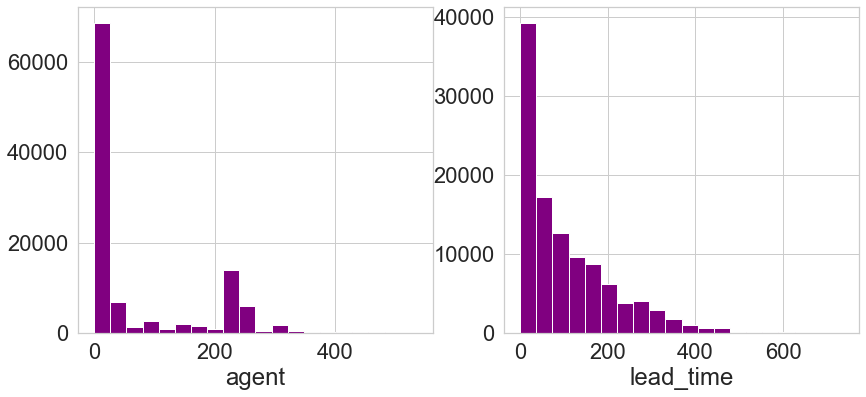

In [126]:
import pylab

#уберем дискретные признаки
count_cols = ['agent', 'lead_time']

plt.figure(figsize=(14,6))

for i,j in zip(count_cols, np.arange(1,len(count_cols)+1)):
    
    df_new = hotel_full[i]
    pylab.subplot(len(count_cols)//2,2,j)
    pylab.hist(df_new,bins=20, color='purple')
    plt.xlabel(i);

#### Вывод: выбросов в данных нет

#### Посмотрим на распределение дискретных признаков

In [127]:
hotel_full['reservation_status_date'] = pd.to_datetime(hotel_full['reservation_status_date'])

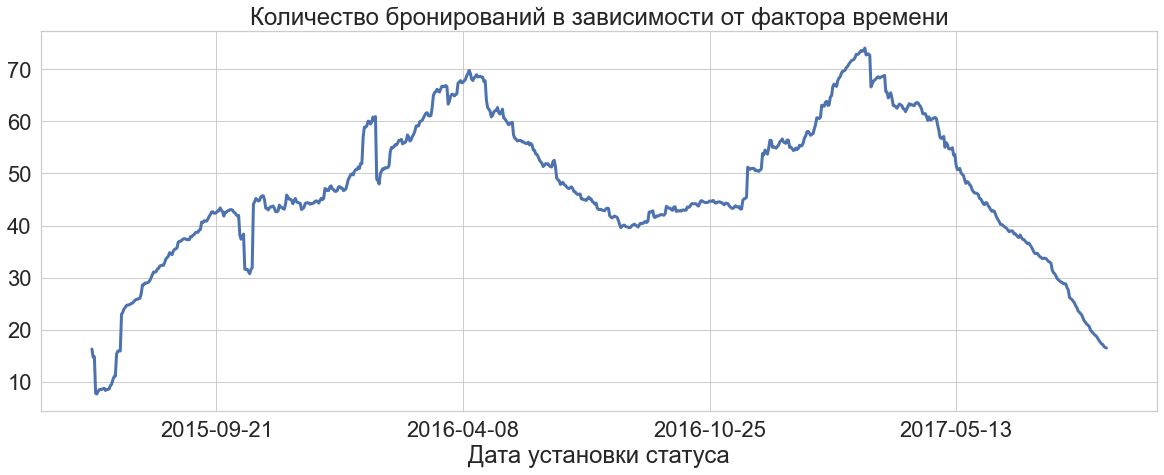

In [128]:
hotel_train.groupby('reservation_status_date').is_canceled.sum().rolling(100).mean().plot(linewidth=3)
plt.title('Количество бронирований в зависимости от фактора времени')
plt.xlabel('Дата установки статуса');

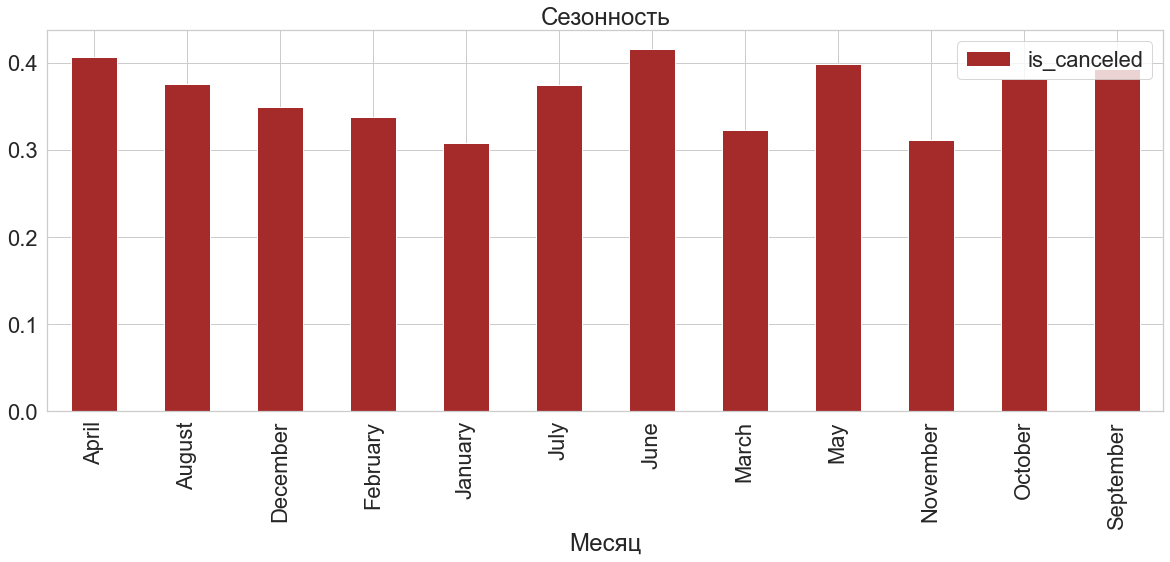

In [129]:
hotel_train.groupby('arrival_date_month').agg({'is_canceled':'mean'}).plot(kind='bar', color='brown')
plt.title('Сезонность')
plt.xlabel('Месяц');

#### Мы видим, что распределение по месяцам и график количества бронирований наглядно иллюстрируют сезонность и являются мультиколлинеарными, поэтому для упрощения работы уберем фактор времени

In [130]:
hotel_full.drop('reservation_status_date',axis=1,inplace=True)

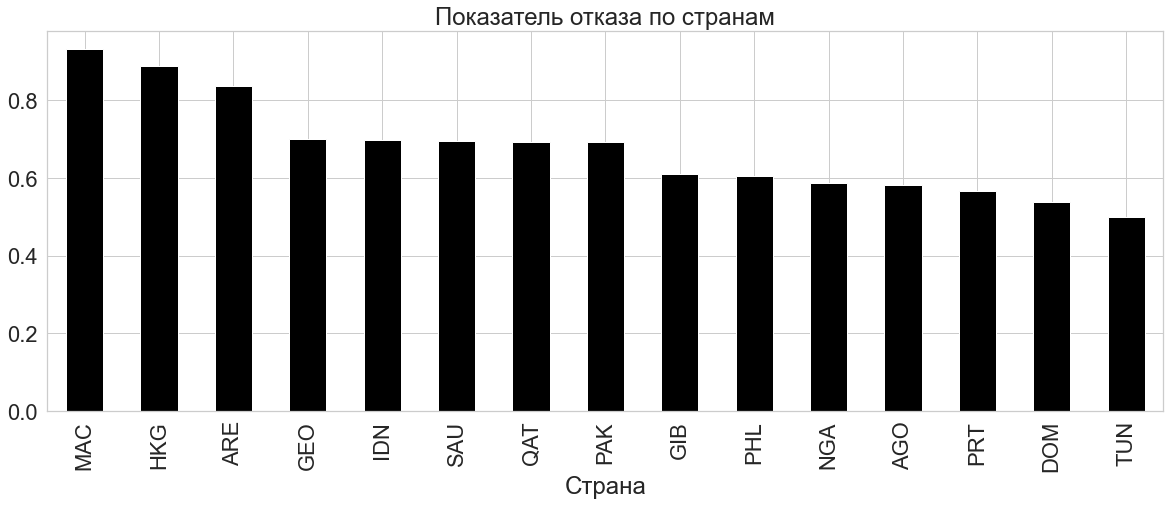

In [131]:
country_df = hotel_full.groupby('country').agg({'is_canceled': ['count','mean']}).rename({'is_canceled':'count'},axis=1)
country_med = country_df.median().values[0]
country_df.columns = ['count', 'mean']
country_df.query('count>@country_med')['mean'] \
            .sort_values(ascending=False).head(15).plot(kind='bar', color='black')
plt.title('Показатель отказа по странам')
plt.xlabel('Страна');

#### Посмотрим на среднее значение вероятности отказа по странам, на графике выведены страны с самым высоким процентом отказов (мы взяли страны с показателем количества бронирований больше медианного, так как распределение ненормальное, в нем присутствуют выбросы, то есть например 1 бронирование на всю страну)

#### Проведем похожие процедуры для остальных дискретных признаков

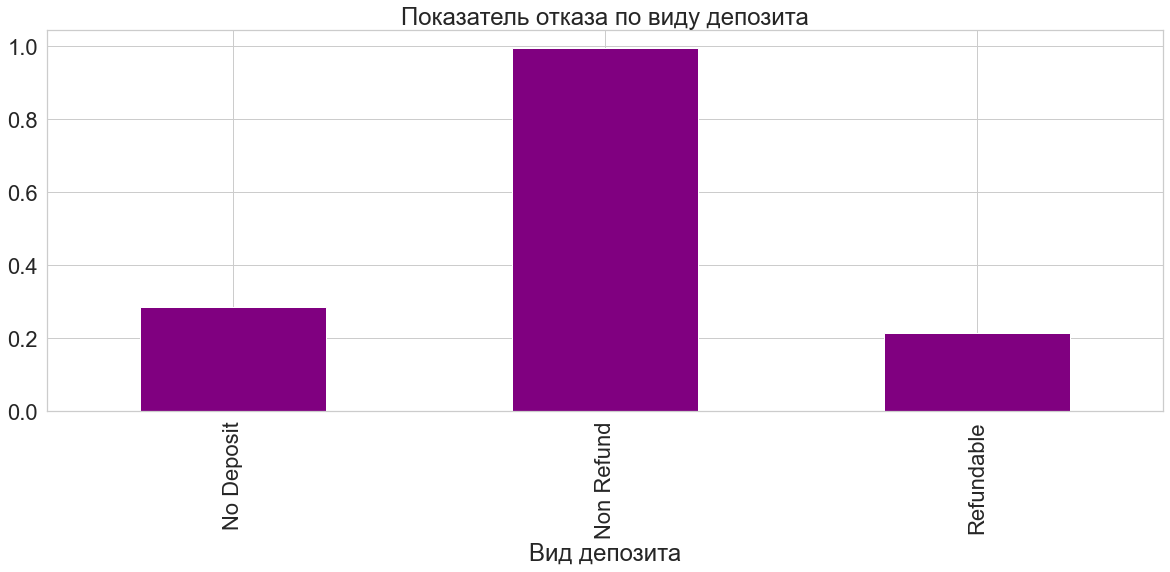

In [132]:
hotel_full.groupby('deposit_type').is_canceled.mean().plot(kind='bar', color='purple')
plt.title('Показатель отказа по виду депозита')
plt.xlabel('Вид депозита');

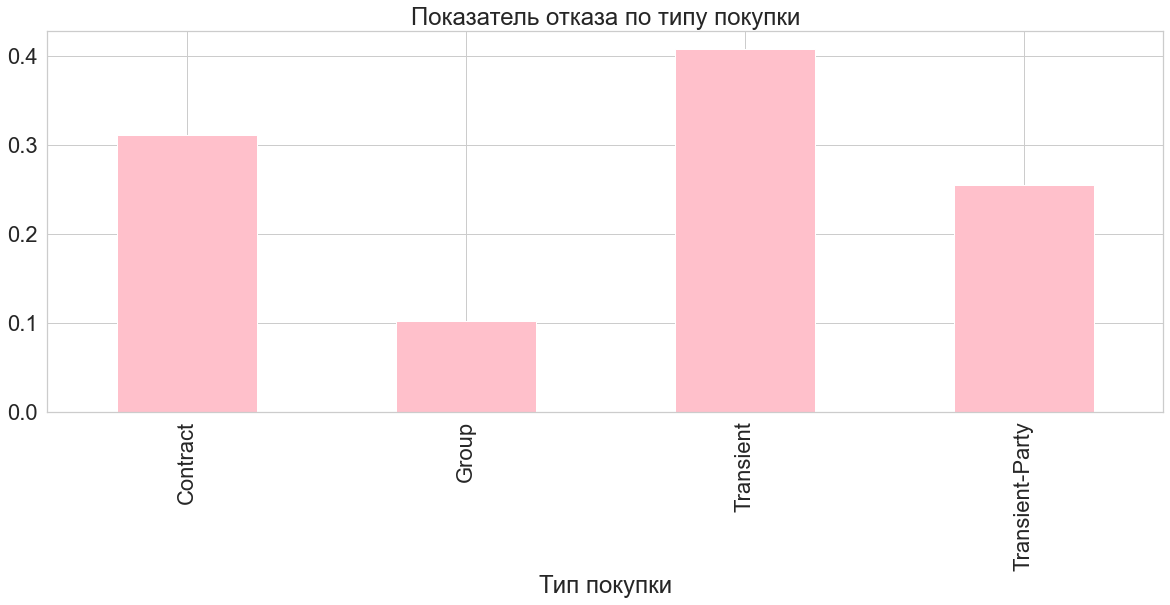

In [133]:
hotel_full.groupby('customer_type').is_canceled.mean().plot(kind='bar', color='pink')
plt.title('Показатель отказа по типу покупки')
plt.xlabel('Тип покупки');

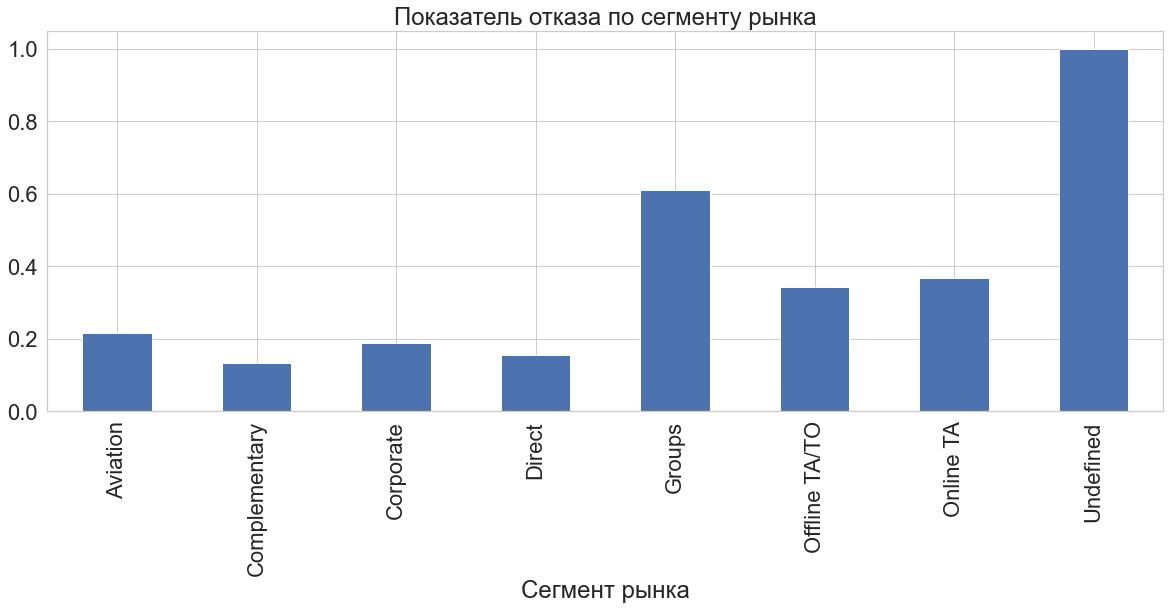

In [134]:
hotel_full.groupby('market_segment').is_canceled.mean().plot(kind='bar')
plt.title('Показатель отказа по сегменту рынка')
plt.xlabel('Сегмент рынка');

In [135]:
hotel_full.groupby('meal', as_index = False).is_canceled.count()

,meal,is_canceled
0,BB,84647
1,FB,724
2,HB,13212
3,SC,9729
4,Undefined,1078


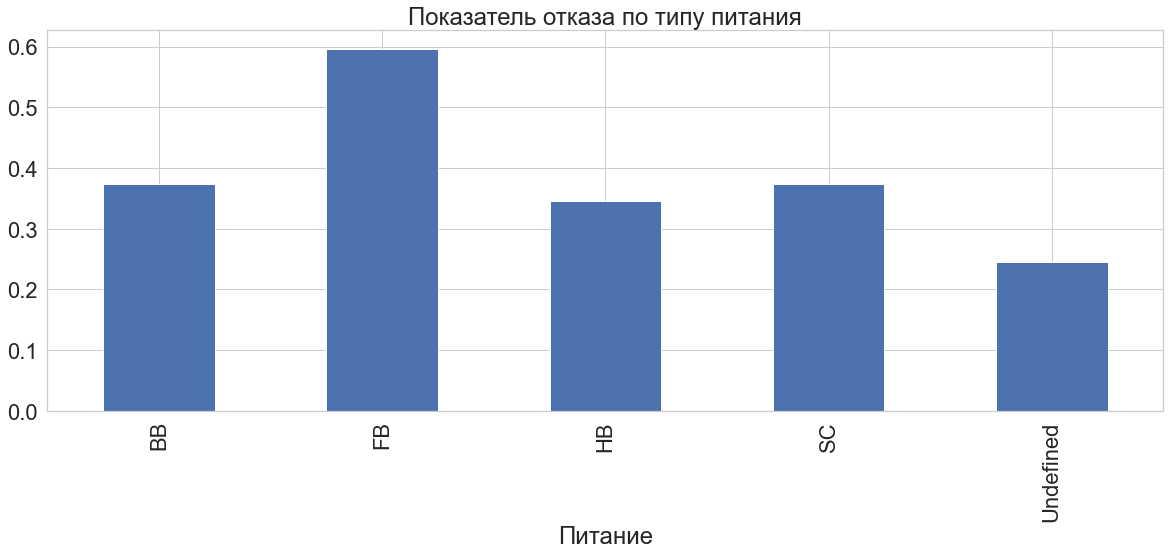

In [137]:
hotel_full.groupby('meal').is_canceled.mean().plot(kind='bar')
plt.title('Показатель отказа по типу питания')
plt.xlabel('Питание');

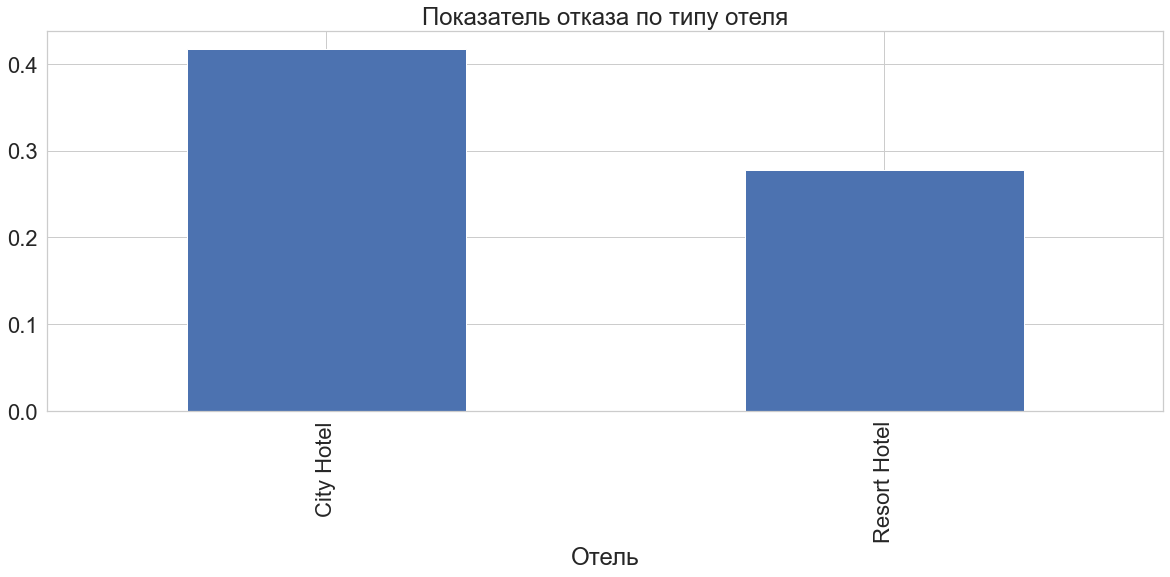

In [138]:
hotel_full.groupby('hotel').is_canceled.mean().plot(kind='bar')
plt.title('Показатель отказа по типу отеля')
plt.xlabel('Отель');

In [139]:
hotel_full.drop(['reserved_room_type','assigned_room_type'],axis=1, inplace=True)

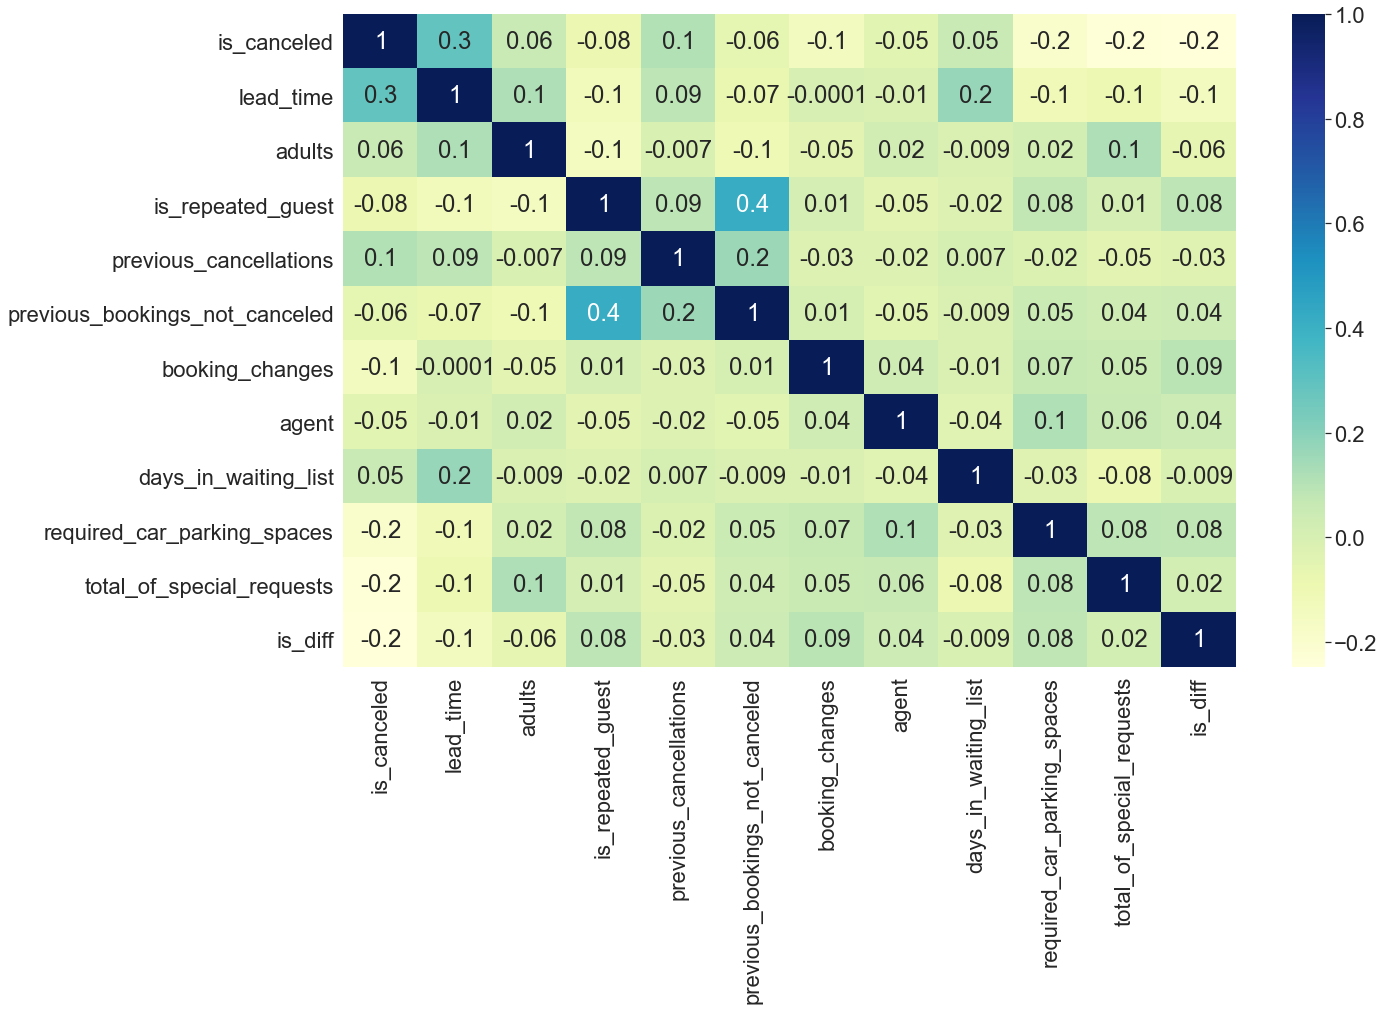

In [140]:
plt.figure(figsize=(20,12))
sns.heatmap(hotel_full.corr(method='pearson'),annot=True,cmap="YlGnBu", fmt='.1g')
plt.show()

In [141]:
hotel_full.drop(['previous_bookings_not_canceled', 'days_in_waiting_list'], axis=1, inplace=True)

### Переведем objectы в дамми-переменные

In [142]:
hotel_full['hotel'] = pd.get_dummies(hotel_train['hotel'])

In [143]:
def get_month_in_int(month):
    MonthInInts = pd.Series([1,2,3,4,5,6,7,8,9,10,11,12],
                            index=['January','February','March','April','May','June',
                                   'July', 'August','September','October','November','December'])
    return MonthInInts[month]

In [144]:
hotel_full['arrival_date_month'] = hotel_full.arrival_date_month.apply(get_month_in_int)

In [145]:
month_dumm = pd.get_dummies(hotel_full.arrival_date_month, prefix='arrival_date_month')

In [146]:
hotel_full = pd.concat([hotel_full, month_dumm], axis=1)

In [147]:
hotel_full.drop('arrival_date_month', axis=1, inplace=True)

In [148]:
meal_dumm = pd.get_dummies(hotel_full.meal, prefix='meal')

In [149]:
hotel_full = pd.concat([hotel_full, meal_dumm], axis=1)

In [150]:
hotel_full.drop('meal', axis=1, inplace=True)

In [151]:
country_dumm = pd.get_dummies(hotel_full.country, prefix='country')

In [152]:
hotel_full = pd.concat([hotel_full, country_dumm], axis=1)

In [153]:
hotel_full.drop('country', axis=1, inplace=True)

In [154]:
hotel_full.drop('distribution_channel',axis=1,inplace=True)

In [155]:
market_dumm = pd.get_dummies(hotel_full.market_segment, prefix='market_segment')

In [156]:
hotel_full = pd.concat([hotel_full, market_dumm], axis=1)

In [157]:
hotel_full.drop('market_segment', axis=1, inplace=True)

In [158]:
deposit_dumm = pd.get_dummies(hotel_full.deposit_type, prefix='deposit_type')

In [159]:
hotel_full = pd.concat([hotel_full, deposit_dumm], axis=1)

In [160]:
hotel_full.drop('deposit_type', axis=1, inplace=True)

In [161]:
customer_dumm = pd.get_dummies(hotel_full.customer_type, prefix='customer_type')

In [162]:
hotel_full = pd.concat([hotel_full, customer_dumm], axis=1)

In [163]:
hotel_full.drop('customer_type', axis=1, inplace=True)

In [164]:
hotel_full.shape

(109390, 219)

#### Наш датафрэйм готов, разделим его на train и test, исходя из начальных условий

In [165]:
X = hotel_full.drop('is_canceled',axis=1)
y = hotel_full['is_canceled'].values

#### Посмотрим на наличие дисбаланса классов в данных

In [166]:
print(len(y[y == 0]))
print(len(y[y == 1]))

68848
40542


#### Вывод: дисбаланса классов нет

#### Для построения модели сначала будем использовать градиентный бустинг с помощью библиотеки CatBoost

#### Разделим тренировочную часть еще на подтренировочную и подтестовую для оценки показателя ROC-AUC

In [168]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [170]:
cb = CatBoostClassifier()

In [171]:
gs_cb = GridSearchCV(cb, param_grid= {'iterations':[100,500,1000,1500],
                                      'depth':[3,6,9],
                                      'max_leaves':[10,50,64,100],
                                      'penalties_coefficient':[0.5,1,2]})

In [172]:
gs_cb.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.5
0:	learn: 0.4432724	total: 64.4ms	remaining: 6.37s
1:	learn: 0.3799528	total: 98.7ms	remaining: 4.84s
2:	learn: 0.3516279	total: 135ms	remaining: 4.37s
3:	learn: 0.3452568	total: 161ms	remaining: 3.85s
4:	learn: 0.3376024	total: 182ms	remaining: 3.46s
5:	learn: 0.3311968	total: 212ms	remaining: 3.33s
6:	learn: 0.3257482	total: 244ms	remaining: 3.24s
7:	learn: 0.3225401	total: 270ms	remaining: 3.1s
8:	learn: 0.3213011	total: 320ms	remaining: 3.23s
9:	learn: 0.3185798	total: 376ms	remaining: 3.38s
10:	learn: 0.3165208	total: 402ms	remaining: 3.25s
11:	learn: 0.3133514	total: 431ms	remaining: 3.16s
12:	learn: 0.3075612	total: 456ms	remaining: 3.05s
13:	learn: 0.3065577	total: 493ms	remaining: 3.02s
14:	learn: 0.3059612	total: 527ms	remaining: 2.99s
15:	learn: 0.3053440	total: 548ms	remaining: 2.88s
16:	learn: 0.3023354	total: 581ms	remaining: 2.84s
17:	learn: 0.3018317	total: 607ms	remaining: 2.77s
18:	learn: 0.3011085	total: 630ms	remaining: 2.68s
19:	learn: 0.30

65:	learn: 0.2740659	total: 1.46s	remaining: 750ms
66:	learn: 0.2740042	total: 1.48s	remaining: 727ms
67:	learn: 0.2734980	total: 1.5s	remaining: 705ms
68:	learn: 0.2734266	total: 1.51s	remaining: 678ms
69:	learn: 0.2730779	total: 1.53s	remaining: 657ms
70:	learn: 0.2725998	total: 1.55s	remaining: 632ms
71:	learn: 0.2721496	total: 1.56s	remaining: 608ms
72:	learn: 0.2715044	total: 1.58s	remaining: 585ms
73:	learn: 0.2702293	total: 1.6s	remaining: 562ms
74:	learn: 0.2694653	total: 1.61s	remaining: 538ms
75:	learn: 0.2689092	total: 1.63s	remaining: 515ms
76:	learn: 0.2684586	total: 1.64s	remaining: 491ms
77:	learn: 0.2682055	total: 1.66s	remaining: 467ms
78:	learn: 0.2678924	total: 1.68s	remaining: 447ms
79:	learn: 0.2675699	total: 1.69s	remaining: 423ms
80:	learn: 0.2673775	total: 1.71s	remaining: 401ms
81:	learn: 0.2670648	total: 1.73s	remaining: 380ms
82:	learn: 0.2667123	total: 1.74s	remaining: 357ms
83:	learn: 0.2663353	total: 1.76s	remaining: 335ms
84:	learn: 0.2661545	total: 1.78s

28:	learn: 0.2976404	total: 1.48s	remaining: 3.62s
29:	learn: 0.2961160	total: 1.5s	remaining: 3.49s
30:	learn: 0.2951153	total: 1.53s	remaining: 3.41s
31:	learn: 0.2941324	total: 1.63s	remaining: 3.47s
32:	learn: 0.2912744	total: 1.67s	remaining: 3.39s
33:	learn: 0.2906331	total: 1.71s	remaining: 3.31s
34:	learn: 0.2896906	total: 1.75s	remaining: 3.25s
35:	learn: 0.2891668	total: 1.77s	remaining: 3.15s
36:	learn: 0.2887786	total: 1.79s	remaining: 3.05s
37:	learn: 0.2887295	total: 1.82s	remaining: 2.96s
38:	learn: 0.2877152	total: 1.84s	remaining: 2.88s
39:	learn: 0.2874244	total: 1.87s	remaining: 2.8s
40:	learn: 0.2871380	total: 1.89s	remaining: 2.72s
41:	learn: 0.2868552	total: 1.92s	remaining: 2.65s
42:	learn: 0.2864996	total: 1.96s	remaining: 2.59s
43:	learn: 0.2854963	total: 2.03s	remaining: 2.59s
44:	learn: 0.2854591	total: 2.06s	remaining: 2.52s
45:	learn: 0.2853807	total: 2.1s	remaining: 2.47s
46:	learn: 0.2841843	total: 2.15s	remaining: 2.43s
47:	learn: 0.2833359	total: 2.19s	

96:	learn: 0.2627015	total: 2.26s	remaining: 70ms
97:	learn: 0.2624453	total: 2.28s	remaining: 46.5ms
98:	learn: 0.2621168	total: 2.31s	remaining: 23.3ms
99:	learn: 0.2619374	total: 2.32s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4432724	total: 61.5ms	remaining: 6.09s
1:	learn: 0.3799528	total: 185ms	remaining: 9.04s
2:	learn: 0.3516279	total: 221ms	remaining: 7.15s
3:	learn: 0.3452568	total: 259ms	remaining: 6.22s
4:	learn: 0.3376024	total: 320ms	remaining: 6.08s
5:	learn: 0.3311968	total: 496ms	remaining: 7.77s
6:	learn: 0.3257482	total: 528ms	remaining: 7.02s
7:	learn: 0.3225401	total: 551ms	remaining: 6.33s
8:	learn: 0.3213011	total: 576ms	remaining: 5.83s
9:	learn: 0.3185798	total: 601ms	remaining: 5.41s
10:	learn: 0.3165208	total: 649ms	remaining: 5.25s
11:	learn: 0.3133514	total: 684ms	remaining: 5.01s
12:	learn: 0.3075612	total: 710ms	remaining: 4.75s
13:	learn: 0.3065577	total: 750ms	remaining: 4.61s
14:	learn: 0.3059612	total: 773ms	remaining: 4.38s
15:	learn: 0.305

63:	learn: 0.2749633	total: 2.4s	remaining: 1.35s
64:	learn: 0.2745380	total: 2.47s	remaining: 1.33s
65:	learn: 0.2740659	total: 2.52s	remaining: 1.3s
66:	learn: 0.2740042	total: 2.56s	remaining: 1.26s
67:	learn: 0.2734980	total: 2.59s	remaining: 1.22s
68:	learn: 0.2734266	total: 2.69s	remaining: 1.21s
69:	learn: 0.2730779	total: 2.84s	remaining: 1.22s
70:	learn: 0.2725998	total: 2.86s	remaining: 1.17s
71:	learn: 0.2721496	total: 2.89s	remaining: 1.12s
72:	learn: 0.2715044	total: 2.93s	remaining: 1.08s
73:	learn: 0.2702293	total: 2.99s	remaining: 1.05s
74:	learn: 0.2694653	total: 3.06s	remaining: 1.02s
75:	learn: 0.2689092	total: 3.09s	remaining: 976ms
76:	learn: 0.2684586	total: 3.12s	remaining: 933ms
77:	learn: 0.2682055	total: 3.15s	remaining: 890ms
78:	learn: 0.2678924	total: 3.19s	remaining: 848ms
79:	learn: 0.2675699	total: 3.22s	remaining: 806ms
80:	learn: 0.2673775	total: 3.26s	remaining: 764ms
81:	learn: 0.2670648	total: 3.3s	remaining: 724ms
82:	learn: 0.2667123	total: 3.33s	

27:	learn: 0.2978887	total: 574ms	remaining: 1.48s
28:	learn: 0.2976404	total: 601ms	remaining: 1.47s
29:	learn: 0.2961160	total: 616ms	remaining: 1.44s
30:	learn: 0.2951153	total: 638ms	remaining: 1.42s
31:	learn: 0.2941324	total: 668ms	remaining: 1.42s
32:	learn: 0.2912744	total: 681ms	remaining: 1.38s
33:	learn: 0.2906331	total: 711ms	remaining: 1.38s
34:	learn: 0.2896906	total: 725ms	remaining: 1.34s
35:	learn: 0.2891668	total: 740ms	remaining: 1.31s
36:	learn: 0.2887786	total: 751ms	remaining: 1.28s
37:	learn: 0.2887295	total: 762ms	remaining: 1.24s
38:	learn: 0.2877152	total: 791ms	remaining: 1.24s
39:	learn: 0.2874244	total: 806ms	remaining: 1.21s
40:	learn: 0.2871380	total: 819ms	remaining: 1.18s
41:	learn: 0.2868552	total: 833ms	remaining: 1.15s
42:	learn: 0.2864996	total: 847ms	remaining: 1.12s
43:	learn: 0.2854963	total: 860ms	remaining: 1.09s
44:	learn: 0.2854591	total: 873ms	remaining: 1.07s
45:	learn: 0.2853807	total: 884ms	remaining: 1.04s
46:	learn: 0.2841843	total: 901

88:	learn: 0.2644303	total: 3.57s	remaining: 442ms
89:	learn: 0.2643619	total: 3.61s	remaining: 401ms
90:	learn: 0.2643360	total: 3.65s	remaining: 361ms
91:	learn: 0.2639963	total: 3.68s	remaining: 320ms
92:	learn: 0.2636194	total: 3.71s	remaining: 280ms
93:	learn: 0.2633383	total: 3.75s	remaining: 239ms
94:	learn: 0.2632942	total: 3.77s	remaining: 198ms
95:	learn: 0.2631096	total: 3.81s	remaining: 159ms
96:	learn: 0.2627015	total: 3.85s	remaining: 119ms
97:	learn: 0.2624453	total: 3.88s	remaining: 79.1ms
98:	learn: 0.2621168	total: 3.91s	remaining: 39.5ms
99:	learn: 0.2619374	total: 3.93s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4432724	total: 15.6ms	remaining: 1.55s
1:	learn: 0.3799528	total: 32.7ms	remaining: 1.6s
2:	learn: 0.3516279	total: 53.8ms	remaining: 1.74s
3:	learn: 0.3452568	total: 75ms	remaining: 1.8s
4:	learn: 0.3376024	total: 90.6ms	remaining: 1.72s
5:	learn: 0.3311968	total: 108ms	remaining: 1.7s
6:	learn: 0.3257482	total: 125ms	remaining: 1.66s
7:	learn: 0.3

50:	learn: 0.2815400	total: 2.32s	remaining: 2.23s
51:	learn: 0.2810391	total: 2.35s	remaining: 2.17s
52:	learn: 0.2803939	total: 2.38s	remaining: 2.11s
53:	learn: 0.2803754	total: 2.4s	remaining: 2.05s
54:	learn: 0.2800003	total: 2.45s	remaining: 2s
55:	learn: 0.2799805	total: 2.54s	remaining: 2s
56:	learn: 0.2796966	total: 2.58s	remaining: 1.95s
57:	learn: 0.2791928	total: 2.64s	remaining: 1.91s
58:	learn: 0.2788120	total: 2.69s	remaining: 1.87s
59:	learn: 0.2772203	total: 2.72s	remaining: 1.81s
60:	learn: 0.2768073	total: 2.79s	remaining: 1.78s
61:	learn: 0.2762720	total: 2.82s	remaining: 1.73s
62:	learn: 0.2753211	total: 2.85s	remaining: 1.67s
63:	learn: 0.2749633	total: 2.92s	remaining: 1.64s
64:	learn: 0.2745380	total: 2.95s	remaining: 1.59s
65:	learn: 0.2740659	total: 3s	remaining: 1.54s
66:	learn: 0.2740042	total: 3.04s	remaining: 1.5s
67:	learn: 0.2734980	total: 3.07s	remaining: 1.44s
68:	learn: 0.2734266	total: 3.1s	remaining: 1.39s
69:	learn: 0.2730779	total: 3.14s	remaining

13:	learn: 0.3095183	total: 401ms	remaining: 2.46s
14:	learn: 0.3079480	total: 431ms	remaining: 2.44s
15:	learn: 0.3068743	total: 461ms	remaining: 2.42s
16:	learn: 0.3054662	total: 484ms	remaining: 2.36s
17:	learn: 0.3051019	total: 502ms	remaining: 2.29s
18:	learn: 0.3047172	total: 521ms	remaining: 2.22s
19:	learn: 0.3040308	total: 546ms	remaining: 2.18s
20:	learn: 0.3027789	total: 577ms	remaining: 2.17s
21:	learn: 0.3020295	total: 598ms	remaining: 2.12s
22:	learn: 0.3015457	total: 626ms	remaining: 2.09s
23:	learn: 0.3002832	total: 650ms	remaining: 2.06s
24:	learn: 0.2997657	total: 684ms	remaining: 2.05s
25:	learn: 0.2992387	total: 710ms	remaining: 2.02s
26:	learn: 0.2987802	total: 743ms	remaining: 2.01s
27:	learn: 0.2978887	total: 780ms	remaining: 2.01s
28:	learn: 0.2976404	total: 808ms	remaining: 1.98s
29:	learn: 0.2961160	total: 849ms	remaining: 1.98s
30:	learn: 0.2951153	total: 876ms	remaining: 1.95s
31:	learn: 0.2941324	total: 890ms	remaining: 1.89s
32:	learn: 0.2912744	total: 910

75:	learn: 0.2678664	total: 1.67s	remaining: 529ms
76:	learn: 0.2675184	total: 1.7s	remaining: 509ms
77:	learn: 0.2673562	total: 1.73s	remaining: 488ms
78:	learn: 0.2670390	total: 1.76s	remaining: 468ms
79:	learn: 0.2667581	total: 1.78s	remaining: 446ms
80:	learn: 0.2667217	total: 1.8s	remaining: 423ms
81:	learn: 0.2666613	total: 1.83s	remaining: 401ms
82:	learn: 0.2665081	total: 1.85s	remaining: 379ms
83:	learn: 0.2658576	total: 1.89s	remaining: 359ms
84:	learn: 0.2654504	total: 1.91s	remaining: 337ms
85:	learn: 0.2648462	total: 1.94s	remaining: 316ms
86:	learn: 0.2646423	total: 1.97s	remaining: 295ms
87:	learn: 0.2644524	total: 2s	remaining: 273ms
88:	learn: 0.2644303	total: 2.02s	remaining: 250ms
89:	learn: 0.2643619	total: 2.04s	remaining: 227ms
90:	learn: 0.2643360	total: 2.06s	remaining: 204ms
91:	learn: 0.2639963	total: 2.09s	remaining: 182ms
92:	learn: 0.2636194	total: 2.12s	remaining: 160ms
93:	learn: 0.2633383	total: 2.15s	remaining: 137ms
94:	learn: 0.2632942	total: 2.18s	re

136:	learn: 0.2901225	total: 6.02s	remaining: 15.9s
137:	learn: 0.2900145	total: 6.07s	remaining: 15.9s
138:	learn: 0.2899144	total: 6.09s	remaining: 15.8s
139:	learn: 0.2893933	total: 6.13s	remaining: 15.8s
140:	learn: 0.2891705	total: 6.15s	remaining: 15.7s
141:	learn: 0.2890737	total: 6.18s	remaining: 15.6s
142:	learn: 0.2888900	total: 6.25s	remaining: 15.6s
143:	learn: 0.2886873	total: 6.29s	remaining: 15.5s
144:	learn: 0.2884671	total: 6.32s	remaining: 15.5s
145:	learn: 0.2882873	total: 6.36s	remaining: 15.4s
146:	learn: 0.2881342	total: 6.39s	remaining: 15.3s
147:	learn: 0.2880107	total: 6.43s	remaining: 15.3s
148:	learn: 0.2877653	total: 6.46s	remaining: 15.2s
149:	learn: 0.2873531	total: 6.5s	remaining: 15.2s
150:	learn: 0.2872318	total: 6.53s	remaining: 15.1s
151:	learn: 0.2870152	total: 6.56s	remaining: 15s
152:	learn: 0.2868286	total: 6.59s	remaining: 14.9s
153:	learn: 0.2867575	total: 6.62s	remaining: 14.9s
154:	learn: 0.2866308	total: 6.64s	remaining: 14.8s
155:	learn: 0.2

301:	learn: 0.2710671	total: 11.3s	remaining: 7.39s
302:	learn: 0.2709845	total: 11.3s	remaining: 7.34s
303:	learn: 0.2709339	total: 11.3s	remaining: 7.29s
304:	learn: 0.2708574	total: 11.3s	remaining: 7.24s
305:	learn: 0.2707542	total: 11.3s	remaining: 7.19s
306:	learn: 0.2706857	total: 11.4s	remaining: 7.14s
307:	learn: 0.2705836	total: 11.4s	remaining: 7.09s
308:	learn: 0.2705095	total: 11.4s	remaining: 7.04s
309:	learn: 0.2704144	total: 11.4s	remaining: 6.99s
310:	learn: 0.2703091	total: 11.4s	remaining: 6.94s
311:	learn: 0.2703035	total: 11.4s	remaining: 6.88s
312:	learn: 0.2702486	total: 11.4s	remaining: 6.83s
313:	learn: 0.2701010	total: 11.5s	remaining: 6.78s
314:	learn: 0.2699673	total: 11.5s	remaining: 6.73s
315:	learn: 0.2698669	total: 11.5s	remaining: 6.69s
316:	learn: 0.2697691	total: 11.5s	remaining: 6.64s
317:	learn: 0.2696804	total: 11.5s	remaining: 6.59s
318:	learn: 0.2696777	total: 11.5s	remaining: 6.54s
319:	learn: 0.2695823	total: 11.6s	remaining: 6.5s
320:	learn: 0

460:	learn: 0.2605376	total: 16.3s	remaining: 1.38s
461:	learn: 0.2605265	total: 16.4s	remaining: 1.35s
462:	learn: 0.2605250	total: 16.4s	remaining: 1.31s
463:	learn: 0.2604440	total: 16.4s	remaining: 1.27s
464:	learn: 0.2603588	total: 16.6s	remaining: 1.25s
465:	learn: 0.2603552	total: 16.6s	remaining: 1.21s
466:	learn: 0.2603137	total: 16.7s	remaining: 1.18s
467:	learn: 0.2602911	total: 16.7s	remaining: 1.14s
468:	learn: 0.2601911	total: 16.8s	remaining: 1.11s
469:	learn: 0.2601776	total: 16.8s	remaining: 1.07s
470:	learn: 0.2601052	total: 16.9s	remaining: 1.04s
471:	learn: 0.2600316	total: 17s	remaining: 1.01s
472:	learn: 0.2599514	total: 17s	remaining: 970ms
473:	learn: 0.2599235	total: 17s	remaining: 933ms
474:	learn: 0.2598596	total: 17.1s	remaining: 898ms
475:	learn: 0.2598084	total: 17.1s	remaining: 861ms
476:	learn: 0.2597769	total: 17.1s	remaining: 825ms
477:	learn: 0.2597249	total: 17.1s	remaining: 788ms
478:	learn: 0.2596121	total: 17.1s	remaining: 752ms
479:	learn: 0.2595

127:	learn: 0.2900356	total: 3.54s	remaining: 10.3s
128:	learn: 0.2897472	total: 3.56s	remaining: 10.2s
129:	learn: 0.2895366	total: 3.57s	remaining: 10.2s
130:	learn: 0.2893537	total: 3.58s	remaining: 10.1s
131:	learn: 0.2891979	total: 3.61s	remaining: 10.1s
132:	learn: 0.2889402	total: 3.66s	remaining: 10.1s
133:	learn: 0.2887324	total: 3.67s	remaining: 10s
134:	learn: 0.2885323	total: 3.69s	remaining: 9.97s
135:	learn: 0.2884251	total: 3.7s	remaining: 9.9s
136:	learn: 0.2883740	total: 3.71s	remaining: 9.83s
137:	learn: 0.2882059	total: 3.72s	remaining: 9.77s
138:	learn: 0.2881243	total: 3.74s	remaining: 9.72s
139:	learn: 0.2878825	total: 3.76s	remaining: 9.66s
140:	learn: 0.2877215	total: 3.77s	remaining: 9.6s
141:	learn: 0.2876180	total: 3.78s	remaining: 9.54s
142:	learn: 0.2873815	total: 3.8s	remaining: 9.48s
143:	learn: 0.2871566	total: 3.81s	remaining: 9.42s
144:	learn: 0.2867089	total: 3.82s	remaining: 9.36s
145:	learn: 0.2864497	total: 3.84s	remaining: 9.3s
146:	learn: 0.28614

290:	learn: 0.2717014	total: 5.85s	remaining: 4.2s
291:	learn: 0.2716075	total: 5.86s	remaining: 4.18s
292:	learn: 0.2714735	total: 5.88s	remaining: 4.15s
293:	learn: 0.2714537	total: 5.9s	remaining: 4.13s
294:	learn: 0.2713722	total: 5.92s	remaining: 4.11s
295:	learn: 0.2713110	total: 5.95s	remaining: 4.1s
296:	learn: 0.2712520	total: 5.96s	remaining: 4.08s
297:	learn: 0.2712136	total: 5.98s	remaining: 4.05s
298:	learn: 0.2711345	total: 6s	remaining: 4.03s
299:	learn: 0.2710066	total: 6.01s	remaining: 4s
300:	learn: 0.2709607	total: 6.02s	remaining: 3.98s
301:	learn: 0.2708428	total: 6.04s	remaining: 3.96s
302:	learn: 0.2707113	total: 6.06s	remaining: 3.94s
303:	learn: 0.2707087	total: 6.08s	remaining: 3.92s
304:	learn: 0.2706575	total: 6.1s	remaining: 3.9s
305:	learn: 0.2706085	total: 6.12s	remaining: 3.88s
306:	learn: 0.2705764	total: 6.14s	remaining: 3.86s
307:	learn: 0.2704250	total: 6.16s	remaining: 3.84s
308:	learn: 0.2703449	total: 6.18s	remaining: 3.82s
309:	learn: 0.2703385	t

451:	learn: 0.2604680	total: 8.55s	remaining: 908ms
452:	learn: 0.2604080	total: 8.56s	remaining: 889ms
453:	learn: 0.2603521	total: 8.58s	remaining: 869ms
454:	learn: 0.2602851	total: 8.59s	remaining: 850ms
455:	learn: 0.2602797	total: 8.6s	remaining: 830ms
456:	learn: 0.2601864	total: 8.62s	remaining: 811ms
457:	learn: 0.2601549	total: 8.63s	remaining: 792ms
458:	learn: 0.2601512	total: 8.64s	remaining: 772ms
459:	learn: 0.2600297	total: 8.66s	remaining: 753ms
460:	learn: 0.2600281	total: 8.67s	remaining: 733ms
461:	learn: 0.2599816	total: 8.68s	remaining: 714ms
462:	learn: 0.2599613	total: 8.69s	remaining: 695ms
463:	learn: 0.2598870	total: 8.71s	remaining: 676ms
464:	learn: 0.2598842	total: 8.72s	remaining: 656ms
465:	learn: 0.2597909	total: 8.73s	remaining: 637ms
466:	learn: 0.2597894	total: 8.76s	remaining: 619ms
467:	learn: 0.2596960	total: 8.78s	remaining: 601ms
468:	learn: 0.2596173	total: 8.81s	remaining: 582ms
469:	learn: 0.2595366	total: 8.82s	remaining: 563ms
470:	learn: 0

117:	learn: 0.2946686	total: 1.91s	remaining: 6.19s
118:	learn: 0.2945254	total: 1.93s	remaining: 6.17s
119:	learn: 0.2941082	total: 1.96s	remaining: 6.2s
120:	learn: 0.2938356	total: 1.97s	remaining: 6.17s
121:	learn: 0.2936373	total: 1.98s	remaining: 6.14s
122:	learn: 0.2934163	total: 2s	remaining: 6.14s
123:	learn: 0.2932774	total: 2.02s	remaining: 6.11s
124:	learn: 0.2931619	total: 2.03s	remaining: 6.08s
125:	learn: 0.2930568	total: 2.04s	remaining: 6.05s
126:	learn: 0.2929720	total: 2.05s	remaining: 6.02s
127:	learn: 0.2928132	total: 2.07s	remaining: 6.02s
128:	learn: 0.2923304	total: 2.08s	remaining: 6s
129:	learn: 0.2921354	total: 2.1s	remaining: 5.98s
130:	learn: 0.2919274	total: 2.12s	remaining: 5.96s
131:	learn: 0.2918675	total: 2.13s	remaining: 5.94s
132:	learn: 0.2916907	total: 2.15s	remaining: 5.95s
133:	learn: 0.2914768	total: 2.17s	remaining: 5.93s
134:	learn: 0.2913287	total: 2.18s	remaining: 5.9s
135:	learn: 0.2912282	total: 2.19s	remaining: 5.87s
136:	learn: 0.2908586

283:	learn: 0.2732882	total: 4.35s	remaining: 3.31s
284:	learn: 0.2731933	total: 4.36s	remaining: 3.29s
285:	learn: 0.2731895	total: 4.38s	remaining: 3.28s
286:	learn: 0.2730988	total: 4.4s	remaining: 3.26s
287:	learn: 0.2730093	total: 4.41s	remaining: 3.25s
288:	learn: 0.2730061	total: 4.44s	remaining: 3.24s
289:	learn: 0.2729253	total: 4.45s	remaining: 3.22s
290:	learn: 0.2728567	total: 4.46s	remaining: 3.2s
291:	learn: 0.2727891	total: 4.47s	remaining: 3.19s
292:	learn: 0.2727202	total: 4.48s	remaining: 3.17s
293:	learn: 0.2726020	total: 4.5s	remaining: 3.15s
294:	learn: 0.2725477	total: 4.51s	remaining: 3.13s
295:	learn: 0.2724841	total: 4.53s	remaining: 3.12s
296:	learn: 0.2724220	total: 4.54s	remaining: 3.1s
297:	learn: 0.2723696	total: 4.55s	remaining: 3.09s
298:	learn: 0.2722899	total: 4.58s	remaining: 3.08s
299:	learn: 0.2722159	total: 4.59s	remaining: 3.06s
300:	learn: 0.2721608	total: 4.61s	remaining: 3.04s
301:	learn: 0.2721388	total: 4.62s	remaining: 3.03s
302:	learn: 0.27

448:	learn: 0.2621512	total: 6.84s	remaining: 777ms
449:	learn: 0.2621214	total: 6.85s	remaining: 761ms
450:	learn: 0.2621060	total: 6.88s	remaining: 747ms
451:	learn: 0.2620370	total: 6.89s	remaining: 732ms
452:	learn: 0.2619472	total: 6.9s	remaining: 716ms
453:	learn: 0.2619262	total: 6.92s	remaining: 702ms
454:	learn: 0.2618614	total: 6.94s	remaining: 686ms
455:	learn: 0.2618011	total: 6.95s	remaining: 671ms
456:	learn: 0.2617520	total: 6.97s	remaining: 656ms
457:	learn: 0.2617384	total: 6.98s	remaining: 640ms
458:	learn: 0.2616608	total: 6.99s	remaining: 624ms
459:	learn: 0.2615462	total: 7s	remaining: 609ms
460:	learn: 0.2615062	total: 7.01s	remaining: 593ms
461:	learn: 0.2614036	total: 7.03s	remaining: 578ms
462:	learn: 0.2613482	total: 7.05s	remaining: 563ms
463:	learn: 0.2613325	total: 7.07s	remaining: 549ms
464:	learn: 0.2612795	total: 7.08s	remaining: 533ms
465:	learn: 0.2612132	total: 7.09s	remaining: 518ms
466:	learn: 0.2611380	total: 7.11s	remaining: 502ms
467:	learn: 0.26

115:	learn: 0.2943423	total: 2.09s	remaining: 6.92s
116:	learn: 0.2942789	total: 2.11s	remaining: 6.91s
117:	learn: 0.2941008	total: 2.13s	remaining: 6.9s
118:	learn: 0.2939203	total: 2.16s	remaining: 6.92s
119:	learn: 0.2936692	total: 2.18s	remaining: 6.91s
120:	learn: 0.2934572	total: 2.22s	remaining: 6.95s
121:	learn: 0.2933992	total: 2.24s	remaining: 6.93s
122:	learn: 0.2931975	total: 2.25s	remaining: 6.9s
123:	learn: 0.2929319	total: 2.27s	remaining: 6.88s
124:	learn: 0.2926575	total: 2.28s	remaining: 6.85s
125:	learn: 0.2925474	total: 2.32s	remaining: 6.88s
126:	learn: 0.2923731	total: 2.33s	remaining: 6.86s
127:	learn: 0.2920883	total: 2.35s	remaining: 6.83s
128:	learn: 0.2919670	total: 2.38s	remaining: 6.84s
129:	learn: 0.2919530	total: 2.39s	remaining: 6.81s
130:	learn: 0.2918304	total: 2.41s	remaining: 6.79s
131:	learn: 0.2917079	total: 2.42s	remaining: 6.76s
132:	learn: 0.2915037	total: 2.44s	remaining: 6.73s
133:	learn: 0.2914800	total: 2.45s	remaining: 6.69s
134:	learn: 0.

277:	learn: 0.2736470	total: 4.61s	remaining: 3.68s
278:	learn: 0.2735979	total: 4.62s	remaining: 3.66s
279:	learn: 0.2735886	total: 4.64s	remaining: 3.65s
280:	learn: 0.2734495	total: 4.66s	remaining: 3.63s
281:	learn: 0.2734464	total: 4.67s	remaining: 3.61s
282:	learn: 0.2733418	total: 4.69s	remaining: 3.6s
283:	learn: 0.2733218	total: 4.71s	remaining: 3.58s
284:	learn: 0.2732876	total: 4.72s	remaining: 3.56s
285:	learn: 0.2732396	total: 4.74s	remaining: 3.55s
286:	learn: 0.2730432	total: 4.76s	remaining: 3.53s
287:	learn: 0.2728828	total: 4.78s	remaining: 3.52s
288:	learn: 0.2727931	total: 4.8s	remaining: 3.5s
289:	learn: 0.2727080	total: 4.82s	remaining: 3.49s
290:	learn: 0.2726082	total: 4.85s	remaining: 3.48s
291:	learn: 0.2725106	total: 4.88s	remaining: 3.48s
292:	learn: 0.2723535	total: 4.91s	remaining: 3.47s
293:	learn: 0.2722334	total: 4.94s	remaining: 3.46s
294:	learn: 0.2720071	total: 4.96s	remaining: 3.45s
295:	learn: 0.2720011	total: 4.98s	remaining: 3.44s
296:	learn: 0.2

446:	learn: 0.2612588	total: 7.53s	remaining: 893ms
447:	learn: 0.2611935	total: 7.55s	remaining: 876ms
448:	learn: 0.2610933	total: 7.57s	remaining: 860ms
449:	learn: 0.2610362	total: 7.58s	remaining: 843ms
450:	learn: 0.2610126	total: 7.6s	remaining: 825ms
451:	learn: 0.2609599	total: 7.61s	remaining: 808ms
452:	learn: 0.2609045	total: 7.62s	remaining: 791ms
453:	learn: 0.2608445	total: 7.63s	remaining: 773ms
454:	learn: 0.2607939	total: 7.65s	remaining: 756ms
455:	learn: 0.2607671	total: 7.66s	remaining: 739ms
456:	learn: 0.2606593	total: 7.67s	remaining: 722ms
457:	learn: 0.2605754	total: 7.68s	remaining: 705ms
458:	learn: 0.2605702	total: 7.7s	remaining: 687ms
459:	learn: 0.2605122	total: 7.71s	remaining: 670ms
460:	learn: 0.2604535	total: 7.72s	remaining: 653ms
461:	learn: 0.2604294	total: 7.73s	remaining: 636ms
462:	learn: 0.2603408	total: 7.74s	remaining: 619ms
463:	learn: 0.2602942	total: 7.76s	remaining: 602ms
464:	learn: 0.2602344	total: 7.78s	remaining: 586ms
465:	learn: 0.

108:	learn: 0.2951885	total: 1.79s	remaining: 6.42s
109:	learn: 0.2950679	total: 1.81s	remaining: 6.43s
110:	learn: 0.2946382	total: 1.83s	remaining: 6.41s
111:	learn: 0.2944667	total: 1.85s	remaining: 6.4s
112:	learn: 0.2942147	total: 1.86s	remaining: 6.38s
113:	learn: 0.2939754	total: 1.88s	remaining: 6.35s
114:	learn: 0.2935288	total: 1.89s	remaining: 6.33s
115:	learn: 0.2933018	total: 1.9s	remaining: 6.3s
116:	learn: 0.2931365	total: 1.92s	remaining: 6.27s
117:	learn: 0.2929433	total: 1.94s	remaining: 6.28s
118:	learn: 0.2928330	total: 1.96s	remaining: 6.26s
119:	learn: 0.2927002	total: 1.97s	remaining: 6.24s
120:	learn: 0.2926730	total: 1.98s	remaining: 6.2s
121:	learn: 0.2922061	total: 2s	remaining: 6.21s
122:	learn: 0.2919234	total: 2.03s	remaining: 6.21s
123:	learn: 0.2918163	total: 2.04s	remaining: 6.19s
124:	learn: 0.2915351	total: 2.07s	remaining: 6.21s
125:	learn: 0.2913883	total: 2.08s	remaining: 6.18s
126:	learn: 0.2912497	total: 2.11s	remaining: 6.19s
127:	learn: 0.29109

277:	learn: 0.2725116	total: 4.27s	remaining: 3.41s
278:	learn: 0.2723544	total: 4.29s	remaining: 3.39s
279:	learn: 0.2722583	total: 4.3s	remaining: 3.38s
280:	learn: 0.2721453	total: 4.32s	remaining: 3.36s
281:	learn: 0.2720761	total: 4.33s	remaining: 3.35s
282:	learn: 0.2720580	total: 4.34s	remaining: 3.33s
283:	learn: 0.2720050	total: 4.36s	remaining: 3.31s
284:	learn: 0.2719033	total: 4.37s	remaining: 3.3s
285:	learn: 0.2717749	total: 4.38s	remaining: 3.28s
286:	learn: 0.2717384	total: 4.39s	remaining: 3.26s
287:	learn: 0.2716827	total: 4.41s	remaining: 3.25s
288:	learn: 0.2716779	total: 4.42s	remaining: 3.23s
289:	learn: 0.2716413	total: 4.52s	remaining: 3.27s
290:	learn: 0.2715422	total: 4.54s	remaining: 3.26s
291:	learn: 0.2712979	total: 4.55s	remaining: 3.24s
292:	learn: 0.2712060	total: 4.57s	remaining: 3.23s
293:	learn: 0.2711642	total: 4.58s	remaining: 3.21s
294:	learn: 0.2710786	total: 4.59s	remaining: 3.19s
295:	learn: 0.2710749	total: 4.62s	remaining: 3.18s
296:	learn: 0.

438:	learn: 0.2605577	total: 6.74s	remaining: 937ms
439:	learn: 0.2604680	total: 6.75s	remaining: 921ms
440:	learn: 0.2604659	total: 6.76s	remaining: 905ms
441:	learn: 0.2603637	total: 6.79s	remaining: 891ms
442:	learn: 0.2602382	total: 6.8s	remaining: 876ms
443:	learn: 0.2601717	total: 6.82s	remaining: 860ms
444:	learn: 0.2600434	total: 6.84s	remaining: 845ms
445:	learn: 0.2599798	total: 6.85s	remaining: 829ms
446:	learn: 0.2599548	total: 6.86s	remaining: 814ms
447:	learn: 0.2598652	total: 6.88s	remaining: 798ms
448:	learn: 0.2598623	total: 6.89s	remaining: 783ms
449:	learn: 0.2597824	total: 6.9s	remaining: 767ms
450:	learn: 0.2597450	total: 6.91s	remaining: 751ms
451:	learn: 0.2596842	total: 6.92s	remaining: 735ms
452:	learn: 0.2595845	total: 6.94s	remaining: 720ms
453:	learn: 0.2595815	total: 6.95s	remaining: 704ms
454:	learn: 0.2595720	total: 6.96s	remaining: 689ms
455:	learn: 0.2595085	total: 6.99s	remaining: 675ms
456:	learn: 0.2594507	total: 7s	remaining: 659ms
457:	learn: 0.259

112:	learn: 0.2947370	total: 2.02s	remaining: 6.94s
113:	learn: 0.2946779	total: 2.04s	remaining: 6.89s
114:	learn: 0.2944788	total: 2.05s	remaining: 6.85s
115:	learn: 0.2943160	total: 2.07s	remaining: 6.84s
116:	learn: 0.2941528	total: 2.09s	remaining: 6.84s
117:	learn: 0.2940451	total: 2.11s	remaining: 6.84s
118:	learn: 0.2938112	total: 2.13s	remaining: 6.84s
119:	learn: 0.2935299	total: 2.16s	remaining: 6.83s
120:	learn: 0.2932752	total: 2.17s	remaining: 6.81s
121:	learn: 0.2929768	total: 2.19s	remaining: 6.78s
122:	learn: 0.2927949	total: 2.2s	remaining: 6.75s
123:	learn: 0.2925345	total: 2.22s	remaining: 6.73s
124:	learn: 0.2923251	total: 2.24s	remaining: 6.72s
125:	learn: 0.2920312	total: 2.26s	remaining: 6.71s
126:	learn: 0.2918393	total: 2.27s	remaining: 6.67s
127:	learn: 0.2916152	total: 2.28s	remaining: 6.64s
128:	learn: 0.2914170	total: 2.3s	remaining: 6.6s
129:	learn: 0.2910625	total: 2.31s	remaining: 6.57s
130:	learn: 0.2909485	total: 2.32s	remaining: 6.54s
131:	learn: 0.2

271:	learn: 0.2735068	total: 4.5s	remaining: 3.77s
272:	learn: 0.2732685	total: 4.51s	remaining: 3.75s
273:	learn: 0.2732399	total: 4.54s	remaining: 3.74s
274:	learn: 0.2731598	total: 4.55s	remaining: 3.72s
275:	learn: 0.2730590	total: 4.56s	remaining: 3.7s
276:	learn: 0.2729415	total: 4.59s	remaining: 3.69s
277:	learn: 0.2729361	total: 4.6s	remaining: 3.67s
278:	learn: 0.2728621	total: 4.62s	remaining: 3.66s
279:	learn: 0.2728378	total: 4.63s	remaining: 3.64s
280:	learn: 0.2727435	total: 4.65s	remaining: 3.62s
281:	learn: 0.2726090	total: 4.66s	remaining: 3.61s
282:	learn: 0.2725454	total: 4.68s	remaining: 3.59s
283:	learn: 0.2723583	total: 4.69s	remaining: 3.57s
284:	learn: 0.2722786	total: 4.72s	remaining: 3.56s
285:	learn: 0.2722320	total: 4.73s	remaining: 3.54s
286:	learn: 0.2722288	total: 4.74s	remaining: 3.52s
287:	learn: 0.2721425	total: 4.76s	remaining: 3.5s
288:	learn: 0.2719820	total: 4.77s	remaining: 3.48s
289:	learn: 0.2719789	total: 4.78s	remaining: 3.46s
290:	learn: 0.27

433:	learn: 0.2621234	total: 6.91s	remaining: 1.05s
434:	learn: 0.2620045	total: 6.92s	remaining: 1.03s
435:	learn: 0.2619452	total: 6.94s	remaining: 1.02s
436:	learn: 0.2618459	total: 6.96s	remaining: 1s
437:	learn: 0.2617951	total: 6.97s	remaining: 986ms
438:	learn: 0.2617258	total: 6.98s	remaining: 970ms
439:	learn: 0.2616859	total: 7s	remaining: 954ms
440:	learn: 0.2615936	total: 7.01s	remaining: 938ms
441:	learn: 0.2615554	total: 7.02s	remaining: 921ms
442:	learn: 0.2614582	total: 7.03s	remaining: 905ms
443:	learn: 0.2613874	total: 7.05s	remaining: 889ms
444:	learn: 0.2613608	total: 7.06s	remaining: 873ms
445:	learn: 0.2613148	total: 7.07s	remaining: 856ms
446:	learn: 0.2613106	total: 7.08s	remaining: 840ms
447:	learn: 0.2612480	total: 7.1s	remaining: 824ms
448:	learn: 0.2611529	total: 7.11s	remaining: 808ms
449:	learn: 0.2611510	total: 7.12s	remaining: 792ms
450:	learn: 0.2610928	total: 7.15s	remaining: 777ms
451:	learn: 0.2610437	total: 7.16s	remaining: 761ms
452:	learn: 0.26090

101:	learn: 0.2963621	total: 1.65s	remaining: 6.44s
102:	learn: 0.2958411	total: 1.67s	remaining: 6.42s
103:	learn: 0.2956898	total: 1.69s	remaining: 6.44s
104:	learn: 0.2954829	total: 1.7s	remaining: 6.41s
105:	learn: 0.2953893	total: 1.72s	remaining: 6.38s
106:	learn: 0.2951816	total: 1.74s	remaining: 6.38s
107:	learn: 0.2949547	total: 1.75s	remaining: 6.36s
108:	learn: 0.2940198	total: 1.76s	remaining: 6.33s
109:	learn: 0.2939560	total: 1.78s	remaining: 6.3s
110:	learn: 0.2938604	total: 1.79s	remaining: 6.27s
111:	learn: 0.2937965	total: 1.8s	remaining: 6.24s
112:	learn: 0.2936536	total: 1.81s	remaining: 6.21s
113:	learn: 0.2934888	total: 1.84s	remaining: 6.22s
114:	learn: 0.2933170	total: 1.85s	remaining: 6.19s
115:	learn: 0.2931239	total: 1.86s	remaining: 6.17s
116:	learn: 0.2929288	total: 1.89s	remaining: 6.18s
117:	learn: 0.2926004	total: 1.9s	remaining: 6.16s
118:	learn: 0.2920969	total: 1.92s	remaining: 6.14s
119:	learn: 0.2918613	total: 1.93s	remaining: 6.12s
120:	learn: 0.29

264:	learn: 0.2735868	total: 4.14s	remaining: 3.67s
265:	learn: 0.2735103	total: 4.15s	remaining: 3.65s
266:	learn: 0.2734595	total: 4.17s	remaining: 3.64s
267:	learn: 0.2733911	total: 4.19s	remaining: 3.62s
268:	learn: 0.2733358	total: 4.2s	remaining: 3.6s
269:	learn: 0.2733233	total: 4.22s	remaining: 3.59s
270:	learn: 0.2732193	total: 4.23s	remaining: 3.58s
271:	learn: 0.2731409	total: 4.24s	remaining: 3.56s
272:	learn: 0.2731375	total: 4.25s	remaining: 3.54s
273:	learn: 0.2730176	total: 4.27s	remaining: 3.52s
274:	learn: 0.2730110	total: 4.28s	remaining: 3.5s
275:	learn: 0.2729922	total: 4.29s	remaining: 3.48s
276:	learn: 0.2729321	total: 4.31s	remaining: 3.47s
277:	learn: 0.2728211	total: 4.32s	remaining: 3.45s
278:	learn: 0.2728165	total: 4.34s	remaining: 3.44s
279:	learn: 0.2727221	total: 4.37s	remaining: 3.43s
280:	learn: 0.2726662	total: 4.38s	remaining: 3.41s
281:	learn: 0.2726125	total: 4.39s	remaining: 3.4s
282:	learn: 0.2725238	total: 4.4s	remaining: 3.38s
283:	learn: 0.272

427:	learn: 0.2621685	total: 6.62s	remaining: 1.11s
428:	learn: 0.2621308	total: 6.63s	remaining: 1.1s
429:	learn: 0.2620893	total: 6.66s	remaining: 1.08s
430:	learn: 0.2620626	total: 6.67s	remaining: 1.07s
431:	learn: 0.2619244	total: 6.69s	remaining: 1.05s
432:	learn: 0.2618117	total: 6.7s	remaining: 1.04s
433:	learn: 0.2617205	total: 6.72s	remaining: 1.02s
434:	learn: 0.2617106	total: 6.74s	remaining: 1.01s
435:	learn: 0.2616472	total: 6.76s	remaining: 993ms
436:	learn: 0.2616439	total: 6.78s	remaining: 977ms
437:	learn: 0.2615594	total: 6.79s	remaining: 961ms
438:	learn: 0.2615549	total: 6.8s	remaining: 945ms
439:	learn: 0.2615531	total: 6.81s	remaining: 929ms
440:	learn: 0.2614689	total: 6.82s	remaining: 913ms
441:	learn: 0.2614668	total: 6.84s	remaining: 898ms
442:	learn: 0.2613356	total: 6.86s	remaining: 882ms
443:	learn: 0.2611746	total: 6.87s	remaining: 866ms
444:	learn: 0.2610971	total: 6.89s	remaining: 852ms
445:	learn: 0.2610474	total: 6.91s	remaining: 837ms
446:	learn: 0.2

91:	learn: 0.3009936	total: 1.64s	remaining: 7.26s
92:	learn: 0.3008864	total: 1.65s	remaining: 7.22s
93:	learn: 0.3006447	total: 1.66s	remaining: 7.18s
94:	learn: 0.3003864	total: 1.68s	remaining: 7.16s
95:	learn: 0.3001211	total: 1.69s	remaining: 7.12s
96:	learn: 0.2998481	total: 1.71s	remaining: 7.09s
97:	learn: 0.2996881	total: 1.72s	remaining: 7.05s
98:	learn: 0.2993198	total: 1.73s	remaining: 7.02s
99:	learn: 0.2985918	total: 1.74s	remaining: 6.98s
100:	learn: 0.2984299	total: 1.76s	remaining: 6.94s
101:	learn: 0.2982432	total: 1.77s	remaining: 6.91s
102:	learn: 0.2980403	total: 1.79s	remaining: 6.89s
103:	learn: 0.2978027	total: 1.81s	remaining: 6.89s
104:	learn: 0.2977043	total: 1.83s	remaining: 6.88s
105:	learn: 0.2974604	total: 1.85s	remaining: 6.89s
106:	learn: 0.2972581	total: 1.88s	remaining: 6.89s
107:	learn: 0.2963798	total: 1.9s	remaining: 6.9s
108:	learn: 0.2962133	total: 1.92s	remaining: 6.88s
109:	learn: 0.2959081	total: 1.94s	remaining: 6.87s
110:	learn: 0.2958219	t

254:	learn: 0.2755583	total: 4.12s	remaining: 3.96s
255:	learn: 0.2754139	total: 4.13s	remaining: 3.94s
256:	learn: 0.2753318	total: 4.15s	remaining: 3.92s
257:	learn: 0.2753244	total: 4.16s	remaining: 3.9s
258:	learn: 0.2752457	total: 4.17s	remaining: 3.88s
259:	learn: 0.2751005	total: 4.19s	remaining: 3.86s
260:	learn: 0.2750145	total: 4.2s	remaining: 3.85s
261:	learn: 0.2749565	total: 4.21s	remaining: 3.83s
262:	learn: 0.2748560	total: 4.22s	remaining: 3.81s
263:	learn: 0.2747555	total: 4.24s	remaining: 3.79s
264:	learn: 0.2746587	total: 4.25s	remaining: 3.77s
265:	learn: 0.2746039	total: 4.26s	remaining: 3.75s
266:	learn: 0.2745944	total: 4.27s	remaining: 3.73s
267:	learn: 0.2744417	total: 4.29s	remaining: 3.71s
268:	learn: 0.2743685	total: 4.3s	remaining: 3.69s
269:	learn: 0.2743649	total: 4.32s	remaining: 3.68s
270:	learn: 0.2743068	total: 4.33s	remaining: 3.66s
271:	learn: 0.2741832	total: 4.34s	remaining: 3.64s
272:	learn: 0.2741351	total: 4.37s	remaining: 3.63s
273:	learn: 0.2

423:	learn: 0.2637744	total: 6.57s	remaining: 1.18s
424:	learn: 0.2637725	total: 6.58s	remaining: 1.16s
425:	learn: 0.2637006	total: 6.61s	remaining: 1.15s
426:	learn: 0.2636585	total: 6.68s	remaining: 1.14s
427:	learn: 0.2634859	total: 6.71s	remaining: 1.13s
428:	learn: 0.2634361	total: 6.73s	remaining: 1.11s
429:	learn: 0.2633811	total: 6.77s	remaining: 1.1s
430:	learn: 0.2633340	total: 6.8s	remaining: 1.09s
431:	learn: 0.2632941	total: 6.81s	remaining: 1.07s
432:	learn: 0.2631684	total: 6.84s	remaining: 1.06s
433:	learn: 0.2631158	total: 6.89s	remaining: 1.05s
434:	learn: 0.2630402	total: 6.91s	remaining: 1.03s
435:	learn: 0.2629483	total: 6.92s	remaining: 1.02s
436:	learn: 0.2629086	total: 6.98s	remaining: 1.01s
437:	learn: 0.2628649	total: 7s	remaining: 990ms
438:	learn: 0.2627855	total: 7.01s	remaining: 974ms
439:	learn: 0.2627486	total: 7.04s	remaining: 960ms
440:	learn: 0.2626342	total: 7.05s	remaining: 943ms
441:	learn: 0.2625793	total: 7.07s	remaining: 927ms
442:	learn: 0.262

86:	learn: 0.3009445	total: 1.41s	remaining: 6.7s
87:	learn: 0.3008321	total: 1.44s	remaining: 6.73s
88:	learn: 0.3006949	total: 1.45s	remaining: 6.69s
89:	learn: 0.3004594	total: 1.46s	remaining: 6.66s
90:	learn: 0.3002696	total: 1.48s	remaining: 6.64s
91:	learn: 0.2997197	total: 1.49s	remaining: 6.62s
92:	learn: 0.2994974	total: 1.5s	remaining: 6.58s
93:	learn: 0.2992559	total: 1.51s	remaining: 6.54s
94:	learn: 0.2990970	total: 1.53s	remaining: 6.52s
95:	learn: 0.2988870	total: 1.54s	remaining: 6.49s
96:	learn: 0.2987327	total: 1.55s	remaining: 6.45s
97:	learn: 0.2983444	total: 1.56s	remaining: 6.41s
98:	learn: 0.2982054	total: 1.58s	remaining: 6.4s
99:	learn: 0.2979796	total: 1.59s	remaining: 6.37s
100:	learn: 0.2978070	total: 1.6s	remaining: 6.34s
101:	learn: 0.2977084	total: 1.63s	remaining: 6.34s
102:	learn: 0.2975201	total: 1.64s	remaining: 6.31s
103:	learn: 0.2969478	total: 1.65s	remaining: 6.28s
104:	learn: 0.2968358	total: 1.66s	remaining: 6.25s
105:	learn: 0.2967490	total: 1

248:	learn: 0.2768721	total: 3.89s	remaining: 3.92s
249:	learn: 0.2765752	total: 3.92s	remaining: 3.92s
250:	learn: 0.2764825	total: 3.93s	remaining: 3.9s
251:	learn: 0.2763925	total: 3.94s	remaining: 3.88s
252:	learn: 0.2762981	total: 3.96s	remaining: 3.87s
253:	learn: 0.2762268	total: 3.98s	remaining: 3.85s
254:	learn: 0.2759673	total: 3.99s	remaining: 3.83s
255:	learn: 0.2759082	total: 4s	remaining: 3.81s
256:	learn: 0.2758601	total: 4.03s	remaining: 3.81s
257:	learn: 0.2757662	total: 4.04s	remaining: 3.79s
258:	learn: 0.2757625	total: 4.05s	remaining: 3.77s
259:	learn: 0.2756524	total: 4.06s	remaining: 3.75s
260:	learn: 0.2755324	total: 4.08s	remaining: 3.73s
261:	learn: 0.2754472	total: 4.09s	remaining: 3.71s
262:	learn: 0.2752101	total: 4.11s	remaining: 3.71s
263:	learn: 0.2751747	total: 4.13s	remaining: 3.69s
264:	learn: 0.2751199	total: 4.14s	remaining: 3.67s
265:	learn: 0.2750269	total: 4.16s	remaining: 3.65s
266:	learn: 0.2749240	total: 4.17s	remaining: 3.64s
267:	learn: 0.27

407:	learn: 0.2637189	total: 6.41s	remaining: 1.44s
408:	learn: 0.2635749	total: 6.42s	remaining: 1.43s
409:	learn: 0.2635447	total: 6.43s	remaining: 1.41s
410:	learn: 0.2634989	total: 6.45s	remaining: 1.4s
411:	learn: 0.2634596	total: 6.46s	remaining: 1.38s
412:	learn: 0.2634568	total: 6.47s	remaining: 1.36s
413:	learn: 0.2633587	total: 6.49s	remaining: 1.35s
414:	learn: 0.2631830	total: 6.53s	remaining: 1.34s
415:	learn: 0.2631809	total: 6.55s	remaining: 1.32s
416:	learn: 0.2630372	total: 6.57s	remaining: 1.31s
417:	learn: 0.2629761	total: 6.6s	remaining: 1.29s
418:	learn: 0.2629057	total: 6.62s	remaining: 1.28s
419:	learn: 0.2628917	total: 6.64s	remaining: 1.26s
420:	learn: 0.2627738	total: 6.66s	remaining: 1.25s
421:	learn: 0.2626783	total: 6.69s	remaining: 1.24s
422:	learn: 0.2626284	total: 6.71s	remaining: 1.22s
423:	learn: 0.2625728	total: 6.73s	remaining: 1.21s
424:	learn: 0.2624910	total: 6.75s	remaining: 1.19s
425:	learn: 0.2624667	total: 6.77s	remaining: 1.18s
426:	learn: 0.

73:	learn: 0.3049696	total: 1.19s	remaining: 6.85s
74:	learn: 0.3047985	total: 1.22s	remaining: 6.89s
75:	learn: 0.3044699	total: 1.23s	remaining: 6.88s
76:	learn: 0.3041580	total: 1.25s	remaining: 6.88s
77:	learn: 0.3038261	total: 1.27s	remaining: 6.88s
78:	learn: 0.3035230	total: 1.29s	remaining: 6.86s
79:	learn: 0.3033861	total: 1.32s	remaining: 6.91s
80:	learn: 0.3029378	total: 1.34s	remaining: 6.92s
81:	learn: 0.3027369	total: 1.36s	remaining: 6.93s
82:	learn: 0.3024191	total: 1.37s	remaining: 6.89s
83:	learn: 0.3023230	total: 1.38s	remaining: 6.84s
84:	learn: 0.3021659	total: 1.41s	remaining: 6.88s
85:	learn: 0.3015174	total: 1.42s	remaining: 6.85s
86:	learn: 0.3014485	total: 1.43s	remaining: 6.8s
87:	learn: 0.3011603	total: 1.45s	remaining: 6.79s
88:	learn: 0.3007047	total: 1.47s	remaining: 6.77s
89:	learn: 0.3005469	total: 1.48s	remaining: 6.73s
90:	learn: 0.3003994	total: 1.53s	remaining: 6.89s
91:	learn: 0.2998524	total: 1.56s	remaining: 6.93s
92:	learn: 0.2997285	total: 1.58

242:	learn: 0.2759215	total: 4.08s	remaining: 4.32s
243:	learn: 0.2758678	total: 4.1s	remaining: 4.3s
244:	learn: 0.2756647	total: 4.11s	remaining: 4.27s
245:	learn: 0.2756380	total: 4.13s	remaining: 4.26s
246:	learn: 0.2754688	total: 4.14s	remaining: 4.25s
247:	learn: 0.2753676	total: 4.16s	remaining: 4.22s
248:	learn: 0.2752806	total: 4.17s	remaining: 4.2s
249:	learn: 0.2751935	total: 4.18s	remaining: 4.18s
250:	learn: 0.2750837	total: 4.19s	remaining: 4.16s
251:	learn: 0.2749693	total: 4.2s	remaining: 4.14s
252:	learn: 0.2749618	total: 4.21s	remaining: 4.12s
253:	learn: 0.2748660	total: 4.23s	remaining: 4.09s
254:	learn: 0.2747491	total: 4.24s	remaining: 4.07s
255:	learn: 0.2747027	total: 4.25s	remaining: 4.05s
256:	learn: 0.2746905	total: 4.26s	remaining: 4.03s
257:	learn: 0.2744772	total: 4.27s	remaining: 4s
258:	learn: 0.2743450	total: 4.28s	remaining: 3.99s
259:	learn: 0.2742899	total: 4.3s	remaining: 3.96s
260:	learn: 0.2741750	total: 4.31s	remaining: 3.95s
261:	learn: 0.273975

409:	learn: 0.2622395	total: 6.53s	remaining: 1.43s
410:	learn: 0.2622043	total: 6.54s	remaining: 1.42s
411:	learn: 0.2621069	total: 6.57s	remaining: 1.4s
412:	learn: 0.2620487	total: 6.58s	remaining: 1.39s
413:	learn: 0.2620325	total: 6.59s	remaining: 1.37s
414:	learn: 0.2617982	total: 6.6s	remaining: 1.35s
415:	learn: 0.2617732	total: 6.62s	remaining: 1.34s
416:	learn: 0.2617616	total: 6.63s	remaining: 1.32s
417:	learn: 0.2617597	total: 6.66s	remaining: 1.3s
418:	learn: 0.2616710	total: 6.68s	remaining: 1.29s
419:	learn: 0.2616249	total: 6.7s	remaining: 1.28s
420:	learn: 0.2616209	total: 6.72s	remaining: 1.26s
421:	learn: 0.2615678	total: 6.73s	remaining: 1.24s
422:	learn: 0.2615033	total: 6.77s	remaining: 1.23s
423:	learn: 0.2614029	total: 6.79s	remaining: 1.22s
424:	learn: 0.2613436	total: 6.81s	remaining: 1.2s
425:	learn: 0.2613416	total: 6.82s	remaining: 1.18s
426:	learn: 0.2612129	total: 6.83s	remaining: 1.17s
427:	learn: 0.2611596	total: 6.86s	remaining: 1.15s
428:	learn: 0.261

71:	learn: 0.3043799	total: 1.37s	remaining: 8.15s
72:	learn: 0.3041054	total: 1.39s	remaining: 8.11s
73:	learn: 0.3039813	total: 1.42s	remaining: 8.15s
74:	learn: 0.3037916	total: 1.43s	remaining: 8.09s
75:	learn: 0.3036210	total: 1.45s	remaining: 8.1s
76:	learn: 0.3035045	total: 1.47s	remaining: 8.06s
77:	learn: 0.3032538	total: 1.48s	remaining: 8.02s
78:	learn: 0.3029433	total: 1.5s	remaining: 7.97s
79:	learn: 0.3028174	total: 1.51s	remaining: 7.93s
80:	learn: 0.3026834	total: 1.53s	remaining: 7.89s
81:	learn: 0.3024925	total: 1.54s	remaining: 7.86s
82:	learn: 0.3015340	total: 1.55s	remaining: 7.81s
83:	learn: 0.3012367	total: 1.57s	remaining: 7.76s
84:	learn: 0.3008069	total: 1.58s	remaining: 7.73s
85:	learn: 0.3006513	total: 1.61s	remaining: 7.76s
86:	learn: 0.3004038	total: 1.63s	remaining: 7.74s
87:	learn: 0.3001928	total: 1.65s	remaining: 7.74s
88:	learn: 0.3000250	total: 1.66s	remaining: 7.68s
89:	learn: 0.2999318	total: 1.68s	remaining: 7.64s
90:	learn: 0.2993104	total: 1.69s

238:	learn: 0.2761739	total: 3.9s	remaining: 4.25s
239:	learn: 0.2760615	total: 3.91s	remaining: 4.24s
240:	learn: 0.2760496	total: 3.92s	remaining: 4.21s
241:	learn: 0.2759419	total: 3.95s	remaining: 4.21s
242:	learn: 0.2759356	total: 3.96s	remaining: 4.19s
243:	learn: 0.2758510	total: 3.97s	remaining: 4.17s
244:	learn: 0.2758183	total: 3.99s	remaining: 4.15s
245:	learn: 0.2756282	total: 4s	remaining: 4.13s
246:	learn: 0.2755451	total: 4.01s	remaining: 4.11s
247:	learn: 0.2753775	total: 4.02s	remaining: 4.09s
248:	learn: 0.2753175	total: 4.04s	remaining: 4.07s
249:	learn: 0.2752641	total: 4.05s	remaining: 4.05s
250:	learn: 0.2752255	total: 4.06s	remaining: 4.03s
251:	learn: 0.2751723	total: 4.07s	remaining: 4.01s
252:	learn: 0.2751626	total: 4.08s	remaining: 3.99s
253:	learn: 0.2750630	total: 4.1s	remaining: 3.97s
254:	learn: 0.2750586	total: 4.11s	remaining: 3.95s
255:	learn: 0.2749391	total: 4.12s	remaining: 3.93s
256:	learn: 0.2748695	total: 4.14s	remaining: 3.92s
257:	learn: 0.274

401:	learn: 0.2638566	total: 6.58s	remaining: 1.6s
402:	learn: 0.2637630	total: 6.59s	remaining: 1.59s
403:	learn: 0.2636979	total: 6.62s	remaining: 1.57s
404:	learn: 0.2636329	total: 6.63s	remaining: 1.56s
405:	learn: 0.2635169	total: 6.66s	remaining: 1.54s
406:	learn: 0.2634175	total: 6.67s	remaining: 1.52s
407:	learn: 0.2633759	total: 6.68s	remaining: 1.51s
408:	learn: 0.2633615	total: 6.7s	remaining: 1.49s
409:	learn: 0.2633138	total: 6.71s	remaining: 1.47s
410:	learn: 0.2632019	total: 6.72s	remaining: 1.45s
411:	learn: 0.2631396	total: 6.73s	remaining: 1.44s
412:	learn: 0.2630508	total: 6.74s	remaining: 1.42s
413:	learn: 0.2630477	total: 6.75s	remaining: 1.4s
414:	learn: 0.2629748	total: 6.76s	remaining: 1.39s
415:	learn: 0.2629436	total: 6.79s	remaining: 1.37s
416:	learn: 0.2629319	total: 6.81s	remaining: 1.35s
417:	learn: 0.2628884	total: 6.82s	remaining: 1.34s
418:	learn: 0.2627656	total: 6.84s	remaining: 1.32s
419:	learn: 0.2626970	total: 6.85s	remaining: 1.3s
420:	learn: 0.26

61:	learn: 0.3062187	total: 1.04s	remaining: 7.35s
62:	learn: 0.3059827	total: 1.05s	remaining: 7.29s
63:	learn: 0.3056526	total: 1.06s	remaining: 7.24s
64:	learn: 0.3053559	total: 1.08s	remaining: 7.24s
65:	learn: 0.3050056	total: 1.1s	remaining: 7.22s
66:	learn: 0.3048926	total: 1.11s	remaining: 7.2s
67:	learn: 0.3047949	total: 1.14s	remaining: 7.22s
68:	learn: 0.3046086	total: 1.15s	remaining: 7.17s
69:	learn: 0.3044109	total: 1.16s	remaining: 7.11s
70:	learn: 0.3042716	total: 1.17s	remaining: 7.1s
71:	learn: 0.3038393	total: 1.19s	remaining: 7.09s
72:	learn: 0.3036985	total: 1.2s	remaining: 7.03s
73:	learn: 0.3034691	total: 1.22s	remaining: 7.04s
74:	learn: 0.3033692	total: 1.24s	remaining: 7.03s
75:	learn: 0.3029607	total: 1.25s	remaining: 7s
76:	learn: 0.3025311	total: 1.28s	remaining: 7.05s
77:	learn: 0.3022718	total: 1.3s	remaining: 7.01s
78:	learn: 0.3022119	total: 1.3s	remaining: 6.96s
79:	learn: 0.3014703	total: 1.32s	remaining: 6.93s
80:	learn: 0.3011648	total: 1.33s	remain

229:	learn: 0.2770872	total: 3.48s	remaining: 4.09s
230:	learn: 0.2770181	total: 3.51s	remaining: 4.09s
231:	learn: 0.2766997	total: 3.52s	remaining: 4.07s
232:	learn: 0.2766942	total: 3.54s	remaining: 4.05s
233:	learn: 0.2765899	total: 3.56s	remaining: 4.05s
234:	learn: 0.2765175	total: 3.58s	remaining: 4.04s
235:	learn: 0.2764402	total: 3.6s	remaining: 4.03s
236:	learn: 0.2763914	total: 3.62s	remaining: 4.01s
237:	learn: 0.2763133	total: 3.63s	remaining: 3.99s
238:	learn: 0.2762004	total: 3.64s	remaining: 3.97s
239:	learn: 0.2761872	total: 3.65s	remaining: 3.95s
240:	learn: 0.2761045	total: 3.66s	remaining: 3.94s
241:	learn: 0.2759837	total: 3.68s	remaining: 3.92s
242:	learn: 0.2758757	total: 3.7s	remaining: 3.91s
243:	learn: 0.2757224	total: 3.71s	remaining: 3.9s
244:	learn: 0.2756248	total: 3.73s	remaining: 3.88s
245:	learn: 0.2755831	total: 3.74s	remaining: 3.86s
246:	learn: 0.2754866	total: 3.75s	remaining: 3.84s
247:	learn: 0.2753970	total: 3.76s	remaining: 3.82s
248:	learn: 0.2

391:	learn: 0.2642901	total: 5.95s	remaining: 1.64s
392:	learn: 0.2642223	total: 5.96s	remaining: 1.62s
393:	learn: 0.2642042	total: 5.99s	remaining: 1.61s
394:	learn: 0.2641310	total: 6s	remaining: 1.59s
395:	learn: 0.2640468	total: 6.01s	remaining: 1.58s
396:	learn: 0.2640369	total: 6.03s	remaining: 1.56s
397:	learn: 0.2639559	total: 6.04s	remaining: 1.55s
398:	learn: 0.2638817	total: 6.05s	remaining: 1.53s
399:	learn: 0.2638797	total: 6.07s	remaining: 1.52s
400:	learn: 0.2638005	total: 6.08s	remaining: 1.5s
401:	learn: 0.2637624	total: 6.09s	remaining: 1.48s
402:	learn: 0.2636387	total: 6.1s	remaining: 1.47s
403:	learn: 0.2636300	total: 6.11s	remaining: 1.45s
404:	learn: 0.2635364	total: 6.12s	remaining: 1.44s
405:	learn: 0.2634933	total: 6.13s	remaining: 1.42s
406:	learn: 0.2634517	total: 6.15s	remaining: 1.4s
407:	learn: 0.2633921	total: 6.17s	remaining: 1.39s
408:	learn: 0.2633121	total: 6.18s	remaining: 1.38s
409:	learn: 0.2632645	total: 6.19s	remaining: 1.36s
410:	learn: 0.2631

55:	learn: 0.3134922	total: 988ms	remaining: 7.83s
56:	learn: 0.3133063	total: 1.01s	remaining: 7.83s
57:	learn: 0.3128929	total: 1.02s	remaining: 7.78s
58:	learn: 0.3124090	total: 1.03s	remaining: 7.72s
59:	learn: 0.3121568	total: 1.06s	remaining: 7.77s
60:	learn: 0.3119163	total: 1.07s	remaining: 7.72s
61:	learn: 0.3107249	total: 1.08s	remaining: 7.67s
62:	learn: 0.3104828	total: 1.1s	remaining: 7.64s
63:	learn: 0.3103215	total: 1.11s	remaining: 7.59s
64:	learn: 0.3101163	total: 1.13s	remaining: 7.54s
65:	learn: 0.3098168	total: 1.14s	remaining: 7.49s
66:	learn: 0.3093403	total: 1.15s	remaining: 7.44s
67:	learn: 0.3087401	total: 1.16s	remaining: 7.39s
68:	learn: 0.3086282	total: 1.17s	remaining: 7.34s
69:	learn: 0.3078607	total: 1.2s	remaining: 7.39s
70:	learn: 0.3074417	total: 1.22s	remaining: 7.36s
71:	learn: 0.3072891	total: 1.23s	remaining: 7.31s
72:	learn: 0.3072100	total: 1.25s	remaining: 7.29s
73:	learn: 0.3070435	total: 1.26s	remaining: 7.24s
74:	learn: 0.3069105	total: 1.27s

222:	learn: 0.2794134	total: 3.42s	remaining: 4.25s
223:	learn: 0.2790388	total: 3.43s	remaining: 4.23s
224:	learn: 0.2788322	total: 3.46s	remaining: 4.23s
225:	learn: 0.2786881	total: 3.47s	remaining: 4.21s
226:	learn: 0.2786226	total: 3.51s	remaining: 4.22s
227:	learn: 0.2784746	total: 3.52s	remaining: 4.2s
228:	learn: 0.2783127	total: 3.53s	remaining: 4.18s
229:	learn: 0.2780148	total: 3.55s	remaining: 4.16s
230:	learn: 0.2777868	total: 3.56s	remaining: 4.14s
231:	learn: 0.2776461	total: 3.58s	remaining: 4.13s
232:	learn: 0.2775980	total: 3.59s	remaining: 4.12s
233:	learn: 0.2774710	total: 3.61s	remaining: 4.1s
234:	learn: 0.2774616	total: 3.62s	remaining: 4.08s
235:	learn: 0.2774132	total: 3.63s	remaining: 4.06s
236:	learn: 0.2772281	total: 3.66s	remaining: 4.06s
237:	learn: 0.2770156	total: 3.67s	remaining: 4.04s
238:	learn: 0.2770075	total: 3.68s	remaining: 4.02s
239:	learn: 0.2769943	total: 3.69s	remaining: 4s
240:	learn: 0.2768744	total: 3.71s	remaining: 3.98s
241:	learn: 0.276

382:	learn: 0.2663264	total: 6.1s	remaining: 1.86s
383:	learn: 0.2662697	total: 6.11s	remaining: 1.85s
384:	learn: 0.2661717	total: 6.14s	remaining: 1.83s
385:	learn: 0.2661070	total: 6.15s	remaining: 1.82s
386:	learn: 0.2660386	total: 6.16s	remaining: 1.8s
387:	learn: 0.2660363	total: 6.18s	remaining: 1.78s
388:	learn: 0.2659927	total: 6.2s	remaining: 1.77s
389:	learn: 0.2659787	total: 6.21s	remaining: 1.75s
390:	learn: 0.2659047	total: 6.23s	remaining: 1.74s
391:	learn: 0.2658417	total: 6.24s	remaining: 1.72s
392:	learn: 0.2657677	total: 6.26s	remaining: 1.7s
393:	learn: 0.2657103	total: 6.27s	remaining: 1.69s
394:	learn: 0.2655816	total: 6.29s	remaining: 1.67s
395:	learn: 0.2655779	total: 6.3s	remaining: 1.66s
396:	learn: 0.2655232	total: 6.32s	remaining: 1.64s
397:	learn: 0.2653507	total: 6.33s	remaining: 1.62s
398:	learn: 0.2652972	total: 6.35s	remaining: 1.61s
399:	learn: 0.2652030	total: 6.37s	remaining: 1.59s
400:	learn: 0.2651438	total: 6.38s	remaining: 1.57s
401:	learn: 0.265

51:	learn: 0.3146847	total: 800ms	remaining: 6.9s
52:	learn: 0.3138035	total: 814ms	remaining: 6.87s
53:	learn: 0.3136707	total: 836ms	remaining: 6.9s
54:	learn: 0.3130893	total: 847ms	remaining: 6.85s
55:	learn: 0.3129025	total: 860ms	remaining: 6.82s
56:	learn: 0.3125922	total: 874ms	remaining: 6.79s
57:	learn: 0.3121820	total: 894ms	remaining: 6.81s
58:	learn: 0.3119869	total: 907ms	remaining: 6.78s
59:	learn: 0.3117741	total: 926ms	remaining: 6.79s
60:	learn: 0.3112193	total: 937ms	remaining: 6.75s
61:	learn: 0.3109765	total: 951ms	remaining: 6.72s
62:	learn: 0.3105627	total: 976ms	remaining: 6.77s
63:	learn: 0.3104321	total: 986ms	remaining: 6.72s
64:	learn: 0.3102739	total: 1s	remaining: 6.7s
65:	learn: 0.3093193	total: 1.03s	remaining: 6.78s
66:	learn: 0.3091859	total: 1.04s	remaining: 6.74s
67:	learn: 0.3089064	total: 1.05s	remaining: 6.7s
68:	learn: 0.3084333	total: 1.07s	remaining: 6.67s
69:	learn: 0.3076295	total: 1.08s	remaining: 6.64s
70:	learn: 0.3069397	total: 1.1s	remai

222:	learn: 0.2790577	total: 3.46s	remaining: 4.3s
223:	learn: 0.2790391	total: 3.47s	remaining: 4.27s
224:	learn: 0.2789953	total: 3.48s	remaining: 4.25s
225:	learn: 0.2788785	total: 3.51s	remaining: 4.25s
226:	learn: 0.2787595	total: 3.52s	remaining: 4.24s
227:	learn: 0.2786397	total: 3.53s	remaining: 4.22s
228:	learn: 0.2785470	total: 3.55s	remaining: 4.2s
229:	learn: 0.2785420	total: 3.56s	remaining: 4.18s
230:	learn: 0.2784334	total: 3.57s	remaining: 4.16s
231:	learn: 0.2782873	total: 3.59s	remaining: 4.14s
232:	learn: 0.2782404	total: 3.6s	remaining: 4.12s
233:	learn: 0.2781210	total: 3.61s	remaining: 4.1s
234:	learn: 0.2779824	total: 3.62s	remaining: 4.09s
235:	learn: 0.2777659	total: 3.63s	remaining: 4.07s
236:	learn: 0.2777570	total: 3.65s	remaining: 4.04s
237:	learn: 0.2776910	total: 3.66s	remaining: 4.03s
238:	learn: 0.2776012	total: 3.67s	remaining: 4.01s
239:	learn: 0.2775217	total: 3.68s	remaining: 3.99s
240:	learn: 0.2775111	total: 3.71s	remaining: 3.98s
241:	learn: 0.27

382:	learn: 0.2654138	total: 5.91s	remaining: 1.8s
383:	learn: 0.2653509	total: 5.92s	remaining: 1.79s
384:	learn: 0.2653012	total: 5.95s	remaining: 1.78s
385:	learn: 0.2652923	total: 5.96s	remaining: 1.76s
386:	learn: 0.2652514	total: 5.99s	remaining: 1.75s
387:	learn: 0.2651868	total: 6s	remaining: 1.73s
388:	learn: 0.2651287	total: 6.01s	remaining: 1.72s
389:	learn: 0.2650338	total: 6.03s	remaining: 1.7s
390:	learn: 0.2649697	total: 6.04s	remaining: 1.69s
391:	learn: 0.2649666	total: 6.06s	remaining: 1.67s
392:	learn: 0.2647920	total: 6.07s	remaining: 1.65s
393:	learn: 0.2647502	total: 6.08s	remaining: 1.64s
394:	learn: 0.2647333	total: 6.09s	remaining: 1.62s
395:	learn: 0.2646308	total: 6.1s	remaining: 1.6s
396:	learn: 0.2645366	total: 6.12s	remaining: 1.59s
397:	learn: 0.2644563	total: 6.14s	remaining: 1.57s
398:	learn: 0.2643304	total: 6.16s	remaining: 1.56s
399:	learn: 0.2642507	total: 6.17s	remaining: 1.54s
400:	learn: 0.2642396	total: 6.18s	remaining: 1.53s
401:	learn: 0.26402

47:	learn: 0.3140713	total: 780ms	remaining: 7.35s
48:	learn: 0.3136586	total: 795ms	remaining: 7.32s
49:	learn: 0.3129981	total: 809ms	remaining: 7.28s
50:	learn: 0.3128553	total: 831ms	remaining: 7.31s
51:	learn: 0.3124999	total: 849ms	remaining: 7.31s
52:	learn: 0.3118493	total: 862ms	remaining: 7.27s
53:	learn: 0.3115733	total: 875ms	remaining: 7.23s
54:	learn: 0.3113172	total: 888ms	remaining: 7.19s
55:	learn: 0.3109379	total: 901ms	remaining: 7.14s
56:	learn: 0.3105954	total: 913ms	remaining: 7.09s
57:	learn: 0.3103757	total: 926ms	remaining: 7.06s
58:	learn: 0.3101597	total: 939ms	remaining: 7.01s
59:	learn: 0.3098866	total: 960ms	remaining: 7.04s
60:	learn: 0.3096931	total: 972ms	remaining: 7s
61:	learn: 0.3084626	total: 988ms	remaining: 6.98s
62:	learn: 0.3082599	total: 1s	remaining: 6.95s
63:	learn: 0.3080466	total: 1.03s	remaining: 7.02s
64:	learn: 0.3076372	total: 1.04s	remaining: 6.99s
65:	learn: 0.3074423	total: 1.06s	remaining: 6.96s
66:	learn: 0.3071872	total: 1.08s	rem

216:	learn: 0.2786791	total: 3.48s	remaining: 4.54s
217:	learn: 0.2785880	total: 3.5s	remaining: 4.53s
218:	learn: 0.2785702	total: 3.53s	remaining: 4.53s
219:	learn: 0.2784946	total: 3.55s	remaining: 4.52s
220:	learn: 0.2783096	total: 3.59s	remaining: 4.53s
221:	learn: 0.2781959	total: 3.61s	remaining: 4.52s
222:	learn: 0.2781888	total: 3.64s	remaining: 4.53s
223:	learn: 0.2780807	total: 3.67s	remaining: 4.52s
224:	learn: 0.2779952	total: 3.69s	remaining: 4.51s
225:	learn: 0.2778396	total: 3.72s	remaining: 4.51s
226:	learn: 0.2776984	total: 3.75s	remaining: 4.51s
227:	learn: 0.2776142	total: 3.77s	remaining: 4.5s
228:	learn: 0.2774555	total: 3.8s	remaining: 4.5s
229:	learn: 0.2772717	total: 3.82s	remaining: 4.49s
230:	learn: 0.2771848	total: 3.83s	remaining: 4.47s
231:	learn: 0.2771715	total: 3.85s	remaining: 4.45s
232:	learn: 0.2769830	total: 3.86s	remaining: 4.43s
233:	learn: 0.2769639	total: 3.89s	remaining: 4.42s
234:	learn: 0.2768046	total: 3.91s	remaining: 4.41s
235:	learn: 0.27

386:	learn: 0.2637513	total: 6.14s	remaining: 1.79s
387:	learn: 0.2636733	total: 6.15s	remaining: 1.77s
388:	learn: 0.2635615	total: 6.17s	remaining: 1.76s
389:	learn: 0.2634932	total: 6.18s	remaining: 1.74s
390:	learn: 0.2634515	total: 6.2s	remaining: 1.73s
391:	learn: 0.2633793	total: 6.23s	remaining: 1.72s
392:	learn: 0.2633252	total: 6.24s	remaining: 1.7s
393:	learn: 0.2632565	total: 6.26s	remaining: 1.68s
394:	learn: 0.2632292	total: 6.27s	remaining: 1.67s
395:	learn: 0.2631374	total: 6.28s	remaining: 1.65s
396:	learn: 0.2630333	total: 6.29s	remaining: 1.63s
397:	learn: 0.2629751	total: 6.31s	remaining: 1.62s
398:	learn: 0.2628928	total: 6.32s	remaining: 1.6s
399:	learn: 0.2628367	total: 6.33s	remaining: 1.58s
400:	learn: 0.2627304	total: 6.36s	remaining: 1.57s
401:	learn: 0.2626696	total: 6.37s	remaining: 1.55s
402:	learn: 0.2625930	total: 6.39s	remaining: 1.54s
403:	learn: 0.2625908	total: 6.4s	remaining: 1.52s
404:	learn: 0.2625460	total: 6.41s	remaining: 1.5s
405:	learn: 0.262

46:	learn: 0.3346911	total: 785ms	remaining: 15.9s
47:	learn: 0.3340971	total: 815ms	remaining: 16.2s
48:	learn: 0.3336256	total: 826ms	remaining: 16s
49:	learn: 0.3331805	total: 837ms	remaining: 15.9s
50:	learn: 0.3327197	total: 864ms	remaining: 16.1s
51:	learn: 0.3319599	total: 877ms	remaining: 16s
52:	learn: 0.3311966	total: 890ms	remaining: 15.9s
53:	learn: 0.3305746	total: 903ms	remaining: 15.8s
54:	learn: 0.3302196	total: 916ms	remaining: 15.7s
55:	learn: 0.3290062	total: 930ms	remaining: 15.7s
56:	learn: 0.3281317	total: 945ms	remaining: 15.6s
57:	learn: 0.3278342	total: 958ms	remaining: 15.6s
58:	learn: 0.3275556	total: 969ms	remaining: 15.5s
59:	learn: 0.3261566	total: 985ms	remaining: 15.4s
60:	learn: 0.3258651	total: 1s	remaining: 15.4s
61:	learn: 0.3253455	total: 1.02s	remaining: 15.5s
62:	learn: 0.3246961	total: 1.03s	remaining: 15.4s
63:	learn: 0.3242176	total: 1.05s	remaining: 15.4s
64:	learn: 0.3238734	total: 1.07s	remaining: 15.4s
65:	learn: 0.3236150	total: 1.08s	rema

214:	learn: 0.2948888	total: 3.27s	remaining: 11.9s
215:	learn: 0.2946944	total: 3.3s	remaining: 12s
216:	learn: 0.2946542	total: 3.31s	remaining: 12s
217:	learn: 0.2946100	total: 3.34s	remaining: 12s
218:	learn: 0.2945690	total: 3.35s	remaining: 12s
219:	learn: 0.2944360	total: 3.37s	remaining: 11.9s
220:	learn: 0.2941167	total: 3.38s	remaining: 11.9s
221:	learn: 0.2940525	total: 3.41s	remaining: 12s
222:	learn: 0.2939012	total: 3.44s	remaining: 12s
223:	learn: 0.2938202	total: 3.45s	remaining: 11.9s
224:	learn: 0.2937552	total: 3.46s	remaining: 11.9s
225:	learn: 0.2936400	total: 3.48s	remaining: 11.9s
226:	learn: 0.2934653	total: 3.5s	remaining: 11.9s
227:	learn: 0.2934064	total: 3.51s	remaining: 11.9s
228:	learn: 0.2933049	total: 3.53s	remaining: 11.9s
229:	learn: 0.2931783	total: 3.57s	remaining: 12s
230:	learn: 0.2929899	total: 3.58s	remaining: 11.9s
231:	learn: 0.2928880	total: 3.6s	remaining: 11.9s
232:	learn: 0.2927135	total: 3.61s	remaining: 11.9s
233:	learn: 0.2926294	total: 

374:	learn: 0.2811011	total: 5.88s	remaining: 9.79s
375:	learn: 0.2810201	total: 5.89s	remaining: 9.78s
376:	learn: 0.2809549	total: 5.91s	remaining: 9.77s
377:	learn: 0.2809154	total: 5.93s	remaining: 9.76s
378:	learn: 0.2809040	total: 5.94s	remaining: 9.73s
379:	learn: 0.2808643	total: 5.96s	remaining: 9.72s
380:	learn: 0.2808041	total: 5.97s	remaining: 9.7s
381:	learn: 0.2806806	total: 5.99s	remaining: 9.68s
382:	learn: 0.2806429	total: 6.01s	remaining: 9.69s
383:	learn: 0.2806373	total: 6.03s	remaining: 9.67s
384:	learn: 0.2805856	total: 6.04s	remaining: 9.65s
385:	learn: 0.2805657	total: 6.05s	remaining: 9.63s
386:	learn: 0.2805019	total: 6.06s	remaining: 9.61s
387:	learn: 0.2804163	total: 6.08s	remaining: 9.59s
388:	learn: 0.2803522	total: 6.09s	remaining: 9.57s
389:	learn: 0.2802763	total: 6.12s	remaining: 9.57s
390:	learn: 0.2801201	total: 6.13s	remaining: 9.55s
391:	learn: 0.2800644	total: 6.15s	remaining: 9.53s
392:	learn: 0.2800615	total: 6.17s	remaining: 9.52s
393:	learn: 0

537:	learn: 0.2726466	total: 8.3s	remaining: 7.13s
538:	learn: 0.2725933	total: 8.33s	remaining: 7.13s
539:	learn: 0.2725355	total: 8.34s	remaining: 7.11s
540:	learn: 0.2724570	total: 8.36s	remaining: 7.09s
541:	learn: 0.2724103	total: 8.38s	remaining: 7.08s
542:	learn: 0.2723784	total: 8.39s	remaining: 7.06s
543:	learn: 0.2723208	total: 8.4s	remaining: 7.04s
544:	learn: 0.2723190	total: 8.42s	remaining: 7.03s
545:	learn: 0.2722620	total: 8.43s	remaining: 7.01s
546:	learn: 0.2722264	total: 8.44s	remaining: 6.99s
547:	learn: 0.2721774	total: 8.46s	remaining: 6.97s
548:	learn: 0.2721235	total: 8.47s	remaining: 6.96s
549:	learn: 0.2719903	total: 8.48s	remaining: 6.94s
550:	learn: 0.2719885	total: 8.5s	remaining: 6.92s
551:	learn: 0.2719306	total: 8.53s	remaining: 6.92s
552:	learn: 0.2719120	total: 8.54s	remaining: 6.9s
553:	learn: 0.2718890	total: 8.55s	remaining: 6.88s
554:	learn: 0.2718050	total: 8.57s	remaining: 6.87s
555:	learn: 0.2717944	total: 8.58s	remaining: 6.85s
556:	learn: 0.27

704:	learn: 0.2658355	total: 10.8s	remaining: 4.52s
705:	learn: 0.2658343	total: 10.8s	remaining: 4.51s
706:	learn: 0.2657586	total: 10.8s	remaining: 4.49s
707:	learn: 0.2657199	total: 10.9s	remaining: 4.48s
708:	learn: 0.2656742	total: 10.9s	remaining: 4.46s
709:	learn: 0.2656583	total: 10.9s	remaining: 4.45s
710:	learn: 0.2655948	total: 10.9s	remaining: 4.43s
711:	learn: 0.2655390	total: 10.9s	remaining: 4.42s
712:	learn: 0.2655214	total: 10.9s	remaining: 4.4s
713:	learn: 0.2655042	total: 10.9s	remaining: 4.38s
714:	learn: 0.2654674	total: 11s	remaining: 4.37s
715:	learn: 0.2654358	total: 11s	remaining: 4.35s
716:	learn: 0.2654324	total: 11s	remaining: 4.33s
717:	learn: 0.2654005	total: 11s	remaining: 4.32s
718:	learn: 0.2653973	total: 11s	remaining: 4.3s
719:	learn: 0.2653790	total: 11s	remaining: 4.29s
720:	learn: 0.2653720	total: 11s	remaining: 4.27s
721:	learn: 0.2652861	total: 11.1s	remaining: 4.26s
722:	learn: 0.2652838	total: 11.1s	remaining: 4.24s
723:	learn: 0.2652783	total:

864:	learn: 0.2607096	total: 13.2s	remaining: 2.07s
865:	learn: 0.2606692	total: 13.3s	remaining: 2.05s
866:	learn: 0.2606460	total: 13.3s	remaining: 2.04s
867:	learn: 0.2605797	total: 13.3s	remaining: 2.02s
868:	learn: 0.2605423	total: 13.3s	remaining: 2.01s
869:	learn: 0.2605090	total: 13.3s	remaining: 1.99s
870:	learn: 0.2604993	total: 13.3s	remaining: 1.98s
871:	learn: 0.2604611	total: 13.4s	remaining: 1.96s
872:	learn: 0.2604368	total: 13.4s	remaining: 1.94s
873:	learn: 0.2604271	total: 13.4s	remaining: 1.93s
874:	learn: 0.2604081	total: 13.4s	remaining: 1.91s
875:	learn: 0.2603559	total: 13.4s	remaining: 1.9s
876:	learn: 0.2603541	total: 13.4s	remaining: 1.88s
877:	learn: 0.2603394	total: 13.4s	remaining: 1.86s
878:	learn: 0.2603275	total: 13.4s	remaining: 1.85s
879:	learn: 0.2603024	total: 13.4s	remaining: 1.83s
880:	learn: 0.2602830	total: 13.5s	remaining: 1.82s
881:	learn: 0.2602488	total: 13.5s	remaining: 1.8s
882:	learn: 0.2601905	total: 13.5s	remaining: 1.79s
883:	learn: 0.

34:	learn: 0.3452305	total: 595ms	remaining: 16.4s
35:	learn: 0.3436776	total: 609ms	remaining: 16.3s
36:	learn: 0.3414574	total: 638ms	remaining: 16.6s
37:	learn: 0.3407286	total: 652ms	remaining: 16.5s
38:	learn: 0.3399790	total: 680ms	remaining: 16.8s
39:	learn: 0.3382594	total: 693ms	remaining: 16.6s
40:	learn: 0.3377945	total: 706ms	remaining: 16.5s
41:	learn: 0.3361684	total: 720ms	remaining: 16.4s
42:	learn: 0.3356978	total: 732ms	remaining: 16.3s
43:	learn: 0.3348247	total: 743ms	remaining: 16.1s
44:	learn: 0.3341802	total: 756ms	remaining: 16s
45:	learn: 0.3337463	total: 772ms	remaining: 16s
46:	learn: 0.3328605	total: 786ms	remaining: 15.9s
47:	learn: 0.3325324	total: 801ms	remaining: 15.9s
48:	learn: 0.3320886	total: 820ms	remaining: 15.9s
49:	learn: 0.3307534	total: 835ms	remaining: 15.9s
50:	learn: 0.3303134	total: 847ms	remaining: 15.8s
51:	learn: 0.3299471	total: 859ms	remaining: 15.7s
52:	learn: 0.3292779	total: 875ms	remaining: 15.6s
53:	learn: 0.3290078	total: 886ms	r

205:	learn: 0.2955791	total: 3.24s	remaining: 12.5s
206:	learn: 0.2955331	total: 3.35s	remaining: 12.8s
207:	learn: 0.2954342	total: 3.36s	remaining: 12.8s
208:	learn: 0.2952812	total: 3.39s	remaining: 12.8s
209:	learn: 0.2951193	total: 3.41s	remaining: 12.8s
210:	learn: 0.2948772	total: 3.46s	remaining: 13s
211:	learn: 0.2947880	total: 3.49s	remaining: 13s
212:	learn: 0.2946732	total: 3.51s	remaining: 13s
213:	learn: 0.2945592	total: 3.54s	remaining: 13s
214:	learn: 0.2945056	total: 3.56s	remaining: 13s
215:	learn: 0.2943785	total: 3.58s	remaining: 13s
216:	learn: 0.2942676	total: 3.6s	remaining: 13s
217:	learn: 0.2942435	total: 3.62s	remaining: 13s
218:	learn: 0.2941636	total: 3.63s	remaining: 13s
219:	learn: 0.2939763	total: 3.65s	remaining: 13s
220:	learn: 0.2939560	total: 3.67s	remaining: 12.9s
221:	learn: 0.2938766	total: 3.69s	remaining: 12.9s
222:	learn: 0.2938243	total: 3.7s	remaining: 12.9s
223:	learn: 0.2936327	total: 3.73s	remaining: 12.9s
224:	learn: 0.2935469	total: 3.75s

365:	learn: 0.2813450	total: 5.95s	remaining: 10.3s
366:	learn: 0.2812966	total: 5.96s	remaining: 10.3s
367:	learn: 0.2811078	total: 6s	remaining: 10.3s
368:	learn: 0.2811010	total: 6.01s	remaining: 10.3s
369:	learn: 0.2810478	total: 6.02s	remaining: 10.2s
370:	learn: 0.2809677	total: 6.03s	remaining: 10.2s
371:	learn: 0.2808999	total: 6.04s	remaining: 10.2s
372:	learn: 0.2808374	total: 6.05s	remaining: 10.2s
373:	learn: 0.2807799	total: 6.06s	remaining: 10.2s
374:	learn: 0.2806806	total: 6.08s	remaining: 10.1s
375:	learn: 0.2806773	total: 6.09s	remaining: 10.1s
376:	learn: 0.2806151	total: 6.11s	remaining: 10.1s
377:	learn: 0.2805787	total: 6.12s	remaining: 10.1s
378:	learn: 0.2804017	total: 6.13s	remaining: 10s
379:	learn: 0.2803737	total: 6.14s	remaining: 10s
380:	learn: 0.2803344	total: 6.16s	remaining: 10s
381:	learn: 0.2802909	total: 6.17s	remaining: 9.98s
382:	learn: 0.2802858	total: 6.19s	remaining: 9.98s
383:	learn: 0.2801040	total: 6.21s	remaining: 9.96s
384:	learn: 0.2800575

532:	learn: 0.2719285	total: 8.44s	remaining: 7.39s
533:	learn: 0.2718598	total: 8.45s	remaining: 7.38s
534:	learn: 0.2718441	total: 8.48s	remaining: 7.37s
535:	learn: 0.2717922	total: 8.49s	remaining: 7.35s
536:	learn: 0.2717532	total: 8.51s	remaining: 7.33s
537:	learn: 0.2717373	total: 8.54s	remaining: 7.33s
538:	learn: 0.2716779	total: 8.55s	remaining: 7.32s
539:	learn: 0.2716565	total: 8.57s	remaining: 7.3s
540:	learn: 0.2716547	total: 8.58s	remaining: 7.28s
541:	learn: 0.2716082	total: 8.59s	remaining: 7.26s
542:	learn: 0.2716014	total: 8.6s	remaining: 7.24s
543:	learn: 0.2715582	total: 8.61s	remaining: 7.22s
544:	learn: 0.2715115	total: 8.63s	remaining: 7.2s
545:	learn: 0.2714704	total: 8.64s	remaining: 7.18s
546:	learn: 0.2714523	total: 8.65s	remaining: 7.17s
547:	learn: 0.2713872	total: 8.68s	remaining: 7.16s
548:	learn: 0.2713839	total: 8.69s	remaining: 7.14s
549:	learn: 0.2713535	total: 8.72s	remaining: 7.13s
550:	learn: 0.2713495	total: 8.73s	remaining: 7.11s
551:	learn: 0.2

693:	learn: 0.2659531	total: 10.9s	remaining: 4.79s
694:	learn: 0.2658896	total: 10.9s	remaining: 4.78s
695:	learn: 0.2658500	total: 10.9s	remaining: 4.76s
696:	learn: 0.2657878	total: 10.9s	remaining: 4.75s
697:	learn: 0.2657857	total: 11s	remaining: 4.74s
698:	learn: 0.2657076	total: 11s	remaining: 4.72s
699:	learn: 0.2656511	total: 11s	remaining: 4.71s
700:	learn: 0.2655973	total: 11s	remaining: 4.69s
701:	learn: 0.2655747	total: 11s	remaining: 4.68s
702:	learn: 0.2655436	total: 11s	remaining: 4.66s
703:	learn: 0.2655160	total: 11.1s	remaining: 4.65s
704:	learn: 0.2654872	total: 11.1s	remaining: 4.64s
705:	learn: 0.2654719	total: 11.1s	remaining: 4.62s
706:	learn: 0.2654272	total: 11.1s	remaining: 4.61s
707:	learn: 0.2653938	total: 11.1s	remaining: 4.59s
708:	learn: 0.2653891	total: 11.2s	remaining: 4.58s
709:	learn: 0.2653351	total: 11.2s	remaining: 4.56s
710:	learn: 0.2652848	total: 11.2s	remaining: 4.55s
711:	learn: 0.2652486	total: 11.2s	remaining: 4.53s
712:	learn: 0.2652124	to

858:	learn: 0.2604937	total: 13.3s	remaining: 2.19s
859:	learn: 0.2604615	total: 13.3s	remaining: 2.17s
860:	learn: 0.2604506	total: 13.4s	remaining: 2.16s
861:	learn: 0.2604166	total: 13.4s	remaining: 2.14s
862:	learn: 0.2604157	total: 13.4s	remaining: 2.13s
863:	learn: 0.2604081	total: 13.4s	remaining: 2.11s
864:	learn: 0.2603739	total: 13.4s	remaining: 2.09s
865:	learn: 0.2603234	total: 13.4s	remaining: 2.08s
866:	learn: 0.2602742	total: 13.4s	remaining: 2.06s
867:	learn: 0.2602602	total: 13.5s	remaining: 2.05s
868:	learn: 0.2602455	total: 13.5s	remaining: 2.03s
869:	learn: 0.2601900	total: 13.5s	remaining: 2.01s
870:	learn: 0.2601784	total: 13.5s	remaining: 2s
871:	learn: 0.2601015	total: 13.5s	remaining: 1.98s
872:	learn: 0.2600386	total: 13.5s	remaining: 1.97s
873:	learn: 0.2600105	total: 13.6s	remaining: 1.95s
874:	learn: 0.2599992	total: 13.6s	remaining: 1.94s
875:	learn: 0.2599752	total: 13.6s	remaining: 1.92s
876:	learn: 0.2599518	total: 13.6s	remaining: 1.91s
877:	learn: 0.2

21:	learn: 0.3683694	total: 377ms	remaining: 16.7s
22:	learn: 0.3638602	total: 388ms	remaining: 16.5s
23:	learn: 0.3612274	total: 409ms	remaining: 16.6s
24:	learn: 0.3596724	total: 422ms	remaining: 16.4s
25:	learn: 0.3584083	total: 434ms	remaining: 16.3s
26:	learn: 0.3571349	total: 450ms	remaining: 16.2s
27:	learn: 0.3556473	total: 469ms	remaining: 16.3s
28:	learn: 0.3534862	total: 483ms	remaining: 16.2s
29:	learn: 0.3518688	total: 501ms	remaining: 16.2s
30:	learn: 0.3509237	total: 516ms	remaining: 16.1s
31:	learn: 0.3489379	total: 529ms	remaining: 16s
32:	learn: 0.3480988	total: 543ms	remaining: 15.9s
33:	learn: 0.3473943	total: 564ms	remaining: 16s
34:	learn: 0.3459887	total: 581ms	remaining: 16s
35:	learn: 0.3452256	total: 610ms	remaining: 16.3s
36:	learn: 0.3439262	total: 623ms	remaining: 16.2s
37:	learn: 0.3426786	total: 639ms	remaining: 16.2s
38:	learn: 0.3412043	total: 653ms	remaining: 16.1s
39:	learn: 0.3407259	total: 666ms	remaining: 16s
40:	learn: 0.3389774	total: 679ms	remai

193:	learn: 0.2987846	total: 3.09s	remaining: 12.9s
194:	learn: 0.2986887	total: 3.11s	remaining: 12.8s
195:	learn: 0.2985206	total: 3.13s	remaining: 12.9s
196:	learn: 0.2983841	total: 3.15s	remaining: 12.9s
197:	learn: 0.2980767	total: 3.19s	remaining: 12.9s
198:	learn: 0.2980402	total: 3.21s	remaining: 12.9s
199:	learn: 0.2979077	total: 3.23s	remaining: 12.9s
200:	learn: 0.2978547	total: 3.25s	remaining: 12.9s
201:	learn: 0.2978266	total: 3.27s	remaining: 12.9s
202:	learn: 0.2977035	total: 3.29s	remaining: 12.9s
203:	learn: 0.2976388	total: 3.33s	remaining: 13s
204:	learn: 0.2974164	total: 3.35s	remaining: 13s
205:	learn: 0.2972839	total: 3.37s	remaining: 13s
206:	learn: 0.2971636	total: 3.4s	remaining: 13s
207:	learn: 0.2971197	total: 3.42s	remaining: 13s
208:	learn: 0.2970270	total: 3.44s	remaining: 13s
209:	learn: 0.2969706	total: 3.46s	remaining: 13s
210:	learn: 0.2969190	total: 3.48s	remaining: 13s
211:	learn: 0.2968459	total: 3.49s	remaining: 13s
212:	learn: 0.2967558	total: 3.

361:	learn: 0.2837737	total: 5.8s	remaining: 10.2s
362:	learn: 0.2836581	total: 5.82s	remaining: 10.2s
363:	learn: 0.2836508	total: 5.84s	remaining: 10.2s
364:	learn: 0.2835392	total: 5.86s	remaining: 10.2s
365:	learn: 0.2834112	total: 5.88s	remaining: 10.2s
366:	learn: 0.2834021	total: 5.89s	remaining: 10.2s
367:	learn: 0.2833207	total: 5.92s	remaining: 10.2s
368:	learn: 0.2831717	total: 5.94s	remaining: 10.2s
369:	learn: 0.2831577	total: 5.96s	remaining: 10.1s
370:	learn: 0.2831537	total: 6s	remaining: 10.2s
371:	learn: 0.2830711	total: 6.01s	remaining: 10.1s
372:	learn: 0.2830185	total: 6.02s	remaining: 10.1s
373:	learn: 0.2829713	total: 6.05s	remaining: 10.1s
374:	learn: 0.2828953	total: 6.07s	remaining: 10.1s
375:	learn: 0.2826712	total: 6.08s	remaining: 10.1s
376:	learn: 0.2826234	total: 6.09s	remaining: 10.1s
377:	learn: 0.2825707	total: 6.11s	remaining: 10s
378:	learn: 0.2824867	total: 6.12s	remaining: 10s
379:	learn: 0.2822423	total: 6.13s	remaining: 10s
380:	learn: 0.2820894	

531:	learn: 0.2739025	total: 8.49s	remaining: 7.47s
532:	learn: 0.2738407	total: 8.51s	remaining: 7.45s
533:	learn: 0.2737851	total: 8.53s	remaining: 7.44s
534:	learn: 0.2737651	total: 8.54s	remaining: 7.42s
535:	learn: 0.2737158	total: 8.55s	remaining: 7.4s
536:	learn: 0.2737136	total: 8.58s	remaining: 7.39s
537:	learn: 0.2736745	total: 8.59s	remaining: 7.38s
538:	learn: 0.2736708	total: 8.6s	remaining: 7.35s
539:	learn: 0.2736244	total: 8.62s	remaining: 7.34s
540:	learn: 0.2735801	total: 8.63s	remaining: 7.32s
541:	learn: 0.2735426	total: 8.64s	remaining: 7.3s
542:	learn: 0.2734775	total: 8.66s	remaining: 7.29s
543:	learn: 0.2734366	total: 8.67s	remaining: 7.27s
544:	learn: 0.2734122	total: 8.69s	remaining: 7.26s
545:	learn: 0.2733515	total: 8.72s	remaining: 7.25s
546:	learn: 0.2733356	total: 8.73s	remaining: 7.23s
547:	learn: 0.2732911	total: 8.74s	remaining: 7.21s
548:	learn: 0.2732673	total: 8.76s	remaining: 7.2s
549:	learn: 0.2732583	total: 8.77s	remaining: 7.17s
550:	learn: 0.27

692:	learn: 0.2674530	total: 11s	remaining: 4.86s
693:	learn: 0.2674023	total: 11s	remaining: 4.85s
694:	learn: 0.2673194	total: 11s	remaining: 4.83s
695:	learn: 0.2672837	total: 11s	remaining: 4.82s
696:	learn: 0.2672797	total: 11s	remaining: 4.8s
697:	learn: 0.2672694	total: 11.1s	remaining: 4.79s
698:	learn: 0.2672434	total: 11.1s	remaining: 4.77s
699:	learn: 0.2671911	total: 11.1s	remaining: 4.75s
700:	learn: 0.2671603	total: 11.1s	remaining: 4.74s
701:	learn: 0.2671353	total: 11.1s	remaining: 4.72s
702:	learn: 0.2670961	total: 11.1s	remaining: 4.7s
703:	learn: 0.2670936	total: 11.1s	remaining: 4.68s
704:	learn: 0.2670923	total: 11.1s	remaining: 4.67s
705:	learn: 0.2670652	total: 11.2s	remaining: 4.65s
706:	learn: 0.2670303	total: 11.2s	remaining: 4.63s
707:	learn: 0.2670160	total: 11.2s	remaining: 4.62s
708:	learn: 0.2669556	total: 11.2s	remaining: 4.6s
709:	learn: 0.2669437	total: 11.2s	remaining: 4.59s
710:	learn: 0.2668429	total: 11.2s	remaining: 4.57s
711:	learn: 0.2668075	tot

862:	learn: 0.2618230	total: 13.5s	remaining: 2.14s
863:	learn: 0.2617754	total: 13.5s	remaining: 2.12s
864:	learn: 0.2617312	total: 13.5s	remaining: 2.11s
865:	learn: 0.2617149	total: 13.5s	remaining: 2.09s
866:	learn: 0.2617135	total: 13.5s	remaining: 2.08s
867:	learn: 0.2616902	total: 13.6s	remaining: 2.06s
868:	learn: 0.2616320	total: 13.6s	remaining: 2.05s
869:	learn: 0.2616311	total: 13.6s	remaining: 2.03s
870:	learn: 0.2616107	total: 13.6s	remaining: 2.01s
871:	learn: 0.2616087	total: 13.6s	remaining: 2s
872:	learn: 0.2615937	total: 13.6s	remaining: 1.98s
873:	learn: 0.2615658	total: 13.6s	remaining: 1.97s
874:	learn: 0.2615451	total: 13.7s	remaining: 1.95s
875:	learn: 0.2615321	total: 13.7s	remaining: 1.93s
876:	learn: 0.2615095	total: 13.7s	remaining: 1.92s
877:	learn: 0.2614704	total: 13.7s	remaining: 1.9s
878:	learn: 0.2614462	total: 13.7s	remaining: 1.89s
879:	learn: 0.2614076	total: 13.7s	remaining: 1.87s
880:	learn: 0.2613498	total: 13.7s	remaining: 1.85s
881:	learn: 0.26

22:	learn: 0.3648637	total: 400ms	remaining: 17s
23:	learn: 0.3632789	total: 428ms	remaining: 17.4s
24:	learn: 0.3611944	total: 442ms	remaining: 17.2s
25:	learn: 0.3599686	total: 453ms	remaining: 17s
26:	learn: 0.3574627	total: 479ms	remaining: 17.3s
27:	learn: 0.3549924	total: 492ms	remaining: 17.1s
28:	learn: 0.3539157	total: 506ms	remaining: 16.9s
29:	learn: 0.3520472	total: 518ms	remaining: 16.7s
30:	learn: 0.3512352	total: 529ms	remaining: 16.5s
31:	learn: 0.3501465	total: 543ms	remaining: 16.4s
32:	learn: 0.3481884	total: 556ms	remaining: 16.3s
33:	learn: 0.3468803	total: 569ms	remaining: 16.2s
34:	learn: 0.3452276	total: 592ms	remaining: 16.3s
35:	learn: 0.3442550	total: 616ms	remaining: 16.5s
36:	learn: 0.3429087	total: 640ms	remaining: 16.7s
37:	learn: 0.3417494	total: 672ms	remaining: 17s
38:	learn: 0.3411657	total: 687ms	remaining: 16.9s
39:	learn: 0.3401548	total: 703ms	remaining: 16.9s
40:	learn: 0.3397708	total: 717ms	remaining: 16.8s
41:	learn: 0.3389099	total: 732ms	rem

184:	learn: 0.2998762	total: 3.08s	remaining: 13.6s
185:	learn: 0.2997447	total: 3.11s	remaining: 13.6s
186:	learn: 0.2995625	total: 3.13s	remaining: 13.6s
187:	learn: 0.2992174	total: 3.15s	remaining: 13.6s
188:	learn: 0.2990639	total: 3.19s	remaining: 13.7s
189:	learn: 0.2989794	total: 3.21s	remaining: 13.7s
190:	learn: 0.2988821	total: 3.24s	remaining: 13.7s
191:	learn: 0.2987936	total: 3.26s	remaining: 13.7s
192:	learn: 0.2986758	total: 3.27s	remaining: 13.7s
193:	learn: 0.2986215	total: 3.3s	remaining: 13.7s
194:	learn: 0.2984699	total: 3.32s	remaining: 13.7s
195:	learn: 0.2983523	total: 3.33s	remaining: 13.7s
196:	learn: 0.2982773	total: 3.35s	remaining: 13.6s
197:	learn: 0.2981878	total: 3.36s	remaining: 13.6s
198:	learn: 0.2980605	total: 3.37s	remaining: 13.6s
199:	learn: 0.2979441	total: 3.39s	remaining: 13.6s
200:	learn: 0.2976578	total: 3.4s	remaining: 13.5s
201:	learn: 0.2975629	total: 3.41s	remaining: 13.5s
202:	learn: 0.2974258	total: 3.43s	remaining: 13.5s
203:	learn: 0.

356:	learn: 0.2828340	total: 5.73s	remaining: 10.3s
357:	learn: 0.2827555	total: 5.75s	remaining: 10.3s
358:	learn: 0.2827439	total: 5.78s	remaining: 10.3s
359:	learn: 0.2826837	total: 5.79s	remaining: 10.3s
360:	learn: 0.2826753	total: 5.81s	remaining: 10.3s
361:	learn: 0.2826706	total: 5.83s	remaining: 10.3s
362:	learn: 0.2826100	total: 5.84s	remaining: 10.2s
363:	learn: 0.2826068	total: 5.86s	remaining: 10.2s
364:	learn: 0.2824366	total: 5.88s	remaining: 10.2s
365:	learn: 0.2824266	total: 5.88s	remaining: 10.2s
366:	learn: 0.2823112	total: 5.9s	remaining: 10.2s
367:	learn: 0.2822159	total: 5.91s	remaining: 10.2s
368:	learn: 0.2822056	total: 5.92s	remaining: 10.1s
369:	learn: 0.2821325	total: 5.93s	remaining: 10.1s
370:	learn: 0.2820079	total: 5.96s	remaining: 10.1s
371:	learn: 0.2819744	total: 5.97s	remaining: 10.1s
372:	learn: 0.2818935	total: 5.99s	remaining: 10.1s
373:	learn: 0.2818246	total: 6s	remaining: 10.1s
374:	learn: 0.2817016	total: 6.02s	remaining: 10s
375:	learn: 0.2816

518:	learn: 0.2737043	total: 8.22s	remaining: 7.62s
519:	learn: 0.2736870	total: 8.25s	remaining: 7.61s
520:	learn: 0.2736259	total: 8.26s	remaining: 7.6s
521:	learn: 0.2735834	total: 8.29s	remaining: 7.59s
522:	learn: 0.2735077	total: 8.31s	remaining: 7.58s
523:	learn: 0.2734542	total: 8.32s	remaining: 7.56s
524:	learn: 0.2734185	total: 8.34s	remaining: 7.54s
525:	learn: 0.2733569	total: 8.35s	remaining: 7.53s
526:	learn: 0.2733071	total: 8.37s	remaining: 7.51s
527:	learn: 0.2732429	total: 8.38s	remaining: 7.49s
528:	learn: 0.2731461	total: 8.4s	remaining: 7.48s
529:	learn: 0.2731084	total: 8.42s	remaining: 7.46s
530:	learn: 0.2730367	total: 8.45s	remaining: 7.46s
531:	learn: 0.2729892	total: 8.46s	remaining: 7.44s
532:	learn: 0.2729471	total: 8.47s	remaining: 7.42s
533:	learn: 0.2729143	total: 8.48s	remaining: 7.4s
534:	learn: 0.2728741	total: 8.5s	remaining: 7.38s
535:	learn: 0.2728331	total: 8.51s	remaining: 7.37s
536:	learn: 0.2727494	total: 8.52s	remaining: 7.35s
537:	learn: 0.27

684:	learn: 0.2665200	total: 10.8s	remaining: 4.95s
685:	learn: 0.2664977	total: 10.8s	remaining: 4.94s
686:	learn: 0.2664279	total: 10.8s	remaining: 4.92s
687:	learn: 0.2663922	total: 10.8s	remaining: 4.9s
688:	learn: 0.2663665	total: 10.8s	remaining: 4.89s
689:	learn: 0.2663376	total: 10.9s	remaining: 4.88s
690:	learn: 0.2663027	total: 10.9s	remaining: 4.86s
691:	learn: 0.2662954	total: 10.9s	remaining: 4.84s
692:	learn: 0.2662244	total: 10.9s	remaining: 4.82s
693:	learn: 0.2661671	total: 10.9s	remaining: 4.81s
694:	learn: 0.2661485	total: 10.9s	remaining: 4.79s
695:	learn: 0.2661024	total: 10.9s	remaining: 4.78s
696:	learn: 0.2661009	total: 11s	remaining: 4.76s
697:	learn: 0.2660604	total: 11s	remaining: 4.75s
698:	learn: 0.2660247	total: 11s	remaining: 4.73s
699:	learn: 0.2660218	total: 11s	remaining: 4.72s
700:	learn: 0.2660205	total: 11s	remaining: 4.7s
701:	learn: 0.2659338	total: 11s	remaining: 4.68s
702:	learn: 0.2659119	total: 11s	remaining: 4.67s
703:	learn: 0.2658643	total:

851:	learn: 0.2610191	total: 13.2s	remaining: 2.29s
852:	learn: 0.2610098	total: 13.2s	remaining: 2.28s
853:	learn: 0.2610078	total: 13.2s	remaining: 2.26s
854:	learn: 0.2609772	total: 13.3s	remaining: 2.25s
855:	learn: 0.2609390	total: 13.3s	remaining: 2.23s
856:	learn: 0.2609322	total: 13.3s	remaining: 2.22s
857:	learn: 0.2609013	total: 13.3s	remaining: 2.2s
858:	learn: 0.2608591	total: 13.3s	remaining: 2.19s
859:	learn: 0.2608467	total: 13.3s	remaining: 2.17s
860:	learn: 0.2608189	total: 13.4s	remaining: 2.16s
861:	learn: 0.2607800	total: 13.4s	remaining: 2.14s
862:	learn: 0.2607677	total: 13.4s	remaining: 2.12s
863:	learn: 0.2607653	total: 13.4s	remaining: 2.11s
864:	learn: 0.2607312	total: 13.4s	remaining: 2.09s
865:	learn: 0.2606785	total: 13.4s	remaining: 2.08s
866:	learn: 0.2606460	total: 13.4s	remaining: 2.06s
867:	learn: 0.2606182	total: 13.4s	remaining: 2.04s
868:	learn: 0.2605920	total: 13.5s	remaining: 2.03s
869:	learn: 0.2605664	total: 13.5s	remaining: 2.01s
870:	learn: 0

9:	learn: 0.4300925	total: 161ms	remaining: 15.9s
10:	learn: 0.4208468	total: 178ms	remaining: 16s
11:	learn: 0.4127836	total: 210ms	remaining: 17.3s
12:	learn: 0.4064432	total: 225ms	remaining: 17.1s
13:	learn: 0.4000882	total: 243ms	remaining: 17.1s
14:	learn: 0.3952010	total: 260ms	remaining: 17.1s
15:	learn: 0.3906877	total: 274ms	remaining: 16.9s
16:	learn: 0.3853132	total: 305ms	remaining: 17.6s
17:	learn: 0.3805897	total: 320ms	remaining: 17.5s
18:	learn: 0.3783996	total: 336ms	remaining: 17.3s
19:	learn: 0.3743586	total: 349ms	remaining: 17.1s
20:	learn: 0.3712262	total: 362ms	remaining: 16.9s
21:	learn: 0.3691898	total: 374ms	remaining: 16.6s
22:	learn: 0.3665941	total: 403ms	remaining: 17.1s
23:	learn: 0.3646287	total: 417ms	remaining: 17s
24:	learn: 0.3613863	total: 433ms	remaining: 16.9s
25:	learn: 0.3582722	total: 447ms	remaining: 16.7s
26:	learn: 0.3562886	total: 461ms	remaining: 16.6s
27:	learn: 0.3537150	total: 473ms	remaining: 16.4s
28:	learn: 0.3525776	total: 486ms	re

178:	learn: 0.2981594	total: 3.06s	remaining: 14s
179:	learn: 0.2980705	total: 3.07s	remaining: 14s
180:	learn: 0.2979215	total: 3.08s	remaining: 14s
181:	learn: 0.2977940	total: 3.11s	remaining: 14s
182:	learn: 0.2976376	total: 3.12s	remaining: 13.9s
183:	learn: 0.2975248	total: 3.15s	remaining: 14s
184:	learn: 0.2974325	total: 3.16s	remaining: 13.9s
185:	learn: 0.2973657	total: 3.18s	remaining: 13.9s
186:	learn: 0.2971814	total: 3.19s	remaining: 13.9s
187:	learn: 0.2970660	total: 3.21s	remaining: 13.9s
188:	learn: 0.2969938	total: 3.22s	remaining: 13.8s
189:	learn: 0.2968530	total: 3.24s	remaining: 13.8s
190:	learn: 0.2967001	total: 3.25s	remaining: 13.8s
191:	learn: 0.2965713	total: 3.27s	remaining: 13.8s
192:	learn: 0.2965097	total: 3.3s	remaining: 13.8s
193:	learn: 0.2964373	total: 3.31s	remaining: 13.8s
194:	learn: 0.2962704	total: 3.33s	remaining: 13.8s
195:	learn: 0.2961392	total: 3.34s	remaining: 13.7s
196:	learn: 0.2960041	total: 3.36s	remaining: 13.7s
197:	learn: 0.2958528	t

346:	learn: 0.2825586	total: 5.53s	remaining: 10.4s
347:	learn: 0.2824841	total: 5.56s	remaining: 10.4s
348:	learn: 0.2824545	total: 5.57s	remaining: 10.4s
349:	learn: 0.2824190	total: 5.58s	remaining: 10.4s
350:	learn: 0.2823798	total: 5.61s	remaining: 10.4s
351:	learn: 0.2823366	total: 5.62s	remaining: 10.3s
352:	learn: 0.2823130	total: 5.63s	remaining: 10.3s
353:	learn: 0.2822421	total: 5.64s	remaining: 10.3s
354:	learn: 0.2821549	total: 5.66s	remaining: 10.3s
355:	learn: 0.2820973	total: 5.67s	remaining: 10.3s
356:	learn: 0.2820123	total: 5.68s	remaining: 10.2s
357:	learn: 0.2819400	total: 5.7s	remaining: 10.2s
358:	learn: 0.2819331	total: 5.71s	remaining: 10.2s
359:	learn: 0.2818703	total: 5.72s	remaining: 10.2s
360:	learn: 0.2817099	total: 5.73s	remaining: 10.2s
361:	learn: 0.2816447	total: 5.76s	remaining: 10.2s
362:	learn: 0.2815531	total: 5.77s	remaining: 10.1s
363:	learn: 0.2815246	total: 5.79s	remaining: 10.1s
364:	learn: 0.2815137	total: 5.81s	remaining: 10.1s
365:	learn: 0

508:	learn: 0.2736624	total: 8.02s	remaining: 7.74s
509:	learn: 0.2736001	total: 8.05s	remaining: 7.74s
510:	learn: 0.2735979	total: 8.06s	remaining: 7.71s
511:	learn: 0.2735699	total: 8.07s	remaining: 7.69s
512:	learn: 0.2735253	total: 8.1s	remaining: 7.68s
513:	learn: 0.2734576	total: 8.11s	remaining: 7.67s
514:	learn: 0.2734182	total: 8.12s	remaining: 7.65s
515:	learn: 0.2734161	total: 8.13s	remaining: 7.63s
516:	learn: 0.2733806	total: 8.14s	remaining: 7.61s
517:	learn: 0.2733323	total: 8.15s	remaining: 7.59s
518:	learn: 0.2732996	total: 8.17s	remaining: 7.57s
519:	learn: 0.2732385	total: 8.18s	remaining: 7.55s
520:	learn: 0.2731841	total: 8.19s	remaining: 7.53s
521:	learn: 0.2730507	total: 8.21s	remaining: 7.52s
522:	learn: 0.2729944	total: 8.24s	remaining: 7.52s
523:	learn: 0.2729540	total: 8.26s	remaining: 7.5s
524:	learn: 0.2728613	total: 8.28s	remaining: 7.5s
525:	learn: 0.2727735	total: 8.3s	remaining: 7.48s
526:	learn: 0.2727490	total: 8.31s	remaining: 7.46s
527:	learn: 0.27

671:	learn: 0.2666205	total: 10.4s	remaining: 5.08s
672:	learn: 0.2665658	total: 10.4s	remaining: 5.07s
673:	learn: 0.2665355	total: 10.4s	remaining: 5.05s
674:	learn: 0.2664818	total: 10.5s	remaining: 5.04s
675:	learn: 0.2664375	total: 10.5s	remaining: 5.03s
676:	learn: 0.2664188	total: 10.5s	remaining: 5.01s
677:	learn: 0.2664159	total: 10.5s	remaining: 5s
678:	learn: 0.2663832	total: 10.5s	remaining: 4.98s
679:	learn: 0.2663486	total: 10.5s	remaining: 4.96s
680:	learn: 0.2663441	total: 10.6s	remaining: 4.95s
681:	learn: 0.2663222	total: 10.6s	remaining: 4.93s
682:	learn: 0.2662623	total: 10.6s	remaining: 4.91s
683:	learn: 0.2661753	total: 10.6s	remaining: 4.9s
684:	learn: 0.2661167	total: 10.6s	remaining: 4.88s
685:	learn: 0.2659819	total: 10.6s	remaining: 4.87s
686:	learn: 0.2659788	total: 10.6s	remaining: 4.85s
687:	learn: 0.2659310	total: 10.7s	remaining: 4.84s
688:	learn: 0.2659256	total: 10.7s	remaining: 4.82s
689:	learn: 0.2658863	total: 10.7s	remaining: 4.8s
690:	learn: 0.265

836:	learn: 0.2607700	total: 12.8s	remaining: 2.5s
837:	learn: 0.2607269	total: 12.8s	remaining: 2.48s
838:	learn: 0.2606993	total: 12.9s	remaining: 2.47s
839:	learn: 0.2606631	total: 12.9s	remaining: 2.45s
840:	learn: 0.2606429	total: 12.9s	remaining: 2.44s
841:	learn: 0.2606264	total: 12.9s	remaining: 2.42s
842:	learn: 0.2606254	total: 12.9s	remaining: 2.41s
843:	learn: 0.2605919	total: 13s	remaining: 2.39s
844:	learn: 0.2605689	total: 13s	remaining: 2.38s
845:	learn: 0.2605646	total: 13s	remaining: 2.37s
846:	learn: 0.2604765	total: 13s	remaining: 2.35s
847:	learn: 0.2604429	total: 13s	remaining: 2.33s
848:	learn: 0.2603728	total: 13s	remaining: 2.32s
849:	learn: 0.2602886	total: 13.1s	remaining: 2.31s
850:	learn: 0.2602875	total: 13.1s	remaining: 2.29s
851:	learn: 0.2602569	total: 13.1s	remaining: 2.27s
852:	learn: 0.2602560	total: 13.1s	remaining: 2.26s
853:	learn: 0.2602140	total: 13.1s	remaining: 2.24s
854:	learn: 0.2601970	total: 13.1s	remaining: 2.23s
855:	learn: 0.2601836	tot

996:	learn: 0.2560779	total: 15.3s	remaining: 46ms
997:	learn: 0.2560773	total: 15.3s	remaining: 30.7ms
998:	learn: 0.2560686	total: 15.3s	remaining: 15.3ms
999:	learn: 0.2560280	total: 15.4s	remaining: 0us
Learning rate set to 0.061496
0:	learn: 0.6334375	total: 15.2ms	remaining: 15.2s
1:	learn: 0.5920135	total: 30.8ms	remaining: 15.4s
2:	learn: 0.5577254	total: 45.4ms	remaining: 15.1s
3:	learn: 0.5335562	total: 58.6ms	remaining: 14.6s
4:	learn: 0.5085281	total: 74.2ms	remaining: 14.8s
5:	learn: 0.4888584	total: 89.9ms	remaining: 14.9s
6:	learn: 0.4700272	total: 106ms	remaining: 15s
7:	learn: 0.4530730	total: 119ms	remaining: 14.7s
8:	learn: 0.4418015	total: 141ms	remaining: 15.5s
9:	learn: 0.4291478	total: 156ms	remaining: 15.4s
10:	learn: 0.4219854	total: 183ms	remaining: 16.4s
11:	learn: 0.4142287	total: 198ms	remaining: 16.3s
12:	learn: 0.4049426	total: 212ms	remaining: 16.1s
13:	learn: 0.3989030	total: 234ms	remaining: 16.5s
14:	learn: 0.3936467	total: 250ms	remaining: 16.4s
15:	

157:	learn: 0.3022237	total: 2.9s	remaining: 15.5s
158:	learn: 0.3020951	total: 2.93s	remaining: 15.5s
159:	learn: 0.3019064	total: 2.94s	remaining: 15.5s
160:	learn: 0.3017575	total: 2.97s	remaining: 15.5s
161:	learn: 0.3016362	total: 2.98s	remaining: 15.4s
162:	learn: 0.3015609	total: 3s	remaining: 15.4s
163:	learn: 0.3014563	total: 3.01s	remaining: 15.3s
164:	learn: 0.3013425	total: 3.02s	remaining: 15.3s
165:	learn: 0.3011032	total: 3.03s	remaining: 15.2s
166:	learn: 0.3009476	total: 3.05s	remaining: 15.2s
167:	learn: 0.3008885	total: 3.06s	remaining: 15.2s
168:	learn: 0.3007899	total: 3.07s	remaining: 15.1s
169:	learn: 0.3006690	total: 3.09s	remaining: 15.1s
170:	learn: 0.3005902	total: 3.1s	remaining: 15s
171:	learn: 0.3003701	total: 3.12s	remaining: 15s
172:	learn: 0.3002902	total: 3.13s	remaining: 15s
173:	learn: 0.3002625	total: 3.15s	remaining: 14.9s
174:	learn: 0.3001830	total: 3.16s	remaining: 14.9s
175:	learn: 0.3000997	total: 3.17s	remaining: 14.9s
176:	learn: 0.3000309	t

323:	learn: 0.2847040	total: 5.63s	remaining: 11.8s
324:	learn: 0.2845942	total: 5.68s	remaining: 11.8s
325:	learn: 0.2845759	total: 5.69s	remaining: 11.8s
326:	learn: 0.2845229	total: 5.71s	remaining: 11.8s
327:	learn: 0.2845150	total: 5.72s	remaining: 11.7s
328:	learn: 0.2845104	total: 5.73s	remaining: 11.7s
329:	learn: 0.2843954	total: 5.75s	remaining: 11.7s
330:	learn: 0.2843277	total: 5.76s	remaining: 11.6s
331:	learn: 0.2842720	total: 5.77s	remaining: 11.6s
332:	learn: 0.2842496	total: 5.78s	remaining: 11.6s
333:	learn: 0.2841639	total: 5.79s	remaining: 11.6s
334:	learn: 0.2841233	total: 5.81s	remaining: 11.5s
335:	learn: 0.2840087	total: 5.82s	remaining: 11.5s
336:	learn: 0.2839387	total: 5.83s	remaining: 11.5s
337:	learn: 0.2838812	total: 5.86s	remaining: 11.5s
338:	learn: 0.2838773	total: 5.87s	remaining: 11.5s
339:	learn: 0.2838164	total: 5.91s	remaining: 11.5s
340:	learn: 0.2837628	total: 5.92s	remaining: 11.4s
341:	learn: 0.2836696	total: 5.93s	remaining: 11.4s
342:	learn: 

483:	learn: 0.2750934	total: 8.08s	remaining: 8.62s
484:	learn: 0.2750375	total: 8.1s	remaining: 8.6s
485:	learn: 0.2749833	total: 8.12s	remaining: 8.59s
486:	learn: 0.2749470	total: 8.14s	remaining: 8.57s
487:	learn: 0.2748967	total: 8.15s	remaining: 8.55s
488:	learn: 0.2748926	total: 8.17s	remaining: 8.54s
489:	learn: 0.2748906	total: 8.18s	remaining: 8.52s
490:	learn: 0.2748100	total: 8.2s	remaining: 8.5s
491:	learn: 0.2747625	total: 8.21s	remaining: 8.47s
492:	learn: 0.2747037	total: 8.22s	remaining: 8.45s
493:	learn: 0.2746645	total: 8.23s	remaining: 8.43s
494:	learn: 0.2746385	total: 8.24s	remaining: 8.41s
495:	learn: 0.2746248	total: 8.25s	remaining: 8.39s
496:	learn: 0.2745686	total: 8.27s	remaining: 8.37s
497:	learn: 0.2745243	total: 8.28s	remaining: 8.35s
498:	learn: 0.2744866	total: 8.29s	remaining: 8.33s
499:	learn: 0.2744376	total: 8.31s	remaining: 8.31s
500:	learn: 0.2743902	total: 8.32s	remaining: 8.29s
501:	learn: 0.2743872	total: 8.34s	remaining: 8.27s
502:	learn: 0.27

644:	learn: 0.2681618	total: 10.6s	remaining: 5.82s
645:	learn: 0.2681076	total: 10.6s	remaining: 5.81s
646:	learn: 0.2680547	total: 10.6s	remaining: 5.79s
647:	learn: 0.2680072	total: 10.6s	remaining: 5.78s
648:	learn: 0.2679435	total: 10.7s	remaining: 5.76s
649:	learn: 0.2678674	total: 10.7s	remaining: 5.74s
650:	learn: 0.2677261	total: 10.7s	remaining: 5.73s
651:	learn: 0.2676904	total: 10.7s	remaining: 5.71s
652:	learn: 0.2676881	total: 10.7s	remaining: 5.69s
653:	learn: 0.2676440	total: 10.7s	remaining: 5.67s
654:	learn: 0.2676050	total: 10.7s	remaining: 5.65s
655:	learn: 0.2675932	total: 10.7s	remaining: 5.63s
656:	learn: 0.2675575	total: 10.8s	remaining: 5.62s
657:	learn: 0.2675439	total: 10.8s	remaining: 5.6s
658:	learn: 0.2675237	total: 10.8s	remaining: 5.59s
659:	learn: 0.2675223	total: 10.8s	remaining: 5.57s
660:	learn: 0.2674688	total: 10.8s	remaining: 5.55s
661:	learn: 0.2674208	total: 10.8s	remaining: 5.54s
662:	learn: 0.2673864	total: 10.8s	remaining: 5.51s
663:	learn: 0

813:	learn: 0.2623482	total: 13.1s	remaining: 2.99s
814:	learn: 0.2623034	total: 13.1s	remaining: 2.97s
815:	learn: 0.2622868	total: 13.1s	remaining: 2.95s
816:	learn: 0.2622339	total: 13.1s	remaining: 2.94s
817:	learn: 0.2621618	total: 13.1s	remaining: 2.92s
818:	learn: 0.2621329	total: 13.2s	remaining: 2.91s
819:	learn: 0.2621064	total: 13.2s	remaining: 2.89s
820:	learn: 0.2621055	total: 13.2s	remaining: 2.88s
821:	learn: 0.2620658	total: 13.2s	remaining: 2.86s
822:	learn: 0.2620141	total: 13.2s	remaining: 2.84s
823:	learn: 0.2620050	total: 13.2s	remaining: 2.83s
824:	learn: 0.2620010	total: 13.3s	remaining: 2.81s
825:	learn: 0.2619766	total: 13.3s	remaining: 2.79s
826:	learn: 0.2619178	total: 13.3s	remaining: 2.78s
827:	learn: 0.2618677	total: 13.3s	remaining: 2.76s
828:	learn: 0.2618539	total: 13.3s	remaining: 2.75s
829:	learn: 0.2618061	total: 13.3s	remaining: 2.73s
830:	learn: 0.2617958	total: 13.3s	remaining: 2.71s
831:	learn: 0.2617604	total: 13.4s	remaining: 2.71s
832:	learn: 

984:	learn: 0.2574381	total: 15.7s	remaining: 239ms
985:	learn: 0.2573833	total: 15.7s	remaining: 223ms
986:	learn: 0.2573708	total: 15.7s	remaining: 207ms
987:	learn: 0.2573393	total: 15.8s	remaining: 191ms
988:	learn: 0.2573349	total: 15.8s	remaining: 175ms
989:	learn: 0.2573046	total: 15.8s	remaining: 159ms
990:	learn: 0.2572702	total: 15.8s	remaining: 143ms
991:	learn: 0.2572343	total: 15.8s	remaining: 128ms
992:	learn: 0.2572328	total: 15.8s	remaining: 112ms
993:	learn: 0.2571720	total: 15.8s	remaining: 95.7ms
994:	learn: 0.2571326	total: 15.9s	remaining: 79.8ms
995:	learn: 0.2570354	total: 15.9s	remaining: 63.8ms
996:	learn: 0.2570339	total: 15.9s	remaining: 47.9ms
997:	learn: 0.2570150	total: 15.9s	remaining: 31.9ms
998:	learn: 0.2569867	total: 15.9s	remaining: 16ms
999:	learn: 0.2569860	total: 16s	remaining: 0us
Learning rate set to 0.061496
0:	learn: 0.6381551	total: 25.1ms	remaining: 25.1s
1:	learn: 0.5939779	total: 40.5ms	remaining: 20.2s
2:	learn: 0.5540642	total: 56.4ms	re

157:	learn: 0.3017896	total: 2.82s	remaining: 15s
158:	learn: 0.3016887	total: 2.83s	remaining: 15s
159:	learn: 0.3016443	total: 2.84s	remaining: 14.9s
160:	learn: 0.3015311	total: 2.85s	remaining: 14.9s
161:	learn: 0.3014374	total: 2.88s	remaining: 14.9s
162:	learn: 0.3013646	total: 2.89s	remaining: 14.8s
163:	learn: 0.3012584	total: 2.9s	remaining: 14.8s
164:	learn: 0.3010544	total: 2.92s	remaining: 14.8s
165:	learn: 0.3009661	total: 2.93s	remaining: 14.7s
166:	learn: 0.3008645	total: 2.94s	remaining: 14.7s
167:	learn: 0.3007254	total: 2.97s	remaining: 14.7s
168:	learn: 0.3006101	total: 2.99s	remaining: 14.7s
169:	learn: 0.3005250	total: 3.01s	remaining: 14.7s
170:	learn: 0.3002934	total: 3.02s	remaining: 14.7s
171:	learn: 0.3001119	total: 3.04s	remaining: 14.6s
172:	learn: 0.2997533	total: 3.06s	remaining: 14.6s
173:	learn: 0.2996788	total: 3.07s	remaining: 14.6s
174:	learn: 0.2994064	total: 3.09s	remaining: 14.6s
175:	learn: 0.2993565	total: 3.1s	remaining: 14.5s
176:	learn: 0.2992

329:	learn: 0.2834853	total: 5.45s	remaining: 11.1s
330:	learn: 0.2834813	total: 5.46s	remaining: 11s
331:	learn: 0.2834169	total: 5.47s	remaining: 11s
332:	learn: 0.2833580	total: 5.49s	remaining: 11s
333:	learn: 0.2832980	total: 5.5s	remaining: 11s
334:	learn: 0.2831908	total: 5.51s	remaining: 10.9s
335:	learn: 0.2831825	total: 5.53s	remaining: 10.9s
336:	learn: 0.2831165	total: 5.56s	remaining: 10.9s
337:	learn: 0.2829899	total: 5.58s	remaining: 10.9s
338:	learn: 0.2828781	total: 5.6s	remaining: 10.9s
339:	learn: 0.2828536	total: 5.63s	remaining: 10.9s
340:	learn: 0.2828123	total: 5.66s	remaining: 10.9s
341:	learn: 0.2827177	total: 5.68s	remaining: 10.9s
342:	learn: 0.2826611	total: 5.7s	remaining: 10.9s
343:	learn: 0.2826573	total: 5.72s	remaining: 10.9s
344:	learn: 0.2825806	total: 5.74s	remaining: 10.9s
345:	learn: 0.2825510	total: 5.76s	remaining: 10.9s
346:	learn: 0.2825090	total: 5.8s	remaining: 10.9s
347:	learn: 0.2824758	total: 5.82s	remaining: 10.9s
348:	learn: 0.2823585	to

494:	learn: 0.2740310	total: 9.52s	remaining: 9.71s
495:	learn: 0.2739661	total: 9.56s	remaining: 9.72s
496:	learn: 0.2738858	total: 9.59s	remaining: 9.7s
497:	learn: 0.2737301	total: 9.61s	remaining: 9.69s
498:	learn: 0.2736669	total: 9.63s	remaining: 9.67s
499:	learn: 0.2736580	total: 9.65s	remaining: 9.65s
500:	learn: 0.2736025	total: 9.66s	remaining: 9.63s
501:	learn: 0.2735597	total: 9.69s	remaining: 9.61s
502:	learn: 0.2735338	total: 9.72s	remaining: 9.61s
503:	learn: 0.2734940	total: 9.75s	remaining: 9.59s
504:	learn: 0.2733796	total: 9.77s	remaining: 9.57s
505:	learn: 0.2733775	total: 9.78s	remaining: 9.55s
506:	learn: 0.2733438	total: 9.8s	remaining: 9.53s
507:	learn: 0.2732263	total: 9.82s	remaining: 9.51s
508:	learn: 0.2731543	total: 9.84s	remaining: 9.49s
509:	learn: 0.2731104	total: 9.86s	remaining: 9.47s
510:	learn: 0.2730889	total: 9.88s	remaining: 9.45s
511:	learn: 0.2730501	total: 9.9s	remaining: 9.44s
512:	learn: 0.2730163	total: 9.93s	remaining: 9.42s
513:	learn: 0.2

657:	learn: 0.2671151	total: 13.6s	remaining: 7.08s
658:	learn: 0.2670990	total: 13.6s	remaining: 7.06s
659:	learn: 0.2670509	total: 13.7s	remaining: 7.04s
660:	learn: 0.2670222	total: 13.7s	remaining: 7.02s
661:	learn: 0.2669827	total: 13.7s	remaining: 7.01s
662:	learn: 0.2669500	total: 13.8s	remaining: 6.99s
663:	learn: 0.2669116	total: 13.8s	remaining: 6.97s
664:	learn: 0.2668966	total: 13.8s	remaining: 6.95s
665:	learn: 0.2668416	total: 13.8s	remaining: 6.93s
666:	learn: 0.2668328	total: 13.8s	remaining: 6.91s
667:	learn: 0.2668162	total: 13.9s	remaining: 6.89s
668:	learn: 0.2668137	total: 13.9s	remaining: 6.86s
669:	learn: 0.2667651	total: 13.9s	remaining: 6.84s
670:	learn: 0.2667364	total: 13.9s	remaining: 6.82s
671:	learn: 0.2666979	total: 13.9s	remaining: 6.8s
672:	learn: 0.2666517	total: 13.9s	remaining: 6.78s
673:	learn: 0.2666244	total: 14s	remaining: 6.76s
674:	learn: 0.2665599	total: 14s	remaining: 6.74s
675:	learn: 0.2665129	total: 14s	remaining: 6.71s
676:	learn: 0.26647

820:	learn: 0.2615271	total: 17.9s	remaining: 3.89s
821:	learn: 0.2615051	total: 17.9s	remaining: 3.87s
822:	learn: 0.2614599	total: 17.9s	remaining: 3.85s
823:	learn: 0.2614020	total: 18s	remaining: 3.83s
824:	learn: 0.2613779	total: 18s	remaining: 3.81s
825:	learn: 0.2613728	total: 18s	remaining: 3.79s
826:	learn: 0.2613501	total: 18s	remaining: 3.77s
827:	learn: 0.2613175	total: 18.1s	remaining: 3.75s
828:	learn: 0.2613157	total: 18.1s	remaining: 3.73s
829:	learn: 0.2612398	total: 18.1s	remaining: 3.71s
830:	learn: 0.2612058	total: 18.1s	remaining: 3.69s
831:	learn: 0.2611602	total: 18.2s	remaining: 3.67s
832:	learn: 0.2611554	total: 18.2s	remaining: 3.64s
833:	learn: 0.2611335	total: 18.2s	remaining: 3.62s
834:	learn: 0.2611095	total: 18.2s	remaining: 3.6s
835:	learn: 0.2611049	total: 18.2s	remaining: 3.58s
836:	learn: 0.2610745	total: 18.3s	remaining: 3.56s
837:	learn: 0.2610479	total: 18.3s	remaining: 3.54s
838:	learn: 0.2610213	total: 18.3s	remaining: 3.52s
839:	learn: 0.2609726

987:	learn: 0.2567250	total: 22.3s	remaining: 271ms
988:	learn: 0.2567143	total: 22.3s	remaining: 248ms
989:	learn: 0.2566930	total: 22.4s	remaining: 226ms
990:	learn: 0.2566723	total: 22.4s	remaining: 203ms
991:	learn: 0.2566621	total: 22.4s	remaining: 181ms
992:	learn: 0.2566406	total: 22.4s	remaining: 158ms
993:	learn: 0.2566187	total: 22.5s	remaining: 136ms
994:	learn: 0.2566157	total: 22.5s	remaining: 113ms
995:	learn: 0.2566083	total: 22.5s	remaining: 90.5ms
996:	learn: 0.2565781	total: 22.5s	remaining: 67.9ms
997:	learn: 0.2565423	total: 22.6s	remaining: 45.2ms
998:	learn: 0.2564940	total: 22.6s	remaining: 22.6ms
999:	learn: 0.2564584	total: 22.6s	remaining: 0us
Learning rate set to 0.061496
0:	learn: 0.6392871	total: 19.1ms	remaining: 19.1s
1:	learn: 0.5944919	total: 39.5ms	remaining: 19.7s
2:	learn: 0.5591717	total: 70.6ms	remaining: 23.4s
3:	learn: 0.5303702	total: 91.8ms	remaining: 22.9s
4:	learn: 0.5040160	total: 120ms	remaining: 23.9s
5:	learn: 0.4851098	total: 147ms	remai

148:	learn: 0.3050411	total: 4s	remaining: 22.8s
149:	learn: 0.3048598	total: 4.03s	remaining: 22.8s
150:	learn: 0.3046650	total: 4.05s	remaining: 22.8s
151:	learn: 0.3044209	total: 4.08s	remaining: 22.7s
152:	learn: 0.3042676	total: 4.1s	remaining: 22.7s
153:	learn: 0.3041663	total: 4.12s	remaining: 22.6s
154:	learn: 0.3040160	total: 4.14s	remaining: 22.6s
155:	learn: 0.3037805	total: 4.18s	remaining: 22.6s
156:	learn: 0.3037179	total: 4.22s	remaining: 22.7s
157:	learn: 0.3030659	total: 4.26s	remaining: 22.7s
158:	learn: 0.3029920	total: 4.28s	remaining: 22.6s
159:	learn: 0.3029443	total: 4.31s	remaining: 22.6s
160:	learn: 0.3028785	total: 4.33s	remaining: 22.6s
161:	learn: 0.3027464	total: 4.35s	remaining: 22.5s
162:	learn: 0.3025894	total: 4.39s	remaining: 22.5s
163:	learn: 0.3025109	total: 4.42s	remaining: 22.5s
164:	learn: 0.3023871	total: 4.46s	remaining: 22.6s
165:	learn: 0.3023167	total: 4.48s	remaining: 22.5s
166:	learn: 0.3022530	total: 4.5s	remaining: 22.5s
167:	learn: 0.302

308:	learn: 0.2873199	total: 8.11s	remaining: 18.1s
309:	learn: 0.2872583	total: 8.13s	remaining: 18.1s
310:	learn: 0.2871133	total: 8.16s	remaining: 18.1s
311:	learn: 0.2869352	total: 8.19s	remaining: 18s
312:	learn: 0.2868839	total: 8.21s	remaining: 18s
313:	learn: 0.2868110	total: 8.24s	remaining: 18s
314:	learn: 0.2867129	total: 8.27s	remaining: 18s
315:	learn: 0.2866550	total: 8.29s	remaining: 17.9s
316:	learn: 0.2865881	total: 8.3s	remaining: 17.9s
317:	learn: 0.2865524	total: 8.33s	remaining: 17.9s
318:	learn: 0.2865481	total: 8.35s	remaining: 17.8s
319:	learn: 0.2864716	total: 8.37s	remaining: 17.8s
320:	learn: 0.2863789	total: 8.41s	remaining: 17.8s
321:	learn: 0.2863335	total: 8.42s	remaining: 17.7s
322:	learn: 0.2862790	total: 8.44s	remaining: 17.7s
323:	learn: 0.2861988	total: 8.46s	remaining: 17.7s
324:	learn: 0.2861386	total: 8.49s	remaining: 17.6s
325:	learn: 0.2860999	total: 8.52s	remaining: 17.6s
326:	learn: 0.2859503	total: 8.55s	remaining: 17.6s
327:	learn: 0.2858759

467:	learn: 0.2771847	total: 12.4s	remaining: 14.1s
468:	learn: 0.2771751	total: 12.5s	remaining: 14.1s
469:	learn: 0.2770942	total: 12.5s	remaining: 14.1s
470:	learn: 0.2770579	total: 12.6s	remaining: 14.2s
471:	learn: 0.2770150	total: 12.6s	remaining: 14.1s
472:	learn: 0.2769625	total: 12.7s	remaining: 14.1s
473:	learn: 0.2769298	total: 12.7s	remaining: 14.1s
474:	learn: 0.2768625	total: 12.7s	remaining: 14s
475:	learn: 0.2768317	total: 12.7s	remaining: 14s
476:	learn: 0.2767598	total: 12.7s	remaining: 14s
477:	learn: 0.2767203	total: 12.8s	remaining: 13.9s
478:	learn: 0.2766551	total: 12.8s	remaining: 13.9s
479:	learn: 0.2765245	total: 12.8s	remaining: 13.9s
480:	learn: 0.2764883	total: 12.8s	remaining: 13.8s
481:	learn: 0.2764576	total: 12.8s	remaining: 13.8s
482:	learn: 0.2763059	total: 12.9s	remaining: 13.8s
483:	learn: 0.2762412	total: 12.9s	remaining: 13.8s
484:	learn: 0.2761773	total: 12.9s	remaining: 13.7s
485:	learn: 0.2761392	total: 13s	remaining: 13.7s
486:	learn: 0.276084

626:	learn: 0.2699761	total: 16.5s	remaining: 9.83s
627:	learn: 0.2699409	total: 16.6s	remaining: 9.81s
628:	learn: 0.2698695	total: 16.6s	remaining: 9.78s
629:	learn: 0.2698677	total: 16.6s	remaining: 9.76s
630:	learn: 0.2698358	total: 16.6s	remaining: 9.73s
631:	learn: 0.2698140	total: 16.7s	remaining: 9.7s
632:	learn: 0.2697702	total: 16.7s	remaining: 9.66s
633:	learn: 0.2697348	total: 16.7s	remaining: 9.64s
634:	learn: 0.2696884	total: 16.7s	remaining: 9.62s
635:	learn: 0.2695964	total: 16.8s	remaining: 9.59s
636:	learn: 0.2695949	total: 16.8s	remaining: 9.56s
637:	learn: 0.2695898	total: 16.8s	remaining: 9.54s
638:	learn: 0.2694935	total: 16.8s	remaining: 9.51s
639:	learn: 0.2694439	total: 16.9s	remaining: 9.48s
640:	learn: 0.2693719	total: 16.9s	remaining: 9.46s
641:	learn: 0.2693336	total: 16.9s	remaining: 9.44s
642:	learn: 0.2693037	total: 17s	remaining: 9.42s
643:	learn: 0.2692628	total: 17s	remaining: 9.39s
644:	learn: 0.2692182	total: 17s	remaining: 9.36s
645:	learn: 0.26917

786:	learn: 0.2642076	total: 20.7s	remaining: 5.6s
787:	learn: 0.2641441	total: 20.7s	remaining: 5.58s
788:	learn: 0.2640720	total: 20.8s	remaining: 5.55s
789:	learn: 0.2640161	total: 20.8s	remaining: 5.52s
790:	learn: 0.2640007	total: 20.8s	remaining: 5.49s
791:	learn: 0.2639289	total: 20.8s	remaining: 5.46s
792:	learn: 0.2638895	total: 20.8s	remaining: 5.44s
793:	learn: 0.2638658	total: 20.9s	remaining: 5.41s
794:	learn: 0.2638420	total: 20.9s	remaining: 5.38s
795:	learn: 0.2637666	total: 20.9s	remaining: 5.36s
796:	learn: 0.2637387	total: 20.9s	remaining: 5.33s
797:	learn: 0.2637175	total: 20.9s	remaining: 5.3s
798:	learn: 0.2636914	total: 21s	remaining: 5.28s
799:	learn: 0.2636722	total: 21s	remaining: 5.25s
800:	learn: 0.2636373	total: 21s	remaining: 5.23s
801:	learn: 0.2636344	total: 21.1s	remaining: 5.2s
802:	learn: 0.2636262	total: 21.1s	remaining: 5.17s
803:	learn: 0.2635906	total: 21.1s	remaining: 5.14s
804:	learn: 0.2635739	total: 21.1s	remaining: 5.12s
805:	learn: 0.2635727

948:	learn: 0.2595176	total: 25s	remaining: 1.35s
949:	learn: 0.2594899	total: 25.1s	remaining: 1.32s
950:	learn: 0.2594299	total: 25.1s	remaining: 1.29s
951:	learn: 0.2594106	total: 25.1s	remaining: 1.27s
952:	learn: 0.2594039	total: 25.2s	remaining: 1.24s
953:	learn: 0.2593695	total: 25.2s	remaining: 1.22s
954:	learn: 0.2593307	total: 25.2s	remaining: 1.19s
955:	learn: 0.2593176	total: 25.3s	remaining: 1.16s
956:	learn: 0.2593032	total: 25.3s	remaining: 1.14s
957:	learn: 0.2592904	total: 25.3s	remaining: 1.11s
958:	learn: 0.2592536	total: 25.4s	remaining: 1.08s
959:	learn: 0.2592174	total: 25.4s	remaining: 1.06s
960:	learn: 0.2591485	total: 25.4s	remaining: 1.03s
961:	learn: 0.2591388	total: 25.5s	remaining: 1s
962:	learn: 0.2590992	total: 25.5s	remaining: 979ms
963:	learn: 0.2590733	total: 25.5s	remaining: 953ms
964:	learn: 0.2590593	total: 25.5s	remaining: 926ms
965:	learn: 0.2590137	total: 25.6s	remaining: 900ms
966:	learn: 0.2589885	total: 25.6s	remaining: 874ms
967:	learn: 0.258

116:	learn: 0.3100798	total: 3.18s	remaining: 24s
117:	learn: 0.3100057	total: 3.21s	remaining: 24s
118:	learn: 0.3098640	total: 3.23s	remaining: 24s
119:	learn: 0.3097514	total: 3.25s	remaining: 23.9s
120:	learn: 0.3095285	total: 3.27s	remaining: 23.8s
121:	learn: 0.3094566	total: 3.29s	remaining: 23.7s
122:	learn: 0.3093871	total: 3.31s	remaining: 23.6s
123:	learn: 0.3092579	total: 3.34s	remaining: 23.6s
124:	learn: 0.3090198	total: 3.36s	remaining: 23.5s
125:	learn: 0.3089217	total: 3.39s	remaining: 23.5s
126:	learn: 0.3087417	total: 3.42s	remaining: 23.5s
127:	learn: 0.3085118	total: 3.45s	remaining: 23.5s
128:	learn: 0.3081101	total: 3.49s	remaining: 23.5s
129:	learn: 0.3079147	total: 3.51s	remaining: 23.5s
130:	learn: 0.3078433	total: 3.52s	remaining: 23.4s
131:	learn: 0.3077073	total: 3.54s	remaining: 23.3s
132:	learn: 0.3076159	total: 3.56s	remaining: 23.2s
133:	learn: 0.3074568	total: 3.58s	remaining: 23.2s
134:	learn: 0.3072222	total: 3.61s	remaining: 23.2s
135:	learn: 0.3071

281:	learn: 0.2890151	total: 7.44s	remaining: 18.9s
282:	learn: 0.2889219	total: 7.46s	remaining: 18.9s
283:	learn: 0.2888695	total: 7.48s	remaining: 18.9s
284:	learn: 0.2888536	total: 7.5s	remaining: 18.8s
285:	learn: 0.2888236	total: 7.53s	remaining: 18.8s
286:	learn: 0.2887371	total: 7.56s	remaining: 18.8s
287:	learn: 0.2887305	total: 7.58s	remaining: 18.7s
288:	learn: 0.2885560	total: 7.6s	remaining: 18.7s
289:	learn: 0.2884880	total: 7.62s	remaining: 18.7s
290:	learn: 0.2882351	total: 7.64s	remaining: 18.6s
291:	learn: 0.2881383	total: 7.68s	remaining: 18.6s
292:	learn: 0.2880637	total: 7.71s	remaining: 18.6s
293:	learn: 0.2879642	total: 7.73s	remaining: 18.6s
294:	learn: 0.2878607	total: 7.76s	remaining: 18.5s
295:	learn: 0.2876104	total: 7.79s	remaining: 18.5s
296:	learn: 0.2875355	total: 7.8s	remaining: 18.5s
297:	learn: 0.2874898	total: 7.82s	remaining: 18.4s
298:	learn: 0.2874173	total: 7.84s	remaining: 18.4s
299:	learn: 0.2873524	total: 7.87s	remaining: 18.4s
300:	learn: 0.2

443:	learn: 0.2777635	total: 11.8s	remaining: 14.8s
444:	learn: 0.2777552	total: 11.8s	remaining: 14.8s
445:	learn: 0.2776742	total: 11.9s	remaining: 14.8s
446:	learn: 0.2776676	total: 11.9s	remaining: 14.8s
447:	learn: 0.2776117	total: 11.9s	remaining: 14.7s
448:	learn: 0.2775426	total: 12s	remaining: 14.7s
449:	learn: 0.2774871	total: 12s	remaining: 14.7s
450:	learn: 0.2774294	total: 12s	remaining: 14.6s
451:	learn: 0.2773258	total: 12s	remaining: 14.6s
452:	learn: 0.2772203	total: 12.1s	remaining: 14.6s
453:	learn: 0.2771342	total: 12.1s	remaining: 14.6s
454:	learn: 0.2771275	total: 12.1s	remaining: 14.5s
455:	learn: 0.2771241	total: 12.1s	remaining: 14.5s
456:	learn: 0.2770634	total: 12.2s	remaining: 14.5s
457:	learn: 0.2770189	total: 12.2s	remaining: 14.4s
458:	learn: 0.2769793	total: 12.2s	remaining: 14.4s
459:	learn: 0.2768994	total: 12.2s	remaining: 14.4s
460:	learn: 0.2768283	total: 12.3s	remaining: 14.3s
461:	learn: 0.2767580	total: 12.3s	remaining: 14.3s
462:	learn: 0.276692

609:	learn: 0.2695578	total: 16.3s	remaining: 10.4s
610:	learn: 0.2695561	total: 16.3s	remaining: 10.4s
611:	learn: 0.2695295	total: 16.4s	remaining: 10.4s
612:	learn: 0.2694839	total: 16.4s	remaining: 10.3s
613:	learn: 0.2694381	total: 16.4s	remaining: 10.3s
614:	learn: 0.2693965	total: 16.4s	remaining: 10.3s
615:	learn: 0.2693681	total: 16.5s	remaining: 10.3s
616:	learn: 0.2693594	total: 16.5s	remaining: 10.2s
617:	learn: 0.2693009	total: 16.5s	remaining: 10.2s
618:	learn: 0.2692166	total: 16.6s	remaining: 10.2s
619:	learn: 0.2692130	total: 16.6s	remaining: 10.2s
620:	learn: 0.2691589	total: 16.6s	remaining: 10.1s
621:	learn: 0.2691438	total: 16.6s	remaining: 10.1s
622:	learn: 0.2690885	total: 16.7s	remaining: 10.1s
623:	learn: 0.2690850	total: 16.8s	remaining: 10.1s
624:	learn: 0.2690609	total: 16.8s	remaining: 10.1s
625:	learn: 0.2690260	total: 16.8s	remaining: 10.1s
626:	learn: 0.2689891	total: 16.8s	remaining: 10s
627:	learn: 0.2689587	total: 16.9s	remaining: 10s
628:	learn: 0.26

772:	learn: 0.2633085	total: 20.4s	remaining: 6s
773:	learn: 0.2632973	total: 20.5s	remaining: 5.97s
774:	learn: 0.2632891	total: 20.5s	remaining: 5.95s
775:	learn: 0.2632440	total: 20.5s	remaining: 5.92s
776:	learn: 0.2632036	total: 20.5s	remaining: 5.89s
777:	learn: 0.2631848	total: 20.6s	remaining: 5.87s
778:	learn: 0.2631100	total: 20.7s	remaining: 5.86s
779:	learn: 0.2630947	total: 20.7s	remaining: 5.83s
780:	learn: 0.2630440	total: 20.7s	remaining: 5.81s
781:	learn: 0.2630149	total: 20.7s	remaining: 5.78s
782:	learn: 0.2629621	total: 20.7s	remaining: 5.75s
783:	learn: 0.2629351	total: 20.8s	remaining: 5.72s
784:	learn: 0.2629308	total: 20.8s	remaining: 5.7s
785:	learn: 0.2629005	total: 20.8s	remaining: 5.67s
786:	learn: 0.2628812	total: 20.8s	remaining: 5.64s
787:	learn: 0.2628246	total: 20.9s	remaining: 5.62s
788:	learn: 0.2628141	total: 20.9s	remaining: 5.59s
789:	learn: 0.2627742	total: 20.9s	remaining: 5.56s
790:	learn: 0.2627095	total: 20.9s	remaining: 5.53s
791:	learn: 0.26

935:	learn: 0.2583779	total: 24.6s	remaining: 1.68s
936:	learn: 0.2583545	total: 24.6s	remaining: 1.65s
937:	learn: 0.2583391	total: 24.6s	remaining: 1.63s
938:	learn: 0.2583049	total: 24.6s	remaining: 1.6s
939:	learn: 0.2582705	total: 24.6s	remaining: 1.57s
940:	learn: 0.2582368	total: 24.7s	remaining: 1.55s
941:	learn: 0.2582311	total: 24.7s	remaining: 1.52s
942:	learn: 0.2581938	total: 24.7s	remaining: 1.5s
943:	learn: 0.2581546	total: 24.8s	remaining: 1.47s
944:	learn: 0.2581353	total: 24.8s	remaining: 1.44s
945:	learn: 0.2581164	total: 24.8s	remaining: 1.42s
946:	learn: 0.2580966	total: 24.8s	remaining: 1.39s
947:	learn: 0.2580876	total: 24.9s	remaining: 1.36s
948:	learn: 0.2580547	total: 24.9s	remaining: 1.34s
949:	learn: 0.2580538	total: 24.9s	remaining: 1.31s
950:	learn: 0.2580319	total: 25s	remaining: 1.28s
951:	learn: 0.2579873	total: 25s	remaining: 1.26s
952:	learn: 0.2579836	total: 25s	remaining: 1.23s
953:	learn: 0.2579590	total: 25s	remaining: 1.21s
954:	learn: 0.2579445	

99:	learn: 0.3130317	total: 2.82s	remaining: 25.4s
100:	learn: 0.3124978	total: 2.85s	remaining: 25.4s
101:	learn: 0.3122942	total: 2.88s	remaining: 25.4s
102:	learn: 0.3121118	total: 2.91s	remaining: 25.3s
103:	learn: 0.3119860	total: 2.94s	remaining: 25.3s
104:	learn: 0.3118519	total: 2.96s	remaining: 25.3s
105:	learn: 0.3117346	total: 2.99s	remaining: 25.2s
106:	learn: 0.3116019	total: 3.02s	remaining: 25.2s
107:	learn: 0.3114680	total: 3.04s	remaining: 25.1s
108:	learn: 0.3112370	total: 3.06s	remaining: 25.1s
109:	learn: 0.3110084	total: 3.08s	remaining: 25s
110:	learn: 0.3108681	total: 3.12s	remaining: 25s
111:	learn: 0.3103478	total: 3.14s	remaining: 24.9s
112:	learn: 0.3102423	total: 3.17s	remaining: 24.9s
113:	learn: 0.3100346	total: 3.19s	remaining: 24.8s
114:	learn: 0.3097492	total: 3.23s	remaining: 24.9s
115:	learn: 0.3093623	total: 3.26s	remaining: 24.8s
116:	learn: 0.3092073	total: 3.29s	remaining: 24.8s
117:	learn: 0.3089659	total: 3.31s	remaining: 24.8s
118:	learn: 0.308

265:	learn: 0.2883989	total: 7.5s	remaining: 20.7s
266:	learn: 0.2883427	total: 7.53s	remaining: 20.7s
267:	learn: 0.2882952	total: 7.55s	remaining: 20.6s
268:	learn: 0.2882890	total: 7.58s	remaining: 20.6s
269:	learn: 0.2882245	total: 7.59s	remaining: 20.5s
270:	learn: 0.2881253	total: 7.62s	remaining: 20.5s
271:	learn: 0.2880398	total: 7.64s	remaining: 20.4s
272:	learn: 0.2879042	total: 7.67s	remaining: 20.4s
273:	learn: 0.2878529	total: 7.69s	remaining: 20.4s
274:	learn: 0.2877522	total: 7.72s	remaining: 20.4s
275:	learn: 0.2877064	total: 7.74s	remaining: 20.3s
276:	learn: 0.2876745	total: 7.77s	remaining: 20.3s
277:	learn: 0.2876663	total: 7.79s	remaining: 20.2s
278:	learn: 0.2875467	total: 7.82s	remaining: 20.2s
279:	learn: 0.2874658	total: 7.85s	remaining: 20.2s
280:	learn: 0.2874011	total: 7.87s	remaining: 20.1s
281:	learn: 0.2872592	total: 7.89s	remaining: 20.1s
282:	learn: 0.2871718	total: 7.92s	remaining: 20.1s
283:	learn: 0.2871053	total: 7.95s	remaining: 20s
284:	learn: 0.2

430:	learn: 0.2776909	total: 10.7s	remaining: 14.1s
431:	learn: 0.2776745	total: 10.7s	remaining: 14.1s
432:	learn: 0.2776302	total: 10.7s	remaining: 14.1s
433:	learn: 0.2775670	total: 10.8s	remaining: 14s
434:	learn: 0.2775296	total: 10.8s	remaining: 14s
435:	learn: 0.2774394	total: 10.8s	remaining: 14s
436:	learn: 0.2773488	total: 10.8s	remaining: 13.9s
437:	learn: 0.2773318	total: 10.8s	remaining: 13.9s
438:	learn: 0.2772485	total: 10.8s	remaining: 13.8s
439:	learn: 0.2771825	total: 10.8s	remaining: 13.8s
440:	learn: 0.2770859	total: 10.9s	remaining: 13.8s
441:	learn: 0.2770423	total: 10.9s	remaining: 13.7s
442:	learn: 0.2770372	total: 10.9s	remaining: 13.7s
443:	learn: 0.2769751	total: 10.9s	remaining: 13.6s
444:	learn: 0.2768223	total: 10.9s	remaining: 13.6s
445:	learn: 0.2768099	total: 10.9s	remaining: 13.6s
446:	learn: 0.2767447	total: 10.9s	remaining: 13.5s
447:	learn: 0.2766883	total: 11s	remaining: 13.5s
448:	learn: 0.2766833	total: 11s	remaining: 13.5s
449:	learn: 0.2766423	

594:	learn: 0.2698789	total: 13.1s	remaining: 8.94s
595:	learn: 0.2698174	total: 13.1s	remaining: 8.91s
596:	learn: 0.2697508	total: 13.2s	remaining: 8.88s
597:	learn: 0.2697168	total: 13.2s	remaining: 8.86s
598:	learn: 0.2696969	total: 13.2s	remaining: 8.83s
599:	learn: 0.2696691	total: 13.2s	remaining: 8.8s
600:	learn: 0.2696566	total: 13.2s	remaining: 8.78s
601:	learn: 0.2696511	total: 13.2s	remaining: 8.75s
602:	learn: 0.2695852	total: 13.3s	remaining: 8.73s
603:	learn: 0.2695663	total: 13.3s	remaining: 8.71s
604:	learn: 0.2695227	total: 13.3s	remaining: 8.68s
605:	learn: 0.2694769	total: 13.3s	remaining: 8.65s
606:	learn: 0.2694750	total: 13.3s	remaining: 8.64s
607:	learn: 0.2694293	total: 13.4s	remaining: 8.61s
608:	learn: 0.2693284	total: 13.4s	remaining: 8.59s
609:	learn: 0.2693176	total: 13.4s	remaining: 8.56s
610:	learn: 0.2693142	total: 13.4s	remaining: 8.54s
611:	learn: 0.2692438	total: 13.4s	remaining: 8.51s
612:	learn: 0.2692091	total: 13.4s	remaining: 8.48s
613:	learn: 0

758:	learn: 0.2632493	total: 15.6s	remaining: 4.97s
759:	learn: 0.2632018	total: 15.7s	remaining: 4.94s
760:	learn: 0.2631778	total: 15.7s	remaining: 4.93s
761:	learn: 0.2631427	total: 15.7s	remaining: 4.9s
762:	learn: 0.2631055	total: 15.7s	remaining: 4.88s
763:	learn: 0.2630648	total: 15.7s	remaining: 4.86s
764:	learn: 0.2629457	total: 15.7s	remaining: 4.83s
765:	learn: 0.2629256	total: 15.8s	remaining: 4.81s
766:	learn: 0.2629004	total: 15.8s	remaining: 4.79s
767:	learn: 0.2628979	total: 15.8s	remaining: 4.76s
768:	learn: 0.2628546	total: 15.8s	remaining: 4.74s
769:	learn: 0.2628133	total: 15.8s	remaining: 4.72s
770:	learn: 0.2627806	total: 15.8s	remaining: 4.7s
771:	learn: 0.2627663	total: 15.8s	remaining: 4.67s
772:	learn: 0.2627652	total: 15.8s	remaining: 4.65s
773:	learn: 0.2626829	total: 15.8s	remaining: 4.63s
774:	learn: 0.2626547	total: 15.9s	remaining: 4.61s
775:	learn: 0.2625808	total: 15.9s	remaining: 4.59s
776:	learn: 0.2625534	total: 15.9s	remaining: 4.56s
777:	learn: 0.

919:	learn: 0.2581242	total: 18.1s	remaining: 1.57s
920:	learn: 0.2581234	total: 18.1s	remaining: 1.55s
921:	learn: 0.2581015	total: 18.1s	remaining: 1.53s
922:	learn: 0.2580688	total: 18.1s	remaining: 1.51s
923:	learn: 0.2580383	total: 18.1s	remaining: 1.49s
924:	learn: 0.2580022	total: 18.2s	remaining: 1.47s
925:	learn: 0.2579952	total: 18.2s	remaining: 1.45s
926:	learn: 0.2579657	total: 18.2s	remaining: 1.43s
927:	learn: 0.2579647	total: 18.2s	remaining: 1.41s
928:	learn: 0.2579151	total: 18.2s	remaining: 1.39s
929:	learn: 0.2578821	total: 18.2s	remaining: 1.37s
930:	learn: 0.2577898	total: 18.2s	remaining: 1.35s
931:	learn: 0.2577875	total: 18.3s	remaining: 1.33s
932:	learn: 0.2577858	total: 18.3s	remaining: 1.31s
933:	learn: 0.2577769	total: 18.3s	remaining: 1.29s
934:	learn: 0.2577353	total: 18.3s	remaining: 1.27s
935:	learn: 0.2576854	total: 18.3s	remaining: 1.25s
936:	learn: 0.2576315	total: 18.3s	remaining: 1.23s
937:	learn: 0.2576060	total: 18.3s	remaining: 1.21s
938:	learn: 

86:	learn: 0.3177191	total: 1.44s	remaining: 15.1s
87:	learn: 0.3173627	total: 1.47s	remaining: 15.2s
88:	learn: 0.3170163	total: 1.49s	remaining: 15.3s
89:	learn: 0.3168706	total: 1.51s	remaining: 15.2s
90:	learn: 0.3163812	total: 1.52s	remaining: 15.2s
91:	learn: 0.3159828	total: 1.54s	remaining: 15.2s
92:	learn: 0.3158794	total: 1.55s	remaining: 15.1s
93:	learn: 0.3157414	total: 1.57s	remaining: 15.2s
94:	learn: 0.3154795	total: 1.58s	remaining: 15.1s
95:	learn: 0.3153270	total: 1.6s	remaining: 15.1s
96:	learn: 0.3151486	total: 1.61s	remaining: 15s
97:	learn: 0.3148403	total: 1.63s	remaining: 15s
98:	learn: 0.3143656	total: 1.65s	remaining: 15s
99:	learn: 0.3142786	total: 1.67s	remaining: 15s
100:	learn: 0.3138882	total: 1.68s	remaining: 15s
101:	learn: 0.3137856	total: 1.7s	remaining: 14.9s
102:	learn: 0.3134487	total: 1.71s	remaining: 14.9s
103:	learn: 0.3132401	total: 1.73s	remaining: 14.9s
104:	learn: 0.3129329	total: 1.74s	remaining: 14.8s
105:	learn: 0.3128136	total: 1.75s	rem

248:	learn: 0.2908604	total: 3.92s	remaining: 11.8s
249:	learn: 0.2908451	total: 3.95s	remaining: 11.9s
250:	learn: 0.2908047	total: 3.97s	remaining: 11.8s
251:	learn: 0.2907216	total: 4s	remaining: 11.9s
252:	learn: 0.2906098	total: 4.02s	remaining: 11.9s
253:	learn: 0.2905576	total: 4.04s	remaining: 11.9s
254:	learn: 0.2904685	total: 4.05s	remaining: 11.8s
255:	learn: 0.2903486	total: 4.07s	remaining: 11.8s
256:	learn: 0.2903409	total: 4.08s	remaining: 11.8s
257:	learn: 0.2902032	total: 4.09s	remaining: 11.8s
258:	learn: 0.2898818	total: 4.11s	remaining: 11.8s
259:	learn: 0.2898034	total: 4.13s	remaining: 11.7s
260:	learn: 0.2897251	total: 4.16s	remaining: 11.8s
261:	learn: 0.2896123	total: 4.17s	remaining: 11.7s
262:	learn: 0.2895388	total: 4.18s	remaining: 11.7s
263:	learn: 0.2893763	total: 4.19s	remaining: 11.7s
264:	learn: 0.2893198	total: 4.2s	remaining: 11.7s
265:	learn: 0.2892175	total: 4.22s	remaining: 11.6s
266:	learn: 0.2890679	total: 4.23s	remaining: 11.6s
267:	learn: 0.28

411:	learn: 0.2791384	total: 6.39s	remaining: 9.12s
412:	learn: 0.2791135	total: 6.4s	remaining: 9.1s
413:	learn: 0.2790269	total: 6.42s	remaining: 9.08s
414:	learn: 0.2789712	total: 6.43s	remaining: 9.07s
415:	learn: 0.2788928	total: 6.46s	remaining: 9.06s
416:	learn: 0.2788049	total: 6.48s	remaining: 9.06s
417:	learn: 0.2787524	total: 6.5s	remaining: 9.05s
418:	learn: 0.2786871	total: 6.51s	remaining: 9.03s
419:	learn: 0.2786130	total: 6.53s	remaining: 9.01s
420:	learn: 0.2786070	total: 6.54s	remaining: 8.99s
421:	learn: 0.2785681	total: 6.55s	remaining: 8.97s
422:	learn: 0.2785172	total: 6.56s	remaining: 8.95s
423:	learn: 0.2785145	total: 6.57s	remaining: 8.93s
424:	learn: 0.2783860	total: 6.6s	remaining: 8.94s
425:	learn: 0.2783827	total: 6.62s	remaining: 8.91s
426:	learn: 0.2782516	total: 6.63s	remaining: 8.89s
427:	learn: 0.2782004	total: 6.65s	remaining: 8.88s
428:	learn: 0.2781416	total: 6.66s	remaining: 8.87s
429:	learn: 0.2781031	total: 6.67s	remaining: 8.85s
430:	learn: 0.27

579:	learn: 0.2707531	total: 8.88s	remaining: 6.43s
580:	learn: 0.2706806	total: 8.89s	remaining: 6.41s
581:	learn: 0.2705674	total: 8.9s	remaining: 6.39s
582:	learn: 0.2705657	total: 8.93s	remaining: 6.39s
583:	learn: 0.2705335	total: 8.94s	remaining: 6.37s
584:	learn: 0.2704830	total: 8.95s	remaining: 6.35s
585:	learn: 0.2704709	total: 8.97s	remaining: 6.34s
586:	learn: 0.2704631	total: 8.98s	remaining: 6.32s
587:	learn: 0.2704108	total: 9.01s	remaining: 6.31s
588:	learn: 0.2703218	total: 9.02s	remaining: 6.29s
589:	learn: 0.2702814	total: 9.03s	remaining: 6.28s
590:	learn: 0.2702230	total: 9.05s	remaining: 6.26s
591:	learn: 0.2701944	total: 9.15s	remaining: 6.31s
592:	learn: 0.2701702	total: 9.18s	remaining: 6.3s
593:	learn: 0.2701316	total: 9.19s	remaining: 6.28s
594:	learn: 0.2700871	total: 9.21s	remaining: 6.27s
595:	learn: 0.2700506	total: 9.22s	remaining: 6.25s
596:	learn: 0.2700038	total: 9.24s	remaining: 6.24s
597:	learn: 0.2699763	total: 9.25s	remaining: 6.22s
598:	learn: 0.

742:	learn: 0.2646021	total: 11.4s	remaining: 3.94s
743:	learn: 0.2645909	total: 11.4s	remaining: 3.93s
744:	learn: 0.2645563	total: 11.4s	remaining: 3.91s
745:	learn: 0.2645322	total: 11.5s	remaining: 3.9s
746:	learn: 0.2644506	total: 11.5s	remaining: 3.88s
747:	learn: 0.2644210	total: 11.5s	remaining: 3.87s
748:	learn: 0.2643708	total: 11.5s	remaining: 3.85s
749:	learn: 0.2643249	total: 11.5s	remaining: 3.84s
750:	learn: 0.2642854	total: 11.5s	remaining: 3.82s
751:	learn: 0.2642585	total: 11.5s	remaining: 3.81s
752:	learn: 0.2642562	total: 11.6s	remaining: 3.79s
753:	learn: 0.2642209	total: 11.6s	remaining: 3.77s
754:	learn: 0.2642105	total: 11.6s	remaining: 3.76s
755:	learn: 0.2641902	total: 11.6s	remaining: 3.75s
756:	learn: 0.2641561	total: 11.6s	remaining: 3.73s
757:	learn: 0.2641528	total: 11.7s	remaining: 3.72s
758:	learn: 0.2641058	total: 11.7s	remaining: 3.71s
759:	learn: 0.2641048	total: 11.7s	remaining: 3.69s
760:	learn: 0.2640453	total: 11.7s	remaining: 3.67s
761:	learn: 0

910:	learn: 0.2594047	total: 14s	remaining: 1.37s
911:	learn: 0.2593447	total: 14s	remaining: 1.35s
912:	learn: 0.2593251	total: 14.1s	remaining: 1.34s
913:	learn: 0.2592943	total: 14.1s	remaining: 1.32s
914:	learn: 0.2592589	total: 14.1s	remaining: 1.31s
915:	learn: 0.2592442	total: 14.1s	remaining: 1.29s
916:	learn: 0.2592378	total: 14.1s	remaining: 1.28s
917:	learn: 0.2592125	total: 14.2s	remaining: 1.26s
918:	learn: 0.2591664	total: 14.2s	remaining: 1.25s
919:	learn: 0.2591253	total: 14.2s	remaining: 1.23s
920:	learn: 0.2591235	total: 14.2s	remaining: 1.22s
921:	learn: 0.2590800	total: 14.2s	remaining: 1.2s
922:	learn: 0.2590722	total: 14.2s	remaining: 1.19s
923:	learn: 0.2590565	total: 14.3s	remaining: 1.17s
924:	learn: 0.2590158	total: 14.3s	remaining: 1.16s
925:	learn: 0.2590114	total: 14.3s	remaining: 1.14s
926:	learn: 0.2590071	total: 14.3s	remaining: 1.13s
927:	learn: 0.2589594	total: 14.3s	remaining: 1.11s
928:	learn: 0.2589216	total: 14.3s	remaining: 1.09s
929:	learn: 0.258

80:	learn: 0.3191105	total: 1.4s	remaining: 15.9s
81:	learn: 0.3188705	total: 1.41s	remaining: 15.8s
82:	learn: 0.3184110	total: 1.44s	remaining: 15.9s
83:	learn: 0.3179392	total: 1.45s	remaining: 15.8s
84:	learn: 0.3174540	total: 1.48s	remaining: 15.9s
85:	learn: 0.3166886	total: 1.5s	remaining: 15.9s
86:	learn: 0.3159449	total: 1.51s	remaining: 15.9s
87:	learn: 0.3158313	total: 1.53s	remaining: 15.8s
88:	learn: 0.3153613	total: 1.54s	remaining: 15.8s
89:	learn: 0.3151683	total: 1.56s	remaining: 15.8s
90:	learn: 0.3150190	total: 1.57s	remaining: 15.7s
91:	learn: 0.3148312	total: 1.58s	remaining: 15.6s
92:	learn: 0.3142740	total: 1.59s	remaining: 15.6s
93:	learn: 0.3140904	total: 1.61s	remaining: 15.5s
94:	learn: 0.3136691	total: 1.63s	remaining: 15.5s
95:	learn: 0.3132811	total: 1.64s	remaining: 15.5s
96:	learn: 0.3130471	total: 1.65s	remaining: 15.4s
97:	learn: 0.3127761	total: 1.67s	remaining: 15.3s
98:	learn: 0.3124007	total: 1.68s	remaining: 15.3s
99:	learn: 0.3122340	total: 1.7s	

244:	learn: 0.2906859	total: 3.85s	remaining: 11.9s
245:	learn: 0.2906079	total: 3.87s	remaining: 11.9s
246:	learn: 0.2905293	total: 3.88s	remaining: 11.8s
247:	learn: 0.2903781	total: 3.9s	remaining: 11.8s
248:	learn: 0.2902163	total: 3.92s	remaining: 11.8s
249:	learn: 0.2901625	total: 3.94s	remaining: 11.8s
250:	learn: 0.2900187	total: 3.96s	remaining: 11.8s
251:	learn: 0.2897616	total: 3.98s	remaining: 11.8s
252:	learn: 0.2896789	total: 3.99s	remaining: 11.8s
253:	learn: 0.2895144	total: 4.01s	remaining: 11.8s
254:	learn: 0.2894245	total: 4.02s	remaining: 11.8s
255:	learn: 0.2893579	total: 4.04s	remaining: 11.7s
256:	learn: 0.2892537	total: 4.06s	remaining: 11.7s
257:	learn: 0.2891322	total: 4.08s	remaining: 11.7s
258:	learn: 0.2890211	total: 4.09s	remaining: 11.7s
259:	learn: 0.2888891	total: 4.11s	remaining: 11.7s
260:	learn: 0.2887936	total: 4.13s	remaining: 11.7s
261:	learn: 0.2887614	total: 4.16s	remaining: 11.7s
262:	learn: 0.2886817	total: 4.18s	remaining: 11.7s
263:	learn: 0

413:	learn: 0.2782664	total: 6.51s	remaining: 9.21s
414:	learn: 0.2782641	total: 6.52s	remaining: 9.19s
415:	learn: 0.2781722	total: 6.55s	remaining: 9.19s
416:	learn: 0.2781682	total: 6.56s	remaining: 9.17s
417:	learn: 0.2781449	total: 6.59s	remaining: 9.17s
418:	learn: 0.2781254	total: 6.6s	remaining: 9.15s
419:	learn: 0.2780581	total: 6.62s	remaining: 9.14s
420:	learn: 0.2780093	total: 6.63s	remaining: 9.12s
421:	learn: 0.2779528	total: 6.64s	remaining: 9.1s
422:	learn: 0.2778798	total: 6.66s	remaining: 9.08s
423:	learn: 0.2778174	total: 6.67s	remaining: 9.07s
424:	learn: 0.2777583	total: 6.69s	remaining: 9.05s
425:	learn: 0.2777559	total: 6.7s	remaining: 9.03s
426:	learn: 0.2776849	total: 6.71s	remaining: 9.01s
427:	learn: 0.2776742	total: 6.74s	remaining: 9.01s
428:	learn: 0.2776264	total: 6.75s	remaining: 8.99s
429:	learn: 0.2775503	total: 6.78s	remaining: 8.99s
430:	learn: 0.2775118	total: 6.79s	remaining: 8.96s
431:	learn: 0.2774351	total: 6.8s	remaining: 8.94s
432:	learn: 0.27

584:	learn: 0.2699957	total: 9.16s	remaining: 6.5s
585:	learn: 0.2699239	total: 9.18s	remaining: 6.49s
586:	learn: 0.2699222	total: 9.19s	remaining: 6.46s
587:	learn: 0.2699053	total: 9.22s	remaining: 6.46s
588:	learn: 0.2698480	total: 9.23s	remaining: 6.44s
589:	learn: 0.2698212	total: 9.24s	remaining: 6.42s
590:	learn: 0.2697444	total: 9.26s	remaining: 6.41s
591:	learn: 0.2697041	total: 9.28s	remaining: 6.39s
592:	learn: 0.2696668	total: 9.29s	remaining: 6.38s
593:	learn: 0.2696643	total: 9.3s	remaining: 6.36s
594:	learn: 0.2696233	total: 9.31s	remaining: 6.34s
595:	learn: 0.2695897	total: 9.32s	remaining: 6.32s
596:	learn: 0.2695309	total: 9.34s	remaining: 6.3s
597:	learn: 0.2695294	total: 9.35s	remaining: 6.28s
598:	learn: 0.2694532	total: 9.36s	remaining: 6.27s
599:	learn: 0.2694199	total: 9.37s	remaining: 6.25s
600:	learn: 0.2693757	total: 9.4s	remaining: 6.24s
601:	learn: 0.2693743	total: 9.42s	remaining: 6.23s
602:	learn: 0.2693426	total: 9.44s	remaining: 6.21s
603:	learn: 0.26

747:	learn: 0.2638608	total: 11.7s	remaining: 3.92s
748:	learn: 0.2638095	total: 11.7s	remaining: 3.91s
749:	learn: 0.2637752	total: 11.7s	remaining: 3.9s
750:	learn: 0.2637300	total: 11.7s	remaining: 3.88s
751:	learn: 0.2637120	total: 11.7s	remaining: 3.86s
752:	learn: 0.2636736	total: 11.7s	remaining: 3.85s
753:	learn: 0.2636078	total: 11.8s	remaining: 3.83s
754:	learn: 0.2636023	total: 11.8s	remaining: 3.82s
755:	learn: 0.2635775	total: 11.8s	remaining: 3.8s
756:	learn: 0.2635046	total: 11.8s	remaining: 3.79s
757:	learn: 0.2634800	total: 11.8s	remaining: 3.77s
758:	learn: 0.2634703	total: 11.8s	remaining: 3.75s
759:	learn: 0.2634574	total: 11.8s	remaining: 3.74s
760:	learn: 0.2634242	total: 11.9s	remaining: 3.72s
761:	learn: 0.2633845	total: 11.9s	remaining: 3.71s
762:	learn: 0.2633425	total: 11.9s	remaining: 3.69s
763:	learn: 0.2633402	total: 11.9s	remaining: 3.67s
764:	learn: 0.2633073	total: 11.9s	remaining: 3.66s
765:	learn: 0.2632642	total: 11.9s	remaining: 3.64s
766:	learn: 0.

919:	learn: 0.2586424	total: 14.3s	remaining: 1.24s
920:	learn: 0.2586320	total: 14.3s	remaining: 1.23s
921:	learn: 0.2586305	total: 14.3s	remaining: 1.21s
922:	learn: 0.2586258	total: 14.3s	remaining: 1.2s
923:	learn: 0.2585812	total: 14.4s	remaining: 1.18s
924:	learn: 0.2585638	total: 14.4s	remaining: 1.17s
925:	learn: 0.2585310	total: 14.4s	remaining: 1.15s
926:	learn: 0.2585132	total: 14.4s	remaining: 1.13s
927:	learn: 0.2584742	total: 14.4s	remaining: 1.12s
928:	learn: 0.2584330	total: 14.4s	remaining: 1.1s
929:	learn: 0.2583975	total: 14.4s	remaining: 1.09s
930:	learn: 0.2583967	total: 14.5s	remaining: 1.07s
931:	learn: 0.2583641	total: 14.5s	remaining: 1.05s
932:	learn: 0.2583056	total: 14.5s	remaining: 1.04s
933:	learn: 0.2582401	total: 14.5s	remaining: 1.02s
934:	learn: 0.2582113	total: 14.5s	remaining: 1.01s
935:	learn: 0.2581607	total: 14.5s	remaining: 994ms
936:	learn: 0.2581258	total: 14.5s	remaining: 978ms
937:	learn: 0.2581250	total: 14.6s	remaining: 962ms
938:	learn: 0.

80:	learn: 0.3196384	total: 1.41s	remaining: 16s
81:	learn: 0.3193303	total: 1.43s	remaining: 16s
82:	learn: 0.3190659	total: 1.45s	remaining: 16s
83:	learn: 0.3189232	total: 1.46s	remaining: 15.9s
84:	learn: 0.3187504	total: 1.49s	remaining: 16s
85:	learn: 0.3181939	total: 1.5s	remaining: 16s
86:	learn: 0.3175197	total: 1.52s	remaining: 15.9s
87:	learn: 0.3167441	total: 1.54s	remaining: 15.9s
88:	learn: 0.3165308	total: 1.56s	remaining: 16s
89:	learn: 0.3163323	total: 1.57s	remaining: 15.9s
90:	learn: 0.3161936	total: 1.59s	remaining: 15.8s
91:	learn: 0.3158779	total: 1.6s	remaining: 15.8s
92:	learn: 0.3157353	total: 1.61s	remaining: 15.7s
93:	learn: 0.3151775	total: 1.64s	remaining: 15.8s
94:	learn: 0.3151215	total: 1.65s	remaining: 15.7s
95:	learn: 0.3148692	total: 1.67s	remaining: 15.7s
96:	learn: 0.3147179	total: 1.68s	remaining: 15.6s
97:	learn: 0.3145645	total: 1.69s	remaining: 15.6s
98:	learn: 0.3144586	total: 1.7s	remaining: 15.5s
99:	learn: 0.3143527	total: 1.72s	remaining: 1

244:	learn: 0.2932807	total: 4.11s	remaining: 12.7s
245:	learn: 0.2931493	total: 4.12s	remaining: 12.6s
246:	learn: 0.2927691	total: 4.13s	remaining: 12.6s
247:	learn: 0.2927150	total: 4.15s	remaining: 12.6s
248:	learn: 0.2925666	total: 4.16s	remaining: 12.6s
249:	learn: 0.2924400	total: 4.17s	remaining: 12.5s
250:	learn: 0.2923737	total: 4.2s	remaining: 12.5s
251:	learn: 0.2922913	total: 4.21s	remaining: 12.5s
252:	learn: 0.2921852	total: 4.22s	remaining: 12.5s
253:	learn: 0.2921388	total: 4.24s	remaining: 12.4s
254:	learn: 0.2920627	total: 4.25s	remaining: 12.4s
255:	learn: 0.2920148	total: 4.26s	remaining: 12.4s
256:	learn: 0.2919357	total: 4.27s	remaining: 12.4s
257:	learn: 0.2919103	total: 4.28s	remaining: 12.3s
258:	learn: 0.2917647	total: 4.3s	remaining: 12.3s
259:	learn: 0.2916928	total: 4.31s	remaining: 12.3s
260:	learn: 0.2915753	total: 4.32s	remaining: 12.2s
261:	learn: 0.2914514	total: 4.35s	remaining: 12.2s
262:	learn: 0.2913754	total: 4.37s	remaining: 12.2s
263:	learn: 0.

415:	learn: 0.2802793	total: 6.78s	remaining: 9.51s
416:	learn: 0.2802234	total: 6.79s	remaining: 9.49s
417:	learn: 0.2802056	total: 6.8s	remaining: 9.47s
418:	learn: 0.2801566	total: 6.82s	remaining: 9.46s
419:	learn: 0.2800950	total: 6.84s	remaining: 9.44s
420:	learn: 0.2800497	total: 6.86s	remaining: 9.44s
421:	learn: 0.2799878	total: 6.88s	remaining: 9.42s
422:	learn: 0.2798396	total: 6.89s	remaining: 9.4s
423:	learn: 0.2797576	total: 6.91s	remaining: 9.38s
424:	learn: 0.2797544	total: 6.92s	remaining: 9.36s
425:	learn: 0.2796623	total: 6.93s	remaining: 9.34s
426:	learn: 0.2795590	total: 6.94s	remaining: 9.32s
427:	learn: 0.2795296	total: 6.96s	remaining: 9.29s
428:	learn: 0.2794996	total: 6.97s	remaining: 9.27s
429:	learn: 0.2794217	total: 6.98s	remaining: 9.26s
430:	learn: 0.2793705	total: 7.01s	remaining: 9.26s
431:	learn: 0.2793140	total: 7.03s	remaining: 9.24s
432:	learn: 0.2792631	total: 7.05s	remaining: 9.23s
433:	learn: 0.2791840	total: 7.06s	remaining: 9.21s
434:	learn: 0.

585:	learn: 0.2715657	total: 9.48s	remaining: 6.7s
586:	learn: 0.2715297	total: 9.49s	remaining: 6.68s
587:	learn: 0.2715067	total: 9.5s	remaining: 6.66s
588:	learn: 0.2714849	total: 9.53s	remaining: 6.65s
589:	learn: 0.2714794	total: 9.54s	remaining: 6.63s
590:	learn: 0.2714747	total: 9.55s	remaining: 6.61s
591:	learn: 0.2714283	total: 9.58s	remaining: 6.6s
592:	learn: 0.2714056	total: 9.59s	remaining: 6.58s
593:	learn: 0.2713333	total: 9.6s	remaining: 6.56s
594:	learn: 0.2713031	total: 9.62s	remaining: 6.54s
595:	learn: 0.2712670	total: 9.63s	remaining: 6.53s
596:	learn: 0.2712024	total: 9.64s	remaining: 6.51s
597:	learn: 0.2711666	total: 9.66s	remaining: 6.49s
598:	learn: 0.2711372	total: 9.67s	remaining: 6.47s
599:	learn: 0.2710829	total: 9.68s	remaining: 6.45s
600:	learn: 0.2710812	total: 9.69s	remaining: 6.43s
601:	learn: 0.2710558	total: 9.7s	remaining: 6.41s
602:	learn: 0.2710522	total: 9.73s	remaining: 6.4s
603:	learn: 0.2710186	total: 9.74s	remaining: 6.38s
604:	learn: 0.2710

750:	learn: 0.2653773	total: 12s	remaining: 3.98s
751:	learn: 0.2653735	total: 12s	remaining: 3.96s
752:	learn: 0.2653268	total: 12s	remaining: 3.94s
753:	learn: 0.2652929	total: 12.1s	remaining: 3.93s
754:	learn: 0.2652539	total: 12.1s	remaining: 3.92s
755:	learn: 0.2652066	total: 12.1s	remaining: 3.91s
756:	learn: 0.2651676	total: 12.1s	remaining: 3.89s
757:	learn: 0.2651364	total: 12.1s	remaining: 3.88s
758:	learn: 0.2651322	total: 12.2s	remaining: 3.86s
759:	learn: 0.2650759	total: 12.2s	remaining: 3.84s
760:	learn: 0.2650511	total: 12.2s	remaining: 3.83s
761:	learn: 0.2650104	total: 12.2s	remaining: 3.81s
762:	learn: 0.2649773	total: 12.2s	remaining: 3.79s
763:	learn: 0.2649202	total: 12.2s	remaining: 3.78s
764:	learn: 0.2648831	total: 12.3s	remaining: 3.76s
765:	learn: 0.2648727	total: 12.3s	remaining: 3.75s
766:	learn: 0.2648700	total: 12.3s	remaining: 3.73s
767:	learn: 0.2648458	total: 12.3s	remaining: 3.72s
768:	learn: 0.2647920	total: 12.3s	remaining: 3.7s
769:	learn: 0.26475

912:	learn: 0.2603683	total: 14.7s	remaining: 1.4s
913:	learn: 0.2603270	total: 14.7s	remaining: 1.38s
914:	learn: 0.2603253	total: 14.7s	remaining: 1.37s
915:	learn: 0.2603245	total: 14.7s	remaining: 1.35s
916:	learn: 0.2602962	total: 14.8s	remaining: 1.33s
917:	learn: 0.2602449	total: 14.8s	remaining: 1.32s
918:	learn: 0.2602333	total: 14.8s	remaining: 1.3s
919:	learn: 0.2601945	total: 14.8s	remaining: 1.29s
920:	learn: 0.2601865	total: 14.8s	remaining: 1.27s
921:	learn: 0.2601495	total: 14.8s	remaining: 1.25s
922:	learn: 0.2601409	total: 14.8s	remaining: 1.24s
923:	learn: 0.2601181	total: 14.8s	remaining: 1.22s
924:	learn: 0.2600638	total: 14.9s	remaining: 1.2s
925:	learn: 0.2600593	total: 14.9s	remaining: 1.19s
926:	learn: 0.2600282	total: 14.9s	remaining: 1.17s
927:	learn: 0.2599994	total: 14.9s	remaining: 1.16s
928:	learn: 0.2599783	total: 14.9s	remaining: 1.14s
929:	learn: 0.2599429	total: 14.9s	remaining: 1.13s
930:	learn: 0.2599235	total: 15s	remaining: 1.11s
931:	learn: 0.259

84:	learn: 0.3175149	total: 1.43s	remaining: 15.4s
85:	learn: 0.3172893	total: 1.45s	remaining: 15.4s
86:	learn: 0.3171100	total: 1.48s	remaining: 15.5s
87:	learn: 0.3169374	total: 1.49s	remaining: 15.4s
88:	learn: 0.3167087	total: 1.5s	remaining: 15.4s
89:	learn: 0.3160620	total: 1.52s	remaining: 15.4s
90:	learn: 0.3156633	total: 1.54s	remaining: 15.3s
91:	learn: 0.3154788	total: 1.55s	remaining: 15.3s
92:	learn: 0.3153529	total: 1.56s	remaining: 15.2s
93:	learn: 0.3152477	total: 1.58s	remaining: 15.2s
94:	learn: 0.3150920	total: 1.59s	remaining: 15.1s
95:	learn: 0.3145814	total: 1.6s	remaining: 15.1s
96:	learn: 0.3144462	total: 1.62s	remaining: 15.1s
97:	learn: 0.3143115	total: 1.64s	remaining: 15.1s
98:	learn: 0.3141168	total: 1.66s	remaining: 15.1s
99:	learn: 0.3139844	total: 1.69s	remaining: 15.2s
100:	learn: 0.3135931	total: 1.71s	remaining: 15.2s
101:	learn: 0.3130504	total: 1.74s	remaining: 15.3s
102:	learn: 0.3129604	total: 1.75s	remaining: 15.2s
103:	learn: 0.3127075	total: 1

247:	learn: 0.2919108	total: 4.12s	remaining: 12.5s
248:	learn: 0.2917318	total: 4.14s	remaining: 12.5s
249:	learn: 0.2916394	total: 4.15s	remaining: 12.5s
250:	learn: 0.2915435	total: 4.18s	remaining: 12.5s
251:	learn: 0.2914314	total: 4.19s	remaining: 12.4s
252:	learn: 0.2913670	total: 4.2s	remaining: 12.4s
253:	learn: 0.2913056	total: 4.23s	remaining: 12.4s
254:	learn: 0.2912268	total: 4.24s	remaining: 12.4s
255:	learn: 0.2911175	total: 4.25s	remaining: 12.4s
256:	learn: 0.2909634	total: 4.27s	remaining: 12.4s
257:	learn: 0.2908783	total: 4.29s	remaining: 12.3s
258:	learn: 0.2908712	total: 4.3s	remaining: 12.3s
259:	learn: 0.2907707	total: 4.31s	remaining: 12.3s
260:	learn: 0.2906516	total: 4.32s	remaining: 12.2s
261:	learn: 0.2905451	total: 4.34s	remaining: 12.2s
262:	learn: 0.2905248	total: 4.35s	remaining: 12.2s
263:	learn: 0.2904268	total: 4.38s	remaining: 12.2s
264:	learn: 0.2903011	total: 4.4s	remaining: 12.2s
265:	learn: 0.2902443	total: 4.43s	remaining: 12.2s
266:	learn: 0.2

409:	learn: 0.2794805	total: 6.61s	remaining: 9.51s
410:	learn: 0.2794778	total: 6.62s	remaining: 9.49s
411:	learn: 0.2794265	total: 6.63s	remaining: 9.47s
412:	learn: 0.2794006	total: 6.64s	remaining: 9.44s
413:	learn: 0.2793080	total: 6.67s	remaining: 9.44s
414:	learn: 0.2791927	total: 6.68s	remaining: 9.42s
415:	learn: 0.2791259	total: 6.69s	remaining: 9.39s
416:	learn: 0.2790461	total: 6.7s	remaining: 9.37s
417:	learn: 0.2790394	total: 6.72s	remaining: 9.36s
418:	learn: 0.2790000	total: 6.73s	remaining: 9.34s
419:	learn: 0.2789183	total: 6.75s	remaining: 9.32s
420:	learn: 0.2788765	total: 6.76s	remaining: 9.3s
421:	learn: 0.2788376	total: 6.77s	remaining: 9.28s
422:	learn: 0.2787769	total: 6.79s	remaining: 9.26s
423:	learn: 0.2787700	total: 6.8s	remaining: 9.24s
424:	learn: 0.2787003	total: 6.82s	remaining: 9.23s
425:	learn: 0.2786396	total: 6.83s	remaining: 9.21s
426:	learn: 0.2786038	total: 6.85s	remaining: 9.2s
427:	learn: 0.2785485	total: 6.87s	remaining: 9.18s
428:	learn: 0.27

569:	learn: 0.2714128	total: 9.07s	remaining: 6.84s
570:	learn: 0.2713803	total: 9.08s	remaining: 6.83s
571:	learn: 0.2713553	total: 9.11s	remaining: 6.81s
572:	learn: 0.2713136	total: 9.13s	remaining: 6.8s
573:	learn: 0.2712481	total: 9.16s	remaining: 6.8s
574:	learn: 0.2712194	total: 9.18s	remaining: 6.79s
575:	learn: 0.2711829	total: 9.2s	remaining: 6.77s
576:	learn: 0.2711095	total: 9.21s	remaining: 6.75s
577:	learn: 0.2710513	total: 9.24s	remaining: 6.75s
578:	learn: 0.2710058	total: 9.25s	remaining: 6.73s
579:	learn: 0.2709119	total: 9.27s	remaining: 6.71s
580:	learn: 0.2708477	total: 9.29s	remaining: 6.7s
581:	learn: 0.2708002	total: 9.31s	remaining: 6.68s
582:	learn: 0.2707336	total: 9.34s	remaining: 6.68s
583:	learn: 0.2706933	total: 9.35s	remaining: 6.66s
584:	learn: 0.2706541	total: 9.36s	remaining: 6.64s
585:	learn: 0.2705923	total: 9.38s	remaining: 6.62s
586:	learn: 0.2705534	total: 9.39s	remaining: 6.61s
587:	learn: 0.2705083	total: 9.4s	remaining: 6.59s
588:	learn: 0.270

732:	learn: 0.2647658	total: 11.6s	remaining: 4.21s
733:	learn: 0.2647536	total: 11.6s	remaining: 4.2s
734:	learn: 0.2647345	total: 11.6s	remaining: 4.18s
735:	learn: 0.2646877	total: 11.6s	remaining: 4.17s
736:	learn: 0.2646587	total: 11.6s	remaining: 4.16s
737:	learn: 0.2645753	total: 11.7s	remaining: 4.14s
738:	learn: 0.2644936	total: 11.7s	remaining: 4.12s
739:	learn: 0.2643962	total: 11.7s	remaining: 4.11s
740:	learn: 0.2643548	total: 11.7s	remaining: 4.09s
741:	learn: 0.2643061	total: 11.7s	remaining: 4.07s
742:	learn: 0.2642976	total: 11.7s	remaining: 4.06s
743:	learn: 0.2642420	total: 11.7s	remaining: 4.04s
744:	learn: 0.2642049	total: 11.8s	remaining: 4.02s
745:	learn: 0.2641663	total: 11.8s	remaining: 4s
746:	learn: 0.2641383	total: 11.8s	remaining: 3.99s
747:	learn: 0.2640876	total: 11.8s	remaining: 3.98s
748:	learn: 0.2640768	total: 11.8s	remaining: 3.96s
749:	learn: 0.2640489	total: 11.8s	remaining: 3.94s
750:	learn: 0.2640173	total: 11.8s	remaining: 3.93s
751:	learn: 0.26

894:	learn: 0.2597504	total: 14s	remaining: 1.64s
895:	learn: 0.2596899	total: 14s	remaining: 1.63s
896:	learn: 0.2596756	total: 14s	remaining: 1.61s
897:	learn: 0.2596435	total: 14.1s	remaining: 1.6s
898:	learn: 0.2596031	total: 14.1s	remaining: 1.58s
899:	learn: 0.2595410	total: 14.1s	remaining: 1.56s
900:	learn: 0.2595082	total: 14.1s	remaining: 1.55s
901:	learn: 0.2594777	total: 14.1s	remaining: 1.53s
902:	learn: 0.2594528	total: 14.1s	remaining: 1.52s
903:	learn: 0.2594258	total: 14.1s	remaining: 1.5s
904:	learn: 0.2594039	total: 14.2s	remaining: 1.49s
905:	learn: 0.2593641	total: 14.2s	remaining: 1.47s
906:	learn: 0.2593614	total: 14.2s	remaining: 1.45s
907:	learn: 0.2593396	total: 14.2s	remaining: 1.44s
908:	learn: 0.2593386	total: 14.2s	remaining: 1.42s
909:	learn: 0.2592273	total: 14.2s	remaining: 1.41s
910:	learn: 0.2591922	total: 14.2s	remaining: 1.39s
911:	learn: 0.2591514	total: 14.3s	remaining: 1.38s
912:	learn: 0.2591103	total: 14.3s	remaining: 1.36s
913:	learn: 0.259061

61:	learn: 0.3255497	total: 1.04s	remaining: 15.8s
62:	learn: 0.3253403	total: 1.06s	remaining: 15.7s
63:	learn: 0.3249790	total: 1.08s	remaining: 15.8s
64:	learn: 0.3241783	total: 1.09s	remaining: 15.7s
65:	learn: 0.3239632	total: 1.12s	remaining: 15.8s
66:	learn: 0.3237496	total: 1.13s	remaining: 15.7s
67:	learn: 0.3234549	total: 1.14s	remaining: 15.6s
68:	learn: 0.3232166	total: 1.17s	remaining: 15.7s
69:	learn: 0.3229777	total: 1.18s	remaining: 15.7s
70:	learn: 0.3224389	total: 1.19s	remaining: 15.6s
71:	learn: 0.3217806	total: 1.21s	remaining: 15.6s
72:	learn: 0.3213755	total: 1.22s	remaining: 15.5s
73:	learn: 0.3212051	total: 1.24s	remaining: 15.5s
74:	learn: 0.3208627	total: 1.27s	remaining: 15.7s
75:	learn: 0.3202532	total: 1.29s	remaining: 15.6s
76:	learn: 0.3198853	total: 1.31s	remaining: 15.7s
77:	learn: 0.3188832	total: 1.32s	remaining: 15.6s
78:	learn: 0.3184961	total: 1.34s	remaining: 15.6s
79:	learn: 0.3183309	total: 1.35s	remaining: 15.6s
80:	learn: 0.3180638	total: 1.3

229:	learn: 0.2919709	total: 3.7s	remaining: 12.4s
230:	learn: 0.2916566	total: 3.71s	remaining: 12.4s
231:	learn: 0.2915741	total: 3.73s	remaining: 12.3s
232:	learn: 0.2914453	total: 3.74s	remaining: 12.3s
233:	learn: 0.2913061	total: 3.77s	remaining: 12.3s
234:	learn: 0.2912324	total: 3.78s	remaining: 12.3s
235:	learn: 0.2910804	total: 3.79s	remaining: 12.3s
236:	learn: 0.2909879	total: 3.81s	remaining: 12.3s
237:	learn: 0.2909565	total: 3.83s	remaining: 12.3s
238:	learn: 0.2908771	total: 3.84s	remaining: 12.2s
239:	learn: 0.2908366	total: 3.88s	remaining: 12.3s
240:	learn: 0.2907382	total: 3.89s	remaining: 12.2s
241:	learn: 0.2907015	total: 3.92s	remaining: 12.3s
242:	learn: 0.2906029	total: 3.93s	remaining: 12.3s
243:	learn: 0.2905372	total: 3.96s	remaining: 12.3s
244:	learn: 0.2904491	total: 3.97s	remaining: 12.2s
245:	learn: 0.2903263	total: 4s	remaining: 12.2s
246:	learn: 0.2902212	total: 4.01s	remaining: 12.2s
247:	learn: 0.2901036	total: 4.03s	remaining: 12.2s
248:	learn: 0.28

399:	learn: 0.2793086	total: 6.41s	remaining: 9.61s
400:	learn: 0.2792587	total: 6.42s	remaining: 9.6s
401:	learn: 0.2792551	total: 6.44s	remaining: 9.58s
402:	learn: 0.2792185	total: 6.45s	remaining: 9.56s
403:	learn: 0.2791781	total: 6.48s	remaining: 9.56s
404:	learn: 0.2791158	total: 6.5s	remaining: 9.55s
405:	learn: 0.2790304	total: 6.51s	remaining: 9.53s
406:	learn: 0.2790269	total: 6.53s	remaining: 9.51s
407:	learn: 0.2789930	total: 6.54s	remaining: 9.48s
408:	learn: 0.2789667	total: 6.55s	remaining: 9.46s
409:	learn: 0.2789065	total: 6.56s	remaining: 9.44s
410:	learn: 0.2788710	total: 6.57s	remaining: 9.42s
411:	learn: 0.2787908	total: 6.59s	remaining: 9.4s
412:	learn: 0.2786243	total: 6.6s	remaining: 9.38s
413:	learn: 0.2786025	total: 6.63s	remaining: 9.38s
414:	learn: 0.2785430	total: 6.64s	remaining: 9.36s
415:	learn: 0.2784849	total: 6.65s	remaining: 9.34s
416:	learn: 0.2784108	total: 6.67s	remaining: 9.33s
417:	learn: 0.2783981	total: 6.68s	remaining: 9.31s
418:	learn: 0.27

558:	learn: 0.2714200	total: 8.89s	remaining: 7.01s
559:	learn: 0.2713970	total: 8.9s	remaining: 6.99s
560:	learn: 0.2713368	total: 8.91s	remaining: 6.97s
561:	learn: 0.2713028	total: 8.93s	remaining: 6.96s
562:	learn: 0.2712360	total: 8.94s	remaining: 6.94s
563:	learn: 0.2712338	total: 8.95s	remaining: 6.92s
564:	learn: 0.2711824	total: 8.96s	remaining: 6.9s
565:	learn: 0.2711248	total: 8.99s	remaining: 6.89s
566:	learn: 0.2710932	total: 9.02s	remaining: 6.89s
567:	learn: 0.2710494	total: 9.04s	remaining: 6.87s
568:	learn: 0.2709783	total: 9.05s	remaining: 6.85s
569:	learn: 0.2709329	total: 9.06s	remaining: 6.84s
570:	learn: 0.2708904	total: 9.08s	remaining: 6.82s
571:	learn: 0.2708431	total: 9.09s	remaining: 6.8s
572:	learn: 0.2707785	total: 9.12s	remaining: 6.8s
573:	learn: 0.2707595	total: 9.13s	remaining: 6.78s
574:	learn: 0.2707558	total: 9.14s	remaining: 6.76s
575:	learn: 0.2707186	total: 9.16s	remaining: 6.75s
576:	learn: 0.2706645	total: 9.18s	remaining: 6.73s
577:	learn: 0.27

719:	learn: 0.2647618	total: 11.3s	remaining: 4.41s
720:	learn: 0.2647153	total: 11.4s	remaining: 4.4s
721:	learn: 0.2646486	total: 11.4s	remaining: 4.38s
722:	learn: 0.2646232	total: 11.4s	remaining: 4.37s
723:	learn: 0.2646154	total: 11.4s	remaining: 4.35s
724:	learn: 0.2645933	total: 11.4s	remaining: 4.34s
725:	learn: 0.2645898	total: 11.4s	remaining: 4.32s
726:	learn: 0.2645826	total: 11.5s	remaining: 4.3s
727:	learn: 0.2644054	total: 11.5s	remaining: 4.29s
728:	learn: 0.2643616	total: 11.5s	remaining: 4.27s
729:	learn: 0.2643079	total: 11.5s	remaining: 4.26s
730:	learn: 0.2642546	total: 11.5s	remaining: 4.24s
731:	learn: 0.2642397	total: 11.5s	remaining: 4.22s
732:	learn: 0.2642181	total: 11.6s	remaining: 4.21s
733:	learn: 0.2642010	total: 11.6s	remaining: 4.2s
734:	learn: 0.2641645	total: 11.6s	remaining: 4.18s
735:	learn: 0.2641225	total: 11.6s	remaining: 4.17s
736:	learn: 0.2640253	total: 11.6s	remaining: 4.15s
737:	learn: 0.2639833	total: 11.6s	remaining: 4.13s
738:	learn: 0.2

885:	learn: 0.2593204	total: 13.8s	remaining: 1.78s
886:	learn: 0.2592850	total: 13.8s	remaining: 1.76s
887:	learn: 0.2592841	total: 13.9s	remaining: 1.75s
888:	learn: 0.2592539	total: 13.9s	remaining: 1.73s
889:	learn: 0.2592153	total: 13.9s	remaining: 1.72s
890:	learn: 0.2591830	total: 13.9s	remaining: 1.7s
891:	learn: 0.2591821	total: 13.9s	remaining: 1.69s
892:	learn: 0.2591350	total: 13.9s	remaining: 1.67s
893:	learn: 0.2591291	total: 13.9s	remaining: 1.65s
894:	learn: 0.2591103	total: 14s	remaining: 1.64s
895:	learn: 0.2591045	total: 14s	remaining: 1.62s
896:	learn: 0.2590583	total: 14s	remaining: 1.6s
897:	learn: 0.2590475	total: 14s	remaining: 1.59s
898:	learn: 0.2590402	total: 14s	remaining: 1.58s
899:	learn: 0.2590059	total: 14s	remaining: 1.56s
900:	learn: 0.2589577	total: 14.1s	remaining: 1.54s
901:	learn: 0.2589127	total: 14.1s	remaining: 1.53s
902:	learn: 0.2588874	total: 14.1s	remaining: 1.51s
903:	learn: 0.2588073	total: 14.1s	remaining: 1.5s
904:	learn: 0.2587907	total

47:	learn: 0.3471393	total: 828ms	remaining: 25.1s
48:	learn: 0.3458020	total: 858ms	remaining: 25.4s
49:	learn: 0.3452388	total: 871ms	remaining: 25.2s
50:	learn: 0.3445324	total: 884ms	remaining: 25.1s
51:	learn: 0.3436360	total: 903ms	remaining: 25.1s
52:	learn: 0.3427136	total: 924ms	remaining: 25.2s
53:	learn: 0.3421625	total: 944ms	remaining: 25.3s
54:	learn: 0.3409751	total: 956ms	remaining: 25.1s
55:	learn: 0.3405631	total: 969ms	remaining: 25s
56:	learn: 0.3402175	total: 983ms	remaining: 24.9s
57:	learn: 0.3392092	total: 1s	remaining: 25s
58:	learn: 0.3387854	total: 1.02s	remaining: 24.9s
59:	learn: 0.3380120	total: 1.05s	remaining: 25.1s
60:	learn: 0.3369647	total: 1.06s	remaining: 25s
61:	learn: 0.3365664	total: 1.08s	remaining: 25.2s
62:	learn: 0.3361107	total: 1.1s	remaining: 25.1s
63:	learn: 0.3357731	total: 1.11s	remaining: 25s
64:	learn: 0.3351702	total: 1.13s	remaining: 25s
65:	learn: 0.3348314	total: 1.15s	remaining: 24.9s
66:	learn: 0.3346140	total: 1.16s	remaining: 

218:	learn: 0.3042478	total: 3.55s	remaining: 20.8s
219:	learn: 0.3041384	total: 3.58s	remaining: 20.8s
220:	learn: 0.3040891	total: 3.6s	remaining: 20.8s
221:	learn: 0.3039972	total: 3.63s	remaining: 20.9s
222:	learn: 0.3038985	total: 3.64s	remaining: 20.8s
223:	learn: 0.3038320	total: 3.65s	remaining: 20.8s
224:	learn: 0.3037735	total: 3.67s	remaining: 20.8s
225:	learn: 0.3037090	total: 3.68s	remaining: 20.7s
226:	learn: 0.3036334	total: 3.69s	remaining: 20.7s
227:	learn: 0.3033039	total: 3.7s	remaining: 20.7s
228:	learn: 0.3032294	total: 3.71s	remaining: 20.6s
229:	learn: 0.3028530	total: 3.73s	remaining: 20.6s
230:	learn: 0.3028242	total: 3.74s	remaining: 20.6s
231:	learn: 0.3026617	total: 3.77s	remaining: 20.6s
232:	learn: 0.3026258	total: 3.78s	remaining: 20.6s
233:	learn: 0.3025547	total: 3.79s	remaining: 20.5s
234:	learn: 0.3024830	total: 3.81s	remaining: 20.5s
235:	learn: 0.3023747	total: 3.83s	remaining: 20.5s
236:	learn: 0.3023119	total: 3.84s	remaining: 20.5s
237:	learn: 0.

378:	learn: 0.2905547	total: 6.05s	remaining: 17.9s
379:	learn: 0.2905486	total: 6.07s	remaining: 17.9s
380:	learn: 0.2904826	total: 6.09s	remaining: 17.9s
381:	learn: 0.2904204	total: 6.11s	remaining: 17.9s
382:	learn: 0.2904140	total: 6.12s	remaining: 17.8s
383:	learn: 0.2903906	total: 6.14s	remaining: 17.9s
384:	learn: 0.2902143	total: 6.15s	remaining: 17.8s
385:	learn: 0.2901857	total: 6.17s	remaining: 17.8s
386:	learn: 0.2901120	total: 6.19s	remaining: 17.8s
387:	learn: 0.2900463	total: 6.2s	remaining: 17.8s
388:	learn: 0.2900350	total: 6.21s	remaining: 17.7s
389:	learn: 0.2898932	total: 6.22s	remaining: 17.7s
390:	learn: 0.2898483	total: 6.24s	remaining: 17.7s
391:	learn: 0.2897804	total: 6.25s	remaining: 17.7s
392:	learn: 0.2897292	total: 6.27s	remaining: 17.7s
393:	learn: 0.2897254	total: 6.29s	remaining: 17.7s
394:	learn: 0.2896340	total: 6.3s	remaining: 17.6s
395:	learn: 0.2895495	total: 6.32s	remaining: 17.6s
396:	learn: 0.2895175	total: 6.34s	remaining: 17.6s
397:	learn: 0.

538:	learn: 0.2820286	total: 8.52s	remaining: 15.2s
539:	learn: 0.2819900	total: 8.53s	remaining: 15.2s
540:	learn: 0.2818809	total: 8.56s	remaining: 15.2s
541:	learn: 0.2818396	total: 8.57s	remaining: 15.1s
542:	learn: 0.2817759	total: 8.58s	remaining: 15.1s
543:	learn: 0.2816392	total: 8.6s	remaining: 15.1s
544:	learn: 0.2816370	total: 8.62s	remaining: 15.1s
545:	learn: 0.2816046	total: 8.64s	remaining: 15.1s
546:	learn: 0.2815778	total: 8.66s	remaining: 15.1s
547:	learn: 0.2815293	total: 8.67s	remaining: 15.1s
548:	learn: 0.2814933	total: 8.7s	remaining: 15.1s
549:	learn: 0.2814356	total: 8.71s	remaining: 15s
550:	learn: 0.2813983	total: 8.74s	remaining: 15s
551:	learn: 0.2813939	total: 8.75s	remaining: 15s
552:	learn: 0.2813167	total: 8.76s	remaining: 15s
553:	learn: 0.2811518	total: 8.79s	remaining: 15s
554:	learn: 0.2810660	total: 8.8s	remaining: 15s
555:	learn: 0.2810156	total: 8.81s	remaining: 15s
556:	learn: 0.2809563	total: 8.82s	remaining: 14.9s
557:	learn: 0.2809183	total: 

700:	learn: 0.2758214	total: 11s	remaining: 12.5s
701:	learn: 0.2757981	total: 11s	remaining: 12.5s
702:	learn: 0.2757693	total: 11s	remaining: 12.5s
703:	learn: 0.2757220	total: 11.1s	remaining: 12.5s
704:	learn: 0.2757058	total: 11.1s	remaining: 12.5s
705:	learn: 0.2756945	total: 11.1s	remaining: 12.5s
706:	learn: 0.2755788	total: 11.1s	remaining: 12.4s
707:	learn: 0.2755277	total: 11.1s	remaining: 12.4s
708:	learn: 0.2754983	total: 11.1s	remaining: 12.4s
709:	learn: 0.2754830	total: 11.1s	remaining: 12.4s
710:	learn: 0.2754800	total: 11.1s	remaining: 12.4s
711:	learn: 0.2754623	total: 11.1s	remaining: 12.3s
712:	learn: 0.2754366	total: 11.2s	remaining: 12.3s
713:	learn: 0.2753823	total: 11.2s	remaining: 12.3s
714:	learn: 0.2753446	total: 11.2s	remaining: 12.3s
715:	learn: 0.2752870	total: 11.2s	remaining: 12.3s
716:	learn: 0.2752350	total: 11.2s	remaining: 12.3s
717:	learn: 0.2752152	total: 11.3s	remaining: 12.3s
718:	learn: 0.2751271	total: 11.3s	remaining: 12.2s
719:	learn: 0.2751

863:	learn: 0.2706875	total: 13.5s	remaining: 9.92s
864:	learn: 0.2706743	total: 13.5s	remaining: 9.9s
865:	learn: 0.2706656	total: 13.5s	remaining: 9.9s
866:	learn: 0.2706312	total: 13.5s	remaining: 9.88s
867:	learn: 0.2705974	total: 13.5s	remaining: 9.86s
868:	learn: 0.2705666	total: 13.6s	remaining: 9.85s
869:	learn: 0.2705391	total: 13.6s	remaining: 9.84s
870:	learn: 0.2705337	total: 13.6s	remaining: 9.82s
871:	learn: 0.2704991	total: 13.6s	remaining: 9.8s
872:	learn: 0.2704819	total: 13.6s	remaining: 9.79s
873:	learn: 0.2704487	total: 13.6s	remaining: 9.77s
874:	learn: 0.2704194	total: 13.6s	remaining: 9.75s
875:	learn: 0.2703534	total: 13.7s	remaining: 9.73s
876:	learn: 0.2703205	total: 13.7s	remaining: 9.71s
877:	learn: 0.2702552	total: 13.7s	remaining: 9.7s
878:	learn: 0.2702266	total: 13.7s	remaining: 9.69s
879:	learn: 0.2701524	total: 13.7s	remaining: 9.68s
880:	learn: 0.2701184	total: 13.8s	remaining: 9.67s
881:	learn: 0.2700704	total: 13.8s	remaining: 9.66s
882:	learn: 0.27

1029:	learn: 0.2663125	total: 16.2s	remaining: 7.38s
1030:	learn: 0.2663004	total: 16.2s	remaining: 7.36s
1031:	learn: 0.2662630	total: 16.2s	remaining: 7.35s
1032:	learn: 0.2662423	total: 16.2s	remaining: 7.33s
1033:	learn: 0.2661993	total: 16.2s	remaining: 7.32s
1034:	learn: 0.2661972	total: 16.2s	remaining: 7.3s
1035:	learn: 0.2661701	total: 16.3s	remaining: 7.28s
1036:	learn: 0.2661518	total: 16.3s	remaining: 7.27s
1037:	learn: 0.2661143	total: 16.3s	remaining: 7.25s
1038:	learn: 0.2661122	total: 16.3s	remaining: 7.23s
1039:	learn: 0.2660854	total: 16.3s	remaining: 7.21s
1040:	learn: 0.2660778	total: 16.3s	remaining: 7.2s
1041:	learn: 0.2660532	total: 16.3s	remaining: 7.18s
1042:	learn: 0.2660216	total: 16.3s	remaining: 7.16s
1043:	learn: 0.2659779	total: 16.4s	remaining: 7.15s
1044:	learn: 0.2659637	total: 16.4s	remaining: 7.13s
1045:	learn: 0.2659627	total: 16.4s	remaining: 7.12s
1046:	learn: 0.2659205	total: 16.4s	remaining: 7.1s
1047:	learn: 0.2658980	total: 16.4s	remaining: 7.

1194:	learn: 0.2624917	total: 18.6s	remaining: 4.75s
1195:	learn: 0.2624867	total: 18.6s	remaining: 4.74s
1196:	learn: 0.2624664	total: 18.6s	remaining: 4.72s
1197:	learn: 0.2624464	total: 18.7s	remaining: 4.7s
1198:	learn: 0.2624457	total: 18.7s	remaining: 4.69s
1199:	learn: 0.2624118	total: 18.7s	remaining: 4.67s
1200:	learn: 0.2623876	total: 18.7s	remaining: 4.66s
1201:	learn: 0.2623740	total: 18.7s	remaining: 4.64s
1202:	learn: 0.2623549	total: 18.7s	remaining: 4.63s
1203:	learn: 0.2623543	total: 18.8s	remaining: 4.61s
1204:	learn: 0.2623306	total: 18.8s	remaining: 4.59s
1205:	learn: 0.2623297	total: 18.8s	remaining: 4.58s
1206:	learn: 0.2623078	total: 18.8s	remaining: 4.56s
1207:	learn: 0.2622936	total: 18.8s	remaining: 4.54s
1208:	learn: 0.2622572	total: 18.8s	remaining: 4.53s
1209:	learn: 0.2622360	total: 18.8s	remaining: 4.52s
1210:	learn: 0.2621937	total: 18.9s	remaining: 4.5s
1211:	learn: 0.2621838	total: 18.9s	remaining: 4.49s
1212:	learn: 0.2621514	total: 18.9s	remaining: 4

1354:	learn: 0.2592048	total: 21s	remaining: 2.25s
1355:	learn: 0.2591986	total: 21s	remaining: 2.23s
1356:	learn: 0.2591791	total: 21.1s	remaining: 2.22s
1357:	learn: 0.2591785	total: 21.1s	remaining: 2.2s
1358:	learn: 0.2591476	total: 21.1s	remaining: 2.19s
1359:	learn: 0.2591049	total: 21.1s	remaining: 2.17s
1360:	learn: 0.2591038	total: 21.1s	remaining: 2.16s
1361:	learn: 0.2591017	total: 21.1s	remaining: 2.14s
1362:	learn: 0.2590735	total: 21.2s	remaining: 2.13s
1363:	learn: 0.2590419	total: 21.2s	remaining: 2.11s
1364:	learn: 0.2590317	total: 21.2s	remaining: 2.1s
1365:	learn: 0.2590312	total: 21.2s	remaining: 2.08s
1366:	learn: 0.2590049	total: 21.2s	remaining: 2.06s
1367:	learn: 0.2589533	total: 21.2s	remaining: 2.05s
1368:	learn: 0.2589171	total: 21.2s	remaining: 2.03s
1369:	learn: 0.2588989	total: 21.3s	remaining: 2.02s
1370:	learn: 0.2588620	total: 21.3s	remaining: 2s
1371:	learn: 0.2588614	total: 21.3s	remaining: 1.99s
1372:	learn: 0.2588358	total: 21.3s	remaining: 1.97s
13

21:	learn: 0.3926524	total: 383ms	remaining: 25.8s
22:	learn: 0.3891981	total: 406ms	remaining: 26.1s
23:	learn: 0.3865797	total: 418ms	remaining: 25.7s
24:	learn: 0.3834397	total: 431ms	remaining: 25.4s
25:	learn: 0.3797653	total: 450ms	remaining: 25.5s
26:	learn: 0.3779236	total: 464ms	remaining: 25.3s
27:	learn: 0.3757397	total: 478ms	remaining: 25.1s
28:	learn: 0.3727386	total: 508ms	remaining: 25.8s
29:	learn: 0.3705869	total: 524ms	remaining: 25.7s
30:	learn: 0.3684545	total: 555ms	remaining: 26.3s
31:	learn: 0.3668809	total: 575ms	remaining: 26.4s
32:	learn: 0.3652287	total: 609ms	remaining: 27.1s
33:	learn: 0.3629024	total: 628ms	remaining: 27.1s
34:	learn: 0.3610834	total: 657ms	remaining: 27.5s
35:	learn: 0.3597458	total: 672ms	remaining: 27.3s
36:	learn: 0.3584094	total: 701ms	remaining: 27.7s
37:	learn: 0.3573248	total: 720ms	remaining: 27.7s
38:	learn: 0.3564873	total: 735ms	remaining: 27.5s
39:	learn: 0.3550920	total: 750ms	remaining: 27.4s
40:	learn: 0.3541932	total: 763

187:	learn: 0.3066876	total: 3.05s	remaining: 21.3s
188:	learn: 0.3066254	total: 3.06s	remaining: 21.2s
189:	learn: 0.3064219	total: 3.07s	remaining: 21.2s
190:	learn: 0.3063294	total: 3.09s	remaining: 21.2s
191:	learn: 0.3062795	total: 3.1s	remaining: 21.2s
192:	learn: 0.3061745	total: 3.12s	remaining: 21.2s
193:	learn: 0.3060593	total: 3.15s	remaining: 21.2s
194:	learn: 0.3060262	total: 3.16s	remaining: 21.2s
195:	learn: 0.3059309	total: 3.17s	remaining: 21.1s
196:	learn: 0.3058673	total: 3.2s	remaining: 21.1s
197:	learn: 0.3057434	total: 3.21s	remaining: 21.1s
198:	learn: 0.3056696	total: 3.22s	remaining: 21.1s
199:	learn: 0.3056178	total: 3.23s	remaining: 21s
200:	learn: 0.3055180	total: 3.25s	remaining: 21s
201:	learn: 0.3050406	total: 3.26s	remaining: 21s
202:	learn: 0.3049016	total: 3.29s	remaining: 21.1s
203:	learn: 0.3047845	total: 3.31s	remaining: 21s
204:	learn: 0.3047494	total: 3.32s	remaining: 21s
205:	learn: 0.3044667	total: 3.34s	remaining: 21s
206:	learn: 0.3043378	tota

359:	learn: 0.2905028	total: 5.75s	remaining: 18.2s
360:	learn: 0.2903772	total: 5.77s	remaining: 18.2s
361:	learn: 0.2901219	total: 5.78s	remaining: 18.2s
362:	learn: 0.2899312	total: 5.8s	remaining: 18.2s
363:	learn: 0.2897768	total: 5.82s	remaining: 18.2s
364:	learn: 0.2896669	total: 5.83s	remaining: 18.1s
365:	learn: 0.2894992	total: 5.85s	remaining: 18.1s
366:	learn: 0.2893849	total: 5.87s	remaining: 18.1s
367:	learn: 0.2893504	total: 5.88s	remaining: 18.1s
368:	learn: 0.2892889	total: 5.89s	remaining: 18.1s
369:	learn: 0.2892641	total: 5.9s	remaining: 18s
370:	learn: 0.2892203	total: 5.92s	remaining: 18s
371:	learn: 0.2891533	total: 5.93s	remaining: 18s
372:	learn: 0.2890904	total: 5.94s	remaining: 18s
373:	learn: 0.2890345	total: 5.96s	remaining: 17.9s
374:	learn: 0.2890214	total: 5.97s	remaining: 17.9s
375:	learn: 0.2889725	total: 5.98s	remaining: 17.9s
376:	learn: 0.2888580	total: 6s	remaining: 17.9s
377:	learn: 0.2888243	total: 6.01s	remaining: 17.8s
378:	learn: 0.2887046	tot

527:	learn: 0.2806700	total: 8.39s	remaining: 15.5s
528:	learn: 0.2806408	total: 8.42s	remaining: 15.5s
529:	learn: 0.2805732	total: 8.44s	remaining: 15.4s
530:	learn: 0.2805300	total: 8.46s	remaining: 15.4s
531:	learn: 0.2805113	total: 8.48s	remaining: 15.4s
532:	learn: 0.2804631	total: 8.49s	remaining: 15.4s
533:	learn: 0.2804356	total: 8.51s	remaining: 15.4s
534:	learn: 0.2803802	total: 8.52s	remaining: 15.4s
535:	learn: 0.2803278	total: 8.54s	remaining: 15.4s
536:	learn: 0.2802770	total: 8.55s	remaining: 15.3s
537:	learn: 0.2802392	total: 8.56s	remaining: 15.3s
538:	learn: 0.2802133	total: 8.57s	remaining: 15.3s
539:	learn: 0.2801740	total: 8.59s	remaining: 15.3s
540:	learn: 0.2801718	total: 8.61s	remaining: 15.3s
541:	learn: 0.2801034	total: 8.63s	remaining: 15.2s
542:	learn: 0.2800611	total: 8.64s	remaining: 15.2s
543:	learn: 0.2800095	total: 8.66s	remaining: 15.2s
544:	learn: 0.2799890	total: 8.68s	remaining: 15.2s
545:	learn: 0.2799608	total: 8.69s	remaining: 15.2s
546:	learn: 

695:	learn: 0.2742716	total: 10.8s	remaining: 12.5s
696:	learn: 0.2742377	total: 10.9s	remaining: 12.5s
697:	learn: 0.2742239	total: 10.9s	remaining: 12.5s
698:	learn: 0.2741813	total: 10.9s	remaining: 12.5s
699:	learn: 0.2741506	total: 10.9s	remaining: 12.5s
700:	learn: 0.2741371	total: 10.9s	remaining: 12.5s
701:	learn: 0.2741026	total: 10.9s	remaining: 12.4s
702:	learn: 0.2740687	total: 11s	remaining: 12.4s
703:	learn: 0.2740644	total: 11s	remaining: 12.4s
704:	learn: 0.2740262	total: 11s	remaining: 12.4s
705:	learn: 0.2740160	total: 11s	remaining: 12.4s
706:	learn: 0.2739859	total: 11s	remaining: 12.4s
707:	learn: 0.2739486	total: 11s	remaining: 12.3s
708:	learn: 0.2739437	total: 11.1s	remaining: 12.3s
709:	learn: 0.2738878	total: 11.1s	remaining: 12.3s
710:	learn: 0.2738367	total: 11.1s	remaining: 12.3s
711:	learn: 0.2738083	total: 11.1s	remaining: 12.3s
712:	learn: 0.2737773	total: 11.1s	remaining: 12.3s
713:	learn: 0.2737541	total: 11.2s	remaining: 12.3s
714:	learn: 0.2737158	to

856:	learn: 0.2695458	total: 13.3s	remaining: 10s
857:	learn: 0.2695150	total: 13.4s	remaining: 10s
858:	learn: 0.2694966	total: 13.4s	remaining: 9.99s
859:	learn: 0.2694842	total: 13.4s	remaining: 9.97s
860:	learn: 0.2694175	total: 13.4s	remaining: 9.96s
861:	learn: 0.2693632	total: 13.4s	remaining: 9.95s
862:	learn: 0.2693620	total: 13.5s	remaining: 9.93s
863:	learn: 0.2693355	total: 13.5s	remaining: 9.91s
864:	learn: 0.2693042	total: 13.5s	remaining: 9.89s
865:	learn: 0.2692699	total: 13.5s	remaining: 9.87s
866:	learn: 0.2692435	total: 13.5s	remaining: 9.86s
867:	learn: 0.2692322	total: 13.5s	remaining: 9.84s
868:	learn: 0.2692215	total: 13.5s	remaining: 9.82s
869:	learn: 0.2692047	total: 13.6s	remaining: 9.81s
870:	learn: 0.2691934	total: 13.6s	remaining: 9.8s
871:	learn: 0.2691824	total: 13.6s	remaining: 9.79s
872:	learn: 0.2691457	total: 13.6s	remaining: 9.78s
873:	learn: 0.2691264	total: 13.6s	remaining: 9.77s
874:	learn: 0.2690768	total: 13.7s	remaining: 9.75s
875:	learn: 0.269

1025:	learn: 0.2650448	total: 16.1s	remaining: 7.42s
1026:	learn: 0.2650209	total: 16.1s	remaining: 7.41s
1027:	learn: 0.2650010	total: 16.1s	remaining: 7.4s
1028:	learn: 0.2649902	total: 16.1s	remaining: 7.38s
1029:	learn: 0.2649740	total: 16.1s	remaining: 7.36s
1030:	learn: 0.2649346	total: 16.2s	remaining: 7.35s
1031:	learn: 0.2649126	total: 16.2s	remaining: 7.34s
1032:	learn: 0.2649076	total: 16.2s	remaining: 7.32s
1033:	learn: 0.2648817	total: 16.2s	remaining: 7.31s
1034:	learn: 0.2648628	total: 16.2s	remaining: 7.29s
1035:	learn: 0.2648511	total: 16.2s	remaining: 7.28s
1036:	learn: 0.2648291	total: 16.3s	remaining: 7.26s
1037:	learn: 0.2648119	total: 16.3s	remaining: 7.24s
1038:	learn: 0.2647947	total: 16.3s	remaining: 7.22s
1039:	learn: 0.2647756	total: 16.3s	remaining: 7.21s
1040:	learn: 0.2647546	total: 16.3s	remaining: 7.2s
1041:	learn: 0.2647254	total: 16.3s	remaining: 7.18s
1042:	learn: 0.2647091	total: 16.4s	remaining: 7.17s
1043:	learn: 0.2646531	total: 16.4s	remaining: 7

1185:	learn: 0.2614822	total: 18.5s	remaining: 4.9s
1186:	learn: 0.2614473	total: 18.5s	remaining: 4.89s
1187:	learn: 0.2614232	total: 18.6s	remaining: 4.88s
1188:	learn: 0.2614219	total: 18.6s	remaining: 4.86s
1189:	learn: 0.2614013	total: 18.6s	remaining: 4.84s
1190:	learn: 0.2613723	total: 18.6s	remaining: 4.83s
1191:	learn: 0.2613715	total: 18.6s	remaining: 4.81s
1192:	learn: 0.2613501	total: 18.6s	remaining: 4.8s
1193:	learn: 0.2613495	total: 18.7s	remaining: 4.78s
1194:	learn: 0.2613174	total: 18.7s	remaining: 4.77s
1195:	learn: 0.2612875	total: 18.7s	remaining: 4.75s
1196:	learn: 0.2612708	total: 18.7s	remaining: 4.73s
1197:	learn: 0.2612683	total: 18.7s	remaining: 4.72s
1198:	learn: 0.2612301	total: 18.7s	remaining: 4.7s
1199:	learn: 0.2612078	total: 18.7s	remaining: 4.69s
1200:	learn: 0.2611981	total: 18.8s	remaining: 4.67s
1201:	learn: 0.2611799	total: 18.8s	remaining: 4.66s
1202:	learn: 0.2611644	total: 18.8s	remaining: 4.64s
1203:	learn: 0.2611058	total: 18.8s	remaining: 4.

1341:	learn: 0.2582228	total: 21s	remaining: 2.47s
1342:	learn: 0.2581965	total: 21s	remaining: 2.46s
1343:	learn: 0.2581453	total: 21s	remaining: 2.44s
1344:	learn: 0.2581447	total: 21.1s	remaining: 2.43s
1345:	learn: 0.2581159	total: 21.1s	remaining: 2.41s
1346:	learn: 0.2580927	total: 21.1s	remaining: 2.4s
1347:	learn: 0.2580896	total: 21.1s	remaining: 2.38s
1348:	learn: 0.2580547	total: 21.1s	remaining: 2.36s
1349:	learn: 0.2580393	total: 21.1s	remaining: 2.35s
1350:	learn: 0.2580277	total: 21.1s	remaining: 2.33s
1351:	learn: 0.2580119	total: 21.2s	remaining: 2.32s
1352:	learn: 0.2579958	total: 21.2s	remaining: 2.3s
1353:	learn: 0.2579952	total: 21.2s	remaining: 2.28s
1354:	learn: 0.2579661	total: 21.2s	remaining: 2.27s
1355:	learn: 0.2579442	total: 21.2s	remaining: 2.25s
1356:	learn: 0.2579406	total: 21.2s	remaining: 2.24s
1357:	learn: 0.2579216	total: 21.2s	remaining: 2.22s
1358:	learn: 0.2578599	total: 21.3s	remaining: 2.21s
1359:	learn: 0.2578402	total: 21.3s	remaining: 2.19s
1

Learning rate set to 0.042401
0:	learn: 0.6551153	total: 12ms	remaining: 18s
1:	learn: 0.6213351	total: 26.2ms	remaining: 19.6s
2:	learn: 0.5909747	total: 45.5ms	remaining: 22.7s
3:	learn: 0.5664676	total: 58.8ms	remaining: 22s
4:	learn: 0.5426627	total: 72.3ms	remaining: 21.6s
5:	learn: 0.5245794	total: 85.7ms	remaining: 21.3s
6:	learn: 0.5089549	total: 99.2ms	remaining: 21.2s
7:	learn: 0.4931144	total: 112ms	remaining: 20.8s
8:	learn: 0.4789133	total: 123ms	remaining: 20.4s
9:	learn: 0.4689316	total: 136ms	remaining: 20.3s
10:	learn: 0.4599127	total: 150ms	remaining: 20.3s
11:	learn: 0.4519357	total: 165ms	remaining: 20.4s
12:	learn: 0.4446104	total: 182ms	remaining: 20.8s
13:	learn: 0.4352888	total: 203ms	remaining: 21.6s
14:	learn: 0.4266051	total: 215ms	remaining: 21.3s
15:	learn: 0.4202616	total: 233ms	remaining: 21.6s
16:	learn: 0.4150045	total: 253ms	remaining: 22.1s
17:	learn: 0.4100188	total: 267ms	remaining: 22s
18:	learn: 0.4058015	total: 285ms	remaining: 22.2s
19:	learn: 0

161:	learn: 0.3118345	total: 2.68s	remaining: 22.1s
162:	learn: 0.3117767	total: 2.69s	remaining: 22.1s
163:	learn: 0.3112445	total: 2.7s	remaining: 22s
164:	learn: 0.3111341	total: 2.73s	remaining: 22.1s
165:	learn: 0.3110453	total: 2.74s	remaining: 22s
166:	learn: 0.3109708	total: 2.75s	remaining: 22s
167:	learn: 0.3108878	total: 2.77s	remaining: 22s
168:	learn: 0.3108006	total: 2.78s	remaining: 21.9s
169:	learn: 0.3107066	total: 2.8s	remaining: 21.9s
170:	learn: 0.3106077	total: 2.81s	remaining: 21.9s
171:	learn: 0.3104454	total: 2.83s	remaining: 21.8s
172:	learn: 0.3103558	total: 2.84s	remaining: 21.8s
173:	learn: 0.3103013	total: 2.85s	remaining: 21.7s
174:	learn: 0.3102311	total: 2.86s	remaining: 21.7s
175:	learn: 0.3101715	total: 2.87s	remaining: 21.6s
176:	learn: 0.3100596	total: 2.89s	remaining: 21.6s
177:	learn: 0.3099919	total: 2.9s	remaining: 21.6s
178:	learn: 0.3099015	total: 2.93s	remaining: 21.6s
179:	learn: 0.3096136	total: 2.95s	remaining: 21.6s
180:	learn: 0.3095213	t

331:	learn: 0.2952664	total: 5.37s	remaining: 18.9s
332:	learn: 0.2952200	total: 5.39s	remaining: 18.9s
333:	learn: 0.2951580	total: 5.41s	remaining: 18.9s
334:	learn: 0.2950252	total: 5.42s	remaining: 18.8s
335:	learn: 0.2949567	total: 5.44s	remaining: 18.9s
336:	learn: 0.2949162	total: 5.46s	remaining: 18.8s
337:	learn: 0.2948637	total: 5.47s	remaining: 18.8s
338:	learn: 0.2947607	total: 5.48s	remaining: 18.8s
339:	learn: 0.2946888	total: 5.5s	remaining: 18.8s
340:	learn: 0.2945929	total: 5.51s	remaining: 18.7s
341:	learn: 0.2944644	total: 5.53s	remaining: 18.7s
342:	learn: 0.2942274	total: 5.54s	remaining: 18.7s
343:	learn: 0.2941710	total: 5.55s	remaining: 18.7s
344:	learn: 0.2940950	total: 5.58s	remaining: 18.7s
345:	learn: 0.2940134	total: 5.6s	remaining: 18.7s
346:	learn: 0.2939727	total: 5.61s	remaining: 18.6s
347:	learn: 0.2939594	total: 5.63s	remaining: 18.6s
348:	learn: 0.2939259	total: 5.65s	remaining: 18.6s
349:	learn: 0.2938434	total: 5.66s	remaining: 18.6s
350:	learn: 0.

497:	learn: 0.2849826	total: 8.07s	remaining: 16.2s
498:	learn: 0.2849555	total: 8.09s	remaining: 16.2s
499:	learn: 0.2849525	total: 8.1s	remaining: 16.2s
500:	learn: 0.2849093	total: 8.12s	remaining: 16.2s
501:	learn: 0.2848723	total: 8.13s	remaining: 16.2s
502:	learn: 0.2848041	total: 8.15s	remaining: 16.2s
503:	learn: 0.2847790	total: 8.16s	remaining: 16.1s
504:	learn: 0.2847599	total: 8.17s	remaining: 16.1s
505:	learn: 0.2847197	total: 8.19s	remaining: 16.1s
506:	learn: 0.2846393	total: 8.22s	remaining: 16.1s
507:	learn: 0.2845421	total: 8.24s	remaining: 16.1s
508:	learn: 0.2845258	total: 8.25s	remaining: 16.1s
509:	learn: 0.2844894	total: 8.27s	remaining: 16s
510:	learn: 0.2844712	total: 8.29s	remaining: 16s
511:	learn: 0.2843836	total: 8.3s	remaining: 16s
512:	learn: 0.2843000	total: 8.32s	remaining: 16s
513:	learn: 0.2842591	total: 8.34s	remaining: 16s
514:	learn: 0.2842186	total: 8.35s	remaining: 16s
515:	learn: 0.2842140	total: 8.37s	remaining: 16s
516:	learn: 0.2841602	total:

657:	learn: 0.2782750	total: 10.5s	remaining: 13.4s
658:	learn: 0.2782509	total: 10.5s	remaining: 13.4s
659:	learn: 0.2782149	total: 10.5s	remaining: 13.4s
660:	learn: 0.2781537	total: 10.6s	remaining: 13.4s
661:	learn: 0.2780972	total: 10.6s	remaining: 13.4s
662:	learn: 0.2780755	total: 10.6s	remaining: 13.4s
663:	learn: 0.2780435	total: 10.6s	remaining: 13.4s
664:	learn: 0.2780001	total: 10.6s	remaining: 13.3s
665:	learn: 0.2779676	total: 10.6s	remaining: 13.3s
666:	learn: 0.2779224	total: 10.7s	remaining: 13.3s
667:	learn: 0.2779205	total: 10.7s	remaining: 13.3s
668:	learn: 0.2778732	total: 10.7s	remaining: 13.3s
669:	learn: 0.2778554	total: 10.7s	remaining: 13.3s
670:	learn: 0.2778198	total: 10.8s	remaining: 13.3s
671:	learn: 0.2777577	total: 10.8s	remaining: 13.3s
672:	learn: 0.2777536	total: 10.8s	remaining: 13.3s
673:	learn: 0.2777244	total: 10.8s	remaining: 13.2s
674:	learn: 0.2776765	total: 10.8s	remaining: 13.2s
675:	learn: 0.2776508	total: 10.8s	remaining: 13.2s
676:	learn: 

822:	learn: 0.2725519	total: 13s	remaining: 10.7s
823:	learn: 0.2725244	total: 13s	remaining: 10.7s
824:	learn: 0.2725231	total: 13s	remaining: 10.6s
825:	learn: 0.2724977	total: 13s	remaining: 10.6s
826:	learn: 0.2724752	total: 13s	remaining: 10.6s
827:	learn: 0.2724447	total: 13.1s	remaining: 10.6s
828:	learn: 0.2724413	total: 13.1s	remaining: 10.6s
829:	learn: 0.2724040	total: 13.1s	remaining: 10.6s
830:	learn: 0.2723565	total: 13.1s	remaining: 10.5s
831:	learn: 0.2723292	total: 13.1s	remaining: 10.5s
832:	learn: 0.2723023	total: 13.1s	remaining: 10.5s
833:	learn: 0.2722843	total: 13.2s	remaining: 10.5s
834:	learn: 0.2722265	total: 13.2s	remaining: 10.5s
835:	learn: 0.2721852	total: 13.2s	remaining: 10.5s
836:	learn: 0.2721456	total: 13.2s	remaining: 10.5s
837:	learn: 0.2720956	total: 13.3s	remaining: 10.5s
838:	learn: 0.2720566	total: 13.3s	remaining: 10.5s
839:	learn: 0.2720391	total: 13.3s	remaining: 10.4s
840:	learn: 0.2720214	total: 13.3s	remaining: 10.4s
841:	learn: 0.2719882	

992:	learn: 0.2680052	total: 15.7s	remaining: 8.02s
993:	learn: 0.2679543	total: 15.7s	remaining: 8s
994:	learn: 0.2679481	total: 15.7s	remaining: 7.99s
995:	learn: 0.2679375	total: 15.8s	remaining: 7.98s
996:	learn: 0.2678903	total: 15.8s	remaining: 7.96s
997:	learn: 0.2678537	total: 15.8s	remaining: 7.95s
998:	learn: 0.2678189	total: 15.8s	remaining: 7.93s
999:	learn: 0.2677844	total: 15.8s	remaining: 7.92s
1000:	learn: 0.2677728	total: 15.9s	remaining: 7.9s
1001:	learn: 0.2677347	total: 15.9s	remaining: 7.88s
1002:	learn: 0.2677273	total: 15.9s	remaining: 7.87s
1003:	learn: 0.2676932	total: 15.9s	remaining: 7.85s
1004:	learn: 0.2676756	total: 15.9s	remaining: 7.83s
1005:	learn: 0.2676384	total: 15.9s	remaining: 7.81s
1006:	learn: 0.2676153	total: 15.9s	remaining: 7.8s
1007:	learn: 0.2675986	total: 16s	remaining: 7.79s
1008:	learn: 0.2675583	total: 16s	remaining: 7.77s
1009:	learn: 0.2675502	total: 16s	remaining: 7.75s
1010:	learn: 0.2675089	total: 16s	remaining: 7.74s
1011:	learn: 0

1156:	learn: 0.2639345	total: 18.2s	remaining: 5.39s
1157:	learn: 0.2639011	total: 18.2s	remaining: 5.38s
1158:	learn: 0.2638768	total: 18.2s	remaining: 5.36s
1159:	learn: 0.2638147	total: 18.2s	remaining: 5.34s
1160:	learn: 0.2637926	total: 18.3s	remaining: 5.33s
1161:	learn: 0.2637501	total: 18.3s	remaining: 5.31s
1162:	learn: 0.2636901	total: 18.3s	remaining: 5.3s
1163:	learn: 0.2636626	total: 18.3s	remaining: 5.29s
1164:	learn: 0.2636437	total: 18.3s	remaining: 5.27s
1165:	learn: 0.2636205	total: 18.3s	remaining: 5.25s
1166:	learn: 0.2636020	total: 18.4s	remaining: 5.24s
1167:	learn: 0.2635912	total: 18.4s	remaining: 5.22s
1168:	learn: 0.2635469	total: 18.4s	remaining: 5.21s
1169:	learn: 0.2635163	total: 18.4s	remaining: 5.19s
1170:	learn: 0.2635129	total: 18.4s	remaining: 5.18s
1171:	learn: 0.2635107	total: 18.4s	remaining: 5.16s
1172:	learn: 0.2634921	total: 18.5s	remaining: 5.14s
1173:	learn: 0.2634827	total: 18.5s	remaining: 5.13s
1174:	learn: 0.2634540	total: 18.5s	remaining: 

1320:	learn: 0.2604841	total: 20.7s	remaining: 2.8s
1321:	learn: 0.2604806	total: 20.7s	remaining: 2.78s
1322:	learn: 0.2604758	total: 20.7s	remaining: 2.77s
1323:	learn: 0.2604504	total: 20.7s	remaining: 2.75s
1324:	learn: 0.2604425	total: 20.7s	remaining: 2.73s
1325:	learn: 0.2604407	total: 20.7s	remaining: 2.72s
1326:	learn: 0.2604303	total: 20.7s	remaining: 2.7s
1327:	learn: 0.2604277	total: 20.8s	remaining: 2.69s
1328:	learn: 0.2603991	total: 20.8s	remaining: 2.67s
1329:	learn: 0.2603690	total: 20.8s	remaining: 2.66s
1330:	learn: 0.2603681	total: 20.8s	remaining: 2.64s
1331:	learn: 0.2603330	total: 20.8s	remaining: 2.63s
1332:	learn: 0.2603325	total: 20.8s	remaining: 2.61s
1333:	learn: 0.2603246	total: 20.8s	remaining: 2.59s
1334:	learn: 0.2602876	total: 20.9s	remaining: 2.58s
1335:	learn: 0.2602600	total: 20.9s	remaining: 2.56s
1336:	learn: 0.2602421	total: 20.9s	remaining: 2.55s
1337:	learn: 0.2602331	total: 20.9s	remaining: 2.53s
1338:	learn: 0.2601755	total: 20.9s	remaining: 2

1479:	learn: 0.2576570	total: 23.1s	remaining: 313ms
1480:	learn: 0.2576553	total: 23.1s	remaining: 297ms
1481:	learn: 0.2576178	total: 23.2s	remaining: 281ms
1482:	learn: 0.2576153	total: 23.2s	remaining: 266ms
1483:	learn: 0.2575774	total: 23.2s	remaining: 250ms
1484:	learn: 0.2575769	total: 23.2s	remaining: 234ms
1485:	learn: 0.2575517	total: 23.2s	remaining: 219ms
1486:	learn: 0.2575441	total: 23.2s	remaining: 203ms
1487:	learn: 0.2575115	total: 23.2s	remaining: 187ms
1488:	learn: 0.2575031	total: 23.3s	remaining: 172ms
1489:	learn: 0.2574663	total: 23.3s	remaining: 156ms
1490:	learn: 0.2574525	total: 23.3s	remaining: 141ms
1491:	learn: 0.2574287	total: 23.3s	remaining: 125ms
1492:	learn: 0.2574259	total: 23.3s	remaining: 109ms
1493:	learn: 0.2573889	total: 23.3s	remaining: 93.6ms
1494:	learn: 0.2573762	total: 23.3s	remaining: 78ms
1495:	learn: 0.2573555	total: 23.3s	remaining: 62.4ms
1496:	learn: 0.2573246	total: 23.4s	remaining: 46.8ms
1497:	learn: 0.2573241	total: 23.4s	remainin

147:	learn: 0.3127491	total: 2.66s	remaining: 24.3s
148:	learn: 0.3126405	total: 2.68s	remaining: 24.3s
149:	learn: 0.3123207	total: 2.69s	remaining: 24.2s
150:	learn: 0.3122459	total: 2.71s	remaining: 24.2s
151:	learn: 0.3121302	total: 2.73s	remaining: 24.2s
152:	learn: 0.3119988	total: 2.75s	remaining: 24.2s
153:	learn: 0.3118677	total: 2.77s	remaining: 24.2s
154:	learn: 0.3117765	total: 2.78s	remaining: 24.1s
155:	learn: 0.3115352	total: 2.8s	remaining: 24.1s
156:	learn: 0.3114162	total: 2.82s	remaining: 24.1s
157:	learn: 0.3113540	total: 2.83s	remaining: 24s
158:	learn: 0.3112718	total: 2.86s	remaining: 24.1s
159:	learn: 0.3111580	total: 2.87s	remaining: 24s
160:	learn: 0.3110663	total: 2.88s	remaining: 24s
161:	learn: 0.3109323	total: 2.91s	remaining: 24s
162:	learn: 0.3108017	total: 2.92s	remaining: 24s
163:	learn: 0.3105663	total: 2.94s	remaining: 23.9s
164:	learn: 0.3104499	total: 2.95s	remaining: 23.9s
165:	learn: 0.3103667	total: 2.96s	remaining: 23.8s
166:	learn: 0.3101927	t

318:	learn: 0.2951775	total: 5.33s	remaining: 19.7s
319:	learn: 0.2950783	total: 5.34s	remaining: 19.7s
320:	learn: 0.2949919	total: 5.35s	remaining: 19.7s
321:	learn: 0.2948898	total: 5.38s	remaining: 19.7s
322:	learn: 0.2948207	total: 5.39s	remaining: 19.7s
323:	learn: 0.2946139	total: 5.41s	remaining: 19.7s
324:	learn: 0.2945229	total: 5.43s	remaining: 19.6s
325:	learn: 0.2944068	total: 5.44s	remaining: 19.6s
326:	learn: 0.2943480	total: 5.46s	remaining: 19.6s
327:	learn: 0.2942624	total: 5.47s	remaining: 19.5s
328:	learn: 0.2940086	total: 5.49s	remaining: 19.5s
329:	learn: 0.2939474	total: 5.5s	remaining: 19.5s
330:	learn: 0.2939322	total: 5.51s	remaining: 19.5s
331:	learn: 0.2938276	total: 5.52s	remaining: 19.4s
332:	learn: 0.2937320	total: 5.54s	remaining: 19.4s
333:	learn: 0.2936340	total: 5.58s	remaining: 19.5s
334:	learn: 0.2935023	total: 5.59s	remaining: 19.4s
335:	learn: 0.2933911	total: 5.61s	remaining: 19.4s
336:	learn: 0.2933393	total: 5.62s	remaining: 19.4s
337:	learn: 0

482:	learn: 0.2842175	total: 7.86s	remaining: 16.5s
483:	learn: 0.2841890	total: 7.87s	remaining: 16.5s
484:	learn: 0.2841367	total: 7.88s	remaining: 16.5s
485:	learn: 0.2839671	total: 7.9s	remaining: 16.5s
486:	learn: 0.2839507	total: 7.91s	remaining: 16.5s
487:	learn: 0.2839200	total: 7.92s	remaining: 16.4s
488:	learn: 0.2838629	total: 7.95s	remaining: 16.4s
489:	learn: 0.2838301	total: 7.96s	remaining: 16.4s
490:	learn: 0.2838272	total: 7.98s	remaining: 16.4s
491:	learn: 0.2837592	total: 8s	remaining: 16.4s
492:	learn: 0.2836605	total: 8.01s	remaining: 16.4s
493:	learn: 0.2835700	total: 8.03s	remaining: 16.3s
494:	learn: 0.2835143	total: 8.04s	remaining: 16.3s
495:	learn: 0.2834816	total: 8.06s	remaining: 16.3s
496:	learn: 0.2834415	total: 8.08s	remaining: 16.3s
497:	learn: 0.2833806	total: 8.1s	remaining: 16.3s
498:	learn: 0.2833140	total: 8.11s	remaining: 16.3s
499:	learn: 0.2832424	total: 8.13s	remaining: 16.3s
500:	learn: 0.2832254	total: 8.14s	remaining: 16.2s
501:	learn: 0.283

645:	learn: 0.2774683	total: 10.4s	remaining: 13.7s
646:	learn: 0.2774256	total: 10.4s	remaining: 13.7s
647:	learn: 0.2773973	total: 10.4s	remaining: 13.7s
648:	learn: 0.2773947	total: 10.4s	remaining: 13.7s
649:	learn: 0.2773151	total: 10.4s	remaining: 13.6s
650:	learn: 0.2772981	total: 10.4s	remaining: 13.6s
651:	learn: 0.2772684	total: 10.5s	remaining: 13.6s
652:	learn: 0.2772239	total: 10.5s	remaining: 13.6s
653:	learn: 0.2772166	total: 10.5s	remaining: 13.6s
654:	learn: 0.2771889	total: 10.5s	remaining: 13.5s
655:	learn: 0.2771778	total: 10.5s	remaining: 13.5s
656:	learn: 0.2771354	total: 10.5s	remaining: 13.5s
657:	learn: 0.2771163	total: 10.5s	remaining: 13.5s
658:	learn: 0.2770810	total: 10.5s	remaining: 13.4s
659:	learn: 0.2770424	total: 10.6s	remaining: 13.4s
660:	learn: 0.2770103	total: 10.6s	remaining: 13.4s
661:	learn: 0.2769859	total: 10.6s	remaining: 13.4s
662:	learn: 0.2769802	total: 10.6s	remaining: 13.4s
663:	learn: 0.2769318	total: 10.6s	remaining: 13.3s
664:	learn: 

812:	learn: 0.2719059	total: 13.1s	remaining: 11s
813:	learn: 0.2718615	total: 13.1s	remaining: 11s
814:	learn: 0.2718204	total: 13.1s	remaining: 11s
815:	learn: 0.2717140	total: 13.1s	remaining: 11s
816:	learn: 0.2716983	total: 13.1s	remaining: 11s
817:	learn: 0.2716665	total: 13.1s	remaining: 11s
818:	learn: 0.2716365	total: 13.2s	remaining: 10.9s
819:	learn: 0.2715920	total: 13.2s	remaining: 10.9s
820:	learn: 0.2715899	total: 13.2s	remaining: 10.9s
821:	learn: 0.2715828	total: 13.2s	remaining: 10.9s
822:	learn: 0.2715624	total: 13.2s	remaining: 10.9s
823:	learn: 0.2715611	total: 13.2s	remaining: 10.9s
824:	learn: 0.2715274	total: 13.3s	remaining: 10.9s
825:	learn: 0.2714945	total: 13.3s	remaining: 10.8s
826:	learn: 0.2714901	total: 13.3s	remaining: 10.8s
827:	learn: 0.2714592	total: 13.3s	remaining: 10.8s
828:	learn: 0.2714280	total: 13.3s	remaining: 10.8s
829:	learn: 0.2714042	total: 13.4s	remaining: 10.8s
830:	learn: 0.2713733	total: 13.4s	remaining: 10.8s
831:	learn: 0.2713657	to

983:	learn: 0.2668992	total: 15.8s	remaining: 8.28s
984:	learn: 0.2668724	total: 15.8s	remaining: 8.26s
985:	learn: 0.2668461	total: 15.8s	remaining: 8.25s
986:	learn: 0.2667818	total: 15.8s	remaining: 8.23s
987:	learn: 0.2667642	total: 15.9s	remaining: 8.23s
988:	learn: 0.2667383	total: 15.9s	remaining: 8.21s
989:	learn: 0.2667337	total: 15.9s	remaining: 8.19s
990:	learn: 0.2667031	total: 15.9s	remaining: 8.18s
991:	learn: 0.2666767	total: 15.9s	remaining: 8.16s
992:	learn: 0.2665997	total: 15.9s	remaining: 8.14s
993:	learn: 0.2665667	total: 16s	remaining: 8.13s
994:	learn: 0.2665618	total: 16s	remaining: 8.11s
995:	learn: 0.2665159	total: 16s	remaining: 8.09s
996:	learn: 0.2664939	total: 16s	remaining: 8.08s
997:	learn: 0.2664397	total: 16s	remaining: 8.06s
998:	learn: 0.2664037	total: 16s	remaining: 8.04s
999:	learn: 0.2663519	total: 16.1s	remaining: 8.03s
1000:	learn: 0.2662995	total: 16.1s	remaining: 8.02s
1001:	learn: 0.2662828	total: 16.1s	remaining: 8s
1002:	learn: 0.2662521	to

1151:	learn: 0.2625601	total: 18.5s	remaining: 5.57s
1152:	learn: 0.2625263	total: 18.5s	remaining: 5.56s
1153:	learn: 0.2624876	total: 18.5s	remaining: 5.54s
1154:	learn: 0.2624669	total: 18.5s	remaining: 5.53s
1155:	learn: 0.2624620	total: 18.5s	remaining: 5.51s
1156:	learn: 0.2624454	total: 18.5s	remaining: 5.5s
1157:	learn: 0.2624036	total: 18.6s	remaining: 5.48s
1158:	learn: 0.2623908	total: 18.6s	remaining: 5.46s
1159:	learn: 0.2623827	total: 18.6s	remaining: 5.45s
1160:	learn: 0.2623670	total: 18.6s	remaining: 5.43s
1161:	learn: 0.2623525	total: 18.6s	remaining: 5.41s
1162:	learn: 0.2623248	total: 18.6s	remaining: 5.39s
1163:	learn: 0.2623010	total: 18.6s	remaining: 5.38s
1164:	learn: 0.2622815	total: 18.6s	remaining: 5.36s
1165:	learn: 0.2622461	total: 18.7s	remaining: 5.35s
1166:	learn: 0.2622153	total: 18.7s	remaining: 5.33s
1167:	learn: 0.2622142	total: 18.7s	remaining: 5.32s
1168:	learn: 0.2622109	total: 18.7s	remaining: 5.3s
1169:	learn: 0.2621979	total: 18.7s	remaining: 5

1307:	learn: 0.2592877	total: 20.7s	remaining: 3.04s
1308:	learn: 0.2592659	total: 20.8s	remaining: 3.03s
1309:	learn: 0.2592335	total: 20.8s	remaining: 3.01s
1310:	learn: 0.2591999	total: 20.8s	remaining: 3s
1311:	learn: 0.2591780	total: 20.8s	remaining: 2.98s
1312:	learn: 0.2591625	total: 20.8s	remaining: 2.96s
1313:	learn: 0.2591513	total: 20.8s	remaining: 2.95s
1314:	learn: 0.2591436	total: 20.8s	remaining: 2.93s
1315:	learn: 0.2591212	total: 20.9s	remaining: 2.92s
1316:	learn: 0.2591033	total: 20.9s	remaining: 2.9s
1317:	learn: 0.2590813	total: 20.9s	remaining: 2.89s
1318:	learn: 0.2590596	total: 20.9s	remaining: 2.87s
1319:	learn: 0.2590381	total: 21s	remaining: 2.86s
1320:	learn: 0.2590360	total: 21s	remaining: 2.84s
1321:	learn: 0.2590353	total: 21s	remaining: 2.83s
1322:	learn: 0.2590311	total: 21s	remaining: 2.81s
1323:	learn: 0.2590150	total: 21s	remaining: 2.8s
1324:	learn: 0.2589752	total: 21.1s	remaining: 2.78s
1325:	learn: 0.2589567	total: 21.1s	remaining: 2.77s
1326:	le

1477:	learn: 0.2560725	total: 23.4s	remaining: 349ms
1478:	learn: 0.2560466	total: 23.4s	remaining: 333ms
1479:	learn: 0.2560244	total: 23.4s	remaining: 317ms
1480:	learn: 0.2559908	total: 23.5s	remaining: 301ms
1481:	learn: 0.2559746	total: 23.5s	remaining: 285ms
1482:	learn: 0.2559371	total: 23.5s	remaining: 270ms
1483:	learn: 0.2559365	total: 23.5s	remaining: 254ms
1484:	learn: 0.2559357	total: 23.5s	remaining: 238ms
1485:	learn: 0.2558932	total: 23.6s	remaining: 222ms
1486:	learn: 0.2558627	total: 23.6s	remaining: 206ms
1487:	learn: 0.2558450	total: 23.6s	remaining: 190ms
1488:	learn: 0.2558431	total: 23.6s	remaining: 174ms
1489:	learn: 0.2558122	total: 23.6s	remaining: 159ms
1490:	learn: 0.2558117	total: 23.6s	remaining: 143ms
1491:	learn: 0.2557985	total: 23.6s	remaining: 127ms
1492:	learn: 0.2557692	total: 23.7s	remaining: 111ms
1493:	learn: 0.2557608	total: 23.7s	remaining: 95.1ms
1494:	learn: 0.2557492	total: 23.7s	remaining: 79.2ms
1495:	learn: 0.2557229	total: 23.7s	remainin

148:	learn: 0.3132438	total: 2.48s	remaining: 22.5s
149:	learn: 0.3130904	total: 2.49s	remaining: 22.4s
150:	learn: 0.3130258	total: 2.51s	remaining: 22.4s
151:	learn: 0.3128807	total: 2.53s	remaining: 22.4s
152:	learn: 0.3126702	total: 2.54s	remaining: 22.4s
153:	learn: 0.3125711	total: 2.56s	remaining: 22.3s
154:	learn: 0.3122069	total: 2.57s	remaining: 22.3s
155:	learn: 0.3121583	total: 2.58s	remaining: 22.3s
156:	learn: 0.3120179	total: 2.6s	remaining: 22.2s
157:	learn: 0.3119092	total: 2.61s	remaining: 22.2s
158:	learn: 0.3118538	total: 2.62s	remaining: 22.1s
159:	learn: 0.3117784	total: 2.63s	remaining: 22s
160:	learn: 0.3115582	total: 2.65s	remaining: 22s
161:	learn: 0.3114178	total: 2.66s	remaining: 22s
162:	learn: 0.3112551	total: 2.67s	remaining: 21.9s
163:	learn: 0.3111239	total: 2.69s	remaining: 21.9s
164:	learn: 0.3110330	total: 2.71s	remaining: 21.9s
165:	learn: 0.3109675	total: 2.72s	remaining: 21.9s
166:	learn: 0.3106643	total: 2.73s	remaining: 21.8s
167:	learn: 0.31046

307:	learn: 0.2947055	total: 4.95s	remaining: 19.2s
308:	learn: 0.2946609	total: 4.96s	remaining: 19.1s
309:	learn: 0.2945800	total: 4.98s	remaining: 19.1s
310:	learn: 0.2944773	total: 5s	remaining: 19.1s
311:	learn: 0.2944399	total: 5.01s	remaining: 19.1s
312:	learn: 0.2943842	total: 5.02s	remaining: 19s
313:	learn: 0.2943356	total: 5.04s	remaining: 19s
314:	learn: 0.2942738	total: 5.06s	remaining: 19s
315:	learn: 0.2941075	total: 5.07s	remaining: 19s
316:	learn: 0.2940452	total: 5.1s	remaining: 19s
317:	learn: 0.2940091	total: 5.11s	remaining: 19s
318:	learn: 0.2939392	total: 5.13s	remaining: 19s
319:	learn: 0.2938509	total: 5.14s	remaining: 19s
320:	learn: 0.2937593	total: 5.16s	remaining: 18.9s
321:	learn: 0.2937178	total: 5.17s	remaining: 18.9s
322:	learn: 0.2937043	total: 5.2s	remaining: 18.9s
323:	learn: 0.2936326	total: 5.21s	remaining: 18.9s
324:	learn: 0.2935761	total: 5.23s	remaining: 18.9s
325:	learn: 0.2934118	total: 5.25s	remaining: 18.9s
326:	learn: 0.2933317	total: 5.26

473:	learn: 0.2847874	total: 7.6s	remaining: 16.4s
474:	learn: 0.2847112	total: 7.63s	remaining: 16.5s
475:	learn: 0.2846478	total: 7.64s	remaining: 16.4s
476:	learn: 0.2845813	total: 7.67s	remaining: 16.4s
477:	learn: 0.2845526	total: 7.68s	remaining: 16.4s
478:	learn: 0.2844973	total: 7.69s	remaining: 16.4s
479:	learn: 0.2844737	total: 7.71s	remaining: 16.4s
480:	learn: 0.2844445	total: 7.72s	remaining: 16.4s
481:	learn: 0.2843712	total: 7.73s	remaining: 16.3s
482:	learn: 0.2843129	total: 7.74s	remaining: 16.3s
483:	learn: 0.2842785	total: 7.76s	remaining: 16.3s
484:	learn: 0.2841718	total: 7.77s	remaining: 16.3s
485:	learn: 0.2841528	total: 7.78s	remaining: 16.2s
486:	learn: 0.2840782	total: 7.79s	remaining: 16.2s
487:	learn: 0.2840514	total: 7.82s	remaining: 16.2s
488:	learn: 0.2840051	total: 7.83s	remaining: 16.2s
489:	learn: 0.2839356	total: 7.86s	remaining: 16.2s
490:	learn: 0.2839125	total: 7.88s	remaining: 16.2s
491:	learn: 0.2839091	total: 7.89s	remaining: 16.2s
492:	learn: 0

636:	learn: 0.2778523	total: 10.6s	remaining: 14.3s
637:	learn: 0.2778026	total: 10.6s	remaining: 14.3s
638:	learn: 0.2777718	total: 10.6s	remaining: 14.3s
639:	learn: 0.2777200	total: 10.6s	remaining: 14.3s
640:	learn: 0.2776801	total: 10.6s	remaining: 14.2s
641:	learn: 0.2776622	total: 10.6s	remaining: 14.2s
642:	learn: 0.2776246	total: 10.7s	remaining: 14.2s
643:	learn: 0.2775434	total: 10.7s	remaining: 14.2s
644:	learn: 0.2774767	total: 10.7s	remaining: 14.2s
645:	learn: 0.2773692	total: 10.7s	remaining: 14.1s
646:	learn: 0.2773433	total: 10.7s	remaining: 14.1s
647:	learn: 0.2773110	total: 10.7s	remaining: 14.1s
648:	learn: 0.2772443	total: 10.7s	remaining: 14.1s
649:	learn: 0.2772146	total: 10.8s	remaining: 14.1s
650:	learn: 0.2772085	total: 10.8s	remaining: 14s
651:	learn: 0.2771790	total: 10.8s	remaining: 14s
652:	learn: 0.2771390	total: 10.8s	remaining: 14s
653:	learn: 0.2769941	total: 10.8s	remaining: 14s
654:	learn: 0.2769697	total: 10.8s	remaining: 14s
655:	learn: 0.2769063	

804:	learn: 0.2720372	total: 13.2s	remaining: 11.4s
805:	learn: 0.2719909	total: 13.3s	remaining: 11.4s
806:	learn: 0.2719504	total: 13.3s	remaining: 11.4s
807:	learn: 0.2719491	total: 13.3s	remaining: 11.4s
808:	learn: 0.2719225	total: 13.3s	remaining: 11.4s
809:	learn: 0.2718804	total: 13.3s	remaining: 11.4s
810:	learn: 0.2718520	total: 13.3s	remaining: 11.3s
811:	learn: 0.2718177	total: 13.4s	remaining: 11.3s
812:	learn: 0.2717683	total: 13.4s	remaining: 11.3s
813:	learn: 0.2717634	total: 13.4s	remaining: 11.3s
814:	learn: 0.2717570	total: 13.4s	remaining: 11.3s
815:	learn: 0.2717230	total: 13.4s	remaining: 11.2s
816:	learn: 0.2717019	total: 13.4s	remaining: 11.2s
817:	learn: 0.2716808	total: 13.4s	remaining: 11.2s
818:	learn: 0.2716618	total: 13.4s	remaining: 11.2s
819:	learn: 0.2716301	total: 13.5s	remaining: 11.2s
820:	learn: 0.2716287	total: 13.5s	remaining: 11.1s
821:	learn: 0.2716155	total: 13.5s	remaining: 11.1s
822:	learn: 0.2715749	total: 13.5s	remaining: 11.1s
823:	learn: 

966:	learn: 0.2674535	total: 15.7s	remaining: 8.64s
967:	learn: 0.2674102	total: 15.7s	remaining: 8.63s
968:	learn: 0.2674090	total: 15.7s	remaining: 8.61s
969:	learn: 0.2673762	total: 15.7s	remaining: 8.59s
970:	learn: 0.2672471	total: 15.7s	remaining: 8.58s
971:	learn: 0.2672322	total: 15.8s	remaining: 8.56s
972:	learn: 0.2672301	total: 15.8s	remaining: 8.54s
973:	learn: 0.2672053	total: 15.8s	remaining: 8.53s
974:	learn: 0.2671584	total: 15.8s	remaining: 8.51s
975:	learn: 0.2671575	total: 15.8s	remaining: 8.49s
976:	learn: 0.2671166	total: 15.8s	remaining: 8.47s
977:	learn: 0.2671156	total: 15.8s	remaining: 8.46s
978:	learn: 0.2670891	total: 15.9s	remaining: 8.44s
979:	learn: 0.2670608	total: 15.9s	remaining: 8.42s
980:	learn: 0.2670491	total: 15.9s	remaining: 8.4s
981:	learn: 0.2670417	total: 15.9s	remaining: 8.38s
982:	learn: 0.2670398	total: 15.9s	remaining: 8.36s
983:	learn: 0.2670085	total: 15.9s	remaining: 8.35s
984:	learn: 0.2669900	total: 15.9s	remaining: 8.34s
985:	learn: 0

1125:	learn: 0.2631995	total: 18.2s	remaining: 6.04s
1126:	learn: 0.2631411	total: 18.2s	remaining: 6.02s
1127:	learn: 0.2631182	total: 18.2s	remaining: 6s
1128:	learn: 0.2631166	total: 18.2s	remaining: 5.99s
1129:	learn: 0.2630888	total: 18.2s	remaining: 5.97s
1130:	learn: 0.2630718	total: 18.3s	remaining: 5.96s
1131:	learn: 0.2630678	total: 18.3s	remaining: 5.94s
1132:	learn: 0.2630171	total: 18.3s	remaining: 5.92s
1133:	learn: 0.2630163	total: 18.3s	remaining: 5.91s
1134:	learn: 0.2629953	total: 18.3s	remaining: 5.9s
1135:	learn: 0.2629554	total: 18.3s	remaining: 5.88s
1136:	learn: 0.2629489	total: 18.4s	remaining: 5.86s
1137:	learn: 0.2629305	total: 18.4s	remaining: 5.84s
1138:	learn: 0.2629265	total: 18.4s	remaining: 5.83s
1139:	learn: 0.2628968	total: 18.4s	remaining: 5.82s
1140:	learn: 0.2628742	total: 18.4s	remaining: 5.8s
1141:	learn: 0.2628670	total: 18.5s	remaining: 5.79s
1142:	learn: 0.2628639	total: 18.5s	remaining: 5.77s
1143:	learn: 0.2628536	total: 18.5s	remaining: 5.75

1286:	learn: 0.2596152	total: 20.7s	remaining: 3.42s
1287:	learn: 0.2595955	total: 20.7s	remaining: 3.4s
1288:	learn: 0.2595714	total: 20.7s	remaining: 3.39s
1289:	learn: 0.2595575	total: 20.7s	remaining: 3.37s
1290:	learn: 0.2595568	total: 20.7s	remaining: 3.36s
1291:	learn: 0.2595342	total: 20.8s	remaining: 3.34s
1292:	learn: 0.2594978	total: 20.8s	remaining: 3.32s
1293:	learn: 0.2594870	total: 20.8s	remaining: 3.31s
1294:	learn: 0.2594693	total: 20.8s	remaining: 3.29s
1295:	learn: 0.2594679	total: 20.8s	remaining: 3.28s
1296:	learn: 0.2594484	total: 20.8s	remaining: 3.26s
1297:	learn: 0.2594113	total: 20.9s	remaining: 3.25s
1298:	learn: 0.2593980	total: 20.9s	remaining: 3.23s
1299:	learn: 0.2593649	total: 20.9s	remaining: 3.21s
1300:	learn: 0.2593178	total: 20.9s	remaining: 3.2s
1301:	learn: 0.2593116	total: 20.9s	remaining: 3.18s
1302:	learn: 0.2592846	total: 21s	remaining: 3.17s
1303:	learn: 0.2592662	total: 21s	remaining: 3.15s
1304:	learn: 0.2592513	total: 21s	remaining: 3.14s
1

1447:	learn: 0.2563762	total: 23.2s	remaining: 832ms
1448:	learn: 0.2563575	total: 23.2s	remaining: 816ms
1449:	learn: 0.2563307	total: 23.2s	remaining: 800ms
1450:	learn: 0.2563125	total: 23.2s	remaining: 784ms
1451:	learn: 0.2562814	total: 23.2s	remaining: 768ms
1452:	learn: 0.2562643	total: 23.3s	remaining: 752ms
1453:	learn: 0.2562519	total: 23.3s	remaining: 737ms
1454:	learn: 0.2562505	total: 23.3s	remaining: 720ms
1455:	learn: 0.2562416	total: 23.3s	remaining: 704ms
1456:	learn: 0.2562223	total: 23.3s	remaining: 689ms
1457:	learn: 0.2562133	total: 23.3s	remaining: 673ms
1458:	learn: 0.2561936	total: 23.4s	remaining: 656ms
1459:	learn: 0.2561609	total: 23.4s	remaining: 640ms
1460:	learn: 0.2561604	total: 23.4s	remaining: 624ms
1461:	learn: 0.2561356	total: 23.4s	remaining: 608ms
1462:	learn: 0.2561249	total: 23.4s	remaining: 592ms
1463:	learn: 0.2560866	total: 23.4s	remaining: 576ms
1464:	learn: 0.2560693	total: 23.4s	remaining: 560ms
1465:	learn: 0.2560620	total: 23.5s	remaining:

106:	learn: 0.3214595	total: 1.84s	remaining: 24s
107:	learn: 0.3212638	total: 1.88s	remaining: 24.2s
108:	learn: 0.3211330	total: 1.89s	remaining: 24.1s
109:	learn: 0.3208123	total: 1.9s	remaining: 24s
110:	learn: 0.3206971	total: 1.93s	remaining: 24.1s
111:	learn: 0.3202831	total: 1.94s	remaining: 24s
112:	learn: 0.3199476	total: 1.95s	remaining: 23.9s
113:	learn: 0.3198268	total: 1.97s	remaining: 23.9s
114:	learn: 0.3195296	total: 1.98s	remaining: 23.8s
115:	learn: 0.3190995	total: 1.99s	remaining: 23.8s
116:	learn: 0.3189404	total: 2s	remaining: 23.7s
117:	learn: 0.3184826	total: 2.02s	remaining: 23.6s
118:	learn: 0.3182796	total: 2.03s	remaining: 23.6s
119:	learn: 0.3181045	total: 2.04s	remaining: 23.5s
120:	learn: 0.3179528	total: 2.07s	remaining: 23.6s
121:	learn: 0.3176962	total: 2.08s	remaining: 23.5s
122:	learn: 0.3175217	total: 2.09s	remaining: 23.4s
123:	learn: 0.3173782	total: 2.11s	remaining: 23.5s
124:	learn: 0.3169944	total: 2.13s	remaining: 23.4s
125:	learn: 0.3167631	

277:	learn: 0.2984548	total: 4.53s	remaining: 19.9s
278:	learn: 0.2984056	total: 4.54s	remaining: 19.9s
279:	learn: 0.2983109	total: 4.56s	remaining: 19.9s
280:	learn: 0.2982482	total: 4.59s	remaining: 19.9s
281:	learn: 0.2981366	total: 4.6s	remaining: 19.9s
282:	learn: 0.2980805	total: 4.63s	remaining: 19.9s
283:	learn: 0.2980330	total: 4.64s	remaining: 19.9s
284:	learn: 0.2979592	total: 4.65s	remaining: 19.8s
285:	learn: 0.2978572	total: 4.67s	remaining: 19.8s
286:	learn: 0.2977973	total: 4.68s	remaining: 19.8s
287:	learn: 0.2977306	total: 4.7s	remaining: 19.8s
288:	learn: 0.2975826	total: 4.71s	remaining: 19.7s
289:	learn: 0.2975387	total: 4.73s	remaining: 19.8s
290:	learn: 0.2974644	total: 4.75s	remaining: 19.7s
291:	learn: 0.2973805	total: 4.77s	remaining: 19.7s
292:	learn: 0.2971177	total: 4.78s	remaining: 19.7s
293:	learn: 0.2969600	total: 4.8s	remaining: 19.7s
294:	learn: 0.2969308	total: 4.82s	remaining: 19.7s
295:	learn: 0.2968769	total: 4.83s	remaining: 19.6s
296:	learn: 0.2

445:	learn: 0.2865996	total: 7.18s	remaining: 17s
446:	learn: 0.2865822	total: 7.2s	remaining: 17s
447:	learn: 0.2865124	total: 7.22s	remaining: 17s
448:	learn: 0.2864586	total: 7.23s	remaining: 16.9s
449:	learn: 0.2863631	total: 7.25s	remaining: 16.9s
450:	learn: 0.2863014	total: 7.28s	remaining: 16.9s
451:	learn: 0.2862629	total: 7.3s	remaining: 16.9s
452:	learn: 0.2862027	total: 7.31s	remaining: 16.9s
453:	learn: 0.2861495	total: 7.32s	remaining: 16.9s
454:	learn: 0.2860868	total: 7.35s	remaining: 16.9s
455:	learn: 0.2860462	total: 7.36s	remaining: 16.9s
456:	learn: 0.2859410	total: 7.38s	remaining: 16.8s
457:	learn: 0.2858503	total: 7.4s	remaining: 16.8s
458:	learn: 0.2858269	total: 7.41s	remaining: 16.8s
459:	learn: 0.2857730	total: 7.42s	remaining: 16.8s
460:	learn: 0.2857174	total: 7.45s	remaining: 16.8s
461:	learn: 0.2857106	total: 7.46s	remaining: 16.8s
462:	learn: 0.2855583	total: 7.47s	remaining: 16.7s
463:	learn: 0.2854344	total: 7.49s	remaining: 16.7s
464:	learn: 0.2853843

615:	learn: 0.2785600	total: 9.9s	remaining: 14.2s
616:	learn: 0.2785533	total: 9.91s	remaining: 14.2s
617:	learn: 0.2785171	total: 9.92s	remaining: 14.2s
618:	learn: 0.2784927	total: 9.93s	remaining: 14.1s
619:	learn: 0.2784744	total: 9.96s	remaining: 14.1s
620:	learn: 0.2783878	total: 9.98s	remaining: 14.1s
621:	learn: 0.2783859	total: 9.99s	remaining: 14.1s
622:	learn: 0.2783821	total: 10s	remaining: 14.1s
623:	learn: 0.2783371	total: 10s	remaining: 14.1s
624:	learn: 0.2783218	total: 10s	remaining: 14.1s
625:	learn: 0.2782980	total: 10s	remaining: 14s
626:	learn: 0.2782570	total: 10.1s	remaining: 14s
627:	learn: 0.2782343	total: 10.1s	remaining: 14s
628:	learn: 0.2781824	total: 10.1s	remaining: 14s
629:	learn: 0.2781118	total: 10.1s	remaining: 14s
630:	learn: 0.2780664	total: 10.1s	remaining: 13.9s
631:	learn: 0.2779865	total: 10.1s	remaining: 13.9s
632:	learn: 0.2779602	total: 10.2s	remaining: 13.9s
633:	learn: 0.2779146	total: 10.2s	remaining: 13.9s
634:	learn: 0.2778780	total: 10

785:	learn: 0.2727539	total: 12.6s	remaining: 11.4s
786:	learn: 0.2727405	total: 12.6s	remaining: 11.4s
787:	learn: 0.2727197	total: 12.6s	remaining: 11.4s
788:	learn: 0.2727164	total: 12.6s	remaining: 11.4s
789:	learn: 0.2726855	total: 12.7s	remaining: 11.4s
790:	learn: 0.2726483	total: 12.7s	remaining: 11.4s
791:	learn: 0.2726171	total: 12.7s	remaining: 11.4s
792:	learn: 0.2725714	total: 12.7s	remaining: 11.3s
793:	learn: 0.2725468	total: 12.7s	remaining: 11.3s
794:	learn: 0.2725085	total: 12.7s	remaining: 11.3s
795:	learn: 0.2724612	total: 12.8s	remaining: 11.3s
796:	learn: 0.2724241	total: 12.8s	remaining: 11.3s
797:	learn: 0.2724188	total: 12.8s	remaining: 11.2s
798:	learn: 0.2724168	total: 12.8s	remaining: 11.2s
799:	learn: 0.2723625	total: 12.8s	remaining: 11.2s
800:	learn: 0.2723421	total: 12.8s	remaining: 11.2s
801:	learn: 0.2722700	total: 12.8s	remaining: 11.2s
802:	learn: 0.2722098	total: 12.9s	remaining: 11.2s
803:	learn: 0.2721734	total: 12.9s	remaining: 11.1s
804:	learn: 

951:	learn: 0.2681660	total: 15.1s	remaining: 8.68s
952:	learn: 0.2681525	total: 15.1s	remaining: 8.66s
953:	learn: 0.2681323	total: 15.1s	remaining: 8.65s
954:	learn: 0.2681006	total: 15.1s	remaining: 8.63s
955:	learn: 0.2680768	total: 15.1s	remaining: 8.62s
956:	learn: 0.2680284	total: 15.2s	remaining: 8.6s
957:	learn: 0.2680267	total: 15.2s	remaining: 8.58s
958:	learn: 0.2680039	total: 15.2s	remaining: 8.56s
959:	learn: 0.2679836	total: 15.2s	remaining: 8.55s
960:	learn: 0.2679533	total: 15.2s	remaining: 8.54s
961:	learn: 0.2679504	total: 15.2s	remaining: 8.52s
962:	learn: 0.2679201	total: 15.3s	remaining: 8.51s
963:	learn: 0.2678916	total: 15.3s	remaining: 8.5s
964:	learn: 0.2678654	total: 15.3s	remaining: 8.49s
965:	learn: 0.2678643	total: 15.3s	remaining: 8.47s
966:	learn: 0.2678525	total: 15.4s	remaining: 8.46s
967:	learn: 0.2678207	total: 15.4s	remaining: 8.45s
968:	learn: 0.2677648	total: 15.4s	remaining: 8.43s
969:	learn: 0.2677444	total: 15.4s	remaining: 8.42s
970:	learn: 0.

1117:	learn: 0.2641448	total: 17.7s	remaining: 6.06s
1118:	learn: 0.2640973	total: 17.8s	remaining: 6.05s
1119:	learn: 0.2640961	total: 17.8s	remaining: 6.04s
1120:	learn: 0.2640699	total: 17.8s	remaining: 6.03s
1121:	learn: 0.2640531	total: 17.8s	remaining: 6.01s
1122:	learn: 0.2640253	total: 17.9s	remaining: 6s
1123:	learn: 0.2639966	total: 17.9s	remaining: 5.98s
1124:	learn: 0.2639578	total: 17.9s	remaining: 5.97s
1125:	learn: 0.2639333	total: 17.9s	remaining: 5.95s
1126:	learn: 0.2639245	total: 17.9s	remaining: 5.94s
1127:	learn: 0.2639005	total: 18s	remaining: 5.92s
1128:	learn: 0.2638789	total: 18s	remaining: 5.91s
1129:	learn: 0.2638728	total: 18s	remaining: 5.89s
1130:	learn: 0.2638248	total: 18s	remaining: 5.88s
1131:	learn: 0.2638224	total: 18s	remaining: 5.86s
1132:	learn: 0.2638047	total: 18s	remaining: 5.84s
1133:	learn: 0.2638031	total: 18s	remaining: 5.82s
1134:	learn: 0.2637755	total: 18.1s	remaining: 5.81s
1135:	learn: 0.2637688	total: 18.1s	remaining: 5.79s
1136:	lear

1285:	learn: 0.2605347	total: 20.4s	remaining: 3.39s
1286:	learn: 0.2605272	total: 20.4s	remaining: 3.38s
1287:	learn: 0.2604860	total: 20.4s	remaining: 3.36s
1288:	learn: 0.2604751	total: 20.4s	remaining: 3.35s
1289:	learn: 0.2604550	total: 20.5s	remaining: 3.33s
1290:	learn: 0.2604286	total: 20.5s	remaining: 3.31s
1291:	learn: 0.2604113	total: 20.5s	remaining: 3.3s
1292:	learn: 0.2603786	total: 20.5s	remaining: 3.28s
1293:	learn: 0.2603743	total: 20.5s	remaining: 3.27s
1294:	learn: 0.2603554	total: 20.5s	remaining: 3.25s
1295:	learn: 0.2603372	total: 20.6s	remaining: 3.23s
1296:	learn: 0.2603170	total: 20.6s	remaining: 3.22s
1297:	learn: 0.2603033	total: 20.6s	remaining: 3.2s
1298:	learn: 0.2602621	total: 20.6s	remaining: 3.19s
1299:	learn: 0.2602351	total: 20.6s	remaining: 3.17s
1300:	learn: 0.2602178	total: 20.6s	remaining: 3.16s
1301:	learn: 0.2601908	total: 20.7s	remaining: 3.14s
1302:	learn: 0.2601896	total: 20.7s	remaining: 3.12s
1303:	learn: 0.2601679	total: 20.7s	remaining: 3

1446:	learn: 0.2575623	total: 22.8s	remaining: 837ms
1447:	learn: 0.2575518	total: 22.9s	remaining: 821ms
1448:	learn: 0.2575228	total: 22.9s	remaining: 805ms
1449:	learn: 0.2575182	total: 22.9s	remaining: 789ms
1450:	learn: 0.2575148	total: 22.9s	remaining: 773ms
1451:	learn: 0.2574773	total: 22.9s	remaining: 758ms
1452:	learn: 0.2574731	total: 23s	remaining: 743ms
1453:	learn: 0.2574432	total: 23s	remaining: 727ms
1454:	learn: 0.2574424	total: 23s	remaining: 711ms
1455:	learn: 0.2574284	total: 23s	remaining: 695ms
1456:	learn: 0.2574073	total: 23s	remaining: 679ms
1457:	learn: 0.2573785	total: 23s	remaining: 663ms
1458:	learn: 0.2573393	total: 23s	remaining: 647ms
1459:	learn: 0.2573166	total: 23.1s	remaining: 632ms
1460:	learn: 0.2572944	total: 23.1s	remaining: 616ms
1461:	learn: 0.2572894	total: 23.1s	remaining: 600ms
1462:	learn: 0.2572720	total: 23.1s	remaining: 584ms
1463:	learn: 0.2572479	total: 23.1s	remaining: 569ms
1464:	learn: 0.2572240	total: 23.1s	remaining: 553ms
1465:	l

111:	learn: 0.3205290	total: 1.85s	remaining: 22.9s
112:	learn: 0.3202779	total: 1.86s	remaining: 22.8s
113:	learn: 0.3201376	total: 1.89s	remaining: 23s
114:	learn: 0.3199472	total: 1.91s	remaining: 23s
115:	learn: 0.3198195	total: 1.94s	remaining: 23.1s
116:	learn: 0.3197040	total: 1.95s	remaining: 23s
117:	learn: 0.3193392	total: 1.97s	remaining: 23s
118:	learn: 0.3191861	total: 1.98s	remaining: 23s
119:	learn: 0.3190964	total: 2s	remaining: 22.9s
120:	learn: 0.3189799	total: 2.01s	remaining: 22.9s
121:	learn: 0.3188142	total: 2.02s	remaining: 22.8s
122:	learn: 0.3185500	total: 2.03s	remaining: 22.8s
123:	learn: 0.3183950	total: 2.04s	remaining: 22.7s
124:	learn: 0.3181073	total: 2.06s	remaining: 22.6s
125:	learn: 0.3178191	total: 2.08s	remaining: 22.6s
126:	learn: 0.3176502	total: 2.1s	remaining: 22.7s
127:	learn: 0.3171275	total: 2.11s	remaining: 22.6s
128:	learn: 0.3170179	total: 2.13s	remaining: 22.6s
129:	learn: 0.3168611	total: 2.14s	remaining: 22.6s
130:	learn: 0.3164135	tota

277:	learn: 0.2970323	total: 4.55s	remaining: 20s
278:	learn: 0.2969881	total: 4.56s	remaining: 20s
279:	learn: 0.2969401	total: 4.57s	remaining: 19.9s
280:	learn: 0.2967936	total: 4.59s	remaining: 19.9s
281:	learn: 0.2967040	total: 4.61s	remaining: 19.9s
282:	learn: 0.2966255	total: 4.62s	remaining: 19.9s
283:	learn: 0.2965412	total: 4.64s	remaining: 19.9s
284:	learn: 0.2964940	total: 4.66s	remaining: 19.9s
285:	learn: 0.2964685	total: 4.67s	remaining: 19.8s
286:	learn: 0.2964030	total: 4.68s	remaining: 19.8s
287:	learn: 0.2961222	total: 4.7s	remaining: 19.8s
288:	learn: 0.2958816	total: 4.71s	remaining: 19.7s
289:	learn: 0.2957967	total: 4.72s	remaining: 19.7s
290:	learn: 0.2957689	total: 4.73s	remaining: 19.7s
291:	learn: 0.2956627	total: 4.75s	remaining: 19.6s
292:	learn: 0.2956249	total: 4.76s	remaining: 19.6s
293:	learn: 0.2955442	total: 4.79s	remaining: 19.6s
294:	learn: 0.2954581	total: 4.8s	remaining: 19.6s
295:	learn: 0.2954155	total: 4.81s	remaining: 19.6s
296:	learn: 0.2953

436:	learn: 0.2850869	total: 7.05s	remaining: 17.2s
437:	learn: 0.2850336	total: 7.07s	remaining: 17.1s
438:	learn: 0.2849720	total: 7.1s	remaining: 17.2s
439:	learn: 0.2848909	total: 7.11s	remaining: 17.1s
440:	learn: 0.2848216	total: 7.14s	remaining: 17.1s
441:	learn: 0.2847929	total: 7.15s	remaining: 17.1s
442:	learn: 0.2847267	total: 7.16s	remaining: 17.1s
443:	learn: 0.2846035	total: 7.19s	remaining: 17.1s
444:	learn: 0.2845085	total: 7.2s	remaining: 17.1s
445:	learn: 0.2845049	total: 7.21s	remaining: 17s
446:	learn: 0.2844744	total: 7.23s	remaining: 17s
447:	learn: 0.2843497	total: 7.24s	remaining: 17s
448:	learn: 0.2843026	total: 7.25s	remaining: 17s
449:	learn: 0.2842388	total: 7.26s	remaining: 16.9s
450:	learn: 0.2841404	total: 7.29s	remaining: 17s
451:	learn: 0.2840999	total: 7.3s	remaining: 16.9s
452:	learn: 0.2840712	total: 7.31s	remaining: 16.9s
453:	learn: 0.2840679	total: 7.33s	remaining: 16.9s
454:	learn: 0.2840234	total: 7.35s	remaining: 16.9s
455:	learn: 0.2839757	tot

596:	learn: 0.2780301	total: 9.72s	remaining: 14.7s
597:	learn: 0.2779418	total: 9.73s	remaining: 14.7s
598:	learn: 0.2779165	total: 9.77s	remaining: 14.7s
599:	learn: 0.2778914	total: 9.78s	remaining: 14.7s
600:	learn: 0.2778313	total: 9.8s	remaining: 14.7s
601:	learn: 0.2778256	total: 9.81s	remaining: 14.6s
602:	learn: 0.2778005	total: 9.82s	remaining: 14.6s
603:	learn: 0.2777943	total: 9.83s	remaining: 14.6s
604:	learn: 0.2777741	total: 9.85s	remaining: 14.6s
605:	learn: 0.2777329	total: 9.86s	remaining: 14.6s
606:	learn: 0.2777097	total: 9.88s	remaining: 14.5s
607:	learn: 0.2776909	total: 9.89s	remaining: 14.5s
608:	learn: 0.2776423	total: 9.9s	remaining: 14.5s
609:	learn: 0.2775869	total: 9.91s	remaining: 14.5s
610:	learn: 0.2775235	total: 9.93s	remaining: 14.4s
611:	learn: 0.2774704	total: 9.95s	remaining: 14.4s
612:	learn: 0.2774279	total: 9.96s	remaining: 14.4s
613:	learn: 0.2773785	total: 9.97s	remaining: 14.4s
614:	learn: 0.2773004	total: 9.98s	remaining: 14.4s
615:	learn: 0.

765:	learn: 0.2721015	total: 12.4s	remaining: 11.9s
766:	learn: 0.2720618	total: 12.4s	remaining: 11.9s
767:	learn: 0.2720595	total: 12.4s	remaining: 11.9s
768:	learn: 0.2720220	total: 12.5s	remaining: 11.8s
769:	learn: 0.2719921	total: 12.5s	remaining: 11.8s
770:	learn: 0.2719581	total: 12.5s	remaining: 11.8s
771:	learn: 0.2719331	total: 12.5s	remaining: 11.8s
772:	learn: 0.2719185	total: 12.5s	remaining: 11.8s
773:	learn: 0.2718869	total: 12.5s	remaining: 11.8s
774:	learn: 0.2718857	total: 12.6s	remaining: 11.7s
775:	learn: 0.2718445	total: 12.6s	remaining: 11.7s
776:	learn: 0.2718388	total: 12.6s	remaining: 11.7s
777:	learn: 0.2717945	total: 12.6s	remaining: 11.7s
778:	learn: 0.2717674	total: 12.6s	remaining: 11.7s
779:	learn: 0.2717409	total: 12.6s	remaining: 11.7s
780:	learn: 0.2717280	total: 12.7s	remaining: 11.7s
781:	learn: 0.2717022	total: 12.7s	remaining: 11.7s
782:	learn: 0.2716792	total: 12.7s	remaining: 11.6s
783:	learn: 0.2716568	total: 12.7s	remaining: 11.6s
784:	learn: 

935:	learn: 0.2673299	total: 15.1s	remaining: 9.1s
936:	learn: 0.2673222	total: 15.1s	remaining: 9.08s
937:	learn: 0.2672803	total: 15.1s	remaining: 9.07s
938:	learn: 0.2672387	total: 15.2s	remaining: 9.05s
939:	learn: 0.2672041	total: 15.2s	remaining: 9.04s
940:	learn: 0.2671812	total: 15.2s	remaining: 9.03s
941:	learn: 0.2671572	total: 15.2s	remaining: 9.01s
942:	learn: 0.2671545	total: 15.2s	remaining: 9s
943:	learn: 0.2671128	total: 15.3s	remaining: 8.98s
944:	learn: 0.2671093	total: 15.3s	remaining: 8.96s
945:	learn: 0.2670776	total: 15.3s	remaining: 8.95s
946:	learn: 0.2670482	total: 15.3s	remaining: 8.93s
947:	learn: 0.2669998	total: 15.3s	remaining: 8.91s
948:	learn: 0.2669925	total: 15.3s	remaining: 8.9s
949:	learn: 0.2669752	total: 15.3s	remaining: 8.88s
950:	learn: 0.2669715	total: 15.4s	remaining: 8.87s
951:	learn: 0.2669392	total: 15.4s	remaining: 8.85s
952:	learn: 0.2669382	total: 15.4s	remaining: 8.84s
953:	learn: 0.2668837	total: 15.4s	remaining: 8.82s
954:	learn: 0.266

1105:	learn: 0.2632949	total: 17.7s	remaining: 6.32s
1106:	learn: 0.2632523	total: 17.8s	remaining: 6.31s
1107:	learn: 0.2632312	total: 17.8s	remaining: 6.29s
1108:	learn: 0.2632102	total: 17.8s	remaining: 6.28s
1109:	learn: 0.2631913	total: 17.8s	remaining: 6.26s
1110:	learn: 0.2631845	total: 17.8s	remaining: 6.24s
1111:	learn: 0.2631369	total: 17.9s	remaining: 6.23s
1112:	learn: 0.2631209	total: 17.9s	remaining: 6.21s
1113:	learn: 0.2630784	total: 17.9s	remaining: 6.2s
1114:	learn: 0.2630508	total: 17.9s	remaining: 6.18s
1115:	learn: 0.2630500	total: 17.9s	remaining: 6.16s
1116:	learn: 0.2630282	total: 17.9s	remaining: 6.15s
1117:	learn: 0.2630225	total: 17.9s	remaining: 6.13s
1118:	learn: 0.2629828	total: 18s	remaining: 6.11s
1119:	learn: 0.2629716	total: 18s	remaining: 6.1s
1120:	learn: 0.2629699	total: 18s	remaining: 6.08s
1121:	learn: 0.2629443	total: 18s	remaining: 6.06s
1122:	learn: 0.2629144	total: 18s	remaining: 6.05s
1123:	learn: 0.2628485	total: 18s	remaining: 6.03s
1124:	l

1272:	learn: 0.2595771	total: 20.4s	remaining: 3.64s
1273:	learn: 0.2595619	total: 20.4s	remaining: 3.63s
1274:	learn: 0.2595496	total: 20.5s	remaining: 3.61s
1275:	learn: 0.2595207	total: 20.5s	remaining: 3.59s
1276:	learn: 0.2595022	total: 20.5s	remaining: 3.58s
1277:	learn: 0.2594833	total: 20.5s	remaining: 3.56s
1278:	learn: 0.2594740	total: 20.5s	remaining: 3.55s
1279:	learn: 0.2594355	total: 20.5s	remaining: 3.53s
1280:	learn: 0.2594349	total: 20.6s	remaining: 3.51s
1281:	learn: 0.2593989	total: 20.6s	remaining: 3.5s
1282:	learn: 0.2593907	total: 20.6s	remaining: 3.48s
1283:	learn: 0.2593568	total: 20.6s	remaining: 3.46s
1284:	learn: 0.2593481	total: 20.6s	remaining: 3.45s
1285:	learn: 0.2593470	total: 20.6s	remaining: 3.44s
1286:	learn: 0.2593179	total: 20.7s	remaining: 3.42s
1287:	learn: 0.2592977	total: 20.7s	remaining: 3.4s
1288:	learn: 0.2592859	total: 20.7s	remaining: 3.39s
1289:	learn: 0.2592550	total: 20.7s	remaining: 3.37s
1290:	learn: 0.2592437	total: 20.7s	remaining: 3

1430:	learn: 0.2564199	total: 22.9s	remaining: 1.1s
1431:	learn: 0.2563926	total: 22.9s	remaining: 1.09s
1432:	learn: 0.2563906	total: 22.9s	remaining: 1.07s
1433:	learn: 0.2563895	total: 22.9s	remaining: 1.05s
1434:	learn: 0.2563748	total: 23s	remaining: 1.04s
1435:	learn: 0.2563661	total: 23s	remaining: 1.02s
1436:	learn: 0.2563533	total: 23s	remaining: 1.01s
1437:	learn: 0.2563510	total: 23s	remaining: 992ms
1438:	learn: 0.2563491	total: 23s	remaining: 975ms
1439:	learn: 0.2563482	total: 23s	remaining: 959ms
1440:	learn: 0.2563309	total: 23s	remaining: 943ms
1441:	learn: 0.2563194	total: 23s	remaining: 927ms
1442:	learn: 0.2562997	total: 23.1s	remaining: 911ms
1443:	learn: 0.2562554	total: 23.1s	remaining: 895ms
1444:	learn: 0.2562449	total: 23.1s	remaining: 879ms
1445:	learn: 0.2562312	total: 23.1s	remaining: 863ms
1446:	learn: 0.2562033	total: 23.1s	remaining: 847ms
1447:	learn: 0.2561972	total: 23.1s	remaining: 831ms
1448:	learn: 0.2561824	total: 23.2s	remaining: 815ms
1449:	lear

90:	learn: 0.3261823	total: 1.64s	remaining: 25.4s
91:	learn: 0.3258932	total: 1.66s	remaining: 25.5s
92:	learn: 0.3254181	total: 1.68s	remaining: 25.4s
93:	learn: 0.3252600	total: 1.69s	remaining: 25.2s
94:	learn: 0.3250152	total: 1.7s	remaining: 25.2s
95:	learn: 0.3246598	total: 1.72s	remaining: 25.1s
96:	learn: 0.3244914	total: 1.73s	remaining: 25s
97:	learn: 0.3239967	total: 1.75s	remaining: 25s
98:	learn: 0.3238385	total: 1.77s	remaining: 25s
99:	learn: 0.3236877	total: 1.8s	remaining: 25.2s
100:	learn: 0.3235288	total: 1.82s	remaining: 25.2s
101:	learn: 0.3229239	total: 1.83s	remaining: 25.1s
102:	learn: 0.3222222	total: 1.85s	remaining: 25.1s
103:	learn: 0.3220989	total: 1.86s	remaining: 24.9s
104:	learn: 0.3219600	total: 1.87s	remaining: 24.8s
105:	learn: 0.3215064	total: 1.89s	remaining: 24.9s
106:	learn: 0.3210565	total: 1.91s	remaining: 24.9s
107:	learn: 0.3208997	total: 1.93s	remaining: 24.8s
108:	learn: 0.3208151	total: 1.94s	remaining: 24.8s
109:	learn: 0.3205826	total: 1

254:	learn: 0.3015298	total: 4.26s	remaining: 20.8s
255:	learn: 0.3014555	total: 4.29s	remaining: 20.9s
256:	learn: 0.3012487	total: 4.3s	remaining: 20.8s
257:	learn: 0.3012017	total: 4.32s	remaining: 20.8s
258:	learn: 0.3011215	total: 4.34s	remaining: 20.8s
259:	learn: 0.3010388	total: 4.36s	remaining: 20.8s
260:	learn: 0.3009637	total: 4.37s	remaining: 20.7s
261:	learn: 0.3008603	total: 4.39s	remaining: 20.7s
262:	learn: 0.3007707	total: 4.4s	remaining: 20.7s
263:	learn: 0.3006806	total: 4.42s	remaining: 20.7s
264:	learn: 0.3006465	total: 4.43s	remaining: 20.6s
265:	learn: 0.3006040	total: 4.44s	remaining: 20.6s
266:	learn: 0.3005166	total: 4.45s	remaining: 20.6s
267:	learn: 0.3004805	total: 4.46s	remaining: 20.5s
268:	learn: 0.3004065	total: 4.48s	remaining: 20.5s
269:	learn: 0.3003433	total: 4.5s	remaining: 20.5s
270:	learn: 0.3002765	total: 4.51s	remaining: 20.5s
271:	learn: 0.3002423	total: 4.53s	remaining: 20.5s
272:	learn: 0.3001354	total: 4.55s	remaining: 20.4s
273:	learn: 0.3

421:	learn: 0.2892782	total: 6.95s	remaining: 17.8s
422:	learn: 0.2892336	total: 6.96s	remaining: 17.7s
423:	learn: 0.2891314	total: 6.97s	remaining: 17.7s
424:	learn: 0.2890363	total: 7s	remaining: 17.7s
425:	learn: 0.2889723	total: 7.02s	remaining: 17.7s
426:	learn: 0.2889032	total: 7.04s	remaining: 17.7s
427:	learn: 0.2888616	total: 7.05s	remaining: 17.7s
428:	learn: 0.2888005	total: 7.06s	remaining: 17.6s
429:	learn: 0.2887547	total: 7.08s	remaining: 17.6s
430:	learn: 0.2886940	total: 7.09s	remaining: 17.6s
431:	learn: 0.2886774	total: 7.11s	remaining: 17.6s
432:	learn: 0.2886374	total: 7.12s	remaining: 17.5s
433:	learn: 0.2885967	total: 7.13s	remaining: 17.5s
434:	learn: 0.2885337	total: 7.15s	remaining: 17.5s
435:	learn: 0.2884757	total: 7.16s	remaining: 17.5s
436:	learn: 0.2884175	total: 7.18s	remaining: 17.5s
437:	learn: 0.2883218	total: 7.2s	remaining: 17.5s
438:	learn: 0.2882672	total: 7.21s	remaining: 17.4s
439:	learn: 0.2882338	total: 7.22s	remaining: 17.4s
440:	learn: 0.28

584:	learn: 0.2808516	total: 9.65s	remaining: 15.1s
585:	learn: 0.2808490	total: 9.66s	remaining: 15.1s
586:	learn: 0.2807902	total: 9.67s	remaining: 15s
587:	learn: 0.2807414	total: 9.7s	remaining: 15s
588:	learn: 0.2807358	total: 9.71s	remaining: 15s
589:	learn: 0.2807138	total: 9.73s	remaining: 15s
590:	learn: 0.2806920	total: 9.75s	remaining: 15s
591:	learn: 0.2806527	total: 9.76s	remaining: 15s
592:	learn: 0.2806302	total: 9.77s	remaining: 14.9s
593:	learn: 0.2805436	total: 9.79s	remaining: 14.9s
594:	learn: 0.2805100	total: 9.8s	remaining: 14.9s
595:	learn: 0.2804342	total: 9.81s	remaining: 14.9s
596:	learn: 0.2804087	total: 9.83s	remaining: 14.9s
597:	learn: 0.2803889	total: 9.84s	remaining: 14.8s
598:	learn: 0.2803646	total: 9.86s	remaining: 14.8s
599:	learn: 0.2803626	total: 9.87s	remaining: 14.8s
600:	learn: 0.2802992	total: 9.88s	remaining: 14.8s
601:	learn: 0.2802547	total: 9.9s	remaining: 14.8s
602:	learn: 0.2801981	total: 9.91s	remaining: 14.7s
603:	learn: 0.2801546	total

756:	learn: 0.2747973	total: 12.3s	remaining: 12.1s
757:	learn: 0.2747587	total: 12.4s	remaining: 12.1s
758:	learn: 0.2747091	total: 12.4s	remaining: 12.1s
759:	learn: 0.2746901	total: 12.4s	remaining: 12.1s
760:	learn: 0.2746555	total: 12.4s	remaining: 12.1s
761:	learn: 0.2745965	total: 12.4s	remaining: 12.1s
762:	learn: 0.2745620	total: 12.5s	remaining: 12s
763:	learn: 0.2745163	total: 12.5s	remaining: 12s
764:	learn: 0.2744621	total: 12.5s	remaining: 12s
765:	learn: 0.2744342	total: 12.5s	remaining: 12s
766:	learn: 0.2743855	total: 12.5s	remaining: 12s
767:	learn: 0.2743550	total: 12.5s	remaining: 11.9s
768:	learn: 0.2743255	total: 12.5s	remaining: 11.9s
769:	learn: 0.2742985	total: 12.6s	remaining: 11.9s
770:	learn: 0.2742906	total: 12.6s	remaining: 11.9s
771:	learn: 0.2742758	total: 12.6s	remaining: 11.9s
772:	learn: 0.2742494	total: 12.6s	remaining: 11.8s
773:	learn: 0.2742302	total: 12.6s	remaining: 11.8s
774:	learn: 0.2742276	total: 12.6s	remaining: 11.8s
775:	learn: 0.2742225	

924:	learn: 0.2696644	total: 15s	remaining: 9.34s
925:	learn: 0.2696391	total: 15s	remaining: 9.32s
926:	learn: 0.2696083	total: 15s	remaining: 9.3s
927:	learn: 0.2696045	total: 15.1s	remaining: 9.29s
928:	learn: 0.2695790	total: 15.1s	remaining: 9.27s
929:	learn: 0.2695528	total: 15.1s	remaining: 9.26s
930:	learn: 0.2695484	total: 15.1s	remaining: 9.24s
931:	learn: 0.2695123	total: 15.1s	remaining: 9.22s
932:	learn: 0.2694666	total: 15.1s	remaining: 9.2s
933:	learn: 0.2694386	total: 15.2s	remaining: 9.18s
934:	learn: 0.2694140	total: 15.2s	remaining: 9.16s
935:	learn: 0.2693890	total: 15.2s	remaining: 9.15s
936:	learn: 0.2693642	total: 15.2s	remaining: 9.13s
937:	learn: 0.2693488	total: 15.2s	remaining: 9.11s
938:	learn: 0.2693373	total: 15.2s	remaining: 9.09s
939:	learn: 0.2693307	total: 15.2s	remaining: 9.07s
940:	learn: 0.2692845	total: 15.2s	remaining: 9.05s
941:	learn: 0.2692829	total: 15.3s	remaining: 9.04s
942:	learn: 0.2692723	total: 15.3s	remaining: 9.02s
943:	learn: 0.269241

1084:	learn: 0.2657124	total: 17.5s	remaining: 6.69s
1085:	learn: 0.2656716	total: 17.5s	remaining: 6.67s
1086:	learn: 0.2656652	total: 17.5s	remaining: 6.66s
1087:	learn: 0.2656524	total: 17.5s	remaining: 6.64s
1088:	learn: 0.2656244	total: 17.6s	remaining: 6.63s
1089:	learn: 0.2655908	total: 17.6s	remaining: 6.62s
1090:	learn: 0.2655691	total: 17.6s	remaining: 6.6s
1091:	learn: 0.2655681	total: 17.6s	remaining: 6.58s
1092:	learn: 0.2655408	total: 17.6s	remaining: 6.57s
1093:	learn: 0.2655190	total: 17.7s	remaining: 6.55s
1094:	learn: 0.2654954	total: 17.7s	remaining: 6.53s
1095:	learn: 0.2654743	total: 17.7s	remaining: 6.52s
1096:	learn: 0.2654591	total: 17.7s	remaining: 6.5s
1097:	learn: 0.2654245	total: 17.7s	remaining: 6.48s
1098:	learn: 0.2653975	total: 17.7s	remaining: 6.47s
1099:	learn: 0.2653685	total: 17.7s	remaining: 6.45s
1100:	learn: 0.2653412	total: 17.8s	remaining: 6.43s
1101:	learn: 0.2653195	total: 17.8s	remaining: 6.42s
1102:	learn: 0.2652953	total: 17.8s	remaining: 6

1241:	learn: 0.2621657	total: 20s	remaining: 4.15s
1242:	learn: 0.2621519	total: 20s	remaining: 4.13s
1243:	learn: 0.2621332	total: 20s	remaining: 4.11s
1244:	learn: 0.2621080	total: 20s	remaining: 4.1s
1245:	learn: 0.2621072	total: 20s	remaining: 4.08s
1246:	learn: 0.2620641	total: 20s	remaining: 4.07s
1247:	learn: 0.2620469	total: 20.1s	remaining: 4.05s
1248:	learn: 0.2620431	total: 20.1s	remaining: 4.04s
1249:	learn: 0.2620154	total: 20.1s	remaining: 4.02s
1250:	learn: 0.2619835	total: 20.1s	remaining: 4s
1251:	learn: 0.2619828	total: 20.1s	remaining: 3.99s
1252:	learn: 0.2619518	total: 20.1s	remaining: 3.97s
1253:	learn: 0.2619186	total: 20.2s	remaining: 3.95s
1254:	learn: 0.2619027	total: 20.2s	remaining: 3.94s
1255:	learn: 0.2619012	total: 20.2s	remaining: 3.92s
1256:	learn: 0.2618804	total: 20.2s	remaining: 3.91s
1257:	learn: 0.2618787	total: 20.2s	remaining: 3.89s
1258:	learn: 0.2618488	total: 20.2s	remaining: 3.87s
1259:	learn: 0.2618348	total: 20.3s	remaining: 3.86s
1260:	lea

1404:	learn: 0.2591763	total: 22.6s	remaining: 1.53s
1405:	learn: 0.2591549	total: 22.6s	remaining: 1.51s
1406:	learn: 0.2591383	total: 22.6s	remaining: 1.49s
1407:	learn: 0.2590983	total: 22.6s	remaining: 1.48s
1408:	learn: 0.2590910	total: 22.6s	remaining: 1.46s
1409:	learn: 0.2590799	total: 22.7s	remaining: 1.45s
1410:	learn: 0.2590475	total: 22.7s	remaining: 1.43s
1411:	learn: 0.2590307	total: 22.7s	remaining: 1.41s
1412:	learn: 0.2590074	total: 22.7s	remaining: 1.4s
1413:	learn: 0.2589810	total: 22.7s	remaining: 1.38s
1414:	learn: 0.2589613	total: 22.7s	remaining: 1.37s
1415:	learn: 0.2589409	total: 22.8s	remaining: 1.35s
1416:	learn: 0.2589081	total: 22.8s	remaining: 1.33s
1417:	learn: 0.2588826	total: 22.8s	remaining: 1.32s
1418:	learn: 0.2588579	total: 22.8s	remaining: 1.3s
1419:	learn: 0.2588349	total: 22.8s	remaining: 1.28s
1420:	learn: 0.2587777	total: 22.8s	remaining: 1.27s
1421:	learn: 0.2587579	total: 22.9s	remaining: 1.25s
1422:	learn: 0.2587437	total: 22.9s	remaining: 1

72:	learn: 0.3316439	total: 1.4s	remaining: 27.4s
73:	learn: 0.3314368	total: 1.41s	remaining: 27.3s
74:	learn: 0.3312091	total: 1.43s	remaining: 27.2s
75:	learn: 0.3307436	total: 1.45s	remaining: 27.1s
76:	learn: 0.3301709	total: 1.46s	remaining: 27s
77:	learn: 0.3296229	total: 1.48s	remaining: 26.9s
78:	learn: 0.3290273	total: 1.5s	remaining: 26.9s
79:	learn: 0.3287862	total: 1.51s	remaining: 26.8s
80:	learn: 0.3285681	total: 1.52s	remaining: 26.6s
81:	learn: 0.3283082	total: 1.55s	remaining: 26.7s
82:	learn: 0.3281495	total: 1.56s	remaining: 26.6s
83:	learn: 0.3276784	total: 1.57s	remaining: 26.5s
84:	learn: 0.3272662	total: 1.6s	remaining: 26.6s
85:	learn: 0.3267701	total: 1.61s	remaining: 26.5s
86:	learn: 0.3262541	total: 1.64s	remaining: 26.6s
87:	learn: 0.3261229	total: 1.65s	remaining: 26.5s
88:	learn: 0.3258037	total: 1.67s	remaining: 26.4s
89:	learn: 0.3249932	total: 1.69s	remaining: 26.5s
90:	learn: 0.3248556	total: 1.71s	remaining: 26.4s
91:	learn: 0.3245938	total: 1.73s	re

242:	learn: 0.3019194	total: 4.75s	remaining: 24.6s
243:	learn: 0.3018074	total: 4.77s	remaining: 24.5s
244:	learn: 0.3016914	total: 4.78s	remaining: 24.5s
245:	learn: 0.3016507	total: 4.8s	remaining: 24.5s
246:	learn: 0.3016147	total: 4.82s	remaining: 24.4s
247:	learn: 0.3015322	total: 4.84s	remaining: 24.4s
248:	learn: 0.3014852	total: 4.86s	remaining: 24.4s
249:	learn: 0.3012929	total: 4.87s	remaining: 24.4s
250:	learn: 0.3012663	total: 4.89s	remaining: 24.4s
251:	learn: 0.3010387	total: 4.91s	remaining: 24.3s
252:	learn: 0.3009152	total: 4.92s	remaining: 24.2s
253:	learn: 0.3008711	total: 4.95s	remaining: 24.3s
254:	learn: 0.3008079	total: 4.99s	remaining: 24.4s
255:	learn: 0.3007388	total: 5s	remaining: 24.3s
256:	learn: 0.3006962	total: 5.02s	remaining: 24.3s
257:	learn: 0.3003041	total: 5.04s	remaining: 24.3s
258:	learn: 0.3002462	total: 5.06s	remaining: 24.2s
259:	learn: 0.3001728	total: 5.07s	remaining: 24.2s
260:	learn: 0.3000242	total: 5.1s	remaining: 24.2s
261:	learn: 0.299

410:	learn: 0.2885620	total: 7.55s	remaining: 20s
411:	learn: 0.2885148	total: 7.58s	remaining: 20s
412:	learn: 0.2884626	total: 7.6s	remaining: 20s
413:	learn: 0.2884230	total: 7.63s	remaining: 20s
414:	learn: 0.2883764	total: 7.64s	remaining: 20s
415:	learn: 0.2882810	total: 7.65s	remaining: 19.9s
416:	learn: 0.2882050	total: 7.68s	remaining: 19.9s
417:	learn: 0.2881712	total: 7.69s	remaining: 19.9s
418:	learn: 0.2881210	total: 7.7s	remaining: 19.9s
419:	learn: 0.2881113	total: 7.71s	remaining: 19.8s
420:	learn: 0.2880663	total: 7.73s	remaining: 19.8s
421:	learn: 0.2880280	total: 7.74s	remaining: 19.8s
422:	learn: 0.2878296	total: 7.75s	remaining: 19.7s
423:	learn: 0.2877616	total: 7.78s	remaining: 19.7s
424:	learn: 0.2877502	total: 7.79s	remaining: 19.7s
425:	learn: 0.2875963	total: 7.81s	remaining: 19.7s
426:	learn: 0.2875020	total: 7.83s	remaining: 19.7s
427:	learn: 0.2874637	total: 7.84s	remaining: 19.6s
428:	learn: 0.2874130	total: 7.86s	remaining: 19.6s
429:	learn: 0.2873636	to

577:	learn: 0.2800498	total: 10.3s	remaining: 16.4s
578:	learn: 0.2800040	total: 10.3s	remaining: 16.4s
579:	learn: 0.2799776	total: 10.3s	remaining: 16.3s
580:	learn: 0.2799361	total: 10.3s	remaining: 16.3s
581:	learn: 0.2798897	total: 10.3s	remaining: 16.3s
582:	learn: 0.2798538	total: 10.3s	remaining: 16.3s
583:	learn: 0.2798086	total: 10.4s	remaining: 16.3s
584:	learn: 0.2797736	total: 10.4s	remaining: 16.2s
585:	learn: 0.2797650	total: 10.4s	remaining: 16.2s
586:	learn: 0.2797184	total: 10.4s	remaining: 16.2s
587:	learn: 0.2796803	total: 10.4s	remaining: 16.2s
588:	learn: 0.2796310	total: 10.4s	remaining: 16.2s
589:	learn: 0.2795873	total: 10.5s	remaining: 16.1s
590:	learn: 0.2795262	total: 10.5s	remaining: 16.1s
591:	learn: 0.2794920	total: 10.5s	remaining: 16.1s
592:	learn: 0.2794503	total: 10.5s	remaining: 16.1s
593:	learn: 0.2794263	total: 10.5s	remaining: 16.1s
594:	learn: 0.2793929	total: 10.5s	remaining: 16s
595:	learn: 0.2793622	total: 10.6s	remaining: 16s
596:	learn: 0.27

747:	learn: 0.2738145	total: 12.9s	remaining: 13s
748:	learn: 0.2737510	total: 13s	remaining: 13s
749:	learn: 0.2737234	total: 13s	remaining: 13s
750:	learn: 0.2736885	total: 13s	remaining: 13s
751:	learn: 0.2736571	total: 13s	remaining: 12.9s
752:	learn: 0.2736199	total: 13s	remaining: 12.9s
753:	learn: 0.2736165	total: 13s	remaining: 12.9s
754:	learn: 0.2736045	total: 13.1s	remaining: 12.9s
755:	learn: 0.2736031	total: 13.1s	remaining: 12.9s
756:	learn: 0.2735467	total: 13.1s	remaining: 12.8s
757:	learn: 0.2735099	total: 13.1s	remaining: 12.8s
758:	learn: 0.2734759	total: 13.1s	remaining: 12.8s
759:	learn: 0.2734271	total: 13.1s	remaining: 12.8s
760:	learn: 0.2733824	total: 13.1s	remaining: 12.8s
761:	learn: 0.2733571	total: 13.2s	remaining: 12.7s
762:	learn: 0.2733482	total: 13.2s	remaining: 12.7s
763:	learn: 0.2733041	total: 13.2s	remaining: 12.7s
764:	learn: 0.2732655	total: 13.2s	remaining: 12.7s
765:	learn: 0.2732138	total: 13.2s	remaining: 12.7s
766:	learn: 0.2731908	total: 13.

911:	learn: 0.2687977	total: 15.7s	remaining: 10.1s
912:	learn: 0.2687582	total: 15.7s	remaining: 10.1s
913:	learn: 0.2686914	total: 15.7s	remaining: 10.1s
914:	learn: 0.2686668	total: 15.7s	remaining: 10s
915:	learn: 0.2686352	total: 15.7s	remaining: 10s
916:	learn: 0.2686132	total: 15.7s	remaining: 10s
917:	learn: 0.2685902	total: 15.8s	remaining: 9.99s
918:	learn: 0.2685559	total: 15.8s	remaining: 9.97s
919:	learn: 0.2685303	total: 15.8s	remaining: 9.96s
920:	learn: 0.2685108	total: 15.8s	remaining: 9.94s
921:	learn: 0.2684961	total: 15.8s	remaining: 9.92s
922:	learn: 0.2684696	total: 15.8s	remaining: 9.9s
923:	learn: 0.2684285	total: 15.8s	remaining: 9.88s
924:	learn: 0.2683916	total: 15.9s	remaining: 9.86s
925:	learn: 0.2683753	total: 15.9s	remaining: 9.84s
926:	learn: 0.2683526	total: 15.9s	remaining: 9.83s
927:	learn: 0.2683152	total: 15.9s	remaining: 9.81s
928:	learn: 0.2682992	total: 15.9s	remaining: 9.8s
929:	learn: 0.2682777	total: 16s	remaining: 9.78s
930:	learn: 0.2682112	

1078:	learn: 0.2643714	total: 18.3s	remaining: 7.16s
1079:	learn: 0.2643487	total: 18.4s	remaining: 7.14s
1080:	learn: 0.2643249	total: 18.4s	remaining: 7.12s
1081:	learn: 0.2642853	total: 18.4s	remaining: 7.1s
1082:	learn: 0.2642487	total: 18.4s	remaining: 7.08s
1083:	learn: 0.2642052	total: 18.4s	remaining: 7.07s
1084:	learn: 0.2642035	total: 18.4s	remaining: 7.05s
1085:	learn: 0.2641920	total: 18.4s	remaining: 7.03s
1086:	learn: 0.2641693	total: 18.5s	remaining: 7.01s
1087:	learn: 0.2641548	total: 18.5s	remaining: 6.99s
1088:	learn: 0.2641358	total: 18.5s	remaining: 6.97s
1089:	learn: 0.2640889	total: 18.5s	remaining: 6.96s
1090:	learn: 0.2640880	total: 18.5s	remaining: 6.94s
1091:	learn: 0.2639958	total: 18.5s	remaining: 6.92s
1092:	learn: 0.2639674	total: 18.5s	remaining: 6.9s
1093:	learn: 0.2639489	total: 18.6s	remaining: 6.89s
1094:	learn: 0.2639260	total: 18.6s	remaining: 6.87s
1095:	learn: 0.2638804	total: 18.6s	remaining: 6.85s
1096:	learn: 0.2638588	total: 18.6s	remaining: 6

1251:	learn: 0.2603342	total: 21s	remaining: 4.17s
1252:	learn: 0.2603162	total: 21.1s	remaining: 4.15s
1253:	learn: 0.2602684	total: 21.1s	remaining: 4.13s
1254:	learn: 0.2602676	total: 21.1s	remaining: 4.12s
1255:	learn: 0.2602669	total: 21.1s	remaining: 4.1s
1256:	learn: 0.2602487	total: 21.1s	remaining: 4.08s
1257:	learn: 0.2602374	total: 21.1s	remaining: 4.06s
1258:	learn: 0.2602153	total: 21.1s	remaining: 4.04s
1259:	learn: 0.2601920	total: 21.1s	remaining: 4.02s
1260:	learn: 0.2601720	total: 21.1s	remaining: 4.01s
1261:	learn: 0.2601582	total: 21.1s	remaining: 3.99s
1262:	learn: 0.2601567	total: 21.2s	remaining: 3.97s
1263:	learn: 0.2601326	total: 21.2s	remaining: 3.95s
1264:	learn: 0.2601097	total: 21.2s	remaining: 3.93s
1265:	learn: 0.2600784	total: 21.2s	remaining: 3.92s
1266:	learn: 0.2600592	total: 21.2s	remaining: 3.9s
1267:	learn: 0.2600443	total: 21.2s	remaining: 3.88s
1268:	learn: 0.2600288	total: 21.2s	remaining: 3.86s
1269:	learn: 0.2600281	total: 21.2s	remaining: 3.8

1410:	learn: 0.2573333	total: 24.5s	remaining: 1.55s
1411:	learn: 0.2573323	total: 24.6s	remaining: 1.53s
1412:	learn: 0.2573121	total: 24.6s	remaining: 1.51s
1413:	learn: 0.2572794	total: 24.6s	remaining: 1.5s
1414:	learn: 0.2572353	total: 24.6s	remaining: 1.48s
1415:	learn: 0.2571998	total: 24.7s	remaining: 1.46s
1416:	learn: 0.2571823	total: 24.7s	remaining: 1.45s
1417:	learn: 0.2571594	total: 24.7s	remaining: 1.43s
1418:	learn: 0.2571488	total: 24.7s	remaining: 1.41s
1419:	learn: 0.2571482	total: 24.7s	remaining: 1.4s
1420:	learn: 0.2570600	total: 24.8s	remaining: 1.38s
1421:	learn: 0.2570554	total: 24.8s	remaining: 1.36s
1422:	learn: 0.2570364	total: 24.9s	remaining: 1.35s
1423:	learn: 0.2570358	total: 25s	remaining: 1.33s
1424:	learn: 0.2570158	total: 25s	remaining: 1.32s
1425:	learn: 0.2569835	total: 25s	remaining: 1.3s
1426:	learn: 0.2569695	total: 25s	remaining: 1.28s
1427:	learn: 0.2569366	total: 25.1s	remaining: 1.26s
1428:	learn: 0.2569188	total: 25.1s	remaining: 1.25s
1429

67:	learn: 0.3361107	total: 3.98s	remaining: 1m 23s
68:	learn: 0.3359083	total: 4s	remaining: 1m 22s
69:	learn: 0.3356273	total: 4.02s	remaining: 1m 22s
70:	learn: 0.3351543	total: 4.2s	remaining: 1m 24s
71:	learn: 0.3345767	total: 4.31s	remaining: 1m 25s
72:	learn: 0.3340148	total: 4.33s	remaining: 1m 24s
73:	learn: 0.3337231	total: 4.36s	remaining: 1m 23s
74:	learn: 0.3332772	total: 4.38s	remaining: 1m 23s
75:	learn: 0.3328783	total: 4.41s	remaining: 1m 22s
76:	learn: 0.3325958	total: 4.48s	remaining: 1m 22s
77:	learn: 0.3323362	total: 4.52s	remaining: 1m 22s
78:	learn: 0.3319640	total: 4.55s	remaining: 1m 21s
79:	learn: 0.3316812	total: 4.59s	remaining: 1m 21s
80:	learn: 0.3314168	total: 4.67s	remaining: 1m 21s
81:	learn: 0.3311566	total: 4.71s	remaining: 1m 21s
82:	learn: 0.3306738	total: 4.77s	remaining: 1m 21s
83:	learn: 0.3300364	total: 4.81s	remaining: 1m 21s
84:	learn: 0.3294315	total: 4.86s	remaining: 1m 20s
85:	learn: 0.3289057	total: 5.03s	remaining: 1m 22s
86:	learn: 0.328

228:	learn: 0.3028868	total: 13s	remaining: 1m 11s
229:	learn: 0.3028440	total: 13s	remaining: 1m 11s
230:	learn: 0.3027975	total: 13.2s	remaining: 1m 12s
231:	learn: 0.3026286	total: 13.2s	remaining: 1m 12s
232:	learn: 0.3026012	total: 13.3s	remaining: 1m 12s
233:	learn: 0.3025386	total: 13.3s	remaining: 1m 11s
234:	learn: 0.3024787	total: 13.3s	remaining: 1m 11s
235:	learn: 0.3023953	total: 13.4s	remaining: 1m 11s
236:	learn: 0.3023139	total: 13.4s	remaining: 1m 11s
237:	learn: 0.3022395	total: 13.5s	remaining: 1m 11s
238:	learn: 0.3021708	total: 13.6s	remaining: 1m 11s
239:	learn: 0.3020260	total: 13.7s	remaining: 1m 11s
240:	learn: 0.3019322	total: 13.7s	remaining: 1m 11s
241:	learn: 0.3018647	total: 13.8s	remaining: 1m 11s
242:	learn: 0.3018030	total: 13.8s	remaining: 1m 11s
243:	learn: 0.3016191	total: 13.9s	remaining: 1m 11s
244:	learn: 0.3015601	total: 13.9s	remaining: 1m 11s
245:	learn: 0.3014921	total: 13.9s	remaining: 1m 11s
246:	learn: 0.3013899	total: 14s	remaining: 1m 11s

389:	learn: 0.2893011	total: 21.6s	remaining: 1m 1s
390:	learn: 0.2892580	total: 21.7s	remaining: 1m 1s
391:	learn: 0.2891862	total: 21.7s	remaining: 1m 1s
392:	learn: 0.2891818	total: 21.7s	remaining: 1m 1s
393:	learn: 0.2891361	total: 21.8s	remaining: 1m 1s
394:	learn: 0.2891037	total: 21.8s	remaining: 1m 1s
395:	learn: 0.2889950	total: 21.9s	remaining: 1m 1s
396:	learn: 0.2889707	total: 21.9s	remaining: 1m
397:	learn: 0.2889278	total: 22s	remaining: 1m
398:	learn: 0.2888628	total: 22s	remaining: 1m
399:	learn: 0.2888133	total: 22s	remaining: 1m
400:	learn: 0.2887642	total: 22.1s	remaining: 1m
401:	learn: 0.2887253	total: 22.2s	remaining: 1m
402:	learn: 0.2887216	total: 22.2s	remaining: 1m
403:	learn: 0.2886648	total: 22.2s	remaining: 1m
404:	learn: 0.2886442	total: 22.2s	remaining: 1m
405:	learn: 0.2885871	total: 22.3s	remaining: 1m
406:	learn: 0.2884401	total: 22.4s	remaining: 1m
407:	learn: 0.2883902	total: 22.5s	remaining: 1m
408:	learn: 0.2882944	total: 22.5s	remaining: 60s
409:

552:	learn: 0.2814170	total: 29.8s	remaining: 51.1s
553:	learn: 0.2813786	total: 29.9s	remaining: 51s
554:	learn: 0.2813004	total: 29.9s	remaining: 50.9s
555:	learn: 0.2812406	total: 29.9s	remaining: 50.8s
556:	learn: 0.2812384	total: 30s	remaining: 50.7s
557:	learn: 0.2812004	total: 30s	remaining: 50.6s
558:	learn: 0.2811558	total: 30s	remaining: 50.5s
559:	learn: 0.2810787	total: 30.1s	remaining: 50.5s
560:	learn: 0.2810707	total: 30.1s	remaining: 50.4s
561:	learn: 0.2810351	total: 30.2s	remaining: 50.3s
562:	learn: 0.2809970	total: 30.2s	remaining: 50.3s
563:	learn: 0.2809421	total: 30.2s	remaining: 50.2s
564:	learn: 0.2808984	total: 30.3s	remaining: 50.1s
565:	learn: 0.2808737	total: 30.3s	remaining: 50s
566:	learn: 0.2808258	total: 30.4s	remaining: 50s
567:	learn: 0.2807354	total: 30.4s	remaining: 49.9s
568:	learn: 0.2807122	total: 30.5s	remaining: 49.8s
569:	learn: 0.2806227	total: 30.5s	remaining: 49.7s
570:	learn: 0.2806049	total: 30.6s	remaining: 49.7s
571:	learn: 0.2804990	to

716:	learn: 0.2750225	total: 33.3s	remaining: 36.4s
717:	learn: 0.2750024	total: 33.3s	remaining: 36.3s
718:	learn: 0.2749985	total: 33.3s	remaining: 36.2s
719:	learn: 0.2749489	total: 33.3s	remaining: 36.1s
720:	learn: 0.2748979	total: 33.4s	remaining: 36s
721:	learn: 0.2748540	total: 33.4s	remaining: 36s
722:	learn: 0.2747929	total: 33.4s	remaining: 35.9s
723:	learn: 0.2747736	total: 33.4s	remaining: 35.8s
724:	learn: 0.2747380	total: 33.4s	remaining: 35.7s
725:	learn: 0.2747135	total: 33.4s	remaining: 35.6s
726:	learn: 0.2747013	total: 33.4s	remaining: 35.5s
727:	learn: 0.2746981	total: 33.4s	remaining: 35.5s
728:	learn: 0.2746805	total: 33.5s	remaining: 35.4s
729:	learn: 0.2746318	total: 33.5s	remaining: 35.3s
730:	learn: 0.2746265	total: 33.5s	remaining: 35.2s
731:	learn: 0.2745690	total: 33.5s	remaining: 35.1s
732:	learn: 0.2745670	total: 33.5s	remaining: 35.1s
733:	learn: 0.2745201	total: 33.5s	remaining: 35s
734:	learn: 0.2744366	total: 33.6s	remaining: 34.9s
735:	learn: 0.2744

879:	learn: 0.2699406	total: 36.8s	remaining: 25.9s
880:	learn: 0.2699120	total: 36.8s	remaining: 25.8s
881:	learn: 0.2699038	total: 36.8s	remaining: 25.8s
882:	learn: 0.2698804	total: 36.9s	remaining: 25.8s
883:	learn: 0.2698544	total: 36.9s	remaining: 25.7s
884:	learn: 0.2698283	total: 37s	remaining: 25.7s
885:	learn: 0.2698024	total: 37s	remaining: 25.6s
886:	learn: 0.2697745	total: 37s	remaining: 25.6s
887:	learn: 0.2697307	total: 37.1s	remaining: 25.5s
888:	learn: 0.2696783	total: 37.1s	remaining: 25.5s
889:	learn: 0.2696400	total: 37.1s	remaining: 25.5s
890:	learn: 0.2696376	total: 37.2s	remaining: 25.4s
891:	learn: 0.2696171	total: 37.2s	remaining: 25.3s
892:	learn: 0.2695924	total: 37.2s	remaining: 25.3s
893:	learn: 0.2695569	total: 37.2s	remaining: 25.2s
894:	learn: 0.2695171	total: 37.3s	remaining: 25.2s
895:	learn: 0.2694805	total: 37.3s	remaining: 25.1s
896:	learn: 0.2694483	total: 37.3s	remaining: 25.1s
897:	learn: 0.2694177	total: 37.3s	remaining: 25s
898:	learn: 0.269411

1045:	learn: 0.2653061	total: 40.8s	remaining: 17.7s
1046:	learn: 0.2652850	total: 40.9s	remaining: 17.7s
1047:	learn: 0.2652338	total: 40.9s	remaining: 17.6s
1048:	learn: 0.2652015	total: 40.9s	remaining: 17.6s
1049:	learn: 0.2651443	total: 40.9s	remaining: 17.5s
1050:	learn: 0.2651036	total: 40.9s	remaining: 17.5s
1051:	learn: 0.2650950	total: 40.9s	remaining: 17.4s
1052:	learn: 0.2650407	total: 40.9s	remaining: 17.4s
1053:	learn: 0.2650399	total: 40.9s	remaining: 17.3s
1054:	learn: 0.2650191	total: 41s	remaining: 17.3s
1055:	learn: 0.2650081	total: 41s	remaining: 17.2s
1056:	learn: 0.2649159	total: 41s	remaining: 17.2s
1057:	learn: 0.2648917	total: 41s	remaining: 17.1s
1058:	learn: 0.2648858	total: 41s	remaining: 17.1s
1059:	learn: 0.2648826	total: 41s	remaining: 17s
1060:	learn: 0.2648318	total: 41s	remaining: 17s
1061:	learn: 0.2648052	total: 41s	remaining: 16.9s
1062:	learn: 0.2647826	total: 41s	remaining: 16.9s
1063:	learn: 0.2646901	total: 41.1s	remaining: 16.8s
1064:	learn: 0.

1215:	learn: 0.2612365	total: 43.3s	remaining: 10.1s
1216:	learn: 0.2612061	total: 43.3s	remaining: 10.1s
1217:	learn: 0.2611860	total: 43.3s	remaining: 10s
1218:	learn: 0.2611698	total: 43.3s	remaining: 9.99s
1219:	learn: 0.2611573	total: 43.4s	remaining: 9.95s
1220:	learn: 0.2611468	total: 43.4s	remaining: 9.91s
1221:	learn: 0.2611373	total: 43.4s	remaining: 9.87s
1222:	learn: 0.2611000	total: 43.4s	remaining: 9.83s
1223:	learn: 0.2610993	total: 43.4s	remaining: 9.79s
1224:	learn: 0.2610803	total: 43.4s	remaining: 9.75s
1225:	learn: 0.2610795	total: 43.5s	remaining: 9.71s
1226:	learn: 0.2610648	total: 43.5s	remaining: 9.68s
1227:	learn: 0.2610430	total: 43.5s	remaining: 9.64s
1228:	learn: 0.2610143	total: 43.5s	remaining: 9.6s
1229:	learn: 0.2609670	total: 43.5s	remaining: 9.56s
1230:	learn: 0.2609662	total: 43.5s	remaining: 9.52s
1231:	learn: 0.2609576	total: 43.6s	remaining: 9.47s
1232:	learn: 0.2609471	total: 43.6s	remaining: 9.43s
1233:	learn: 0.2609247	total: 43.6s	remaining: 9.

1383:	learn: 0.2575495	total: 48.3s	remaining: 4.05s
1384:	learn: 0.2575235	total: 48.3s	remaining: 4.01s
1385:	learn: 0.2575025	total: 48.3s	remaining: 3.98s
1386:	learn: 0.2575009	total: 48.4s	remaining: 3.94s
1387:	learn: 0.2574716	total: 48.4s	remaining: 3.9s
1388:	learn: 0.2574537	total: 48.4s	remaining: 3.87s
1389:	learn: 0.2574405	total: 48.4s	remaining: 3.83s
1390:	learn: 0.2574063	total: 48.4s	remaining: 3.79s
1391:	learn: 0.2573868	total: 48.5s	remaining: 3.76s
1392:	learn: 0.2573716	total: 48.5s	remaining: 3.72s
1393:	learn: 0.2573455	total: 48.5s	remaining: 3.69s
1394:	learn: 0.2573326	total: 48.5s	remaining: 3.65s
1395:	learn: 0.2573321	total: 48.5s	remaining: 3.62s
1396:	learn: 0.2573077	total: 48.6s	remaining: 3.58s
1397:	learn: 0.2572795	total: 48.6s	remaining: 3.54s
1398:	learn: 0.2572685	total: 48.6s	remaining: 3.51s
1399:	learn: 0.2572546	total: 48.6s	remaining: 3.47s
1400:	learn: 0.2572432	total: 48.6s	remaining: 3.43s
1401:	learn: 0.2572282	total: 48.6s	remaining: 

40:	learn: 0.3536715	total: 1.69s	remaining: 1m
41:	learn: 0.3529443	total: 1.72s	remaining: 59.8s
42:	learn: 0.3517698	total: 1.74s	remaining: 59s
43:	learn: 0.3507227	total: 1.78s	remaining: 58.9s
44:	learn: 0.3499703	total: 1.8s	remaining: 58.3s
45:	learn: 0.3492175	total: 1.83s	remaining: 57.8s
46:	learn: 0.3483530	total: 1.85s	remaining: 57.3s
47:	learn: 0.3471393	total: 1.88s	remaining: 57s
48:	learn: 0.3458020	total: 1.91s	remaining: 56.5s
49:	learn: 0.3452388	total: 1.93s	remaining: 56s
50:	learn: 0.3445324	total: 1.96s	remaining: 55.7s
51:	learn: 0.3436360	total: 1.98s	remaining: 55.2s
52:	learn: 0.3427136	total: 2.01s	remaining: 54.9s
53:	learn: 0.3421625	total: 2.04s	remaining: 54.8s
54:	learn: 0.3409751	total: 2.07s	remaining: 54.4s
55:	learn: 0.3405631	total: 2.09s	remaining: 54s
56:	learn: 0.3402175	total: 2.12s	remaining: 53.6s
57:	learn: 0.3392092	total: 2.15s	remaining: 53.5s
58:	learn: 0.3387854	total: 2.19s	remaining: 53.4s
59:	learn: 0.3380120	total: 2.21s	remaining

201:	learn: 0.3066027	total: 6.43s	remaining: 41.3s
202:	learn: 0.3065488	total: 6.45s	remaining: 41.2s
203:	learn: 0.3064582	total: 6.47s	remaining: 41.1s
204:	learn: 0.3063710	total: 6.49s	remaining: 41s
205:	learn: 0.3062984	total: 6.52s	remaining: 41s
206:	learn: 0.3058608	total: 6.55s	remaining: 40.9s
207:	learn: 0.3054684	total: 6.57s	remaining: 40.8s
208:	learn: 0.3054284	total: 6.6s	remaining: 40.8s
209:	learn: 0.3053214	total: 6.62s	remaining: 40.7s
210:	learn: 0.3052717	total: 6.66s	remaining: 40.7s
211:	learn: 0.3051257	total: 6.68s	remaining: 40.6s
212:	learn: 0.3050057	total: 6.71s	remaining: 40.5s
213:	learn: 0.3049516	total: 6.72s	remaining: 40.4s
214:	learn: 0.3048166	total: 6.75s	remaining: 40.3s
215:	learn: 0.3046838	total: 6.76s	remaining: 40.2s
216:	learn: 0.3044030	total: 6.79s	remaining: 40.1s
217:	learn: 0.3043359	total: 6.8s	remaining: 40s
218:	learn: 0.3042478	total: 6.82s	remaining: 39.9s
219:	learn: 0.3041384	total: 6.83s	remaining: 39.8s
220:	learn: 0.304089

366:	learn: 0.2913960	total: 11.2s	remaining: 34.5s
367:	learn: 0.2913447	total: 11.2s	remaining: 34.4s
368:	learn: 0.2911844	total: 11.2s	remaining: 34.3s
369:	learn: 0.2911104	total: 11.2s	remaining: 34.3s
370:	learn: 0.2910767	total: 11.2s	remaining: 34.2s
371:	learn: 0.2910113	total: 11.2s	remaining: 34.1s
372:	learn: 0.2909441	total: 11.3s	remaining: 34s
373:	learn: 0.2908949	total: 11.3s	remaining: 34s
374:	learn: 0.2908594	total: 11.3s	remaining: 33.9s
375:	learn: 0.2908120	total: 11.3s	remaining: 33.8s
376:	learn: 0.2906904	total: 11.3s	remaining: 33.7s
377:	learn: 0.2906380	total: 11.3s	remaining: 33.6s
378:	learn: 0.2905547	total: 11.3s	remaining: 33.5s
379:	learn: 0.2905486	total: 11.3s	remaining: 33.4s
380:	learn: 0.2904826	total: 11.4s	remaining: 33.4s
381:	learn: 0.2904204	total: 11.4s	remaining: 33.3s
382:	learn: 0.2904140	total: 11.4s	remaining: 33.3s
383:	learn: 0.2903906	total: 11.4s	remaining: 33.2s
384:	learn: 0.2902143	total: 11.4s	remaining: 33.1s
385:	learn: 0.29

531:	learn: 0.2823530	total: 14.2s	remaining: 25.8s
532:	learn: 0.2822922	total: 14.2s	remaining: 25.8s
533:	learn: 0.2822712	total: 14.2s	remaining: 25.7s
534:	learn: 0.2822452	total: 14.2s	remaining: 25.7s
535:	learn: 0.2821866	total: 14.3s	remaining: 25.7s
536:	learn: 0.2821559	total: 14.3s	remaining: 25.6s
537:	learn: 0.2821156	total: 14.3s	remaining: 25.6s
538:	learn: 0.2820286	total: 14.4s	remaining: 25.6s
539:	learn: 0.2819900	total: 14.4s	remaining: 25.6s
540:	learn: 0.2818809	total: 14.4s	remaining: 25.5s
541:	learn: 0.2818396	total: 14.4s	remaining: 25.5s
542:	learn: 0.2817759	total: 14.5s	remaining: 25.5s
543:	learn: 0.2816392	total: 14.5s	remaining: 25.5s
544:	learn: 0.2816370	total: 14.5s	remaining: 25.5s
545:	learn: 0.2816046	total: 14.5s	remaining: 25.4s
546:	learn: 0.2815778	total: 14.6s	remaining: 25.4s
547:	learn: 0.2815293	total: 14.6s	remaining: 25.3s
548:	learn: 0.2814933	total: 14.6s	remaining: 25.3s
549:	learn: 0.2814356	total: 14.6s	remaining: 25.3s
550:	learn: 

694:	learn: 0.2760402	total: 17.5s	remaining: 20.3s
695:	learn: 0.2760121	total: 17.6s	remaining: 20.3s
696:	learn: 0.2759954	total: 17.6s	remaining: 20.3s
697:	learn: 0.2759670	total: 17.6s	remaining: 20.2s
698:	learn: 0.2759307	total: 17.7s	remaining: 20.3s
699:	learn: 0.2758460	total: 17.7s	remaining: 20.2s
700:	learn: 0.2758214	total: 17.7s	remaining: 20.2s
701:	learn: 0.2757981	total: 17.8s	remaining: 20.2s
702:	learn: 0.2757693	total: 17.8s	remaining: 20.2s
703:	learn: 0.2757220	total: 17.8s	remaining: 20.2s
704:	learn: 0.2757058	total: 17.9s	remaining: 20.1s
705:	learn: 0.2756945	total: 17.9s	remaining: 20.1s
706:	learn: 0.2755788	total: 17.9s	remaining: 20.1s
707:	learn: 0.2755277	total: 17.9s	remaining: 20.1s
708:	learn: 0.2754983	total: 17.9s	remaining: 20s
709:	learn: 0.2754830	total: 18s	remaining: 20s
710:	learn: 0.2754800	total: 18s	remaining: 20s
711:	learn: 0.2754623	total: 18.1s	remaining: 20s
712:	learn: 0.2754366	total: 18.1s	remaining: 20s
713:	learn: 0.2753823	tota

857:	learn: 0.2708392	total: 22.4s	remaining: 16.8s
858:	learn: 0.2708346	total: 22.5s	remaining: 16.8s
859:	learn: 0.2708010	total: 22.5s	remaining: 16.7s
860:	learn: 0.2707710	total: 22.6s	remaining: 16.7s
861:	learn: 0.2707698	total: 22.6s	remaining: 16.7s
862:	learn: 0.2707377	total: 22.6s	remaining: 16.7s
863:	learn: 0.2706875	total: 22.6s	remaining: 16.7s
864:	learn: 0.2706743	total: 22.6s	remaining: 16.6s
865:	learn: 0.2706656	total: 22.7s	remaining: 16.6s
866:	learn: 0.2706312	total: 22.7s	remaining: 16.6s
867:	learn: 0.2705974	total: 22.7s	remaining: 16.5s
868:	learn: 0.2705666	total: 22.8s	remaining: 16.5s
869:	learn: 0.2705391	total: 22.8s	remaining: 16.5s
870:	learn: 0.2705337	total: 22.8s	remaining: 16.5s
871:	learn: 0.2704991	total: 22.9s	remaining: 16.5s
872:	learn: 0.2704819	total: 22.9s	remaining: 16.4s
873:	learn: 0.2704487	total: 22.9s	remaining: 16.4s
874:	learn: 0.2704194	total: 22.9s	remaining: 16.4s
875:	learn: 0.2703534	total: 23s	remaining: 16.4s
876:	learn: 0.

1022:	learn: 0.2665168	total: 26.3s	remaining: 12.3s
1023:	learn: 0.2664985	total: 26.3s	remaining: 12.2s
1024:	learn: 0.2664248	total: 26.4s	remaining: 12.2s
1025:	learn: 0.2664011	total: 26.4s	remaining: 12.2s
1026:	learn: 0.2663592	total: 26.4s	remaining: 12.2s
1027:	learn: 0.2663558	total: 26.5s	remaining: 12.2s
1028:	learn: 0.2663390	total: 26.5s	remaining: 12.1s
1029:	learn: 0.2663125	total: 26.6s	remaining: 12.1s
1030:	learn: 0.2663004	total: 26.6s	remaining: 12.1s
1031:	learn: 0.2662630	total: 26.7s	remaining: 12.1s
1032:	learn: 0.2662423	total: 26.7s	remaining: 12.1s
1033:	learn: 0.2661993	total: 26.7s	remaining: 12s
1034:	learn: 0.2661972	total: 26.7s	remaining: 12s
1035:	learn: 0.2661701	total: 26.7s	remaining: 12s
1036:	learn: 0.2661518	total: 26.7s	remaining: 11.9s
1037:	learn: 0.2661143	total: 26.8s	remaining: 11.9s
1038:	learn: 0.2661122	total: 26.8s	remaining: 11.9s
1039:	learn: 0.2660854	total: 26.8s	remaining: 11.9s
1040:	learn: 0.2660778	total: 26.8s	remaining: 11.8s

1178:	learn: 0.2628445	total: 29.7s	remaining: 8.07s
1179:	learn: 0.2628184	total: 29.7s	remaining: 8.05s
1180:	learn: 0.2627990	total: 29.7s	remaining: 8.02s
1181:	learn: 0.2627713	total: 29.7s	remaining: 8s
1182:	learn: 0.2627434	total: 29.7s	remaining: 7.97s
1183:	learn: 0.2627186	total: 29.8s	remaining: 7.94s
1184:	learn: 0.2626929	total: 29.8s	remaining: 7.92s
1185:	learn: 0.2626899	total: 29.8s	remaining: 7.89s
1186:	learn: 0.2626586	total: 29.8s	remaining: 7.87s
1187:	learn: 0.2626334	total: 29.9s	remaining: 7.85s
1188:	learn: 0.2626282	total: 29.9s	remaining: 7.82s
1189:	learn: 0.2626029	total: 29.9s	remaining: 7.8s
1190:	learn: 0.2625717	total: 30s	remaining: 7.78s
1191:	learn: 0.2625474	total: 30s	remaining: 7.75s
1192:	learn: 0.2625164	total: 30s	remaining: 7.72s
1193:	learn: 0.2625001	total: 30s	remaining: 7.7s
1194:	learn: 0.2624917	total: 30.1s	remaining: 7.68s
1195:	learn: 0.2624867	total: 30.1s	remaining: 7.65s
1196:	learn: 0.2624664	total: 30.1s	remaining: 7.63s
1197:	

1335:	learn: 0.2596094	total: 33.3s	remaining: 4.09s
1336:	learn: 0.2596058	total: 33.4s	remaining: 4.07s
1337:	learn: 0.2595818	total: 33.4s	remaining: 4.04s
1338:	learn: 0.2595322	total: 33.4s	remaining: 4.02s
1339:	learn: 0.2595086	total: 33.4s	remaining: 3.99s
1340:	learn: 0.2594761	total: 33.4s	remaining: 3.96s
1341:	learn: 0.2594587	total: 33.5s	remaining: 3.94s
1342:	learn: 0.2594420	total: 33.5s	remaining: 3.91s
1343:	learn: 0.2594411	total: 33.5s	remaining: 3.89s
1344:	learn: 0.2594189	total: 33.5s	remaining: 3.86s
1345:	learn: 0.2594177	total: 33.5s	remaining: 3.83s
1346:	learn: 0.2593987	total: 33.5s	remaining: 3.81s
1347:	learn: 0.2593703	total: 33.6s	remaining: 3.78s
1348:	learn: 0.2593455	total: 33.6s	remaining: 3.76s
1349:	learn: 0.2593218	total: 33.6s	remaining: 3.73s
1350:	learn: 0.2593069	total: 33.7s	remaining: 3.71s
1351:	learn: 0.2592885	total: 33.7s	remaining: 3.69s
1352:	learn: 0.2592708	total: 33.7s	remaining: 3.66s
1353:	learn: 0.2592442	total: 33.7s	remaining:

1493:	learn: 0.2568228	total: 36.2s	remaining: 145ms
1494:	learn: 0.2568223	total: 36.2s	remaining: 121ms
1495:	learn: 0.2567974	total: 36.2s	remaining: 96.9ms
1496:	learn: 0.2567735	total: 36.2s	remaining: 72.6ms
1497:	learn: 0.2567707	total: 36.3s	remaining: 48.4ms
1498:	learn: 0.2567689	total: 36.3s	remaining: 24.2ms
1499:	learn: 0.2567308	total: 36.3s	remaining: 0us
Learning rate set to 0.0424
0:	learn: 0.6543389	total: 13.4ms	remaining: 20.1s
1:	learn: 0.6208872	total: 28.2ms	remaining: 21.2s
2:	learn: 0.5890568	total: 42.4ms	remaining: 21.2s
3:	learn: 0.5645681	total: 62.5ms	remaining: 23.4s
4:	learn: 0.5443103	total: 84.7ms	remaining: 25.3s
5:	learn: 0.5253821	total: 115ms	remaining: 28.5s
6:	learn: 0.5097441	total: 128ms	remaining: 27.2s
7:	learn: 0.4956293	total: 142ms	remaining: 26.5s
8:	learn: 0.4817521	total: 157ms	remaining: 26s
9:	learn: 0.4700760	total: 203ms	remaining: 30.2s
10:	learn: 0.4606933	total: 216ms	remaining: 29.3s
11:	learn: 0.4513847	total: 232ms	remaining: 

155:	learn: 0.3108488	total: 4.68s	remaining: 40.3s
156:	learn: 0.3107608	total: 4.71s	remaining: 40.3s
157:	learn: 0.3105966	total: 4.73s	remaining: 40.2s
158:	learn: 0.3105150	total: 4.75s	remaining: 40s
159:	learn: 0.3104609	total: 4.77s	remaining: 40s
160:	learn: 0.3103914	total: 4.8s	remaining: 39.9s
161:	learn: 0.3103073	total: 4.82s	remaining: 39.8s
162:	learn: 0.3102379	total: 4.85s	remaining: 39.8s
163:	learn: 0.3101053	total: 4.88s	remaining: 39.8s
164:	learn: 0.3099879	total: 4.91s	remaining: 39.7s
165:	learn: 0.3097427	total: 4.95s	remaining: 39.8s
166:	learn: 0.3096252	total: 4.98s	remaining: 39.8s
167:	learn: 0.3095365	total: 5s	remaining: 39.7s
168:	learn: 0.3094502	total: 5.03s	remaining: 39.6s
169:	learn: 0.3093867	total: 5.05s	remaining: 39.5s
170:	learn: 0.3092791	total: 5.07s	remaining: 39.4s
171:	learn: 0.3091259	total: 5.1s	remaining: 39.4s
172:	learn: 0.3089188	total: 5.14s	remaining: 39.4s
173:	learn: 0.3087415	total: 5.18s	remaining: 39.5s
174:	learn: 0.3083854

316:	learn: 0.2936613	total: 9.02s	remaining: 33.7s
317:	learn: 0.2935749	total: 9.05s	remaining: 33.6s
318:	learn: 0.2934588	total: 9.07s	remaining: 33.6s
319:	learn: 0.2934384	total: 9.1s	remaining: 33.5s
320:	learn: 0.2933560	total: 9.12s	remaining: 33.5s
321:	learn: 0.2933101	total: 9.15s	remaining: 33.5s
322:	learn: 0.2932381	total: 9.18s	remaining: 33.5s
323:	learn: 0.2931893	total: 9.22s	remaining: 33.5s
324:	learn: 0.2931147	total: 9.24s	remaining: 33.4s
325:	learn: 0.2928402	total: 9.27s	remaining: 33.4s
326:	learn: 0.2927325	total: 9.29s	remaining: 33.3s
327:	learn: 0.2926720	total: 9.32s	remaining: 33.3s
328:	learn: 0.2926586	total: 9.34s	remaining: 33.2s
329:	learn: 0.2926126	total: 9.36s	remaining: 33.2s
330:	learn: 0.2925105	total: 9.39s	remaining: 33.1s
331:	learn: 0.2923804	total: 9.41s	remaining: 33.1s
332:	learn: 0.2922957	total: 9.43s	remaining: 33.1s
333:	learn: 0.2922139	total: 9.46s	remaining: 33s
334:	learn: 0.2921375	total: 9.49s	remaining: 33s
335:	learn: 0.292

482:	learn: 0.2827358	total: 13.5s	remaining: 28.4s
483:	learn: 0.2827123	total: 13.5s	remaining: 28.3s
484:	learn: 0.2827027	total: 13.5s	remaining: 28.3s
485:	learn: 0.2826609	total: 13.5s	remaining: 28.2s
486:	learn: 0.2826572	total: 13.6s	remaining: 28.2s
487:	learn: 0.2825916	total: 13.6s	remaining: 28.2s
488:	learn: 0.2825179	total: 13.6s	remaining: 28.1s
489:	learn: 0.2824327	total: 13.6s	remaining: 28.1s
490:	learn: 0.2822835	total: 13.7s	remaining: 28.1s
491:	learn: 0.2822754	total: 13.7s	remaining: 28.1s
492:	learn: 0.2822471	total: 13.7s	remaining: 28s
493:	learn: 0.2822193	total: 13.7s	remaining: 28s
494:	learn: 0.2821651	total: 13.8s	remaining: 28s
495:	learn: 0.2821137	total: 13.8s	remaining: 28s
496:	learn: 0.2820798	total: 13.8s	remaining: 27.9s
497:	learn: 0.2820411	total: 13.9s	remaining: 27.9s
498:	learn: 0.2819914	total: 13.9s	remaining: 27.9s
499:	learn: 0.2819643	total: 13.9s	remaining: 27.9s
500:	learn: 0.2819617	total: 13.9s	remaining: 27.8s
501:	learn: 0.281917

642:	learn: 0.2763235	total: 18.7s	remaining: 24.9s
643:	learn: 0.2762965	total: 18.7s	remaining: 24.9s
644:	learn: 0.2762844	total: 18.7s	remaining: 24.8s
645:	learn: 0.2762388	total: 18.8s	remaining: 24.8s
646:	learn: 0.2761616	total: 19s	remaining: 25.1s
647:	learn: 0.2761489	total: 19.1s	remaining: 25.1s
648:	learn: 0.2760969	total: 19.1s	remaining: 25.1s
649:	learn: 0.2760826	total: 19.2s	remaining: 25.1s
650:	learn: 0.2760254	total: 19.2s	remaining: 25s
651:	learn: 0.2760240	total: 19.2s	remaining: 25s
652:	learn: 0.2760214	total: 19.4s	remaining: 25.2s
653:	learn: 0.2759862	total: 19.4s	remaining: 25.1s
654:	learn: 0.2759668	total: 19.4s	remaining: 25.1s
655:	learn: 0.2759511	total: 19.5s	remaining: 25s
656:	learn: 0.2759172	total: 19.5s	remaining: 25.1s
657:	learn: 0.2758879	total: 19.6s	remaining: 25s
658:	learn: 0.2758798	total: 19.6s	remaining: 25s
659:	learn: 0.2758352	total: 19.7s	remaining: 25s
660:	learn: 0.2757111	total: 19.7s	remaining: 25s
661:	learn: 0.2756525	total:

805:	learn: 0.2709542	total: 25.9s	remaining: 22.3s
806:	learn: 0.2709523	total: 25.9s	remaining: 22.3s
807:	learn: 0.2708638	total: 26.1s	remaining: 22.3s
808:	learn: 0.2708259	total: 26.1s	remaining: 22.3s
809:	learn: 0.2708061	total: 26.1s	remaining: 22.3s
810:	learn: 0.2708005	total: 26.2s	remaining: 22.2s
811:	learn: 0.2707680	total: 26.2s	remaining: 22.2s
812:	learn: 0.2707668	total: 26.2s	remaining: 22.2s
813:	learn: 0.2707434	total: 26.3s	remaining: 22.1s
814:	learn: 0.2707193	total: 26.3s	remaining: 22.1s
815:	learn: 0.2706627	total: 26.3s	remaining: 22.1s
816:	learn: 0.2706498	total: 26.4s	remaining: 22s
817:	learn: 0.2706286	total: 26.4s	remaining: 22s
818:	learn: 0.2706127	total: 26.4s	remaining: 22s
819:	learn: 0.2705850	total: 26.5s	remaining: 21.9s
820:	learn: 0.2705502	total: 26.5s	remaining: 21.9s
821:	learn: 0.2705171	total: 26.5s	remaining: 21.9s
822:	learn: 0.2704944	total: 26.6s	remaining: 21.9s
823:	learn: 0.2704901	total: 26.7s	remaining: 21.9s
824:	learn: 0.2704

968:	learn: 0.2664748	total: 31.6s	remaining: 17.3s
969:	learn: 0.2664238	total: 31.6s	remaining: 17.3s
970:	learn: 0.2664218	total: 31.8s	remaining: 17.3s
971:	learn: 0.2663964	total: 31.8s	remaining: 17.3s
972:	learn: 0.2663708	total: 31.8s	remaining: 17.2s
973:	learn: 0.2663210	total: 31.9s	remaining: 17.2s
974:	learn: 0.2663201	total: 31.9s	remaining: 17.2s
975:	learn: 0.2662745	total: 31.9s	remaining: 17.1s
976:	learn: 0.2662731	total: 32s	remaining: 17.1s
977:	learn: 0.2661869	total: 32s	remaining: 17.1s
978:	learn: 0.2661799	total: 32s	remaining: 17.1s
979:	learn: 0.2661534	total: 32.1s	remaining: 17s
980:	learn: 0.2661347	total: 32.1s	remaining: 17s
981:	learn: 0.2661184	total: 32.2s	remaining: 17s
982:	learn: 0.2660895	total: 32.2s	remaining: 16.9s
983:	learn: 0.2660630	total: 32.3s	remaining: 16.9s
984:	learn: 0.2660452	total: 32.3s	remaining: 16.9s
985:	learn: 0.2660176	total: 32.3s	remaining: 16.9s
986:	learn: 0.2660142	total: 32.3s	remaining: 16.8s
987:	learn: 0.2659939	to

1130:	learn: 0.2627093	total: 36.5s	remaining: 11.9s
1131:	learn: 0.2626836	total: 36.5s	remaining: 11.9s
1132:	learn: 0.2626554	total: 36.6s	remaining: 11.9s
1133:	learn: 0.2626449	total: 36.6s	remaining: 11.8s
1134:	learn: 0.2626084	total: 36.7s	remaining: 11.8s
1135:	learn: 0.2626077	total: 36.7s	remaining: 11.8s
1136:	learn: 0.2625710	total: 36.7s	remaining: 11.7s
1137:	learn: 0.2625437	total: 36.7s	remaining: 11.7s
1138:	learn: 0.2625157	total: 36.8s	remaining: 11.7s
1139:	learn: 0.2624646	total: 36.9s	remaining: 11.6s
1140:	learn: 0.2624625	total: 36.9s	remaining: 11.6s
1141:	learn: 0.2624108	total: 36.9s	remaining: 11.6s
1142:	learn: 0.2624077	total: 37s	remaining: 11.5s
1143:	learn: 0.2624032	total: 37s	remaining: 11.5s
1144:	learn: 0.2623748	total: 37s	remaining: 11.5s
1145:	learn: 0.2623695	total: 37s	remaining: 11.4s
1146:	learn: 0.2623488	total: 37.1s	remaining: 11.4s
1147:	learn: 0.2623036	total: 37.1s	remaining: 11.4s
1148:	learn: 0.2623027	total: 37.1s	remaining: 11.3s
1

1287:	learn: 0.2592977	total: 42s	remaining: 6.91s
1288:	learn: 0.2592859	total: 42s	remaining: 6.88s
1289:	learn: 0.2592550	total: 42.1s	remaining: 6.85s
1290:	learn: 0.2592437	total: 42.1s	remaining: 6.81s
1291:	learn: 0.2592173	total: 42.1s	remaining: 6.78s
1292:	learn: 0.2591939	total: 42.2s	remaining: 6.75s
1293:	learn: 0.2591746	total: 42.2s	remaining: 6.72s
1294:	learn: 0.2591519	total: 42.3s	remaining: 6.7s
1295:	learn: 0.2590931	total: 42.3s	remaining: 6.66s
1296:	learn: 0.2590768	total: 42.4s	remaining: 6.63s
1297:	learn: 0.2590762	total: 42.4s	remaining: 6.59s
1298:	learn: 0.2590491	total: 42.4s	remaining: 6.57s
1299:	learn: 0.2590201	total: 42.5s	remaining: 6.53s
1300:	learn: 0.2590117	total: 42.5s	remaining: 6.5s
1301:	learn: 0.2589850	total: 42.5s	remaining: 6.46s
1302:	learn: 0.2589752	total: 42.5s	remaining: 6.43s
1303:	learn: 0.2589742	total: 42.6s	remaining: 6.4s
1304:	learn: 0.2589485	total: 42.6s	remaining: 6.36s
1305:	learn: 0.2589347	total: 42.6s	remaining: 6.33s


1447:	learn: 0.2561972	total: 47s	remaining: 1.69s
1448:	learn: 0.2561824	total: 47s	remaining: 1.65s
1449:	learn: 0.2561354	total: 47s	remaining: 1.62s
1450:	learn: 0.2561127	total: 47.1s	remaining: 1.59s
1451:	learn: 0.2561007	total: 47.1s	remaining: 1.56s
1452:	learn: 0.2560963	total: 47.1s	remaining: 1.52s
1453:	learn: 0.2560921	total: 47.1s	remaining: 1.49s
1454:	learn: 0.2560712	total: 47.1s	remaining: 1.46s
1455:	learn: 0.2560596	total: 47.2s	remaining: 1.43s
1456:	learn: 0.2560512	total: 47.2s	remaining: 1.39s
1457:	learn: 0.2560329	total: 47.2s	remaining: 1.36s
1458:	learn: 0.2559998	total: 47.3s	remaining: 1.33s
1459:	learn: 0.2559809	total: 47.3s	remaining: 1.29s
1460:	learn: 0.2559474	total: 47.3s	remaining: 1.26s
1461:	learn: 0.2559274	total: 47.4s	remaining: 1.23s
1462:	learn: 0.2559054	total: 47.4s	remaining: 1.2s
1463:	learn: 0.2558845	total: 47.5s	remaining: 1.17s
1464:	learn: 0.2558783	total: 47.5s	remaining: 1.14s
1465:	learn: 0.2558636	total: 47.6s	remaining: 1.1s
1

108:	learn: 0.3208151	total: 3.16s	remaining: 40.3s
109:	learn: 0.3205826	total: 3.18s	remaining: 40.2s
110:	learn: 0.3204208	total: 3.23s	remaining: 40.4s
111:	learn: 0.3202930	total: 3.26s	remaining: 40.5s
112:	learn: 0.3199086	total: 3.28s	remaining: 40.3s
113:	learn: 0.3197954	total: 3.29s	remaining: 40.1s
114:	learn: 0.3196819	total: 3.31s	remaining: 39.9s
115:	learn: 0.3195119	total: 3.33s	remaining: 39.7s
116:	learn: 0.3193875	total: 3.35s	remaining: 39.6s
117:	learn: 0.3192933	total: 3.37s	remaining: 39.4s
118:	learn: 0.3191649	total: 3.38s	remaining: 39.3s
119:	learn: 0.3190513	total: 3.41s	remaining: 39.2s
120:	learn: 0.3188330	total: 3.43s	remaining: 39.1s
121:	learn: 0.3187263	total: 3.48s	remaining: 39.3s
122:	learn: 0.3185840	total: 3.49s	remaining: 39.1s
123:	learn: 0.3184726	total: 3.51s	remaining: 39s
124:	learn: 0.3183576	total: 3.53s	remaining: 38.8s
125:	learn: 0.3182646	total: 3.55s	remaining: 38.7s
126:	learn: 0.3180723	total: 3.6s	remaining: 38.9s
127:	learn: 0.3

271:	learn: 0.3002423	total: 6.35s	remaining: 28.7s
272:	learn: 0.3001354	total: 6.37s	remaining: 28.6s
273:	learn: 0.3000510	total: 6.4s	remaining: 28.6s
274:	learn: 0.2999915	total: 6.43s	remaining: 28.6s
275:	learn: 0.2999452	total: 6.46s	remaining: 28.6s
276:	learn: 0.2999044	total: 6.48s	remaining: 28.6s
277:	learn: 0.2997752	total: 6.5s	remaining: 28.6s
278:	learn: 0.2997172	total: 6.52s	remaining: 28.5s
279:	learn: 0.2996241	total: 6.55s	remaining: 28.6s
280:	learn: 0.2995350	total: 6.57s	remaining: 28.5s
281:	learn: 0.2994778	total: 6.6s	remaining: 28.5s
282:	learn: 0.2993416	total: 6.63s	remaining: 28.5s
283:	learn: 0.2992923	total: 6.65s	remaining: 28.5s
284:	learn: 0.2992587	total: 6.67s	remaining: 28.4s
285:	learn: 0.2992085	total: 6.69s	remaining: 28.4s
286:	learn: 0.2991659	total: 6.72s	remaining: 28.4s
287:	learn: 0.2990919	total: 6.75s	remaining: 28.4s
288:	learn: 0.2990588	total: 6.77s	remaining: 28.4s
289:	learn: 0.2990053	total: 6.81s	remaining: 28.4s
290:	learn: 0.2

443:	learn: 0.2880862	total: 10.4s	remaining: 24.7s
444:	learn: 0.2880254	total: 10.4s	remaining: 24.7s
445:	learn: 0.2879717	total: 10.4s	remaining: 24.7s
446:	learn: 0.2879125	total: 10.5s	remaining: 24.6s
447:	learn: 0.2878438	total: 10.5s	remaining: 24.6s
448:	learn: 0.2877905	total: 10.5s	remaining: 24.5s
449:	learn: 0.2877674	total: 10.5s	remaining: 24.5s
450:	learn: 0.2876848	total: 10.5s	remaining: 24.4s
451:	learn: 0.2876143	total: 10.5s	remaining: 24.4s
452:	learn: 0.2875700	total: 10.5s	remaining: 24.4s
453:	learn: 0.2875310	total: 10.6s	remaining: 24.3s
454:	learn: 0.2875270	total: 10.6s	remaining: 24.3s
455:	learn: 0.2874588	total: 10.6s	remaining: 24.2s
456:	learn: 0.2874191	total: 10.6s	remaining: 24.2s
457:	learn: 0.2873772	total: 10.6s	remaining: 24.1s
458:	learn: 0.2873320	total: 10.6s	remaining: 24.1s
459:	learn: 0.2872164	total: 10.7s	remaining: 24.1s
460:	learn: 0.2871452	total: 10.7s	remaining: 24.1s
461:	learn: 0.2870812	total: 10.7s	remaining: 24s
462:	learn: 0.

607:	learn: 0.2800563	total: 15.4s	remaining: 22.6s
608:	learn: 0.2800018	total: 15.5s	remaining: 22.6s
609:	learn: 0.2799476	total: 15.5s	remaining: 22.7s
610:	learn: 0.2798915	total: 15.6s	remaining: 22.6s
611:	learn: 0.2798529	total: 15.6s	remaining: 22.6s
612:	learn: 0.2797795	total: 15.7s	remaining: 22.7s
613:	learn: 0.2797381	total: 15.8s	remaining: 22.7s
614:	learn: 0.2797000	total: 15.8s	remaining: 22.7s
615:	learn: 0.2796755	total: 15.8s	remaining: 22.7s
616:	learn: 0.2796334	total: 15.8s	remaining: 22.7s
617:	learn: 0.2795918	total: 15.9s	remaining: 22.6s
618:	learn: 0.2795586	total: 15.9s	remaining: 22.6s
619:	learn: 0.2795320	total: 15.9s	remaining: 22.6s
620:	learn: 0.2795024	total: 15.9s	remaining: 22.6s
621:	learn: 0.2794467	total: 16s	remaining: 22.6s
622:	learn: 0.2794290	total: 16s	remaining: 22.5s
623:	learn: 0.2794029	total: 16s	remaining: 22.5s
624:	learn: 0.2793874	total: 16.1s	remaining: 22.5s
625:	learn: 0.2793503	total: 16.1s	remaining: 22.5s
626:	learn: 0.2793

767:	learn: 0.2743550	total: 20.4s	remaining: 19.4s
768:	learn: 0.2743255	total: 20.4s	remaining: 19.4s
769:	learn: 0.2742985	total: 20.4s	remaining: 19.4s
770:	learn: 0.2742906	total: 20.5s	remaining: 19.4s
771:	learn: 0.2742758	total: 20.6s	remaining: 19.4s
772:	learn: 0.2742494	total: 20.6s	remaining: 19.4s
773:	learn: 0.2742302	total: 20.7s	remaining: 19.4s
774:	learn: 0.2742276	total: 20.7s	remaining: 19.4s
775:	learn: 0.2742225	total: 20.7s	remaining: 19.3s
776:	learn: 0.2742019	total: 20.7s	remaining: 19.3s
777:	learn: 0.2741276	total: 20.8s	remaining: 19.3s
778:	learn: 0.2740914	total: 20.8s	remaining: 19.3s
779:	learn: 0.2740042	total: 20.8s	remaining: 19.2s
780:	learn: 0.2739743	total: 20.9s	remaining: 19.2s
781:	learn: 0.2739248	total: 20.9s	remaining: 19.2s
782:	learn: 0.2738671	total: 20.9s	remaining: 19.2s
783:	learn: 0.2738286	total: 21s	remaining: 19.1s
784:	learn: 0.2737861	total: 21s	remaining: 19.1s
785:	learn: 0.2737528	total: 21s	remaining: 19.1s
786:	learn: 0.2737

926:	learn: 0.2696083	total: 26.8s	remaining: 16.6s
927:	learn: 0.2696045	total: 26.8s	remaining: 16.5s
928:	learn: 0.2695790	total: 26.8s	remaining: 16.5s
929:	learn: 0.2695528	total: 26.9s	remaining: 16.5s
930:	learn: 0.2695484	total: 26.9s	remaining: 16.4s
931:	learn: 0.2695123	total: 27.1s	remaining: 16.5s
932:	learn: 0.2694666	total: 27.1s	remaining: 16.5s
933:	learn: 0.2694386	total: 27.2s	remaining: 16.5s
934:	learn: 0.2694140	total: 27.2s	remaining: 16.4s
935:	learn: 0.2693890	total: 27.2s	remaining: 16.4s
936:	learn: 0.2693642	total: 27.3s	remaining: 16.4s
937:	learn: 0.2693488	total: 27.3s	remaining: 16.4s
938:	learn: 0.2693373	total: 27.4s	remaining: 16.3s
939:	learn: 0.2693307	total: 27.4s	remaining: 16.3s
940:	learn: 0.2692845	total: 27.5s	remaining: 16.3s
941:	learn: 0.2692829	total: 27.5s	remaining: 16.3s
942:	learn: 0.2692723	total: 27.6s	remaining: 16.3s
943:	learn: 0.2692418	total: 27.6s	remaining: 16.3s
944:	learn: 0.2692157	total: 27.6s	remaining: 16.2s
945:	learn: 

1085:	learn: 0.2656716	total: 32.8s	remaining: 12.5s
1086:	learn: 0.2656652	total: 32.9s	remaining: 12.5s
1087:	learn: 0.2656524	total: 32.9s	remaining: 12.5s
1088:	learn: 0.2656244	total: 33s	remaining: 12.4s
1089:	learn: 0.2655908	total: 33s	remaining: 12.4s
1090:	learn: 0.2655691	total: 33s	remaining: 12.4s
1091:	learn: 0.2655681	total: 33.1s	remaining: 12.4s
1092:	learn: 0.2655408	total: 33.1s	remaining: 12.3s
1093:	learn: 0.2655190	total: 33.1s	remaining: 12.3s
1094:	learn: 0.2654954	total: 33.2s	remaining: 12.3s
1095:	learn: 0.2654743	total: 33.2s	remaining: 12.2s
1096:	learn: 0.2654591	total: 33.2s	remaining: 12.2s
1097:	learn: 0.2654245	total: 33.3s	remaining: 12.2s
1098:	learn: 0.2653975	total: 33.3s	remaining: 12.2s
1099:	learn: 0.2653685	total: 33.3s	remaining: 12.1s
1100:	learn: 0.2653412	total: 33.4s	remaining: 12.1s
1101:	learn: 0.2653195	total: 33.4s	remaining: 12.1s
1102:	learn: 0.2652953	total: 33.4s	remaining: 12s
1103:	learn: 0.2652692	total: 33.4s	remaining: 12s
110

1245:	learn: 0.2621072	total: 38.2s	remaining: 7.78s
1246:	learn: 0.2620641	total: 38.2s	remaining: 7.75s
1247:	learn: 0.2620469	total: 38.2s	remaining: 7.71s
1248:	learn: 0.2620431	total: 38.2s	remaining: 7.68s
1249:	learn: 0.2620154	total: 38.3s	remaining: 7.65s
1250:	learn: 0.2619835	total: 38.3s	remaining: 7.62s
1251:	learn: 0.2619828	total: 38.3s	remaining: 7.59s
1252:	learn: 0.2619518	total: 38.3s	remaining: 7.56s
1253:	learn: 0.2619186	total: 38.4s	remaining: 7.52s
1254:	learn: 0.2619027	total: 38.4s	remaining: 7.49s
1255:	learn: 0.2619012	total: 38.4s	remaining: 7.46s
1256:	learn: 0.2618804	total: 38.4s	remaining: 7.43s
1257:	learn: 0.2618787	total: 38.5s	remaining: 7.4s
1258:	learn: 0.2618488	total: 38.5s	remaining: 7.37s
1259:	learn: 0.2618348	total: 38.5s	remaining: 7.33s
1260:	learn: 0.2618328	total: 38.5s	remaining: 7.3s
1261:	learn: 0.2617973	total: 38.5s	remaining: 7.27s
1262:	learn: 0.2617789	total: 38.6s	remaining: 7.24s
1263:	learn: 0.2617627	total: 38.6s	remaining: 7

1403:	learn: 0.2591961	total: 43s	remaining: 2.94s
1404:	learn: 0.2591763	total: 43s	remaining: 2.91s
1405:	learn: 0.2591549	total: 43s	remaining: 2.88s
1406:	learn: 0.2591383	total: 43.1s	remaining: 2.85s
1407:	learn: 0.2590983	total: 43.1s	remaining: 2.81s
1408:	learn: 0.2590910	total: 43.1s	remaining: 2.78s
1409:	learn: 0.2590799	total: 43.1s	remaining: 2.75s
1410:	learn: 0.2590475	total: 43.2s	remaining: 2.72s
1411:	learn: 0.2590307	total: 43.2s	remaining: 2.69s
1412:	learn: 0.2590074	total: 43.2s	remaining: 2.66s
1413:	learn: 0.2589810	total: 43.2s	remaining: 2.63s
1414:	learn: 0.2589613	total: 43.3s	remaining: 2.6s
1415:	learn: 0.2589409	total: 43.3s	remaining: 2.57s
1416:	learn: 0.2589081	total: 43.3s	remaining: 2.54s
1417:	learn: 0.2588826	total: 43.3s	remaining: 2.51s
1418:	learn: 0.2588579	total: 43.4s	remaining: 2.48s
1419:	learn: 0.2588349	total: 43.4s	remaining: 2.44s
1420:	learn: 0.2587777	total: 43.4s	remaining: 2.41s
1421:	learn: 0.2587579	total: 43.5s	remaining: 2.38s


65:	learn: 0.3346933	total: 1.29s	remaining: 28s
66:	learn: 0.3344615	total: 1.3s	remaining: 27.9s
67:	learn: 0.3337993	total: 1.33s	remaining: 27.9s
68:	learn: 0.3334073	total: 1.35s	remaining: 28.1s
69:	learn: 0.3326846	total: 1.39s	remaining: 28.4s
70:	learn: 0.3322819	total: 1.41s	remaining: 28.3s
71:	learn: 0.3320158	total: 1.43s	remaining: 28.4s
72:	learn: 0.3316439	total: 1.45s	remaining: 28.3s
73:	learn: 0.3314368	total: 1.46s	remaining: 28.1s
74:	learn: 0.3312091	total: 1.47s	remaining: 28s
75:	learn: 0.3307436	total: 1.48s	remaining: 27.8s
76:	learn: 0.3301709	total: 1.5s	remaining: 27.7s
77:	learn: 0.3296229	total: 1.54s	remaining: 28.1s
78:	learn: 0.3290273	total: 1.55s	remaining: 27.9s
79:	learn: 0.3287862	total: 1.57s	remaining: 27.8s
80:	learn: 0.3285681	total: 1.59s	remaining: 27.8s
81:	learn: 0.3283082	total: 1.6s	remaining: 27.7s
82:	learn: 0.3281495	total: 1.61s	remaining: 27.5s
83:	learn: 0.3276784	total: 1.63s	remaining: 27.4s
84:	learn: 0.3272662	total: 1.64s	rema

226:	learn: 0.3030642	total: 4.72s	remaining: 26.5s
227:	learn: 0.3029065	total: 4.76s	remaining: 26.6s
228:	learn: 0.3027895	total: 4.8s	remaining: 26.7s
229:	learn: 0.3027575	total: 4.82s	remaining: 26.6s
230:	learn: 0.3027054	total: 4.85s	remaining: 26.6s
231:	learn: 0.3026246	total: 4.87s	remaining: 26.6s
232:	learn: 0.3025709	total: 4.92s	remaining: 26.8s
233:	learn: 0.3024939	total: 4.95s	remaining: 26.8s
234:	learn: 0.3024540	total: 5.02s	remaining: 27s
235:	learn: 0.3023834	total: 5.04s	remaining: 27s
236:	learn: 0.3023345	total: 5.06s	remaining: 27s
237:	learn: 0.3023066	total: 5.08s	remaining: 26.9s
238:	learn: 0.3022497	total: 5.13s	remaining: 27s
239:	learn: 0.3021995	total: 5.16s	remaining: 27.1s
240:	learn: 0.3021089	total: 5.19s	remaining: 27.1s
241:	learn: 0.3020208	total: 5.22s	remaining: 27.1s
242:	learn: 0.3019194	total: 5.24s	remaining: 27.1s
243:	learn: 0.3018074	total: 5.27s	remaining: 27.1s
244:	learn: 0.3016914	total: 5.29s	remaining: 27.1s
245:	learn: 0.3016507

397:	learn: 0.2892619	total: 9.55s	remaining: 26.5s
398:	learn: 0.2892238	total: 9.59s	remaining: 26.5s
399:	learn: 0.2891602	total: 9.6s	remaining: 26.4s
400:	learn: 0.2891559	total: 9.62s	remaining: 26.4s
401:	learn: 0.2890518	total: 9.64s	remaining: 26.3s
402:	learn: 0.2890482	total: 9.65s	remaining: 26.3s
403:	learn: 0.2890021	total: 9.67s	remaining: 26.2s
404:	learn: 0.2889590	total: 9.69s	remaining: 26.2s
405:	learn: 0.2889241	total: 9.7s	remaining: 26.1s
406:	learn: 0.2888914	total: 9.74s	remaining: 26.2s
407:	learn: 0.2888169	total: 9.78s	remaining: 26.2s
408:	learn: 0.2886760	total: 9.8s	remaining: 26.1s
409:	learn: 0.2886222	total: 9.84s	remaining: 26.1s
410:	learn: 0.2885620	total: 9.85s	remaining: 26.1s
411:	learn: 0.2885148	total: 9.88s	remaining: 26.1s
412:	learn: 0.2884626	total: 9.9s	remaining: 26s
413:	learn: 0.2884230	total: 9.92s	remaining: 26s
414:	learn: 0.2883764	total: 9.94s	remaining: 26s
415:	learn: 0.2882810	total: 9.96s	remaining: 26s
416:	learn: 0.2882050	to

560:	learn: 0.2806307	total: 16.1s	remaining: 27s
561:	learn: 0.2806194	total: 16.3s	remaining: 27.2s
562:	learn: 0.2805530	total: 16.3s	remaining: 27.1s
563:	learn: 0.2805255	total: 16.4s	remaining: 27.2s
564:	learn: 0.2804898	total: 16.4s	remaining: 27.2s
565:	learn: 0.2804571	total: 16.4s	remaining: 27.1s
566:	learn: 0.2803968	total: 16.5s	remaining: 27.1s
567:	learn: 0.2803527	total: 16.5s	remaining: 27.1s
568:	learn: 0.2803162	total: 16.5s	remaining: 27.1s
569:	learn: 0.2803004	total: 16.6s	remaining: 27s
570:	learn: 0.2802413	total: 16.6s	remaining: 27s
571:	learn: 0.2802334	total: 16.6s	remaining: 27s
572:	learn: 0.2801976	total: 16.7s	remaining: 27s
573:	learn: 0.2801490	total: 16.7s	remaining: 27s
574:	learn: 0.2801156	total: 16.7s	remaining: 26.9s
575:	learn: 0.2801131	total: 16.8s	remaining: 26.9s
576:	learn: 0.2800786	total: 16.8s	remaining: 26.9s
577:	learn: 0.2800498	total: 16.9s	remaining: 26.9s
578:	learn: 0.2800040	total: 16.9s	remaining: 26.9s
579:	learn: 0.2799776	to

724:	learn: 0.2747120	total: 21.8s	remaining: 23.3s
725:	learn: 0.2747089	total: 21.9s	remaining: 23.3s
726:	learn: 0.2746930	total: 21.9s	remaining: 23.3s
727:	learn: 0.2746322	total: 21.9s	remaining: 23.2s
728:	learn: 0.2745630	total: 22s	remaining: 23.3s
729:	learn: 0.2745161	total: 22s	remaining: 23.2s
730:	learn: 0.2744756	total: 22.1s	remaining: 23.2s
731:	learn: 0.2744395	total: 22.1s	remaining: 23.2s
732:	learn: 0.2743842	total: 22.1s	remaining: 23.1s
733:	learn: 0.2743426	total: 22.1s	remaining: 23.1s
734:	learn: 0.2743098	total: 22.2s	remaining: 23.1s
735:	learn: 0.2742821	total: 22.2s	remaining: 23s
736:	learn: 0.2741787	total: 22.2s	remaining: 23s
737:	learn: 0.2741771	total: 22.4s	remaining: 23.1s
738:	learn: 0.2741159	total: 22.4s	remaining: 23s
739:	learn: 0.2740959	total: 22.4s	remaining: 23s
740:	learn: 0.2740880	total: 22.4s	remaining: 23s
741:	learn: 0.2740432	total: 22.5s	remaining: 22.9s
742:	learn: 0.2740328	total: 22.5s	remaining: 22.9s
743:	learn: 0.2739799	tota

889:	learn: 0.2694219	total: 27.6s	remaining: 18.9s
890:	learn: 0.2693699	total: 27.6s	remaining: 18.9s
891:	learn: 0.2693292	total: 27.7s	remaining: 18.9s
892:	learn: 0.2693112	total: 27.7s	remaining: 18.8s
893:	learn: 0.2693062	total: 27.8s	remaining: 18.9s
894:	learn: 0.2693015	total: 27.9s	remaining: 18.8s
895:	learn: 0.2692468	total: 27.9s	remaining: 18.8s
896:	learn: 0.2692343	total: 27.9s	remaining: 18.8s
897:	learn: 0.2691869	total: 28s	remaining: 18.8s
898:	learn: 0.2691542	total: 28s	remaining: 18.7s
899:	learn: 0.2691489	total: 28s	remaining: 18.7s
900:	learn: 0.2691110	total: 28.1s	remaining: 18.7s
901:	learn: 0.2690987	total: 28.1s	remaining: 18.7s
902:	learn: 0.2690783	total: 28.2s	remaining: 18.6s
903:	learn: 0.2690509	total: 28.2s	remaining: 18.6s
904:	learn: 0.2690488	total: 28.2s	remaining: 18.5s
905:	learn: 0.2689867	total: 28.2s	remaining: 18.5s
906:	learn: 0.2689488	total: 28.2s	remaining: 18.5s
907:	learn: 0.2689245	total: 28.3s	remaining: 18.4s
908:	learn: 0.2688

1051:	learn: 0.2650943	total: 33.2s	remaining: 14.1s
1052:	learn: 0.2650733	total: 33.2s	remaining: 14.1s
1053:	learn: 0.2650342	total: 33.2s	remaining: 14.1s
1054:	learn: 0.2649872	total: 33.3s	remaining: 14s
1055:	learn: 0.2649526	total: 33.3s	remaining: 14s
1056:	learn: 0.2649201	total: 33.3s	remaining: 14s
1057:	learn: 0.2649165	total: 33.3s	remaining: 13.9s
1058:	learn: 0.2649147	total: 33.4s	remaining: 13.9s
1059:	learn: 0.2648657	total: 33.4s	remaining: 13.9s
1060:	learn: 0.2648285	total: 33.4s	remaining: 13.8s
1061:	learn: 0.2648021	total: 33.5s	remaining: 13.8s
1062:	learn: 0.2648011	total: 33.5s	remaining: 13.8s
1063:	learn: 0.2647510	total: 33.6s	remaining: 13.8s
1064:	learn: 0.2647273	total: 33.6s	remaining: 13.7s
1065:	learn: 0.2646994	total: 33.7s	remaining: 13.7s
1066:	learn: 0.2646726	total: 33.7s	remaining: 13.7s
1067:	learn: 0.2646433	total: 33.7s	remaining: 13.7s
1068:	learn: 0.2646173	total: 33.8s	remaining: 13.6s
1069:	learn: 0.2645640	total: 33.8s	remaining: 13.6s

1211:	learn: 0.2611257	total: 38.1s	remaining: 9.06s
1212:	learn: 0.2611132	total: 38.2s	remaining: 9.03s
1213:	learn: 0.2610952	total: 38.2s	remaining: 9s
1214:	learn: 0.2610600	total: 38.2s	remaining: 8.97s
1215:	learn: 0.2610440	total: 38.3s	remaining: 8.93s
1216:	learn: 0.2610403	total: 38.3s	remaining: 8.9s
1217:	learn: 0.2610235	total: 38.3s	remaining: 8.87s
1218:	learn: 0.2609841	total: 38.3s	remaining: 8.84s
1219:	learn: 0.2609648	total: 38.4s	remaining: 8.82s
1220:	learn: 0.2609387	total: 38.5s	remaining: 8.79s
1221:	learn: 0.2609370	total: 38.5s	remaining: 8.77s
1222:	learn: 0.2609282	total: 38.6s	remaining: 8.74s
1223:	learn: 0.2608965	total: 38.6s	remaining: 8.71s
1224:	learn: 0.2608740	total: 38.7s	remaining: 8.69s
1225:	learn: 0.2608458	total: 38.7s	remaining: 8.66s
1226:	learn: 0.2608197	total: 38.8s	remaining: 8.64s
1227:	learn: 0.2607727	total: 38.8s	remaining: 8.61s
1228:	learn: 0.2607625	total: 38.9s	remaining: 8.57s
1229:	learn: 0.2607617	total: 38.9s	remaining: 8.5

1369:	learn: 0.2580577	total: 43.6s	remaining: 4.14s
1370:	learn: 0.2580434	total: 43.6s	remaining: 4.11s
1371:	learn: 0.2580093	total: 43.7s	remaining: 4.08s
1372:	learn: 0.2579905	total: 43.7s	remaining: 4.04s
1373:	learn: 0.2579684	total: 43.7s	remaining: 4.01s
1374:	learn: 0.2579176	total: 43.8s	remaining: 3.98s
1375:	learn: 0.2579050	total: 43.9s	remaining: 3.95s
1376:	learn: 0.2579010	total: 43.9s	remaining: 3.92s
1377:	learn: 0.2578938	total: 44s	remaining: 3.89s
1378:	learn: 0.2578787	total: 44s	remaining: 3.86s
1379:	learn: 0.2578744	total: 44.1s	remaining: 3.83s
1380:	learn: 0.2578555	total: 44.1s	remaining: 3.8s
1381:	learn: 0.2578127	total: 44.2s	remaining: 3.78s
1382:	learn: 0.2577874	total: 44.3s	remaining: 3.75s
1383:	learn: 0.2577262	total: 44.3s	remaining: 3.71s
1384:	learn: 0.2577144	total: 44.4s	remaining: 3.68s
1385:	learn: 0.2576935	total: 44.4s	remaining: 3.65s
1386:	learn: 0.2576744	total: 44.4s	remaining: 3.62s
1387:	learn: 0.2576351	total: 44.5s	remaining: 3.59

25:	learn: 0.3814672	total: 1.21s	remaining: 1m 8s
26:	learn: 0.3793549	total: 1.25s	remaining: 1m 8s
27:	learn: 0.3763858	total: 1.29s	remaining: 1m 7s
28:	learn: 0.3734028	total: 1.45s	remaining: 1m 13s
29:	learn: 0.3715993	total: 1.51s	remaining: 1m 14s
30:	learn: 0.3694907	total: 1.58s	remaining: 1m 15s
31:	learn: 0.3676363	total: 1.61s	remaining: 1m 14s
32:	learn: 0.3661793	total: 1.68s	remaining: 1m 14s
33:	learn: 0.3642206	total: 1.75s	remaining: 1m 15s
34:	learn: 0.3631258	total: 1.79s	remaining: 1m 15s
35:	learn: 0.3614772	total: 1.85s	remaining: 1m 15s
36:	learn: 0.3602050	total: 1.89s	remaining: 1m 14s
37:	learn: 0.3583409	total: 1.92s	remaining: 1m 13s
38:	learn: 0.3570629	total: 1.95s	remaining: 1m 13s
39:	learn: 0.3557363	total: 2.03s	remaining: 1m 13s
40:	learn: 0.3541910	total: 2.06s	remaining: 1m 13s
41:	learn: 0.3531119	total: 2.17s	remaining: 1m 15s
42:	learn: 0.3522118	total: 2.21s	remaining: 1m 14s
43:	learn: 0.3514446	total: 2.26s	remaining: 1m 14s
44:	learn: 0.35

188:	learn: 0.3075702	total: 8.62s	remaining: 59.8s
189:	learn: 0.3073491	total: 8.67s	remaining: 59.8s
190:	learn: 0.3072588	total: 8.71s	remaining: 59.7s
191:	learn: 0.3071658	total: 8.74s	remaining: 59.6s
192:	learn: 0.3071198	total: 8.78s	remaining: 59.4s
193:	learn: 0.3069385	total: 8.81s	remaining: 59.3s
194:	learn: 0.3067387	total: 8.88s	remaining: 59.5s
195:	learn: 0.3065105	total: 8.94s	remaining: 59.5s
196:	learn: 0.3063662	total: 8.98s	remaining: 59.4s
197:	learn: 0.3062284	total: 9.02s	remaining: 59.3s
198:	learn: 0.3061078	total: 9.06s	remaining: 59.2s
199:	learn: 0.3059418	total: 9.11s	remaining: 59.2s
200:	learn: 0.3059101	total: 9.13s	remaining: 59s
201:	learn: 0.3054260	total: 9.16s	remaining: 58.9s
202:	learn: 0.3053053	total: 9.2s	remaining: 58.8s
203:	learn: 0.3052477	total: 9.23s	remaining: 58.6s
204:	learn: 0.3051710	total: 9.25s	remaining: 58.5s
205:	learn: 0.3050789	total: 9.29s	remaining: 58.3s
206:	learn: 0.3049834	total: 9.34s	remaining: 58.4s
207:	learn: 0.3

348:	learn: 0.2916071	total: 14.8s	remaining: 48.8s
349:	learn: 0.2915916	total: 14.8s	remaining: 48.7s
350:	learn: 0.2915772	total: 14.9s	remaining: 48.8s
351:	learn: 0.2914192	total: 14.9s	remaining: 48.7s
352:	learn: 0.2913758	total: 15s	remaining: 48.6s
353:	learn: 0.2913668	total: 15s	remaining: 48.6s
354:	learn: 0.2913038	total: 15s	remaining: 48.5s
355:	learn: 0.2912213	total: 15.2s	remaining: 48.8s
356:	learn: 0.2911670	total: 15.2s	remaining: 48.6s
357:	learn: 0.2911113	total: 15.2s	remaining: 48.5s
358:	learn: 0.2910050	total: 15.2s	remaining: 48.5s
359:	learn: 0.2909362	total: 15.3s	remaining: 48.4s
360:	learn: 0.2908600	total: 15.3s	remaining: 48.4s
361:	learn: 0.2908176	total: 15.4s	remaining: 48.3s
362:	learn: 0.2907512	total: 15.4s	remaining: 48.2s
363:	learn: 0.2907078	total: 15.6s	remaining: 48.6s
364:	learn: 0.2907019	total: 15.6s	remaining: 48.6s
365:	learn: 0.2906240	total: 15.7s	remaining: 48.5s
366:	learn: 0.2905841	total: 15.7s	remaining: 48.4s
367:	learn: 0.2905

511:	learn: 0.2829899	total: 21.5s	remaining: 41.4s
512:	learn: 0.2829451	total: 21.5s	remaining: 41.3s
513:	learn: 0.2829201	total: 21.5s	remaining: 41.3s
514:	learn: 0.2828792	total: 21.5s	remaining: 41.2s
515:	learn: 0.2828515	total: 21.6s	remaining: 41.1s
516:	learn: 0.2828136	total: 21.6s	remaining: 41.1s
517:	learn: 0.2827830	total: 21.6s	remaining: 41s
518:	learn: 0.2827312	total: 21.6s	remaining: 40.9s
519:	learn: 0.2827070	total: 21.7s	remaining: 40.9s
520:	learn: 0.2826472	total: 21.7s	remaining: 40.8s
521:	learn: 0.2826223	total: 21.8s	remaining: 40.8s
522:	learn: 0.2826197	total: 21.8s	remaining: 40.7s
523:	learn: 0.2826031	total: 21.8s	remaining: 40.7s
524:	learn: 0.2825634	total: 21.9s	remaining: 40.6s
525:	learn: 0.2824747	total: 21.9s	remaining: 40.6s
526:	learn: 0.2824189	total: 22s	remaining: 40.7s
527:	learn: 0.2823520	total: 22.1s	remaining: 40.6s
528:	learn: 0.2823492	total: 22.1s	remaining: 40.6s
529:	learn: 0.2823126	total: 22.1s	remaining: 40.5s
530:	learn: 0.28

674:	learn: 0.2762849	total: 26.1s	remaining: 31.9s
675:	learn: 0.2762657	total: 26.2s	remaining: 31.9s
676:	learn: 0.2762096	total: 26.2s	remaining: 31.8s
677:	learn: 0.2761902	total: 26.2s	remaining: 31.8s
678:	learn: 0.2761668	total: 26.2s	remaining: 31.7s
679:	learn: 0.2761404	total: 26.2s	remaining: 31.6s
680:	learn: 0.2760936	total: 26.3s	remaining: 31.6s
681:	learn: 0.2760481	total: 26.3s	remaining: 31.5s
682:	learn: 0.2760074	total: 26.3s	remaining: 31.4s
683:	learn: 0.2759684	total: 26.3s	remaining: 31.4s
684:	learn: 0.2759503	total: 26.3s	remaining: 31.3s
685:	learn: 0.2759242	total: 26.4s	remaining: 31.3s
686:	learn: 0.2759224	total: 26.4s	remaining: 31.2s
687:	learn: 0.2758909	total: 26.4s	remaining: 31.2s
688:	learn: 0.2758430	total: 26.5s	remaining: 31.2s
689:	learn: 0.2758172	total: 26.5s	remaining: 31.1s
690:	learn: 0.2758128	total: 26.5s	remaining: 31s
691:	learn: 0.2757651	total: 26.5s	remaining: 31s
692:	learn: 0.2757129	total: 26.6s	remaining: 30.9s
693:	learn: 0.27

833:	learn: 0.2711897	total: 30s	remaining: 24s
834:	learn: 0.2711871	total: 30.1s	remaining: 23.9s
835:	learn: 0.2711225	total: 30.1s	remaining: 23.9s
836:	learn: 0.2710984	total: 30.1s	remaining: 23.9s
837:	learn: 0.2710527	total: 30.2s	remaining: 23.8s
838:	learn: 0.2710139	total: 30.2s	remaining: 23.8s
839:	learn: 0.2709638	total: 30.2s	remaining: 23.7s
840:	learn: 0.2709408	total: 30.3s	remaining: 23.7s
841:	learn: 0.2709093	total: 30.3s	remaining: 23.7s
842:	learn: 0.2708752	total: 30.4s	remaining: 23.7s
843:	learn: 0.2708509	total: 30.4s	remaining: 23.6s
844:	learn: 0.2707804	total: 30.4s	remaining: 23.6s
845:	learn: 0.2707579	total: 30.4s	remaining: 23.5s
846:	learn: 0.2707362	total: 30.5s	remaining: 23.5s
847:	learn: 0.2707074	total: 30.5s	remaining: 23.4s
848:	learn: 0.2706769	total: 30.5s	remaining: 23.4s
849:	learn: 0.2706408	total: 30.6s	remaining: 23.4s
850:	learn: 0.2705886	total: 30.6s	remaining: 23.3s
851:	learn: 0.2705859	total: 30.6s	remaining: 23.3s
852:	learn: 0.27

998:	learn: 0.2666326	total: 34.7s	remaining: 17.4s
999:	learn: 0.2666185	total: 34.7s	remaining: 17.4s
1000:	learn: 0.2666167	total: 34.7s	remaining: 17.3s
1001:	learn: 0.2665866	total: 34.8s	remaining: 17.3s
1002:	learn: 0.2665546	total: 34.8s	remaining: 17.2s
1003:	learn: 0.2665219	total: 34.8s	remaining: 17.2s
1004:	learn: 0.2665064	total: 34.8s	remaining: 17.1s
1005:	learn: 0.2664684	total: 34.8s	remaining: 17.1s
1006:	learn: 0.2664548	total: 34.9s	remaining: 17.1s
1007:	learn: 0.2664302	total: 34.9s	remaining: 17s
1008:	learn: 0.2664294	total: 34.9s	remaining: 17s
1009:	learn: 0.2664233	total: 34.9s	remaining: 16.9s
1010:	learn: 0.2663906	total: 35s	remaining: 16.9s
1011:	learn: 0.2663119	total: 35s	remaining: 16.9s
1012:	learn: 0.2663111	total: 35s	remaining: 16.8s
1013:	learn: 0.2662857	total: 35s	remaining: 16.8s
1014:	learn: 0.2662651	total: 35.1s	remaining: 16.7s
1015:	learn: 0.2662097	total: 35.1s	remaining: 16.7s
1016:	learn: 0.2661877	total: 35.1s	remaining: 16.7s
1017:	l

1155:	learn: 0.2624645	total: 39s	remaining: 11.6s
1156:	learn: 0.2624563	total: 39s	remaining: 11.6s
1157:	learn: 0.2624197	total: 39s	remaining: 11.5s
1158:	learn: 0.2623976	total: 39s	remaining: 11.5s
1159:	learn: 0.2623721	total: 39.1s	remaining: 11.4s
1160:	learn: 0.2623490	total: 39.1s	remaining: 11.4s
1161:	learn: 0.2623309	total: 39.1s	remaining: 11.4s
1162:	learn: 0.2623295	total: 39.1s	remaining: 11.3s
1163:	learn: 0.2623027	total: 39.1s	remaining: 11.3s
1164:	learn: 0.2622895	total: 39.2s	remaining: 11.3s
1165:	learn: 0.2622760	total: 39.2s	remaining: 11.2s
1166:	learn: 0.2622480	total: 39.2s	remaining: 11.2s
1167:	learn: 0.2622182	total: 39.3s	remaining: 11.2s
1168:	learn: 0.2622067	total: 39.3s	remaining: 11.1s
1169:	learn: 0.2621882	total: 39.3s	remaining: 11.1s
1170:	learn: 0.2621815	total: 39.3s	remaining: 11s
1171:	learn: 0.2621430	total: 39.3s	remaining: 11s
1172:	learn: 0.2621421	total: 39.3s	remaining: 11s
1173:	learn: 0.2620951	total: 39.4s	remaining: 10.9s
1174:	l

1316:	learn: 0.2589758	total: 43.1s	remaining: 5.99s
1317:	learn: 0.2589585	total: 43.1s	remaining: 5.95s
1318:	learn: 0.2589309	total: 43.1s	remaining: 5.92s
1319:	learn: 0.2589242	total: 43.2s	remaining: 5.88s
1320:	learn: 0.2588914	total: 43.2s	remaining: 5.85s
1321:	learn: 0.2588141	total: 43.2s	remaining: 5.82s
1322:	learn: 0.2588135	total: 43.2s	remaining: 5.78s
1323:	learn: 0.2587520	total: 43.2s	remaining: 5.75s
1324:	learn: 0.2587013	total: 43.3s	remaining: 5.71s
1325:	learn: 0.2586869	total: 43.3s	remaining: 5.68s
1326:	learn: 0.2586599	total: 43.3s	remaining: 5.64s
1327:	learn: 0.2586265	total: 43.3s	remaining: 5.61s
1328:	learn: 0.2586042	total: 43.3s	remaining: 5.57s
1329:	learn: 0.2585849	total: 43.3s	remaining: 5.54s
1330:	learn: 0.2585719	total: 43.4s	remaining: 5.5s
1331:	learn: 0.2585712	total: 43.4s	remaining: 5.47s
1332:	learn: 0.2585459	total: 43.4s	remaining: 5.44s
1333:	learn: 0.2585438	total: 43.4s	remaining: 5.4s
1334:	learn: 0.2585350	total: 43.4s	remaining: 5

1479:	learn: 0.2558537	total: 46.3s	remaining: 625ms
1480:	learn: 0.2558468	total: 46.3s	remaining: 594ms
1481:	learn: 0.2557968	total: 46.3s	remaining: 563ms
1482:	learn: 0.2557963	total: 46.4s	remaining: 531ms
1483:	learn: 0.2557855	total: 46.4s	remaining: 500ms
1484:	learn: 0.2557647	total: 46.4s	remaining: 469ms
1485:	learn: 0.2557585	total: 46.4s	remaining: 437ms
1486:	learn: 0.2557557	total: 46.4s	remaining: 406ms
1487:	learn: 0.2557303	total: 46.5s	remaining: 375ms
1488:	learn: 0.2557016	total: 46.5s	remaining: 343ms
1489:	learn: 0.2556849	total: 46.5s	remaining: 312ms
1490:	learn: 0.2556544	total: 46.5s	remaining: 281ms
1491:	learn: 0.2556478	total: 46.5s	remaining: 250ms
1492:	learn: 0.2556269	total: 46.5s	remaining: 218ms
1493:	learn: 0.2555942	total: 46.6s	remaining: 187ms
1494:	learn: 0.2555709	total: 46.6s	remaining: 156ms
1495:	learn: 0.2555300	total: 46.6s	remaining: 125ms
1496:	learn: 0.2554990	total: 46.6s	remaining: 93.4ms
1497:	learn: 0.2554889	total: 46.6s	remaining

149:	learn: 0.3102272	total: 1.81s	remaining: 16.3s
150:	learn: 0.3100413	total: 1.82s	remaining: 16.3s
151:	learn: 0.3098576	total: 1.83s	remaining: 16.3s
152:	learn: 0.3097582	total: 1.85s	remaining: 16.3s
153:	learn: 0.3096510	total: 1.86s	remaining: 16.3s
154:	learn: 0.3095461	total: 1.88s	remaining: 16.3s
155:	learn: 0.3094640	total: 1.89s	remaining: 16.3s
156:	learn: 0.3092673	total: 1.9s	remaining: 16.3s
157:	learn: 0.3090428	total: 1.92s	remaining: 16.3s
158:	learn: 0.3089912	total: 1.93s	remaining: 16.2s
159:	learn: 0.3088690	total: 1.94s	remaining: 16.2s
160:	learn: 0.3087926	total: 1.95s	remaining: 16.2s
161:	learn: 0.3082141	total: 1.96s	remaining: 16.2s
162:	learn: 0.3080987	total: 1.98s	remaining: 16.2s
163:	learn: 0.3080628	total: 2.06s	remaining: 16.8s
164:	learn: 0.3079883	total: 2.11s	remaining: 17.1s
165:	learn: 0.3079056	total: 2.12s	remaining: 17.1s
166:	learn: 0.3076364	total: 2.14s	remaining: 17.1s
167:	learn: 0.3075693	total: 2.16s	remaining: 17.1s
168:	learn: 0

324:	learn: 0.2915943	total: 4.11s	remaining: 14.8s
325:	learn: 0.2915356	total: 4.12s	remaining: 14.8s
326:	learn: 0.2915210	total: 4.13s	remaining: 14.8s
327:	learn: 0.2914644	total: 4.14s	remaining: 14.8s
328:	learn: 0.2913310	total: 4.15s	remaining: 14.8s
329:	learn: 0.2912921	total: 4.16s	remaining: 14.8s
330:	learn: 0.2912445	total: 4.17s	remaining: 14.7s
331:	learn: 0.2911804	total: 4.19s	remaining: 14.8s
332:	learn: 0.2911298	total: 4.21s	remaining: 14.7s
333:	learn: 0.2910473	total: 4.22s	remaining: 14.7s
334:	learn: 0.2909683	total: 4.22s	remaining: 14.7s
335:	learn: 0.2908660	total: 4.24s	remaining: 14.7s
336:	learn: 0.2907946	total: 4.25s	remaining: 14.7s
337:	learn: 0.2907690	total: 4.25s	remaining: 14.6s
338:	learn: 0.2906664	total: 4.26s	remaining: 14.6s
339:	learn: 0.2906343	total: 4.27s	remaining: 14.6s
340:	learn: 0.2905455	total: 4.28s	remaining: 14.6s
341:	learn: 0.2904661	total: 4.29s	remaining: 14.5s
342:	learn: 0.2903979	total: 4.3s	remaining: 14.5s
343:	learn: 0

489:	learn: 0.2819750	total: 5.92s	remaining: 12.2s
490:	learn: 0.2819716	total: 5.93s	remaining: 12.2s
491:	learn: 0.2819118	total: 5.95s	remaining: 12.2s
492:	learn: 0.2818768	total: 5.96s	remaining: 12.2s
493:	learn: 0.2818489	total: 5.98s	remaining: 12.2s
494:	learn: 0.2818235	total: 5.99s	remaining: 12.2s
495:	learn: 0.2817562	total: 6s	remaining: 12.1s
496:	learn: 0.2816920	total: 6.01s	remaining: 12.1s
497:	learn: 0.2816582	total: 6.02s	remaining: 12.1s
498:	learn: 0.2816138	total: 6.03s	remaining: 12.1s
499:	learn: 0.2815668	total: 6.04s	remaining: 12.1s
500:	learn: 0.2814675	total: 6.05s	remaining: 12.1s
501:	learn: 0.2813911	total: 6.06s	remaining: 12s
502:	learn: 0.2813875	total: 6.07s	remaining: 12s
503:	learn: 0.2813501	total: 6.08s	remaining: 12s
504:	learn: 0.2813076	total: 6.09s	remaining: 12s
505:	learn: 0.2812145	total: 6.1s	remaining: 12s
506:	learn: 0.2811675	total: 6.11s	remaining: 12s
507:	learn: 0.2811264	total: 6.12s	remaining: 12s
508:	learn: 0.2810821	total: 6

657:	learn: 0.2755641	total: 8.82s	remaining: 11.3s
658:	learn: 0.2755177	total: 8.84s	remaining: 11.3s
659:	learn: 0.2754685	total: 8.86s	remaining: 11.3s
660:	learn: 0.2754505	total: 8.87s	remaining: 11.3s
661:	learn: 0.2754479	total: 8.88s	remaining: 11.2s
662:	learn: 0.2754053	total: 8.9s	remaining: 11.2s
663:	learn: 0.2753797	total: 8.92s	remaining: 11.2s
664:	learn: 0.2752754	total: 8.93s	remaining: 11.2s
665:	learn: 0.2752352	total: 8.94s	remaining: 11.2s
666:	learn: 0.2752004	total: 8.96s	remaining: 11.2s
667:	learn: 0.2751714	total: 8.97s	remaining: 11.2s
668:	learn: 0.2751059	total: 8.98s	remaining: 11.2s
669:	learn: 0.2750726	total: 8.99s	remaining: 11.1s
670:	learn: 0.2750422	total: 9.01s	remaining: 11.1s
671:	learn: 0.2749887	total: 9.02s	remaining: 11.1s
672:	learn: 0.2749635	total: 9.04s	remaining: 11.1s
673:	learn: 0.2749258	total: 9.06s	remaining: 11.1s
674:	learn: 0.2748941	total: 9.07s	remaining: 11.1s
675:	learn: 0.2748631	total: 9.09s	remaining: 11.1s
676:	learn: 0

828:	learn: 0.2699734	total: 11.3s	remaining: 9.14s
829:	learn: 0.2699317	total: 11.3s	remaining: 9.13s
830:	learn: 0.2699019	total: 11.3s	remaining: 9.11s
831:	learn: 0.2698776	total: 11.3s	remaining: 9.1s
832:	learn: 0.2698654	total: 11.4s	remaining: 9.09s
833:	learn: 0.2698239	total: 11.4s	remaining: 9.08s
834:	learn: 0.2698015	total: 11.4s	remaining: 9.06s
835:	learn: 0.2697549	total: 11.4s	remaining: 9.05s
836:	learn: 0.2697538	total: 11.4s	remaining: 9.03s
837:	learn: 0.2697369	total: 11.4s	remaining: 9.02s
838:	learn: 0.2696938	total: 11.4s	remaining: 9.01s
839:	learn: 0.2696832	total: 11.4s	remaining: 8.99s
840:	learn: 0.2696821	total: 11.5s	remaining: 8.97s
841:	learn: 0.2696644	total: 11.5s	remaining: 8.96s
842:	learn: 0.2696305	total: 11.5s	remaining: 8.95s
843:	learn: 0.2696108	total: 11.5s	remaining: 8.94s
844:	learn: 0.2695448	total: 11.5s	remaining: 8.92s
845:	learn: 0.2694709	total: 11.5s	remaining: 8.91s
846:	learn: 0.2694179	total: 11.5s	remaining: 8.9s
847:	learn: 0.

991:	learn: 0.2658099	total: 13.1s	remaining: 6.73s
992:	learn: 0.2657904	total: 13.2s	remaining: 6.72s
993:	learn: 0.2657665	total: 13.2s	remaining: 6.7s
994:	learn: 0.2657530	total: 13.2s	remaining: 6.69s
995:	learn: 0.2657299	total: 13.2s	remaining: 6.68s
996:	learn: 0.2656938	total: 13.2s	remaining: 6.67s
997:	learn: 0.2656679	total: 13.2s	remaining: 6.65s
998:	learn: 0.2656444	total: 13.2s	remaining: 6.64s
999:	learn: 0.2656024	total: 13.3s	remaining: 6.63s
1000:	learn: 0.2655627	total: 13.3s	remaining: 6.61s
1001:	learn: 0.2655396	total: 13.3s	remaining: 6.6s
1002:	learn: 0.2655374	total: 13.3s	remaining: 6.58s
1003:	learn: 0.2655048	total: 13.3s	remaining: 6.56s
1004:	learn: 0.2654703	total: 13.3s	remaining: 6.55s
1005:	learn: 0.2654542	total: 13.3s	remaining: 6.53s
1006:	learn: 0.2654191	total: 13.3s	remaining: 6.52s
1007:	learn: 0.2653934	total: 13.3s	remaining: 6.5s
1008:	learn: 0.2653770	total: 13.3s	remaining: 6.49s
1009:	learn: 0.2653524	total: 13.3s	remaining: 6.47s
1010:

1160:	learn: 0.2622301	total: 15s	remaining: 4.37s
1161:	learn: 0.2622174	total: 15s	remaining: 4.36s
1162:	learn: 0.2621243	total: 15s	remaining: 4.35s
1163:	learn: 0.2621235	total: 15s	remaining: 4.34s
1164:	learn: 0.2620978	total: 15s	remaining: 4.32s
1165:	learn: 0.2620943	total: 15.1s	remaining: 4.31s
1166:	learn: 0.2620733	total: 15.1s	remaining: 4.3s
1167:	learn: 0.2620536	total: 15.1s	remaining: 4.29s
1168:	learn: 0.2620520	total: 15.1s	remaining: 4.27s
1169:	learn: 0.2620080	total: 15.1s	remaining: 4.26s
1170:	learn: 0.2619948	total: 15.1s	remaining: 4.25s
1171:	learn: 0.2619647	total: 15.1s	remaining: 4.24s
1172:	learn: 0.2619177	total: 15.1s	remaining: 4.22s
1173:	learn: 0.2618933	total: 15.2s	remaining: 4.21s
1174:	learn: 0.2618737	total: 15.2s	remaining: 4.2s
1175:	learn: 0.2618447	total: 15.2s	remaining: 4.19s
1176:	learn: 0.2618286	total: 15.2s	remaining: 4.17s
1177:	learn: 0.2618024	total: 15.2s	remaining: 4.16s
1178:	learn: 0.2617846	total: 15.2s	remaining: 4.15s
1179:

1317:	learn: 0.2592611	total: 17.2s	remaining: 2.37s
1318:	learn: 0.2592518	total: 17.2s	remaining: 2.36s
1319:	learn: 0.2592331	total: 17.2s	remaining: 2.35s
1320:	learn: 0.2592327	total: 17.2s	remaining: 2.33s
1321:	learn: 0.2592159	total: 17.3s	remaining: 2.32s
1322:	learn: 0.2592050	total: 17.3s	remaining: 2.31s
1323:	learn: 0.2591979	total: 17.3s	remaining: 2.3s
1324:	learn: 0.2591622	total: 17.3s	remaining: 2.28s
1325:	learn: 0.2591615	total: 17.3s	remaining: 2.27s
1326:	learn: 0.2591407	total: 17.3s	remaining: 2.26s
1327:	learn: 0.2591192	total: 17.3s	remaining: 2.25s
1328:	learn: 0.2590859	total: 17.4s	remaining: 2.23s
1329:	learn: 0.2590834	total: 17.4s	remaining: 2.22s
1330:	learn: 0.2590668	total: 17.4s	remaining: 2.21s
1331:	learn: 0.2590341	total: 17.4s	remaining: 2.2s
1332:	learn: 0.2590318	total: 17.4s	remaining: 2.19s
1333:	learn: 0.2589898	total: 17.5s	remaining: 2.17s
1334:	learn: 0.2589893	total: 17.5s	remaining: 2.16s
1335:	learn: 0.2589742	total: 17.5s	remaining: 2

1476:	learn: 0.2564165	total: 19.6s	remaining: 306ms
1477:	learn: 0.2563952	total: 19.6s	remaining: 292ms
1478:	learn: 0.2563832	total: 19.7s	remaining: 279ms
1479:	learn: 0.2563667	total: 19.7s	remaining: 266ms
1480:	learn: 0.2563323	total: 19.7s	remaining: 253ms
1481:	learn: 0.2563184	total: 19.7s	remaining: 240ms
1482:	learn: 0.2562940	total: 19.7s	remaining: 226ms
1483:	learn: 0.2562768	total: 19.8s	remaining: 213ms
1484:	learn: 0.2562709	total: 19.8s	remaining: 200ms
1485:	learn: 0.2562590	total: 19.8s	remaining: 187ms
1486:	learn: 0.2562581	total: 19.8s	remaining: 173ms
1487:	learn: 0.2562464	total: 19.9s	remaining: 160ms
1488:	learn: 0.2562290	total: 19.9s	remaining: 147ms
1489:	learn: 0.2562285	total: 20.1s	remaining: 135ms
1490:	learn: 0.2562039	total: 20.2s	remaining: 122ms
1491:	learn: 0.2561669	total: 20.2s	remaining: 108ms
1492:	learn: 0.2561512	total: 20.2s	remaining: 94.7ms
1493:	learn: 0.2561316	total: 20.2s	remaining: 81.2ms
1494:	learn: 0.2561299	total: 20.2s	remainin

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fb33b181700>,
             param_grid={'depth': [3, 6, 9],
                         'iterations': [100, 500, 1000, 1500],
                         'max_leaves': [10, 50, 64, 100],
                         'penalties_coefficient': [0.5, 1, 2]})

In [173]:
gs_cb.best_params_

{'depth': 6,
 'iterations': 1500,
 'max_leaves': 64,
 'penalties_coefficient': 0.5}

In [174]:
y_pred_catboost = gs_cb.predict(X_test)

In [176]:
print(f'ROC-AUC score: {roc_auc_score(y_pred_catboost, y_test)}')
print(f'Precision score: {precision_score(y_pred_catboost, y_test)}')
print(f'Recall score: {recall_score(y_pred_catboost, y_test)}')

ROC-AUC score: 0.8678527934656289
Precision score: 0.7936754292365894
Recall score: 0.8553209282876856


#### Теперь сравним данную модель с случайным лесом 

In [177]:
from sklearn.ensemble import RandomForestClassifier

ran_for = RandomForestClassifier()

gs_for = GridSearchCV(ran_for, param_grid= {'n_estimators':[10,50,100],
                                            'criterion':['gini','entropy'],
                                            'max_depth':[None,5,10],
                                            'min_samples_leaf':[1,5,10]})
                     
                     
gs_for.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [10, 50, 100]})

In [178]:
gs_for.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [185]:
y_pred_forest = gs_for.predict(X_test)

In [186]:
print(f'ROC-AUC score: {roc_auc_score(y_pred_forest, y_test)}')
print(f'Precision score: {precision_score(y_pred_forest, y_test)}')
print(f'Recall score: {recall_score(y_pred_forest, y_test)}')

ROC-AUC score: 0.8659312352669706
Precision score: 0.792802405664953
Recall score: 0.8521530601605672


#### По метрике ROC-AUC и Recall модель градиентного бустинга немного лучше на тестовых данных, чем случайный лес. Можем использовать ее в дальнейшем для предсказаний на тестовых данных.